import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models,transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader,random_split
from __future__ import print_function
import numpy as np 
import pandas as pd
import os
import random
import matplotlib.pyplot as plt 
from torch.autograd import Function
from collections import OrderedDict
import torch.nn as nn
import math
import torchvision.models as models
import pickle
import cv2
import wandb
from sklearn.model_selection import KFold
from torchsummary import summary
from datetime import timedelta

### ResNet-18

In [3]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):
    def __init__(self, z_dim=32):
        super(ResNet18Enc, self).__init__()
        self.z_dim = z_dim
        self.ResNet18 = models.resnet18(pretrained=True)
        self.num_feature = self.ResNet18.fc.in_features
        self.ResNet18.fc = nn.Linear(self.num_feature, 2*self.z_dim)
        
    def forward(self, x):
        x = self.ResNet18(x)
        mu = x[:, :self.z_dim]
        logvar = x[:, self.z_dim:]
        return mu, logvar
    
# class ResNet18Enc(nn.Module):

#     def __init__(self, num_Blocks=[2,2,2,2], z_dim=128, nc=1):
#         super(ResNet18Enc, self).__init__()
#         self.in_planes = 64
#         self.z_dim = z_dim
#         self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=2, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(BasicBlockEnc, 64, num_Blocks[0], stride=1)
#         self.layer2 = self._make_layer(BasicBlockEnc, 128, num_Blocks[1], stride=2)
#         self.layer3 = self._make_layer(BasicBlockEnc, 256, num_Blocks[2], stride=2)
#         self.layer4 = self._make_layer(BasicBlockEnc, 512, num_Blocks[3], stride=2)
# #         self.linear = nn.Linear(512, 2 * z_dim)
#         self.linear = nn.Linear(512, z_dim)

#     def _make_layer(self, BasicBlockEnc, planes, num_Blocks, stride):
#         strides = [stride] + [1]*(num_Blocks-1)
#         layers = []
#         for stride in strides:
#             layers += [BasicBlockEnc(self.in_planes, stride)]
#             self.in_planes = planes
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         x = torch.relu(self.bn1(self.conv1(x)))
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         x = F.adaptive_avg_pool2d(x, 1)
#         x = x.view(x.size(0), -1)
#         x = self.linear(x)
#         mu = x[:, :self.z_dim]
#         logvar = x[:, self.z_dim:]
# #         return mu, logvar
#         return x

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=32, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=7)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = F.interpolate(x, size=(112,112), mode='bilinear')
        x = torch.sigmoid(self.conv1(x))
        # [x, channels, height, width]
        x = x.view(x.size(0), 3, 224, 224)
        return x

class VAE(nn.Module):

    def __init__(self, z_dim):
        super(VAE, self).__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x, mean, logvar
    
    @staticmethod
    def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean

In [4]:
zsize = 32
vae = VAE(zsize)
vae = vae.cuda()

In [5]:
summary(vae, ( 3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

/home/anagara8/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [6]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    pinMem = True # Flag for pinning GPU memory
    print('GPU is available!')
else:
    pinMem = False

GPU is available!


### Processing the Dataset

In [7]:
!python -m pip install pims

In [8]:
data_dir = 'dataset'
number_of_frames_per_video = 10
real_train_data = []
dimension = (224, 224)
number_of_samples_needed = 150

# train_dataset_list_1 = pickle.load(open('/media/data_cifs/projects/prj_nih/prj_andrew_holmes/inference/batch_inference/akash/animal_data_point0003/OnePercentFrames/postext_frames.pickle', 'rb'))
# train_dataset_list_2 = pickle.load(open('/media/data_cifs/projects/prj_nih/prj_andrew_holmes/inference/batch_inference/akash/animal_data_point0003/OnePercentFrames/postret_frames.pickle', 'rb'))
train_dataset_list_3 = pickle.load(open('/media/data_cifs/projects/prj_nih/prj_andrew_holmes/inference/batch_inference/akash/animal_data_point0003/postext_frames.pickle', 'rb'))
# train_dataset_list_4 = pickle.load(open('/media/data_cifs/projects/prj_nih/prj_andrew_holmes/inference/batch_inference/akash/animal_data_point0003/OnePercentFrames/preexposure_frames.pickle', 'rb'))
print("All datasets Loaded..")

train_dataset_list = train_dataset_list_3 #+ train_dataset_list_2 + train_dataset_list_1 + train_dataset_list_4
train_dataset_list = train_dataset_list[:int(number_of_samples_needed/number_of_frames_per_video)]

for data in train_dataset_list:
    temp = []
#     if len(data) == number_of_frames_per_video:
    for frame_index in range(len(data)):#number_of_frames_per_video):
#             temp.append(cv2.resize(cv2.cvtColor(data[frame_index], cv2.COLOR_BGR2GRAY), dimension, interpolation = cv2.INTER_AREA))
        temp.append(cv2.resize(data[frame_index], dimension, interpolation = cv2.INTER_AREA))
    real_train_data += temp

print("Number of Training Samples:", len(real_train_data))

# Same data for training and testing
train_dataset_list = real_train_data
test_dataset_list = real_train_data

All datasets Loaded..
Number of Training Samples: 30


In [1]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, augmentations = None):
        super(MyDataset, self).__init__()
        self.img_list = img_list
        self.augmentations = augmentations
        self.images = MNISTdataloader.dataset['images']
    
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img = self.img_list[idx]
        img = torchvision.transforms.functional.to_tensor(self.img_list[idx])
        return img[idx], model(img[idx])

NameError: name 'torch' is not defined

#### Train-Validation Split

In [10]:
m=len(train_dataset_list)

print("Length:",m, "-> Training set size:", int(math.ceil(m-m*0.2)), "| Validation set size:", int(m*0.2))
train_data, val_data = random_split(train_dataset_list, [int(math.ceil(m-m*0.2)), int(m*0.2)])

Length: 30 -> Training set size: 24 | Validation set size: 6


#### Converting to DataLoader

In [11]:
batch_size=16
train_set_loader = torch.utils.data.DataLoader(MyDataset(train_data), batch_size=batch_size, num_workers = 4, shuffle=True)
valid_set_loader = torch.utils.data.DataLoader(MyDataset(val_data), batch_size=batch_size, num_workers = 4, shuffle=True)
test_set_loader = torch.utils.data.DataLoader(MyDataset(test_dataset_list), batch_size=batch_size,shuffle=True, num_workers = 4)
print("Converted to DataLoader")

Converted to DataLoader


In [12]:
len(train_set_loader.dataset)

24

transform = transforms.Compose([transforms.Scale((224,224), interpolation=2), transforms.ToTensor()])
trainset=torchvision.datasets.ImageFolder("/home/anagara8/Documents/Google-Image-Scraper/images", transform=transform, target_transform=None)
train_set_loader = torch.utils.data.DataLoader(trainset, shuffle = True , batch_size = batch_size , num_workers = 2)
testset=torchvision.datasets.ImageFolder("/home/anagara8/Documents/Google-Image-Scraper/images", transform=transform, target_transform=None)
test_set_loader = torch.utils.data.DataLoader(testset, shuffle = True , batch_size = batch_size , num_workers = 2)

In [13]:
height, width = 224, 224
def buildHistogram(image, numberOfBins):
    bins= [0]*numberOfBins
    intensity = 0
#     image = getGrayScale8bit(image)
    image = (image/255).astype('uint8')
    for i in range(height):
        for j in range(width):
#             print("Pixel:",image[0][0])
            intensity = image[i][j] & 0xFF
            bins[intensity] += 1
    return bins

def getEntropy(image, maxValue):
    bins = buildHistogram(image, maxValue)
    entropyValue = 0
    temp=0
    totalSize = height * width
    print(image)
 
    for i in range(maxValue):
        if bins[i]>0:
            temp = (bins[i]/totalSize)*(math.log(bins[i]/totalSize))
            entropyValue += temp
        
    return entropyValue*(-1)

In [14]:
class MyDatasetAverage(torch.utils.data.Dataset):
    def __init__(self, img_list, augmentations = None):
        super(MyDatasetAverage, self).__init__()
        self.img_list = img_list
        self.augmentations = augmentations
    
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img = self.img_list[idx]
#         img = torchvision.transforms.functional.to_tensor(self.img_list[idx])
#         print("Img:",img.shape[0], img.shape[1], img.shape[2])
#         return self.augmentations(img)
        return img
# train_set_loader = torch.utils.data.DataLoader(MyDatasetAverage(train_dataset_list), batch_size=batch_size, num_workers = 4)

In [15]:
totalSize = height * width
per_pixel_average = np.zeros((width, height, 3))
# print(per_pixel_average)
image_count = 0

for image_batch in train_set_loader.dataset:
    image = torch.permute(image_batch.cpu(), (1, 2, 0))
#     print(len(image), len(image[0]))
    
    for i in range(height):
        for j in range(width):
            per_pixel_average[i][j][0] += image[i][j][0]
            per_pixel_average[i][j][1] += image[i][j][1]
            per_pixel_average[i][j][2] += image[i][j][2]
        
    # Iterate Acoss Pixels
#     for row in range(height):
#         for column in range(width):
# #             print(image[row][column])
#             print(row, column, per_pixel_average[row][column], image[row][column])
#             temp = image[column][row]
#             print(temp)
#             per_pixel_average[column][row] = temp
#         print(per_pixel_average)
            
# #             print(len(image), len(image[0]))
    
    image_count += 1
    
#     Remove After Debugging:
#     if image_count == 5000:
#         break
        
print("Image Count:", image_count)
# print(image)
final_per_pixel_average = [[int(x[0]/image_count) for x in pixel_row] for pixel_row in per_pixel_average]

# print(final_per_pixel_average)

    
#     autoencoder_optimizer.zero_grad()
#     enc_dec_img = vae(image_batch)
#     train_loss = autoencoder_criterion(enc_dec_img, image_batch)
#     autoencoder_optimizer.step()
#     train_run_loss += train_loss.data.item()

Image Count: 24


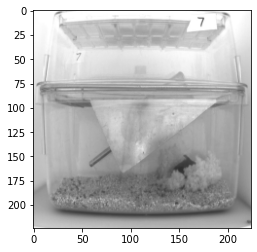

In [16]:
random_image_index = random.randrange(0, image_count)
image = real_train_data[random_image_index]
plt.imshow(image, cmap='gist_gray')

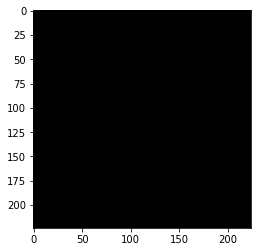

In [17]:
plt.imshow(final_per_pixel_average, cmap='gist_gray')

Data Range: -255 to -46


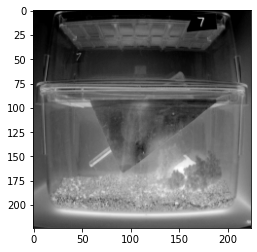

In [18]:
# Using this for Loss
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
unnormalized_ppa = final_per_pixel_average - image
plt.imshow(unnormalized_ppa, cmap='gist_gray')
print("Data Range:", np.min(unnormalized_ppa), "to", np.max(unnormalized_ppa))

#### Normalizing the Image Weights

Data Range: 0.0 to 1.0


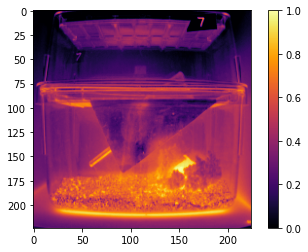

In [19]:
normalized_ppa = (unnormalized_ppa - np.min(unnormalized_ppa)) / (np.max(unnormalized_ppa) - np.min(unnormalized_ppa))
plt.imshow(normalized_ppa, cmap='inferno')
plt.colorbar()
print("Data Range:", np.min(normalized_ppa), "to", np.max(normalized_ppa))

In [20]:
def valid_imshow_data(data):
    data = np.asarray(data)
    if data.ndim == 2:
        return True
    elif data.ndim == 3:
        if 3 <= data.shape[2] <= 4:
            return True
        else:
            print('The "data" has 3 dimensions but the last dimension '
                  'must have a length of 3 (RGB) or 4 (RGBA), not "{}".'
                  ''.format(data.shape[2]))
            return False
    else:
        print('To visualize an image the data must be 2 dimensional or '
              '3 dimensional, not "{}".'
              ''.format(data.ndim))
        return False

In [21]:
print("Image:", valid_imshow_data(train_dataset_list[0]))
print("PPA:", valid_imshow_data(final_per_pixel_average))

Image: True
PPA: True


In [22]:
# cv2.imshow("Image", np.array(train_dataset_list[0]))
# cv2.imshow("PPA", np.array(final_per_pixel_average))
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [23]:
final_per_pixel_average_temp = np.array(final_per_pixel_average)
# final_per_pixel_average = final_per_pixel_average_temp.astype(np.uint8)
# cv2.imshow("PPA", final_per_pixel_average)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [24]:
class Weighted_MSE(nn.Module):
    def __init__(self, ppa):
        super(Weighted_MSE, self).__init__();
        self.ppa = torch.Tensor(ppa).cuda()

    def forward(self, predictions, target):
        W = self.ppa - target
        W = (W - torch.min(W)) / (torch.max(W) - torch.min(W))
        error = (predictions - target)*W
        square_difference = torch.square(error)
        loss_value = torch.mean(square_difference)
        return loss_value

In [25]:
learningRate = 0.001
autoencoder_criterion = Weighted_MSE(unnormalized_ppa)
# autoencoder_criterion = MS_SSIM(data_range=255, size_average=True, channel=1)

# autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr = learningRate)
autoencoder_optimizer = optim.Adam(vae.parameters(), lr = learningRate)
scheduler = optim.lr_scheduler.StepLR(autoencoder_optimizer, step_size=30, gamma = 0.1)

In [26]:
def loss_function(reconstructions, target, mean, logvar):
    mse_loss = nn.MSELoss()
    MSE = mse_loss(reconstructions, target)
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return MSE + KLD

In [27]:
# os.environ["WANDB_API_KEY"] = "99528c40ebd16fca6632e963a943b99ac8a5f4b7"

# project = "nih_animal_behavior"
# wandb.init(project=project, entity="serrelab", id='ResNet-18_VAE_epochs_wLoss')

# wandb.config = {
#   "learning_rate": learningRate,
#   "epochs": number_of_epochs,
#   "batch_size": batch_size
# }

In [28]:
batch_size = 16
number_of_epochs =  5
learningRate= 0.0001

torch.Size([16, 3, 224, 224])
torch.Size([8, 3, 224, 224])


/home/anagara8/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


[1] Loss -> Training: 94.1586933 | Validation: 44.5968971
torch.Size([16, 3, 224, 224])
torch.Size([8, 3, 224, 224])
[2] Loss -> Training: 53.1017723 | Validation: 56.6708565
torch.Size([16, 3, 224, 224])
torch.Size([8, 3, 224, 224])
[3] Loss -> Training: 25.4502063 | Validation: 50.3840714
torch.Size([16, 3, 224, 224])
torch.Size([8, 3, 224, 224])
[4] Loss -> Training: 16.9032140 | Validation: 38.2434616
torch.Size([16, 3, 224, 224])
torch.Size([8, 3, 224, 224])
[5] Loss -> Training: 8.3878756 | Validation: 30.0060692
Finished Training


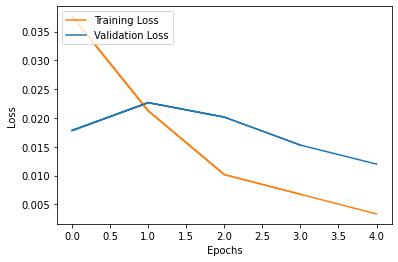

In [30]:
list_train_loss = []
list_val_loss = []


for epoch in range(number_of_epochs):
    train_run_loss = 0 
    val_run_loss = 0
    vae.train(True) # For training
    for image_batch in train_set_loader:
#         print("Image batch size:", len(image_batch))
#         print(image_batch.requires_grad)
        image_batch = image_batch.cuda()
        print(image_batch.shape)
        autoencoder_optimizer.zero_grad()
        enc_dec_img, mean, logvar = vae(image_batch)
        train_loss = loss_function(enc_dec_img, image_batch, mean, logvar)
        # Backward pass
        train_loss.backward()
        autoencoder_optimizer.step()
        train_run_loss += train_loss.data.item()

    vae.eval()
    for image_batch in valid_set_loader:
        image_batch = image_batch.cuda()
        autoencoder_optimizer.zero_grad()
        enc_dec_img, mean, logvar = vae(image_batch)
        val_loss = loss_function(enc_dec_img, image_batch, mean, logvar)
        # No Backward pass
#         val_loss.backward()
#         autoencoder_optimizer.step()

        val_run_loss += val_loss.data.item()
    print('[%d] Loss -> Training: %.7f | Validation: %.7f' % (epoch + 1, train_run_loss/2, val_run_loss/2))
    list_val_loss.append(val_run_loss/5000)
    list_train_loss.append(train_run_loss/5000)

#     wandb.log({"train_loss": train_run_loss/5000, "val_loss": val_run_loss/5000})

    # Optional
#     wandb.watch(vae)

    val_run_loss = 0.0
    train_run_loss = 0.0

    plt.plot(range(epoch+1),list_train_loss,'tab:orange',label='Training Loss')
    plt.plot(range(epoch+1),list_val_loss,'tab:blue',label='Validation Loss')
#     if epoch%20 == 0:
#         # Log image(s)
#         plt.imshow(image_batch.squeeze().cpu(), cmap='gist_gray')
#         plt.imshow(enc_dec_img.squeeze().detach().cpu(), cmap='gist_gray')        
#         wandb.log({"reconstructed": [wandb.Image(enc_dec_img.squeeze().cpu(), caption="Reconstructed Image")]})
#         wandb.log({"target": [wandb.Image(image_batch.squeeze().cpu(), caption="Target Image")]})
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
print('Finished Training')

In [29]:
torch.save(vae.state_dict(), "Model_new_arch_wLoss.p")

In [30]:
torch.cuda.empty_cache()

RuntimeError: number of dims don't match in permute

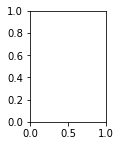

In [32]:
#WeightedLoss
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def plot_vae_outputs(vae, n=10):
    plt.figure(figsize=(16,4.5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        
        img = test_set_loader.dataset[i].unsqueeze(0).cuda()
        vae.eval()
        with torch.no_grad():
            rec_img  = vae(img)
        temp = torch.permute(img[0].cpu(), (1, 2, 0))
        temp_rec_img = torch.permute(rec_img[0].cpu(), (1, 2, 0))
#         print("Valid Image?", valid_imshow_data(temp))
        
#         print(len(temp), len(temp[0]), len(temp[0][0]))
        plt.imshow(temp, cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
#         plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        plt.imshow(temp_rec_img, cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()
    
plot_vae_outputs(vae)

In [47]:


class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):
    def __init__(self, z_dim=32):
        super(ResNet18Enc, self).__init__()
        self.z_dim = z_dim
        self.ResNet18 = models.resnet18(pretrained=True)
        self.num_feature = self.ResNet18.fc.in_features
        self.ResNet18.fc = nn.Linear(self.num_feature, 1*self.z_dim)
        
    def forward(self, x):
        x = self.ResNet18(x)
        return x

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=32, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=7)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = F.interpolate(x, size=(112,112), mode='bilinear')
        x = torch.sigmoid(self.conv1(x))
        # [x, channels, height, width]
        x = x.view(x.size(0), 3, 224, 224)
        return x

class newVAE(nn.Module):

    def __init__(self, z_dim):
        super(newVAE, self).__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def forward(self, x):
        z = self.encoder(x)
#         mean, logvar = self.encoder(x)
#         z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x

    @staticmethod
    def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean

def format_timedelta(td):
    """Utility function to format timedelta objects in a cool way (e.g 00:00:20.05) 
    omitting microseconds and retaining milliseconds"""
    result = str(td)
    try:
        result, ms = result.split(".")
    except ValueError:
        return result + ".00".replace(":", "-")
    ms = int(ms)
    ms = round(ms / 1e4)
    return f"{result}.{ms:02}".replace(":", "-")


def get_saving_frames_durations(cap, saving_fps):
    """A function that returns the list of durations where to save the frames"""
    s = []
    # get the clip duration by dividing number of frames by the number of frames per second
    clip_duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    # use np.arange() to make floating-point steps
    for i in np.arange(0, clip_duration, 1 / saving_fps):
        s.append(i)
    return s

In [44]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):
    def __init__(self, z_dim=32):
        super(ResNet18Enc, self).__init__()
        self.z_dim = z_dim
        self.ResNet18 = models.resnet18(pretrained=True)
        self.num_feature = self.ResNet18.fc.in_features
        self.ResNet18.fc = nn.Linear(self.num_feature, 2*self.z_dim)
        
    def forward(self, x):
        x = self.ResNet18(x)
        mu = x[:, :self.z_dim]
        logvar = x[:, self.z_dim:]
        return mu, logvar

# class ResNet18Enc(nn.Module):

#     def __init__(self, num_Blocks=[2,2,2,2], z_dim=128, nc=1):
#         super(ResNet18Enc, self).__init__()
#         self.in_planes = 64
#         self.z_dim = z_dim
#         self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=2, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(BasicBlockEnc, 64, num_Blocks[0], stride=1)
#         self.layer2 = self._make_layer(BasicBlockEnc, 128, num_Blocks[1], stride=2)
#         self.layer3 = self._make_layer(BasicBlockEnc, 256, num_Blocks[2], stride=2)
#         self.layer4 = self._make_layer(BasicBlockEnc, 512, num_Blocks[3], stride=2)
# #         self.linear = nn.Linear(512, 2 * z_dim)
#         self.linear = nn.Linear(512, z_dim)

#     def _make_layer(self, BasicBlockEnc, planes, num_Blocks, stride):
#         strides = [stride] + [1]*(num_Blocks-1)
#         layers = []
#         for stride in strides:
#             layers += [BasicBlockEnc(self.in_planes, stride)]
#             self.in_planes = planes
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         x = torch.relu(self.bn1(self.conv1(x)))
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         x = F.adaptive_avg_pool2d(x, 1)
#         x = x.view(x.size(0), -1)
#         x = self.linear(x)
#         mu = x[:, :self.z_dim]
#         logvar = x[:, self.z_dim:]
# #         return mu, logvar
#         return x

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=32, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=7)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = F.interpolate(x, size=(112,112), mode='bilinear')
        x = torch.sigmoid(self.conv1(x))
        # [x, channels, height, width]
        x = x.view(x.size(0), 3, 224, 224)
        return x

class VAE_Model(nn.Module):

    def __init__(self, z_dim):
        super(VAE_Model, self).__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x, mean, logvar
    
    @staticmethod
    def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean

In [87]:
#MSELoss
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def plot_vae_outputs(vae, n=10):
    plt.figure(figsize=(32,9))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        
        img = test_set_loader.dataset[i].unsqueeze(0).cuda()
        vae.eval()
#         print("Image:", img[0], img)
        with torch.no_grad():
            rec_img  = vae(img)
        temp = torch.permute(img[0].cpu(), (1, 2, 0))
#         print(len(temp), len(temp[0]), len(temp[0][0]))
        
        rec_img = torch.squeeze(rec_img[0])
#         print(len(rec_img), len(rec_img[0]), len(rec_img[0][0]))
        temp_rec_img = torch.permute(rec_img.cpu(), (1, 2, 0))
#         print("Valid Image?", valid_imshow_data(temp))
        
#         print(len(temp), len(temp[0]), len(temp[0][0]))
#         print("Image:", len(temp), len(temp[0]), len(temp[0][0]))
#         image8 = temp_rec_img.astype('uint8')
#         cv2.imwrite("Temp.png", np.array(temp_rec_img, np.int32))
        plt.imshow(temp, cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
#         plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        plt.imshow(temp_rec_img, cmap='gist_gray')  
#         print(temp_rec_img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()
    
# plot_vae_outputs(model)
# print(temp)

In [89]:
model = VAE_Model(64)
model = nn.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load("vae_MSE_e600.p"))
model.eval()
plot_vae_outputs(model)

RuntimeError: Error(s) in loading state_dict for DataParallel:
	size mismatch for module.encoder.ResNet18.fc.weight: copying a param with shape torch.Size([64, 512]) from checkpoint, the shape in current model is torch.Size([128, 512]).
	size mismatch for module.encoder.ResNet18.fc.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for module.decoder.linear.weight: copying a param with shape torch.Size([512, 32]) from checkpoint, the shape in current model is torch.Size([512, 64]).

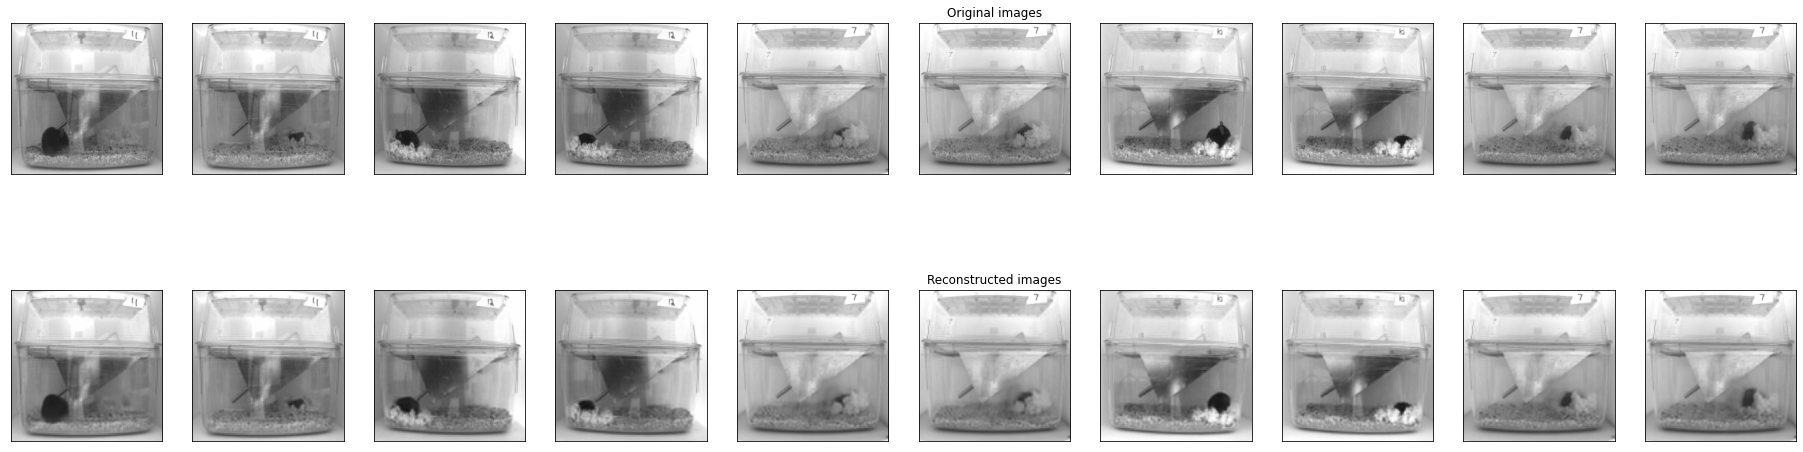

In [93]:
model = newVAE(32)
model = nn.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load("/home/anagara8/Documents/Autoencoder/new_architecture_MSE_e1200.p"))
model.eval()
plot_vae_outputs(model)

In [95]:
activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
        return hook

In [62]:
dimension = (224, 224)
SAVING_FRAMES_PER_SECOND = 30
def format_timedelta(td):
    """Utility function to format timedelta objects in a cool way (e.g 00:00:20.05) 
    omitting microseconds and retaining milliseconds"""
    result = str(td)
    try:
        result, ms = result.split(".")
    except ValueError:
        return result + ".00".replace(":", "-")
    ms = int(ms)
    ms = round(ms / 1e4)
    return f"{result}.{ms:02}".replace(":", "-")


def get_saving_frames_durations(cap, saving_fps):
    """A function that returns the list of durations where to save the frames"""
    s = []
    # get the clip duration by dividing number of frames by the number of frames per second
    clip_duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    # use np.arange() to make floating-point steps
    for i in np.arange(0, clip_duration, 1 / saving_fps):
        s.append(i)
    return s

def main(video_file):
    filename, _ = os.path.splitext(video_file)
    filename += "-opencv"
    print(filename)
    # make a folder by the name of the video file
    if not os.path.isdir(filename):
        os.mkdir(filename)
    # read the video file    
    cap = cv2.VideoCapture(video_file)
    # get the FPS of the video
    fps = cap.get(cv2.CAP_PROP_FPS)
    # if the SAVING_FRAMES_PER_SECOND is above video FPS, then set it to FPS (as maximum)
    saving_frames_per_second = min(fps, SAVING_FRAMES_PER_SECOND)
    # get the list of duration spots to save
    saving_frames_durations = get_saving_frames_durations(cap, saving_frames_per_second)
    # start the loop
    count = 0
    while True:
        is_read, frame = cap.read()
        frame = cv2.resize(frame,  dimension, interpolation = cv2.INTER_AREA)
        if not is_read:
            # break out of the loop if there are no frames to read
            break
        # get the duration by dividing the frame count by the FPS
        frame_duration = count / fps
        try:
            # get the earliest duration to save
            closest_duration = saving_frames_durations[0]
        except IndexError:
            # the list is empty, all duration frames were saved
            break
        if frame_duration >= closest_duration:
            print("Enter")
            # if closest duration is less than or equals the frame duration, 
            # then save the frame
            frame_duration_formatted = format_timedelta(timedelta(seconds=frame_duration))
            tensor_frame = torchvision.transforms.functional.to_tensor(frame).unsqueeze(0).cuda()
            with torch.no_grad():
                reconstructed_frame = model(tensor_frame) 
            temp = torch.permute(reconstructed_frame[0].cpu(), (1, 2, 0))
#             print("Printing:",temp.size(), np.array(temp))
            print("Before saving")
            cv2.imwrite(os.path.join("/home/anagara8/Documents/Autoencoder/reconstructed_frames/video_long/", f"frame{frame_duration_formatted}.jpg"), np.array(temp*255)) 
            cv2.imwrite(os.path.join("/home/anagara8/Documents/Autoencoder/Original_Long_Video/", f"frame{frame_duration_formatted}.jpg"), frame) 
            # drop the duration spot from the list, since this duration spot is already saved
            try:
                saving_frames_durations.pop(0)
            except IndexError:
                pass
        else:
            print("Else reached")
        print("Frame", count)
        # increment the frame count
        count += 1

In [63]:
main("/media/data_cifs/nih/files_to_send/FC-C_1-6_postcond_10-15_10-17/video_2018Y_10M_15D_11h_15m_58s_cam_17202341-0000.mp4")

/media/data_cifs/nih/files_to_send/FC-C_1-6_postcond_10-15_10-17/video_2018Y_10M_15D_11h_15m_58s_cam_17202341-0000-opencv
Enter
Before saving
Frame 0
Enter
Before saving
Frame 1
Enter
Before saving
Frame 2
Enter
Before saving
Frame 3
Enter
Before saving
Frame 4
Enter
Before saving
Frame 5
Enter
Before saving
Frame 6
Enter
Before saving
Frame 7
Enter
Before saving
Frame 8
Enter
Before saving
Frame 9
Enter
Before saving
Frame 10
Enter
Before saving
Frame 11
Enter
Before saving
Frame 12
Enter
Before saving
Frame 13
Enter
Before saving
Frame 14
Enter
Before saving
Frame 15
Enter
Before saving
Frame 16
Enter
Before saving
Frame 17
Enter
Before saving
Frame 18
Enter
Before saving
Frame 19
Enter
Before saving
Frame 20
Enter
Before saving
Frame 21
Enter
Before saving
Frame 22
Enter
Before saving
Frame 23
Enter
Before saving
Frame 24
Enter
Before saving
Frame 25
Enter
Before saving
Frame 26
Enter
Before saving
Frame 27
Enter
Before saving
Frame 28
Enter
Before saving
Frame 29
Enter
Before savin

Frame 283
Enter
Before saving
Frame 284
Enter
Before saving
Frame 285
Enter
Before saving
Frame 286
Enter
Before saving
Frame 287
Enter
Before saving
Frame 288
Enter
Before saving
Frame 289
Enter
Before saving
Frame 290
Enter
Before saving
Frame 291
Enter
Before saving
Frame 292
Enter
Before saving
Frame 293
Enter
Before saving
Frame 294
Enter
Before saving
Frame 295
Enter
Before saving
Frame 296
Enter
Before saving
Frame 297
Enter
Before saving
Frame 298
Enter
Before saving
Frame 299
Enter
Before saving
Frame 300
Enter
Before saving
Frame 301
Enter
Before saving
Frame 302
Enter
Before saving
Frame 303
Enter
Before saving
Frame 304
Enter
Before saving
Frame 305
Enter
Before saving
Frame 306
Enter
Before saving
Frame 307
Enter
Before saving
Frame 308
Enter
Before saving
Frame 309
Enter
Before saving
Frame 310
Enter
Before saving
Frame 311
Enter
Before saving
Frame 312
Enter
Before saving
Frame 313
Enter
Before saving
Frame 314
Enter
Before saving
Frame 315
Enter
Before saving
Frame 316


Before saving
Frame 571
Enter
Before saving
Frame 572
Enter
Before saving
Frame 573
Enter
Before saving
Frame 574
Enter
Before saving
Frame 575
Enter
Before saving
Frame 576
Enter
Before saving
Frame 577
Enter
Before saving
Frame 578
Enter
Before saving
Frame 579
Enter
Before saving
Frame 580
Enter
Before saving
Frame 581
Enter
Before saving
Frame 582
Enter
Before saving
Frame 583
Enter
Before saving
Frame 584
Enter
Before saving
Frame 585
Enter
Before saving
Frame 586
Enter
Before saving
Frame 587
Enter
Before saving
Frame 588
Enter
Before saving
Frame 589
Enter
Before saving
Frame 590
Enter
Before saving
Frame 591
Enter
Before saving
Frame 592
Enter
Before saving
Frame 593
Enter
Before saving
Frame 594
Enter
Before saving
Frame 595
Enter
Before saving
Frame 596
Enter
Before saving
Frame 597
Enter
Before saving
Frame 598
Enter
Before saving
Frame 599
Enter
Before saving
Frame 600
Enter
Before saving
Frame 601
Enter
Before saving
Frame 602
Enter
Before saving
Frame 603
Enter
Before sav

Before saving
Frame 858
Enter
Before saving
Frame 859
Enter
Before saving
Frame 860
Enter
Before saving
Frame 861
Enter
Before saving
Frame 862
Enter
Before saving
Frame 863
Enter
Before saving
Frame 864
Enter
Before saving
Frame 865
Enter
Before saving
Frame 866
Enter
Before saving
Frame 867
Enter
Before saving
Frame 868
Enter
Before saving
Frame 869
Enter
Before saving
Frame 870
Enter
Before saving
Frame 871
Enter
Before saving
Frame 872
Enter
Before saving
Frame 873
Enter
Before saving
Frame 874
Enter
Before saving
Frame 875
Enter
Before saving
Frame 876
Enter
Before saving
Frame 877
Enter
Before saving
Frame 878
Enter
Before saving
Frame 879
Enter
Before saving
Frame 880
Enter
Before saving
Frame 881
Enter
Before saving
Frame 882
Enter
Before saving
Frame 883
Enter
Before saving
Frame 884
Enter
Before saving
Frame 885
Enter
Before saving
Frame 886
Enter
Before saving
Frame 887
Enter
Before saving
Frame 888
Enter
Before saving
Frame 889
Enter
Before saving
Frame 890
Enter
Before sav

Before saving
Frame 1127
Enter
Before saving
Frame 1128
Enter
Before saving
Frame 1129
Enter
Before saving
Frame 1130
Enter
Before saving
Frame 1131
Enter
Before saving
Frame 1132
Enter
Before saving
Frame 1133
Enter
Before saving
Frame 1134
Enter
Before saving
Frame 1135
Enter
Before saving
Frame 1136
Enter
Before saving
Frame 1137
Enter
Before saving
Frame 1138
Enter
Before saving
Frame 1139
Enter
Before saving
Frame 1140
Enter
Before saving
Frame 1141
Enter
Before saving
Frame 1142
Enter
Before saving
Frame 1143
Enter
Before saving
Frame 1144
Enter
Before saving
Frame 1145
Enter
Before saving
Frame 1146
Enter
Before saving
Frame 1147
Enter
Before saving
Frame 1148
Enter
Before saving
Frame 1149
Enter
Before saving
Frame 1150
Enter
Before saving
Frame 1151
Enter
Before saving
Frame 1152
Enter
Before saving
Frame 1153
Enter
Before saving
Frame 1154
Enter
Before saving
Frame 1155
Enter
Before saving
Frame 1156
Enter
Before saving
Frame 1157
Enter
Before saving
Frame 1158
Enter
Before s

Frame 1393
Enter
Before saving
Frame 1394
Enter
Before saving
Frame 1395
Enter
Before saving
Frame 1396
Enter
Before saving
Frame 1397
Enter
Before saving
Frame 1398
Enter
Before saving
Frame 1399
Enter
Before saving
Frame 1400
Enter
Before saving
Frame 1401
Enter
Before saving
Frame 1402
Enter
Before saving
Frame 1403
Enter
Before saving
Frame 1404
Enter
Before saving
Frame 1405
Enter
Before saving
Frame 1406
Enter
Before saving
Frame 1407
Enter
Before saving
Frame 1408
Enter
Before saving
Frame 1409
Enter
Before saving
Frame 1410
Enter
Before saving
Frame 1411
Enter
Before saving
Frame 1412
Enter
Before saving
Frame 1413
Enter
Before saving
Frame 1414
Enter
Before saving
Frame 1415
Enter
Before saving
Frame 1416
Enter
Before saving
Frame 1417
Enter
Before saving
Frame 1418
Enter
Before saving
Frame 1419
Enter
Before saving
Frame 1420
Enter
Before saving
Frame 1421
Enter
Before saving
Frame 1422
Enter
Before saving
Frame 1423
Enter
Before saving
Frame 1424
Enter
Before saving
Frame 14

Before saving
Frame 1665
Enter
Before saving
Frame 1666
Enter
Before saving
Frame 1667
Enter
Before saving
Frame 1668
Enter
Before saving
Frame 1669
Enter
Before saving
Frame 1670
Enter
Before saving
Frame 1671
Enter
Before saving
Frame 1672
Enter
Before saving
Frame 1673
Enter
Before saving
Frame 1674
Enter
Before saving
Frame 1675
Enter
Before saving
Frame 1676
Enter
Before saving
Frame 1677
Enter
Before saving
Frame 1678
Enter
Before saving
Frame 1679
Enter
Before saving
Frame 1680
Enter
Before saving
Frame 1681
Enter
Before saving
Frame 1682
Enter
Before saving
Frame 1683
Enter
Before saving
Frame 1684
Enter
Before saving
Frame 1685
Enter
Before saving
Frame 1686
Enter
Before saving
Frame 1687
Enter
Before saving
Frame 1688
Enter
Before saving
Frame 1689
Enter
Before saving
Frame 1690
Enter
Before saving
Frame 1691
Enter
Before saving
Frame 1692
Enter
Before saving
Frame 1693
Enter
Before saving
Frame 1694
Enter
Before saving
Frame 1695
Enter
Before saving
Frame 1696
Enter
Before s

Frame 1947
Enter
Before saving
Frame 1948
Enter
Before saving
Frame 1949
Enter
Before saving
Frame 1950
Enter
Before saving
Frame 1951
Enter
Before saving
Frame 1952
Enter
Before saving
Frame 1953
Enter
Before saving
Frame 1954
Enter
Before saving
Frame 1955
Enter
Before saving
Frame 1956
Enter
Before saving
Frame 1957
Enter
Before saving
Frame 1958
Enter
Before saving
Frame 1959
Enter
Before saving
Frame 1960
Enter
Before saving
Frame 1961
Enter
Before saving
Frame 1962
Enter
Before saving
Frame 1963
Enter
Before saving
Frame 1964
Enter
Before saving
Frame 1965
Enter
Before saving
Frame 1966
Enter
Before saving
Frame 1967
Enter
Before saving
Frame 1968
Enter
Before saving
Frame 1969
Enter
Before saving
Frame 1970
Enter
Before saving
Frame 1971
Enter
Before saving
Frame 1972
Enter
Before saving
Frame 1973
Enter
Before saving
Frame 1974
Enter
Before saving
Frame 1975
Enter
Before saving
Frame 1976
Enter
Before saving
Frame 1977
Enter
Before saving
Frame 1978
Enter
Before saving
Frame 19

Frame 2213
Enter
Before saving
Frame 2214
Enter
Before saving
Frame 2215
Enter
Before saving
Frame 2216
Enter
Before saving
Frame 2217
Enter
Before saving
Frame 2218
Enter
Before saving
Frame 2219
Enter
Before saving
Frame 2220
Enter
Before saving
Frame 2221
Enter
Before saving
Frame 2222
Enter
Before saving
Frame 2223
Enter
Before saving
Frame 2224
Enter
Before saving
Frame 2225
Enter
Before saving
Frame 2226
Enter
Before saving
Frame 2227
Enter
Before saving
Frame 2228
Enter
Before saving
Frame 2229
Enter
Before saving
Frame 2230
Enter
Before saving
Frame 2231
Enter
Before saving
Frame 2232
Enter
Before saving
Frame 2233
Enter
Before saving
Frame 2234
Enter
Before saving
Frame 2235
Enter
Before saving
Frame 2236
Enter
Before saving
Frame 2237
Enter
Before saving
Frame 2238
Enter
Before saving
Frame 2239
Enter
Before saving
Frame 2240
Enter
Before saving
Frame 2241
Enter
Before saving
Frame 2242
Enter
Before saving
Frame 2243
Enter
Before saving
Frame 2244
Enter
Before saving
Frame 22

Before saving
Frame 2484
Enter
Before saving
Frame 2485
Enter
Before saving
Frame 2486
Enter
Before saving
Frame 2487
Enter
Before saving
Frame 2488
Enter
Before saving
Frame 2489
Enter
Before saving
Frame 2490
Enter
Before saving
Frame 2491
Enter
Before saving
Frame 2492
Enter
Before saving
Frame 2493
Enter
Before saving
Frame 2494
Enter
Before saving
Frame 2495
Enter
Before saving
Frame 2496
Enter
Before saving
Frame 2497
Enter
Before saving
Frame 2498
Enter
Before saving
Frame 2499
Enter
Before saving
Frame 2500
Enter
Before saving
Frame 2501
Enter
Before saving
Frame 2502
Enter
Before saving
Frame 2503
Enter
Before saving
Frame 2504
Enter
Before saving
Frame 2505
Enter
Before saving
Frame 2506
Enter
Before saving
Frame 2507
Enter
Before saving
Frame 2508
Enter
Before saving
Frame 2509
Enter
Before saving
Frame 2510
Enter
Before saving
Frame 2511
Enter
Before saving
Frame 2512
Enter
Before saving
Frame 2513
Enter
Before saving
Frame 2514
Enter
Before saving
Frame 2515
Enter
Before s

Frame 2766
Enter
Before saving
Frame 2767
Enter
Before saving
Frame 2768
Enter
Before saving
Frame 2769
Enter
Before saving
Frame 2770
Enter
Before saving
Frame 2771
Enter
Before saving
Frame 2772
Enter
Before saving
Frame 2773
Enter
Before saving
Frame 2774
Enter
Before saving
Frame 2775
Enter
Before saving
Frame 2776
Enter
Before saving
Frame 2777
Enter
Before saving
Frame 2778
Enter
Before saving
Frame 2779
Enter
Before saving
Frame 2780
Enter
Before saving
Frame 2781
Enter
Before saving
Frame 2782
Enter
Before saving
Frame 2783
Enter
Before saving
Frame 2784
Enter
Before saving
Frame 2785
Enter
Before saving
Frame 2786
Enter
Before saving
Frame 2787
Enter
Before saving
Frame 2788
Enter
Before saving
Frame 2789
Enter
Before saving
Frame 2790
Enter
Before saving
Frame 2791
Enter
Before saving
Frame 2792
Enter
Before saving
Frame 2793
Enter
Before saving
Frame 2794
Enter
Before saving
Frame 2795
Enter
Before saving
Frame 2796
Enter
Before saving
Frame 2797
Enter
Before saving
Frame 27

Frame 3047
Enter
Before saving
Frame 3048
Enter
Before saving
Frame 3049
Enter
Before saving
Frame 3050
Enter
Before saving
Frame 3051
Enter
Before saving
Frame 3052
Enter
Before saving
Frame 3053
Enter
Before saving
Frame 3054
Enter
Before saving
Frame 3055
Enter
Before saving
Frame 3056
Enter
Before saving
Frame 3057
Enter
Before saving
Frame 3058
Enter
Before saving
Frame 3059
Enter
Before saving
Frame 3060
Enter
Before saving
Frame 3061
Enter
Before saving
Frame 3062
Enter
Before saving
Frame 3063
Enter
Before saving
Frame 3064
Enter
Before saving
Frame 3065
Enter
Before saving
Frame 3066
Enter
Before saving
Frame 3067
Enter
Before saving
Frame 3068
Enter
Before saving
Frame 3069
Enter
Before saving
Frame 3070
Enter
Before saving
Frame 3071
Enter
Before saving
Frame 3072
Enter
Before saving
Frame 3073
Enter
Before saving
Frame 3074
Enter
Before saving
Frame 3075
Enter
Before saving
Frame 3076
Enter
Before saving
Frame 3077
Enter
Before saving
Frame 3078
Enter
Before saving
Frame 30

Frame 3314
Enter
Before saving
Frame 3315
Enter
Before saving
Frame 3316
Enter
Before saving
Frame 3317
Enter
Before saving
Frame 3318
Enter
Before saving
Frame 3319
Enter
Before saving
Frame 3320
Enter
Before saving
Frame 3321
Enter
Before saving
Frame 3322
Enter
Before saving
Frame 3323
Enter
Before saving
Frame 3324
Enter
Before saving
Frame 3325
Enter
Before saving
Frame 3326
Enter
Before saving
Frame 3327
Enter
Before saving
Frame 3328
Enter
Before saving
Frame 3329
Enter
Before saving
Frame 3330
Enter
Before saving
Frame 3331
Enter
Before saving
Frame 3332
Enter
Before saving
Frame 3333
Enter
Before saving
Frame 3334
Enter
Before saving
Frame 3335
Enter
Before saving
Frame 3336
Enter
Before saving
Frame 3337
Enter
Before saving
Frame 3338
Enter
Before saving
Frame 3339
Enter
Before saving
Frame 3340
Enter
Before saving
Frame 3341
Enter
Before saving
Frame 3342
Enter
Before saving
Frame 3343
Enter
Before saving
Frame 3344
Enter
Before saving
Frame 3345
Enter
Before saving
Frame 33

Before saving
Frame 3583
Enter
Before saving
Frame 3584
Enter
Before saving
Frame 3585
Enter
Before saving
Frame 3586
Enter
Before saving
Frame 3587
Enter
Before saving
Frame 3588
Enter
Before saving
Frame 3589
Enter
Before saving
Frame 3590
Enter
Before saving
Frame 3591
Enter
Before saving
Frame 3592
Enter
Before saving
Frame 3593
Enter
Before saving
Frame 3594
Enter
Before saving
Frame 3595
Enter
Before saving
Frame 3596
Enter
Before saving
Frame 3597
Enter
Before saving
Frame 3598
Enter
Before saving
Frame 3599
Enter
Before saving
Frame 3600
Enter
Before saving
Frame 3601
Enter
Before saving
Frame 3602
Enter
Before saving
Frame 3603
Enter
Before saving
Frame 3604
Enter
Before saving
Frame 3605
Enter
Before saving
Frame 3606
Enter
Before saving
Frame 3607
Enter
Before saving
Frame 3608
Enter
Before saving
Frame 3609
Enter
Before saving
Frame 3610
Enter
Before saving
Frame 3611
Enter
Before saving
Frame 3612
Enter
Before saving
Frame 3613
Enter
Before saving
Frame 3614
Enter
Before s

Before saving
Frame 3853
Enter
Before saving
Frame 3854
Enter
Before saving
Frame 3855
Enter
Before saving
Frame 3856
Enter
Before saving
Frame 3857
Enter
Before saving
Frame 3858
Enter
Before saving
Frame 3859
Enter
Before saving
Frame 3860
Enter
Before saving
Frame 3861
Enter
Before saving
Frame 3862
Enter
Before saving
Frame 3863
Enter
Before saving
Frame 3864
Enter
Before saving
Frame 3865
Enter
Before saving
Frame 3866
Enter
Before saving
Frame 3867
Enter
Before saving
Frame 3868
Enter
Before saving
Frame 3869
Enter
Before saving
Frame 3870
Enter
Before saving
Frame 3871
Enter
Before saving
Frame 3872
Enter
Before saving
Frame 3873
Enter
Before saving
Frame 3874
Enter
Before saving
Frame 3875
Enter
Before saving
Frame 3876
Enter
Before saving
Frame 3877
Enter
Before saving
Frame 3878
Enter
Before saving
Frame 3879
Enter
Before saving
Frame 3880
Enter
Before saving
Frame 3881
Enter
Before saving
Frame 3882
Enter
Before saving
Frame 3883
Enter
Before saving
Frame 3884
Enter
Before s

Before saving
Frame 4128
Enter
Before saving
Frame 4129
Enter
Before saving
Frame 4130
Enter
Before saving
Frame 4131
Enter
Before saving
Frame 4132
Enter
Before saving
Frame 4133
Enter
Before saving
Frame 4134
Enter
Before saving
Frame 4135
Enter
Before saving
Frame 4136
Enter
Before saving
Frame 4137
Enter
Before saving
Frame 4138
Enter
Before saving
Frame 4139
Enter
Before saving
Frame 4140
Enter
Before saving
Frame 4141
Enter
Before saving
Frame 4142
Enter
Before saving
Frame 4143
Enter
Before saving
Frame 4144
Enter
Before saving
Frame 4145
Enter
Before saving
Frame 4146
Enter
Before saving
Frame 4147
Enter
Before saving
Frame 4148
Enter
Before saving
Frame 4149
Enter
Before saving
Frame 4150
Enter
Before saving
Frame 4151
Enter
Before saving
Frame 4152
Enter
Before saving
Frame 4153
Enter
Before saving
Frame 4154
Enter
Before saving
Frame 4155
Enter
Before saving
Frame 4156
Enter
Before saving
Frame 4157
Enter
Before saving
Frame 4158
Enter
Before saving
Frame 4159
Enter
Before s

Before saving
Frame 4395
Enter
Before saving
Frame 4396
Enter
Before saving
Frame 4397
Enter
Before saving
Frame 4398
Enter
Before saving
Frame 4399
Enter
Before saving
Frame 4400
Enter
Before saving
Frame 4401
Enter
Before saving
Frame 4402
Enter
Before saving
Frame 4403
Enter
Before saving
Frame 4404
Enter
Before saving
Frame 4405
Enter
Before saving
Frame 4406
Enter
Before saving
Frame 4407
Enter
Before saving
Frame 4408
Enter
Before saving
Frame 4409
Enter
Before saving
Frame 4410
Enter
Before saving
Frame 4411
Enter
Before saving
Frame 4412
Enter
Before saving
Frame 4413
Enter
Before saving
Frame 4414
Enter
Before saving
Frame 4415
Enter
Before saving
Frame 4416
Enter
Before saving
Frame 4417
Enter
Before saving
Frame 4418
Enter
Before saving
Frame 4419
Enter
Before saving
Frame 4420
Enter
Before saving
Frame 4421
Enter
Before saving
Frame 4422
Enter
Before saving
Frame 4423
Enter
Before saving
Frame 4424
Enter
Before saving
Frame 4425
Enter
Before saving
Frame 4426
Enter
Before s

Before saving
Frame 4661
Enter
Before saving
Frame 4662
Enter
Before saving
Frame 4663
Enter
Before saving
Frame 4664
Enter
Before saving
Frame 4665
Enter
Before saving
Frame 4666
Enter
Before saving
Frame 4667
Enter
Before saving
Frame 4668
Enter
Before saving
Frame 4669
Enter
Before saving
Frame 4670
Enter
Before saving
Frame 4671
Enter
Before saving
Frame 4672
Enter
Before saving
Frame 4673
Enter
Before saving
Frame 4674
Enter
Before saving
Frame 4675
Enter
Before saving
Frame 4676
Enter
Before saving
Frame 4677
Enter
Before saving
Frame 4678
Enter
Before saving
Frame 4679
Enter
Before saving
Frame 4680
Enter
Before saving
Frame 4681
Enter
Before saving
Frame 4682
Enter
Before saving
Frame 4683
Enter
Before saving
Frame 4684
Enter
Before saving
Frame 4685
Enter
Before saving
Frame 4686
Enter
Before saving
Frame 4687
Enter
Before saving
Frame 4688
Enter
Before saving
Frame 4689
Enter
Before saving
Frame 4690
Enter
Before saving
Frame 4691
Enter
Before saving
Frame 4692
Enter
Before s

Before saving
Frame 4933
Enter
Before saving
Frame 4934
Enter
Before saving
Frame 4935
Enter
Before saving
Frame 4936
Enter
Before saving
Frame 4937
Enter
Before saving
Frame 4938
Enter
Before saving
Frame 4939
Enter
Before saving
Frame 4940
Enter
Before saving
Frame 4941
Enter
Before saving
Frame 4942
Enter
Before saving
Frame 4943
Enter
Before saving
Frame 4944
Enter
Before saving
Frame 4945
Enter
Before saving
Frame 4946
Enter
Before saving
Frame 4947
Enter
Before saving
Frame 4948
Enter
Before saving
Frame 4949
Enter
Before saving
Frame 4950
Enter
Before saving
Frame 4951
Enter
Before saving
Frame 4952
Enter
Before saving
Frame 4953
Enter
Before saving
Frame 4954
Enter
Before saving
Frame 4955
Enter
Before saving
Frame 4956
Enter
Before saving
Frame 4957
Enter
Before saving
Frame 4958
Enter
Before saving
Frame 4959
Enter
Before saving
Frame 4960
Enter
Before saving
Frame 4961
Enter
Before saving
Frame 4962
Enter
Before saving
Frame 4963
Enter
Before saving
Frame 4964
Enter
Before s

Before saving
Frame 5203
Enter
Before saving
Frame 5204
Enter
Before saving
Frame 5205
Enter
Before saving
Frame 5206
Enter
Before saving
Frame 5207
Enter
Before saving
Frame 5208
Enter
Before saving
Frame 5209
Enter
Before saving
Frame 5210
Enter
Before saving
Frame 5211
Enter
Before saving
Frame 5212
Enter
Before saving
Frame 5213
Enter
Before saving
Frame 5214
Enter
Before saving
Frame 5215
Enter
Before saving
Frame 5216
Enter
Before saving
Frame 5217
Enter
Before saving
Frame 5218
Enter
Before saving
Frame 5219
Enter
Before saving
Frame 5220
Enter
Before saving
Frame 5221
Enter
Before saving
Frame 5222
Enter
Before saving
Frame 5223
Enter
Before saving
Frame 5224
Enter
Before saving
Frame 5225
Enter
Before saving
Frame 5226
Enter
Before saving
Frame 5227
Enter
Before saving
Frame 5228
Enter
Before saving
Frame 5229
Enter
Before saving
Frame 5230
Enter
Before saving
Frame 5231
Enter
Before saving
Frame 5232
Enter
Before saving
Frame 5233
Enter
Before saving
Frame 5234
Enter
Before s

Before saving
Frame 5474
Enter
Before saving
Frame 5475
Enter
Before saving
Frame 5476
Enter
Before saving
Frame 5477
Enter
Before saving
Frame 5478
Enter
Before saving
Frame 5479
Enter
Before saving
Frame 5480
Enter
Before saving
Frame 5481
Enter
Before saving
Frame 5482
Enter
Before saving
Frame 5483
Enter
Before saving
Frame 5484
Enter
Before saving
Frame 5485
Enter
Before saving
Frame 5486
Enter
Before saving
Frame 5487
Enter
Before saving
Frame 5488
Enter
Before saving
Frame 5489
Enter
Before saving
Frame 5490
Enter
Before saving
Frame 5491
Enter
Before saving
Frame 5492
Enter
Before saving
Frame 5493
Enter
Before saving
Frame 5494
Enter
Before saving
Frame 5495
Enter
Before saving
Frame 5496
Enter
Before saving
Frame 5497
Enter
Before saving
Frame 5498
Enter
Before saving
Frame 5499
Enter
Before saving
Frame 5500
Enter
Before saving
Frame 5501
Enter
Before saving
Frame 5502
Enter
Before saving
Frame 5503
Enter
Before saving
Frame 5504
Enter
Before saving
Frame 5505
Enter
Before s

Before saving
Frame 5742
Enter
Before saving
Frame 5743
Enter
Before saving
Frame 5744
Enter
Before saving
Frame 5745
Enter
Before saving
Frame 5746
Enter
Before saving
Frame 5747
Enter
Before saving
Frame 5748
Enter
Before saving
Frame 5749
Enter
Before saving
Frame 5750
Enter
Before saving
Frame 5751
Enter
Before saving
Frame 5752
Enter
Before saving
Frame 5753
Enter
Before saving
Frame 5754
Enter
Before saving
Frame 5755
Enter
Before saving
Frame 5756
Enter
Before saving
Frame 5757
Enter
Before saving
Frame 5758
Enter
Before saving
Frame 5759
Enter
Before saving
Frame 5760
Enter
Before saving
Frame 5761
Enter
Before saving
Frame 5762
Enter
Before saving
Frame 5763
Enter
Before saving
Frame 5764
Enter
Before saving
Frame 5765
Enter
Before saving
Frame 5766
Enter
Before saving
Frame 5767
Enter
Before saving
Frame 5768
Enter
Before saving
Frame 5769
Enter
Before saving
Frame 5770
Enter
Before saving
Frame 5771
Enter
Before saving
Frame 5772
Enter
Before saving
Frame 5773
Enter
Before s

Before saving
Frame 6025
Enter
Before saving
Frame 6026
Enter
Before saving
Frame 6027
Enter
Before saving
Frame 6028
Enter
Before saving
Frame 6029
Enter
Before saving
Frame 6030
Enter
Before saving
Frame 6031
Enter
Before saving
Frame 6032
Enter
Before saving
Frame 6033
Enter
Before saving
Frame 6034
Enter
Before saving
Frame 6035
Enter
Before saving
Frame 6036
Enter
Before saving
Frame 6037
Enter
Before saving
Frame 6038
Enter
Before saving
Frame 6039
Enter
Before saving
Frame 6040
Enter
Before saving
Frame 6041
Enter
Before saving
Frame 6042
Enter
Before saving
Frame 6043
Enter
Before saving
Frame 6044
Enter
Before saving
Frame 6045
Enter
Before saving
Frame 6046
Enter
Before saving
Frame 6047
Enter
Before saving
Frame 6048
Enter
Before saving
Frame 6049
Enter
Before saving
Frame 6050
Enter
Before saving
Frame 6051
Enter
Before saving
Frame 6052
Enter
Before saving
Frame 6053
Enter
Before saving
Frame 6054
Enter
Before saving
Frame 6055
Enter
Before saving
Frame 6056
Enter
Before s

Before saving
Frame 6304
Enter
Before saving
Frame 6305
Enter
Before saving
Frame 6306
Enter
Before saving
Frame 6307
Enter
Before saving
Frame 6308
Enter
Before saving
Frame 6309
Enter
Before saving
Frame 6310
Enter
Before saving
Frame 6311
Enter
Before saving
Frame 6312
Enter
Before saving
Frame 6313
Enter
Before saving
Frame 6314
Enter
Before saving
Frame 6315
Enter
Before saving
Frame 6316
Enter
Before saving
Frame 6317
Enter
Before saving
Frame 6318
Enter
Before saving
Frame 6319
Enter
Before saving
Frame 6320
Enter
Before saving
Frame 6321
Enter
Before saving
Frame 6322
Enter
Before saving
Frame 6323
Enter
Before saving
Frame 6324
Enter
Before saving
Frame 6325
Enter
Before saving
Frame 6326
Enter
Before saving
Frame 6327
Enter
Before saving
Frame 6328
Enter
Before saving
Frame 6329
Enter
Before saving
Frame 6330
Enter
Before saving
Frame 6331
Enter
Before saving
Frame 6332
Enter
Before saving
Frame 6333
Enter
Before saving
Frame 6334
Enter
Before saving
Frame 6335
Enter
Before s

Frame 6568
Enter
Before saving
Frame 6569
Enter
Before saving
Frame 6570
Enter
Before saving
Frame 6571
Enter
Before saving
Frame 6572
Enter
Before saving
Frame 6573
Enter
Before saving
Frame 6574
Enter
Before saving
Frame 6575
Enter
Before saving
Frame 6576
Enter
Before saving
Frame 6577
Enter
Before saving
Frame 6578
Enter
Before saving
Frame 6579
Enter
Before saving
Frame 6580
Enter
Before saving
Frame 6581
Enter
Before saving
Frame 6582
Enter
Before saving
Frame 6583
Enter
Before saving
Frame 6584
Enter
Before saving
Frame 6585
Enter
Before saving
Frame 6586
Enter
Before saving
Frame 6587
Enter
Before saving
Frame 6588
Enter
Before saving
Frame 6589
Enter
Before saving
Frame 6590
Enter
Before saving
Frame 6591
Enter
Before saving
Frame 6592
Enter
Before saving
Frame 6593
Enter
Before saving
Frame 6594
Enter
Before saving
Frame 6595
Enter
Before saving
Frame 6596
Enter
Before saving
Frame 6597
Enter
Before saving
Frame 6598
Enter
Before saving
Frame 6599
Enter
Before saving
Frame 66

Enter
Before saving
Frame 6836
Enter
Before saving
Frame 6837
Enter
Before saving
Frame 6838
Enter
Before saving
Frame 6839
Enter
Before saving
Frame 6840
Enter
Before saving
Frame 6841
Enter
Before saving
Frame 6842
Enter
Before saving
Frame 6843
Enter
Before saving
Frame 6844
Enter
Before saving
Frame 6845
Enter
Before saving
Frame 6846
Enter
Before saving
Frame 6847
Enter
Before saving
Frame 6848
Enter
Before saving
Frame 6849
Enter
Before saving
Frame 6850
Enter
Before saving
Frame 6851
Enter
Before saving
Frame 6852
Enter
Before saving
Frame 6853
Enter
Before saving
Frame 6854
Enter
Before saving
Frame 6855
Enter
Before saving
Frame 6856
Enter
Before saving
Frame 6857
Enter
Before saving
Frame 6858
Enter
Before saving
Frame 6859
Enter
Before saving
Frame 6860
Enter
Before saving
Frame 6861
Enter
Before saving
Frame 6862
Enter
Before saving
Frame 6863
Enter
Before saving
Frame 6864
Enter
Before saving
Frame 6865
Enter
Before saving
Frame 6866
Enter
Before saving
Frame 6867
Enter
Be

Before saving
Frame 7119
Enter
Before saving
Frame 7120
Enter
Before saving
Frame 7121
Enter
Before saving
Frame 7122
Enter
Before saving
Frame 7123
Enter
Before saving
Frame 7124
Enter
Before saving
Frame 7125
Enter
Before saving
Frame 7126
Enter
Before saving
Frame 7127
Enter
Before saving
Frame 7128
Enter
Before saving
Frame 7129
Enter
Before saving
Frame 7130
Enter
Before saving
Frame 7131
Enter
Before saving
Frame 7132
Enter
Before saving
Frame 7133
Enter
Before saving
Frame 7134
Enter
Before saving
Frame 7135
Enter
Before saving
Frame 7136
Enter
Before saving
Frame 7137
Enter
Before saving
Frame 7138
Enter
Before saving
Frame 7139
Enter
Before saving
Frame 7140
Enter
Before saving
Frame 7141
Enter
Before saving
Frame 7142
Enter
Before saving
Frame 7143
Enter
Before saving
Frame 7144
Enter
Before saving
Frame 7145
Enter
Before saving
Frame 7146
Enter
Before saving
Frame 7147
Enter
Before saving
Frame 7148
Enter
Before saving
Frame 7149
Enter
Before saving
Frame 7150
Enter
Before s

Enter
Before saving
Frame 7386
Enter
Before saving
Frame 7387
Enter
Before saving
Frame 7388
Enter
Before saving
Frame 7389
Enter
Before saving
Frame 7390
Enter
Before saving
Frame 7391
Enter
Before saving
Frame 7392
Enter
Before saving
Frame 7393
Enter
Before saving
Frame 7394
Enter
Before saving
Frame 7395
Enter
Before saving
Frame 7396
Enter
Before saving
Frame 7397
Enter
Before saving
Frame 7398
Enter
Before saving
Frame 7399
Enter
Before saving
Frame 7400
Enter
Before saving
Frame 7401
Enter
Before saving
Frame 7402
Enter
Before saving
Frame 7403
Enter
Before saving
Frame 7404
Enter
Before saving
Frame 7405
Enter
Before saving
Frame 7406
Enter
Before saving
Frame 7407
Enter
Before saving
Frame 7408
Enter
Before saving
Frame 7409
Enter
Before saving
Frame 7410
Enter
Before saving
Frame 7411
Enter
Before saving
Frame 7412
Enter
Before saving
Frame 7413
Enter
Before saving
Frame 7414
Enter
Before saving
Frame 7415
Enter
Before saving
Frame 7416
Enter
Before saving
Frame 7417
Enter
Be

Before saving
Frame 7653
Enter
Before saving
Frame 7654
Enter
Before saving
Frame 7655
Enter
Before saving
Frame 7656
Enter
Before saving
Frame 7657
Enter
Before saving
Frame 7658
Enter
Before saving
Frame 7659
Enter
Before saving
Frame 7660
Enter
Before saving
Frame 7661
Enter
Before saving
Frame 7662
Enter
Before saving
Frame 7663
Enter
Before saving
Frame 7664
Enter
Before saving
Frame 7665
Enter
Before saving
Frame 7666
Enter
Before saving
Frame 7667
Enter
Before saving
Frame 7668
Enter
Before saving
Frame 7669
Enter
Before saving
Frame 7670
Enter
Before saving
Frame 7671
Enter
Before saving
Frame 7672
Enter
Before saving
Frame 7673
Enter
Before saving
Frame 7674
Enter
Before saving
Frame 7675
Enter
Before saving
Frame 7676
Enter
Before saving
Frame 7677
Enter
Before saving
Frame 7678
Enter
Before saving
Frame 7679
Enter
Before saving
Frame 7680
Enter
Before saving
Frame 7681
Enter
Before saving
Frame 7682
Enter
Before saving
Frame 7683
Enter
Before saving
Frame 7684
Enter
Before s

Before saving
Frame 7935
Enter
Before saving
Frame 7936
Enter
Before saving
Frame 7937
Enter
Before saving
Frame 7938
Enter
Before saving
Frame 7939
Enter
Before saving
Frame 7940
Enter
Before saving
Frame 7941
Enter
Before saving
Frame 7942
Enter
Before saving
Frame 7943
Enter
Before saving
Frame 7944
Enter
Before saving
Frame 7945
Enter
Before saving
Frame 7946
Enter
Before saving
Frame 7947
Enter
Before saving
Frame 7948
Enter
Before saving
Frame 7949
Enter
Before saving
Frame 7950
Enter
Before saving
Frame 7951
Enter
Before saving
Frame 7952
Enter
Before saving
Frame 7953
Enter
Before saving
Frame 7954
Enter
Before saving
Frame 7955
Enter
Before saving
Frame 7956
Enter
Before saving
Frame 7957
Enter
Before saving
Frame 7958
Enter
Before saving
Frame 7959
Enter
Before saving
Frame 7960
Enter
Before saving
Frame 7961
Enter
Before saving
Frame 7962
Enter
Before saving
Frame 7963
Enter
Before saving
Frame 7964
Enter
Before saving
Frame 7965
Enter
Before saving
Frame 7966
Enter
Before s

Before saving
Frame 8201
Enter
Before saving
Frame 8202
Enter
Before saving
Frame 8203
Enter
Before saving
Frame 8204
Enter
Before saving
Frame 8205
Enter
Before saving
Frame 8206
Enter
Before saving
Frame 8207
Enter
Before saving
Frame 8208
Enter
Before saving
Frame 8209
Enter
Before saving
Frame 8210
Enter
Before saving
Frame 8211
Enter
Before saving
Frame 8212
Enter
Before saving
Frame 8213
Enter
Before saving
Frame 8214
Enter
Before saving
Frame 8215
Enter
Before saving
Frame 8216
Enter
Before saving
Frame 8217
Enter
Before saving
Frame 8218
Enter
Before saving
Frame 8219
Enter
Before saving
Frame 8220
Enter
Before saving
Frame 8221
Enter
Before saving
Frame 8222
Enter
Before saving
Frame 8223
Enter
Before saving
Frame 8224
Enter
Before saving
Frame 8225
Enter
Before saving
Frame 8226
Enter
Before saving
Frame 8227
Enter
Before saving
Frame 8228
Enter
Before saving
Frame 8229
Enter
Before saving
Frame 8230
Enter
Before saving
Frame 8231
Enter
Before saving
Frame 8232
Enter
Before s

Enter
Before saving
Frame 8485
Enter
Before saving
Frame 8486
Enter
Before saving
Frame 8487
Enter
Before saving
Frame 8488
Enter
Before saving
Frame 8489
Enter
Before saving
Frame 8490
Enter
Before saving
Frame 8491
Enter
Before saving
Frame 8492
Enter
Before saving
Frame 8493
Enter
Before saving
Frame 8494
Enter
Before saving
Frame 8495
Enter
Before saving
Frame 8496
Enter
Before saving
Frame 8497
Enter
Before saving
Frame 8498
Enter
Before saving
Frame 8499
Enter
Before saving
Frame 8500
Enter
Before saving
Frame 8501
Enter
Before saving
Frame 8502
Enter
Before saving
Frame 8503
Enter
Before saving
Frame 8504
Enter
Before saving
Frame 8505
Enter
Before saving
Frame 8506
Enter
Before saving
Frame 8507
Enter
Before saving
Frame 8508
Enter
Before saving
Frame 8509
Enter
Before saving
Frame 8510
Enter
Before saving
Frame 8511
Enter
Before saving
Frame 8512
Enter
Before saving
Frame 8513
Enter
Before saving
Frame 8514
Enter
Before saving
Frame 8515
Enter
Before saving
Frame 8516
Enter
Be

Enter
Before saving
Frame 8752
Enter
Before saving
Frame 8753
Enter
Before saving
Frame 8754
Enter
Before saving
Frame 8755
Enter
Before saving
Frame 8756
Enter
Before saving
Frame 8757
Enter
Before saving
Frame 8758
Enter
Before saving
Frame 8759
Enter
Before saving
Frame 8760
Enter
Before saving
Frame 8761
Enter
Before saving
Frame 8762
Enter
Before saving
Frame 8763
Enter
Before saving
Frame 8764
Enter
Before saving
Frame 8765
Enter
Before saving
Frame 8766
Enter
Before saving
Frame 8767
Enter
Before saving
Frame 8768
Enter
Before saving
Frame 8769
Enter
Before saving
Frame 8770
Enter
Before saving
Frame 8771
Enter
Before saving
Frame 8772
Enter
Before saving
Frame 8773
Enter
Before saving
Frame 8774
Enter
Before saving
Frame 8775
Enter
Before saving
Frame 8776
Enter
Before saving
Frame 8777
Enter
Before saving
Frame 8778
Enter
Before saving
Frame 8779
Enter
Before saving
Frame 8780
Enter
Before saving
Frame 8781
Enter
Before saving
Frame 8782
Enter
Before saving
Frame 8783
Enter
Be

Frame 9034
Enter
Before saving
Frame 9035
Enter
Before saving
Frame 9036
Enter
Before saving
Frame 9037
Enter
Before saving
Frame 9038
Enter
Before saving
Frame 9039
Enter
Before saving
Frame 9040
Enter
Before saving
Frame 9041
Enter
Before saving
Frame 9042
Enter
Before saving
Frame 9043
Enter
Before saving
Frame 9044
Enter
Before saving
Frame 9045
Enter
Before saving
Frame 9046
Enter
Before saving
Frame 9047
Enter
Before saving
Frame 9048
Enter
Before saving
Frame 9049
Enter
Before saving
Frame 9050
Enter
Before saving
Frame 9051
Enter
Before saving
Frame 9052
Enter
Before saving
Frame 9053
Enter
Before saving
Frame 9054
Enter
Before saving
Frame 9055
Enter
Before saving
Frame 9056
Enter
Before saving
Frame 9057
Enter
Before saving
Frame 9058
Enter
Before saving
Frame 9059
Enter
Before saving
Frame 9060
Enter
Before saving
Frame 9061
Enter
Before saving
Frame 9062
Enter
Before saving
Frame 9063
Enter
Before saving
Frame 9064
Enter
Before saving
Frame 9065
Enter
Before saving
Frame 90

Before saving
Frame 9311
Enter
Before saving
Frame 9312
Enter
Before saving
Frame 9313
Enter
Before saving
Frame 9314
Enter
Before saving
Frame 9315
Enter
Before saving
Frame 9316
Enter
Before saving
Frame 9317
Enter
Before saving
Frame 9318
Enter
Before saving
Frame 9319
Enter
Before saving
Frame 9320
Enter
Before saving
Frame 9321
Enter
Before saving
Frame 9322
Enter
Before saving
Frame 9323
Enter
Before saving
Frame 9324
Enter
Before saving
Frame 9325
Enter
Before saving
Frame 9326
Enter
Before saving
Frame 9327
Enter
Before saving
Frame 9328
Enter
Before saving
Frame 9329
Enter
Before saving
Frame 9330
Enter
Before saving
Frame 9331
Enter
Before saving
Frame 9332
Enter
Before saving
Frame 9333
Enter
Before saving
Frame 9334
Enter
Before saving
Frame 9335
Enter
Before saving
Frame 9336
Enter
Before saving
Frame 9337
Enter
Before saving
Frame 9338
Enter
Before saving
Frame 9339
Enter
Before saving
Frame 9340
Enter
Before saving
Frame 9341
Enter
Before saving
Frame 9342
Enter
Before s

Enter
Before saving
Frame 9585
Enter
Before saving
Frame 9586
Enter
Before saving
Frame 9587
Enter
Before saving
Frame 9588
Enter
Before saving
Frame 9589
Enter
Before saving
Frame 9590
Enter
Before saving
Frame 9591
Enter
Before saving
Frame 9592
Enter
Before saving
Frame 9593
Enter
Before saving
Frame 9594
Enter
Before saving
Frame 9595
Enter
Before saving
Frame 9596
Enter
Before saving
Frame 9597
Enter
Before saving
Frame 9598
Enter
Before saving
Frame 9599
Enter
Before saving
Frame 9600
Enter
Before saving
Frame 9601
Enter
Before saving
Frame 9602
Enter
Before saving
Frame 9603
Enter
Before saving
Frame 9604
Enter
Before saving
Frame 9605
Enter
Before saving
Frame 9606
Enter
Before saving
Frame 9607
Enter
Before saving
Frame 9608
Enter
Before saving
Frame 9609
Enter
Before saving
Frame 9610
Enter
Before saving
Frame 9611
Enter
Before saving
Frame 9612
Enter
Before saving
Frame 9613
Enter
Before saving
Frame 9614
Enter
Before saving
Frame 9615
Enter
Before saving
Frame 9616
Enter
Be

Before saving
Frame 9852
Enter
Before saving
Frame 9853
Enter
Before saving
Frame 9854
Enter
Before saving
Frame 9855
Enter
Before saving
Frame 9856
Enter
Before saving
Frame 9857
Enter
Before saving
Frame 9858
Enter
Before saving
Frame 9859
Enter
Before saving
Frame 9860
Enter
Before saving
Frame 9861
Enter
Before saving
Frame 9862
Enter
Before saving
Frame 9863
Enter
Before saving
Frame 9864
Enter
Before saving
Frame 9865
Enter
Before saving
Frame 9866
Enter
Before saving
Frame 9867
Enter
Before saving
Frame 9868
Enter
Before saving
Frame 9869
Enter
Before saving
Frame 9870
Enter
Before saving
Frame 9871
Enter
Before saving
Frame 9872
Enter
Before saving
Frame 9873
Enter
Before saving
Frame 9874
Enter
Before saving
Frame 9875
Enter
Before saving
Frame 9876
Enter
Before saving
Frame 9877
Enter
Before saving
Frame 9878
Enter
Before saving
Frame 9879
Enter
Before saving
Frame 9880
Enter
Before saving
Frame 9881
Enter
Before saving
Frame 9882
Enter
Before saving
Frame 9883
Enter
Before s

Before saving
Frame 10126
Enter
Before saving
Frame 10127
Enter
Before saving
Frame 10128
Enter
Before saving
Frame 10129
Enter
Before saving
Frame 10130
Enter
Before saving
Frame 10131
Enter
Before saving
Frame 10132
Enter
Before saving
Frame 10133
Enter
Before saving
Frame 10134
Enter
Before saving
Frame 10135
Enter
Before saving
Frame 10136
Enter
Before saving
Frame 10137
Enter
Before saving
Frame 10138
Enter
Before saving
Frame 10139
Enter
Before saving
Frame 10140
Enter
Before saving
Frame 10141
Enter
Before saving
Frame 10142
Enter
Before saving
Frame 10143
Enter
Before saving
Frame 10144
Enter
Before saving
Frame 10145
Enter
Before saving
Frame 10146
Enter
Before saving
Frame 10147
Enter
Before saving
Frame 10148
Enter
Before saving
Frame 10149
Enter
Before saving
Frame 10150
Enter
Before saving
Frame 10151
Enter
Before saving
Frame 10152
Enter
Before saving
Frame 10153
Enter
Before saving
Frame 10154
Enter
Before saving
Frame 10155
Enter
Before saving
Frame 10156
Enter
Before s

Before saving
Frame 10383
Enter
Before saving
Frame 10384
Enter
Before saving
Frame 10385
Enter
Before saving
Frame 10386
Enter
Before saving
Frame 10387
Enter
Before saving
Frame 10388
Enter
Before saving
Frame 10389
Enter
Before saving
Frame 10390
Enter
Before saving
Frame 10391
Enter
Before saving
Frame 10392
Enter
Before saving
Frame 10393
Enter
Before saving
Frame 10394
Enter
Before saving
Frame 10395
Enter
Before saving
Frame 10396
Enter
Before saving
Frame 10397
Enter
Before saving
Frame 10398
Enter
Before saving
Frame 10399
Enter
Before saving
Frame 10400
Enter
Before saving
Frame 10401
Enter
Before saving
Frame 10402
Enter
Before saving
Frame 10403
Enter
Before saving
Frame 10404
Enter
Before saving
Frame 10405
Enter
Before saving
Frame 10406
Enter
Before saving
Frame 10407
Enter
Before saving
Frame 10408
Enter
Before saving
Frame 10409
Enter
Before saving
Frame 10410
Enter
Before saving
Frame 10411
Enter
Before saving
Frame 10412
Enter
Before saving
Frame 10413
Enter
Before s

Before saving
Frame 10650
Enter
Before saving
Frame 10651
Enter
Before saving
Frame 10652
Enter
Before saving
Frame 10653
Enter
Before saving
Frame 10654
Enter
Before saving
Frame 10655
Enter
Before saving
Frame 10656
Enter
Before saving
Frame 10657
Enter
Before saving
Frame 10658
Enter
Before saving
Frame 10659
Enter
Before saving
Frame 10660
Enter
Before saving
Frame 10661
Enter
Before saving
Frame 10662
Enter
Before saving
Frame 10663
Enter
Before saving
Frame 10664
Enter
Before saving
Frame 10665
Enter
Before saving
Frame 10666
Enter
Before saving
Frame 10667
Enter
Before saving
Frame 10668
Enter
Before saving
Frame 10669
Enter
Before saving
Frame 10670
Enter
Before saving
Frame 10671
Enter
Before saving
Frame 10672
Enter
Before saving
Frame 10673
Enter
Before saving
Frame 10674
Enter
Before saving
Frame 10675
Enter
Before saving
Frame 10676
Enter
Before saving
Frame 10677
Enter
Before saving
Frame 10678
Enter
Before saving
Frame 10679
Enter
Before saving
Frame 10680
Enter
Before s

Enter
Before saving
Frame 10917
Enter
Before saving
Frame 10918
Enter
Before saving
Frame 10919
Enter
Before saving
Frame 10920
Enter
Before saving
Frame 10921
Enter
Before saving
Frame 10922
Enter
Before saving
Frame 10923
Enter
Before saving
Frame 10924
Enter
Before saving
Frame 10925
Enter
Before saving
Frame 10926
Enter
Before saving
Frame 10927
Enter
Before saving
Frame 10928
Enter
Before saving
Frame 10929
Enter
Before saving
Frame 10930
Enter
Before saving
Frame 10931
Enter
Before saving
Frame 10932
Enter
Before saving
Frame 10933
Enter
Before saving
Frame 10934
Enter
Before saving
Frame 10935
Enter
Before saving
Frame 10936
Enter
Before saving
Frame 10937
Enter
Before saving
Frame 10938
Enter
Before saving
Frame 10939
Enter
Before saving
Frame 10940
Enter
Before saving
Frame 10941
Enter
Before saving
Frame 10942
Enter
Before saving
Frame 10943
Enter
Before saving
Frame 10944
Enter
Before saving
Frame 10945
Enter
Before saving
Frame 10946
Enter
Before saving
Frame 10947
Enter
Be

Frame 11187
Enter
Before saving
Frame 11188
Enter
Before saving
Frame 11189
Enter
Before saving
Frame 11190
Enter
Before saving
Frame 11191
Enter
Before saving
Frame 11192
Enter
Before saving
Frame 11193
Enter
Before saving
Frame 11194
Enter
Before saving
Frame 11195
Enter
Before saving
Frame 11196
Enter
Before saving
Frame 11197
Enter
Before saving
Frame 11198
Enter
Before saving
Frame 11199
Enter
Before saving
Frame 11200
Enter
Before saving
Frame 11201
Enter
Before saving
Frame 11202
Enter
Before saving
Frame 11203
Enter
Before saving
Frame 11204
Enter
Before saving
Frame 11205
Enter
Before saving
Frame 11206
Enter
Before saving
Frame 11207
Enter
Before saving
Frame 11208
Enter
Before saving
Frame 11209
Enter
Before saving
Frame 11210
Enter
Before saving
Frame 11211
Enter
Before saving
Frame 11212
Enter
Before saving
Frame 11213
Enter
Before saving
Frame 11214
Enter
Before saving
Frame 11215
Enter
Before saving
Frame 11216
Enter
Before saving
Frame 11217
Enter
Before saving
Frame 11

Frame 11456
Enter
Before saving
Frame 11457
Enter
Before saving
Frame 11458
Enter
Before saving
Frame 11459
Enter
Before saving
Frame 11460
Enter
Before saving
Frame 11461
Enter
Before saving
Frame 11462
Enter
Before saving
Frame 11463
Enter
Before saving
Frame 11464
Enter
Before saving
Frame 11465
Enter
Before saving
Frame 11466
Enter
Before saving
Frame 11467
Enter
Before saving
Frame 11468
Enter
Before saving
Frame 11469
Enter
Before saving
Frame 11470
Enter
Before saving
Frame 11471
Enter
Before saving
Frame 11472
Enter
Before saving
Frame 11473
Enter
Before saving
Frame 11474
Enter
Before saving
Frame 11475
Enter
Before saving
Frame 11476
Enter
Before saving
Frame 11477
Enter
Before saving
Frame 11478
Enter
Before saving
Frame 11479
Enter
Before saving
Frame 11480
Enter
Before saving
Frame 11481
Enter
Before saving
Frame 11482
Enter
Before saving
Frame 11483
Enter
Before saving
Frame 11484
Enter
Before saving
Frame 11485
Enter
Before saving
Frame 11486
Enter
Before saving
Frame 11

Frame 11724
Enter
Before saving
Frame 11725
Enter
Before saving
Frame 11726
Enter
Before saving
Frame 11727
Enter
Before saving
Frame 11728
Enter
Before saving
Frame 11729
Enter
Before saving
Frame 11730
Enter
Before saving
Frame 11731
Enter
Before saving
Frame 11732
Enter
Before saving
Frame 11733
Enter
Before saving
Frame 11734
Enter
Before saving
Frame 11735
Enter
Before saving
Frame 11736
Enter
Before saving
Frame 11737
Enter
Before saving
Frame 11738
Enter
Before saving
Frame 11739
Enter
Before saving
Frame 11740
Enter
Before saving
Frame 11741
Enter
Before saving
Frame 11742
Enter
Before saving
Frame 11743
Enter
Before saving
Frame 11744
Enter
Before saving
Frame 11745
Enter
Before saving
Frame 11746
Enter
Before saving
Frame 11747
Enter
Before saving
Frame 11748
Enter
Before saving
Frame 11749
Enter
Before saving
Frame 11750
Enter
Before saving
Frame 11751
Enter
Before saving
Frame 11752
Enter
Before saving
Frame 11753
Enter
Before saving
Frame 11754
Enter
Before saving
Frame 11

Before saving
Frame 11983
Enter
Before saving
Frame 11984
Enter
Before saving
Frame 11985
Enter
Before saving
Frame 11986
Enter
Before saving
Frame 11987
Enter
Before saving
Frame 11988
Enter
Before saving
Frame 11989
Enter
Before saving
Frame 11990
Enter
Before saving
Frame 11991
Enter
Before saving
Frame 11992
Enter
Before saving
Frame 11993
Enter
Before saving
Frame 11994
Enter
Before saving
Frame 11995
Enter
Before saving
Frame 11996
Enter
Before saving
Frame 11997
Enter
Before saving
Frame 11998
Enter
Before saving
Frame 11999
Enter
Before saving
Frame 12000
Enter
Before saving
Frame 12001
Enter
Before saving
Frame 12002
Enter
Before saving
Frame 12003
Enter
Before saving
Frame 12004
Enter
Before saving
Frame 12005
Enter
Before saving
Frame 12006
Enter
Before saving
Frame 12007
Enter
Before saving
Frame 12008
Enter
Before saving
Frame 12009
Enter
Before saving
Frame 12010
Enter
Before saving
Frame 12011
Enter
Before saving
Frame 12012
Enter
Before saving
Frame 12013
Enter
Before s

Before saving
Frame 12256
Enter
Before saving
Frame 12257
Enter
Before saving
Frame 12258
Enter
Before saving
Frame 12259
Enter
Before saving
Frame 12260
Enter
Before saving
Frame 12261
Enter
Before saving
Frame 12262
Enter
Before saving
Frame 12263
Enter
Before saving
Frame 12264
Enter
Before saving
Frame 12265
Enter
Before saving
Frame 12266
Enter
Before saving
Frame 12267
Enter
Before saving
Frame 12268
Enter
Before saving
Frame 12269
Enter
Before saving
Frame 12270
Enter
Before saving
Frame 12271
Enter
Before saving
Frame 12272
Enter
Before saving
Frame 12273
Enter
Before saving
Frame 12274
Enter
Before saving
Frame 12275
Enter
Before saving
Frame 12276
Enter
Before saving
Frame 12277
Enter
Before saving
Frame 12278
Enter
Before saving
Frame 12279
Enter
Before saving
Frame 12280
Enter
Before saving
Frame 12281
Enter
Before saving
Frame 12282
Enter
Before saving
Frame 12283
Enter
Before saving
Frame 12284
Enter
Before saving
Frame 12285
Enter
Before saving
Frame 12286
Enter
Before s

Enter
Before saving
Frame 12519
Enter
Before saving
Frame 12520
Enter
Before saving
Frame 12521
Enter
Before saving
Frame 12522
Enter
Before saving
Frame 12523
Enter
Before saving
Frame 12524
Enter
Before saving
Frame 12525
Enter
Before saving
Frame 12526
Enter
Before saving
Frame 12527
Enter
Before saving
Frame 12528
Enter
Before saving
Frame 12529
Enter
Before saving
Frame 12530
Enter
Before saving
Frame 12531
Enter
Before saving
Frame 12532
Enter
Before saving
Frame 12533
Enter
Before saving
Frame 12534
Enter
Before saving
Frame 12535
Enter
Before saving
Frame 12536
Enter
Before saving
Frame 12537
Enter
Before saving
Frame 12538
Enter
Before saving
Frame 12539
Enter
Before saving
Frame 12540
Enter
Before saving
Frame 12541
Enter
Before saving
Frame 12542
Enter
Before saving
Frame 12543
Enter
Before saving
Frame 12544
Enter
Before saving
Frame 12545
Enter
Before saving
Frame 12546
Enter
Before saving
Frame 12547
Enter
Before saving
Frame 12548
Enter
Before saving
Frame 12549
Enter
Be

Frame 12779
Enter
Before saving
Frame 12780
Enter
Before saving
Frame 12781
Enter
Before saving
Frame 12782
Enter
Before saving
Frame 12783
Enter
Before saving
Frame 12784
Enter
Before saving
Frame 12785
Enter
Before saving
Frame 12786
Enter
Before saving
Frame 12787
Enter
Before saving
Frame 12788
Enter
Before saving
Frame 12789
Enter
Before saving
Frame 12790
Enter
Before saving
Frame 12791
Enter
Before saving
Frame 12792
Enter
Before saving
Frame 12793
Enter
Before saving
Frame 12794
Enter
Before saving
Frame 12795
Enter
Before saving
Frame 12796
Enter
Before saving
Frame 12797
Enter
Before saving
Frame 12798
Enter
Before saving
Frame 12799
Enter
Before saving
Frame 12800
Enter
Before saving
Frame 12801
Enter
Before saving
Frame 12802
Enter
Before saving
Frame 12803
Enter
Before saving
Frame 12804
Enter
Before saving
Frame 12805
Enter
Before saving
Frame 12806
Enter
Before saving
Frame 12807
Enter
Before saving
Frame 12808
Enter
Before saving
Frame 12809
Enter
Before saving
Frame 12

Frame 13040
Enter
Before saving
Frame 13041
Enter
Before saving
Frame 13042
Enter
Before saving
Frame 13043
Enter
Before saving
Frame 13044
Enter
Before saving
Frame 13045
Enter
Before saving
Frame 13046
Enter
Before saving
Frame 13047
Enter
Before saving
Frame 13048
Enter
Before saving
Frame 13049
Enter
Before saving
Frame 13050
Enter
Before saving
Frame 13051
Enter
Before saving
Frame 13052
Enter
Before saving
Frame 13053
Enter
Before saving
Frame 13054
Enter
Before saving
Frame 13055
Enter
Before saving
Frame 13056
Enter
Before saving
Frame 13057
Enter
Before saving
Frame 13058
Enter
Before saving
Frame 13059
Enter
Before saving
Frame 13060
Enter
Before saving
Frame 13061
Enter
Before saving
Frame 13062
Enter
Before saving
Frame 13063
Enter
Before saving
Frame 13064
Enter
Before saving
Frame 13065
Enter
Before saving
Frame 13066
Enter
Before saving
Frame 13067
Enter
Before saving
Frame 13068
Enter
Before saving
Frame 13069
Enter
Before saving
Frame 13070
Enter
Before saving
Frame 13

Before saving
Frame 13304
Enter
Before saving
Frame 13305
Enter
Before saving
Frame 13306
Enter
Before saving
Frame 13307
Enter
Before saving
Frame 13308
Enter
Before saving
Frame 13309
Enter
Before saving
Frame 13310
Enter
Before saving
Frame 13311
Enter
Before saving
Frame 13312
Enter
Before saving
Frame 13313
Enter
Before saving
Frame 13314
Enter
Before saving
Frame 13315
Enter
Before saving
Frame 13316
Enter
Before saving
Frame 13317
Enter
Before saving
Frame 13318
Enter
Before saving
Frame 13319
Enter
Before saving
Frame 13320
Enter
Before saving
Frame 13321
Enter
Before saving
Frame 13322
Enter
Before saving
Frame 13323
Enter
Before saving
Frame 13324
Enter
Before saving
Frame 13325
Enter
Before saving
Frame 13326
Enter
Before saving
Frame 13327
Enter
Before saving
Frame 13328
Enter
Before saving
Frame 13329
Enter
Before saving
Frame 13330
Enter
Before saving
Frame 13331
Enter
Before saving
Frame 13332
Enter
Before saving
Frame 13333
Enter
Before saving
Frame 13334
Enter
Before s

Enter
Before saving
Frame 13572
Enter
Before saving
Frame 13573
Enter
Before saving
Frame 13574
Enter
Before saving
Frame 13575
Enter
Before saving
Frame 13576
Enter
Before saving
Frame 13577
Enter
Before saving
Frame 13578
Enter
Before saving
Frame 13579
Enter
Before saving
Frame 13580
Enter
Before saving
Frame 13581
Enter
Before saving
Frame 13582
Enter
Before saving
Frame 13583
Enter
Before saving
Frame 13584
Enter
Before saving
Frame 13585
Enter
Before saving
Frame 13586
Enter
Before saving
Frame 13587
Enter
Before saving
Frame 13588
Enter
Before saving
Frame 13589
Enter
Before saving
Frame 13590
Enter
Before saving
Frame 13591
Enter
Before saving
Frame 13592
Enter
Before saving
Frame 13593
Enter
Before saving
Frame 13594
Enter
Before saving
Frame 13595
Enter
Before saving
Frame 13596
Enter
Before saving
Frame 13597
Enter
Before saving
Frame 13598
Enter
Before saving
Frame 13599
Enter
Before saving
Frame 13600
Enter
Before saving
Frame 13601
Enter
Before saving
Frame 13602
Enter
Be

Before saving
Frame 13836
Enter
Before saving
Frame 13837
Enter
Before saving
Frame 13838
Enter
Before saving
Frame 13839
Enter
Before saving
Frame 13840
Enter
Before saving
Frame 13841
Enter
Before saving
Frame 13842
Enter
Before saving
Frame 13843
Enter
Before saving
Frame 13844
Enter
Before saving
Frame 13845
Enter
Before saving
Frame 13846
Enter
Before saving
Frame 13847
Enter
Before saving
Frame 13848
Enter
Before saving
Frame 13849
Enter
Before saving
Frame 13850
Enter
Before saving
Frame 13851
Enter
Before saving
Frame 13852
Enter
Before saving
Frame 13853
Enter
Before saving
Frame 13854
Enter
Before saving
Frame 13855
Enter
Before saving
Frame 13856
Enter
Before saving
Frame 13857
Enter
Before saving
Frame 13858
Enter
Before saving
Frame 13859
Enter
Before saving
Frame 13860
Enter
Before saving
Frame 13861
Enter
Before saving
Frame 13862
Enter
Before saving
Frame 13863
Enter
Before saving
Frame 13864
Enter
Before saving
Frame 13865
Enter
Before saving
Frame 13866
Enter
Before s

Frame 14099
Enter
Before saving
Frame 14100
Enter
Before saving
Frame 14101
Enter
Before saving
Frame 14102
Enter
Before saving
Frame 14103
Enter
Before saving
Frame 14104
Enter
Before saving
Frame 14105
Enter
Before saving
Frame 14106
Enter
Before saving
Frame 14107
Enter
Before saving
Frame 14108
Enter
Before saving
Frame 14109
Enter
Before saving
Frame 14110
Enter
Before saving
Frame 14111
Enter
Before saving
Frame 14112
Enter
Before saving
Frame 14113
Enter
Before saving
Frame 14114
Enter
Before saving
Frame 14115
Enter
Before saving
Frame 14116
Enter
Before saving
Frame 14117
Enter
Before saving
Frame 14118
Enter
Before saving
Frame 14119
Enter
Before saving
Frame 14120
Enter
Before saving
Frame 14121
Enter
Before saving
Frame 14122
Enter
Before saving
Frame 14123
Enter
Before saving
Frame 14124
Enter
Before saving
Frame 14125
Enter
Before saving
Frame 14126
Enter
Before saving
Frame 14127
Enter
Before saving
Frame 14128
Enter
Before saving
Frame 14129
Enter
Before saving
Frame 14

Enter
Before saving
Frame 14363
Enter
Before saving
Frame 14364
Enter
Before saving
Frame 14365
Enter
Before saving
Frame 14366
Enter
Before saving
Frame 14367
Enter
Before saving
Frame 14368
Enter
Before saving
Frame 14369
Enter
Before saving
Frame 14370
Enter
Before saving
Frame 14371
Enter
Before saving
Frame 14372
Enter
Before saving
Frame 14373
Enter
Before saving
Frame 14374
Enter
Before saving
Frame 14375
Enter
Before saving
Frame 14376
Enter
Before saving
Frame 14377
Enter
Before saving
Frame 14378
Enter
Before saving
Frame 14379
Enter
Before saving
Frame 14380
Enter
Before saving
Frame 14381
Enter
Before saving
Frame 14382
Enter
Before saving
Frame 14383
Enter
Before saving
Frame 14384
Enter
Before saving
Frame 14385
Enter
Before saving
Frame 14386
Enter
Before saving
Frame 14387
Enter
Before saving
Frame 14388
Enter
Before saving
Frame 14389
Enter
Before saving
Frame 14390
Enter
Before saving
Frame 14391
Enter
Before saving
Frame 14392
Enter
Before saving
Frame 14393
Enter
Be

Before saving
Frame 14627
Enter
Before saving
Frame 14628
Enter
Before saving
Frame 14629
Enter
Before saving
Frame 14630
Enter
Before saving
Frame 14631
Enter
Before saving
Frame 14632
Enter
Before saving
Frame 14633
Enter
Before saving
Frame 14634
Enter
Before saving
Frame 14635
Enter
Before saving
Frame 14636
Enter
Before saving
Frame 14637
Enter
Before saving
Frame 14638
Enter
Before saving
Frame 14639
Enter
Before saving
Frame 14640
Enter
Before saving
Frame 14641
Enter
Before saving
Frame 14642
Enter
Before saving
Frame 14643
Enter
Before saving
Frame 14644
Enter
Before saving
Frame 14645
Enter
Before saving
Frame 14646
Enter
Before saving
Frame 14647
Enter
Before saving
Frame 14648
Enter
Before saving
Frame 14649
Enter
Before saving
Frame 14650
Enter
Before saving
Frame 14651
Enter
Before saving
Frame 14652
Enter
Before saving
Frame 14653
Enter
Before saving
Frame 14654
Enter
Before saving
Frame 14655
Enter
Before saving
Frame 14656
Enter
Before saving
Frame 14657
Enter
Before s

Before saving
Frame 14892
Enter
Before saving
Frame 14893
Enter
Before saving
Frame 14894
Enter
Before saving
Frame 14895
Enter
Before saving
Frame 14896
Enter
Before saving
Frame 14897
Enter
Before saving
Frame 14898
Enter
Before saving
Frame 14899
Enter
Before saving
Frame 14900
Enter
Before saving
Frame 14901
Enter
Before saving
Frame 14902
Enter
Before saving
Frame 14903
Enter
Before saving
Frame 14904
Enter
Before saving
Frame 14905
Enter
Before saving
Frame 14906
Enter
Before saving
Frame 14907
Enter
Before saving
Frame 14908
Enter
Before saving
Frame 14909
Enter
Before saving
Frame 14910
Enter
Before saving
Frame 14911
Enter
Before saving
Frame 14912
Enter
Before saving
Frame 14913
Enter
Before saving
Frame 14914
Enter
Before saving
Frame 14915
Enter
Before saving
Frame 14916
Enter
Before saving
Frame 14917
Enter
Before saving
Frame 14918
Enter
Before saving
Frame 14919
Enter
Before saving
Frame 14920
Enter
Before saving
Frame 14921
Enter
Before saving
Frame 14922
Enter
Before s

Frame 15154
Enter
Before saving
Frame 15155
Enter
Before saving
Frame 15156
Enter
Before saving
Frame 15157
Enter
Before saving
Frame 15158
Enter
Before saving
Frame 15159
Enter
Before saving
Frame 15160
Enter
Before saving
Frame 15161
Enter
Before saving
Frame 15162
Enter
Before saving
Frame 15163
Enter
Before saving
Frame 15164
Enter
Before saving
Frame 15165
Enter
Before saving
Frame 15166
Enter
Before saving
Frame 15167
Enter
Before saving
Frame 15168
Enter
Before saving
Frame 15169
Enter
Before saving
Frame 15170
Enter
Before saving
Frame 15171
Enter
Before saving
Frame 15172
Enter
Before saving
Frame 15173
Enter
Before saving
Frame 15174
Enter
Before saving
Frame 15175
Enter
Before saving
Frame 15176
Enter
Before saving
Frame 15177
Enter
Before saving
Frame 15178
Enter
Before saving
Frame 15179
Enter
Before saving
Frame 15180
Enter
Before saving
Frame 15181
Enter
Before saving
Frame 15182
Enter
Before saving
Frame 15183
Enter
Before saving
Frame 15184
Enter
Before saving
Frame 15

Before saving
Frame 15414
Enter
Before saving
Frame 15415
Enter
Before saving
Frame 15416
Enter
Before saving
Frame 15417
Enter
Before saving
Frame 15418
Enter
Before saving
Frame 15419
Enter
Before saving
Frame 15420
Enter
Before saving
Frame 15421
Enter
Before saving
Frame 15422
Enter
Before saving
Frame 15423
Enter
Before saving
Frame 15424
Enter
Before saving
Frame 15425
Enter
Before saving
Frame 15426
Enter
Before saving
Frame 15427
Enter
Before saving
Frame 15428
Enter
Before saving
Frame 15429
Enter
Before saving
Frame 15430
Enter
Before saving
Frame 15431
Enter
Before saving
Frame 15432
Enter
Before saving
Frame 15433
Enter
Before saving
Frame 15434
Enter
Before saving
Frame 15435
Enter
Before saving
Frame 15436
Enter
Before saving
Frame 15437
Enter
Before saving
Frame 15438
Enter
Before saving
Frame 15439
Enter
Before saving
Frame 15440
Enter
Before saving
Frame 15441
Enter
Before saving
Frame 15442
Enter
Before saving
Frame 15443
Enter
Before saving
Frame 15444
Enter
Before s

Frame 15676
Enter
Before saving
Frame 15677
Enter
Before saving
Frame 15678
Enter
Before saving
Frame 15679
Enter
Before saving
Frame 15680
Enter
Before saving
Frame 15681
Enter
Before saving
Frame 15682
Enter
Before saving
Frame 15683
Enter
Before saving
Frame 15684
Enter
Before saving
Frame 15685
Enter
Before saving
Frame 15686
Enter
Before saving
Frame 15687
Enter
Before saving
Frame 15688
Enter
Before saving
Frame 15689
Enter
Before saving
Frame 15690
Enter
Before saving
Frame 15691
Enter
Before saving
Frame 15692
Enter
Before saving
Frame 15693
Enter
Before saving
Frame 15694
Enter
Before saving
Frame 15695
Enter
Before saving
Frame 15696
Enter
Before saving
Frame 15697
Enter
Before saving
Frame 15698
Enter
Before saving
Frame 15699
Enter
Before saving
Frame 15700
Enter
Before saving
Frame 15701
Enter
Before saving
Frame 15702
Enter
Before saving
Frame 15703
Enter
Before saving
Frame 15704
Enter
Before saving
Frame 15705
Enter
Before saving
Frame 15706
Enter
Before saving
Frame 15

Frame 15937
Enter
Before saving
Frame 15938
Enter
Before saving
Frame 15939
Enter
Before saving
Frame 15940
Enter
Before saving
Frame 15941
Enter
Before saving
Frame 15942
Enter
Before saving
Frame 15943
Enter
Before saving
Frame 15944
Enter
Before saving
Frame 15945
Enter
Before saving
Frame 15946
Enter
Before saving
Frame 15947
Enter
Before saving
Frame 15948
Enter
Before saving
Frame 15949
Enter
Before saving
Frame 15950
Enter
Before saving
Frame 15951
Enter
Before saving
Frame 15952
Enter
Before saving
Frame 15953
Enter
Before saving
Frame 15954
Enter
Before saving
Frame 15955
Enter
Before saving
Frame 15956
Enter
Before saving
Frame 15957
Enter
Before saving
Frame 15958
Enter
Before saving
Frame 15959
Enter
Before saving
Frame 15960
Enter
Before saving
Frame 15961
Enter
Before saving
Frame 15962
Enter
Before saving
Frame 15963
Enter
Before saving
Frame 15964
Enter
Before saving
Frame 15965
Enter
Before saving
Frame 15966
Enter
Before saving
Frame 15967
Enter
Before saving
Frame 15

Frame 16206
Enter
Before saving
Frame 16207
Enter
Before saving
Frame 16208
Enter
Before saving
Frame 16209
Enter
Before saving
Frame 16210
Enter
Before saving
Frame 16211
Enter
Before saving
Frame 16212
Enter
Before saving
Frame 16213
Enter
Before saving
Frame 16214
Enter
Before saving
Frame 16215
Enter
Before saving
Frame 16216
Enter
Before saving
Frame 16217
Enter
Before saving
Frame 16218
Enter
Before saving
Frame 16219
Enter
Before saving
Frame 16220
Enter
Before saving
Frame 16221
Enter
Before saving
Frame 16222
Enter
Before saving
Frame 16223
Enter
Before saving
Frame 16224
Enter
Before saving
Frame 16225
Enter
Before saving
Frame 16226
Enter
Before saving
Frame 16227
Enter
Before saving
Frame 16228
Enter
Before saving
Frame 16229
Enter
Before saving
Frame 16230
Enter
Before saving
Frame 16231
Enter
Before saving
Frame 16232
Enter
Before saving
Frame 16233
Enter
Before saving
Frame 16234
Enter
Before saving
Frame 16235
Enter
Before saving
Frame 16236
Enter
Before saving
Frame 16

Before saving
Frame 16465
Enter
Before saving
Frame 16466
Enter
Before saving
Frame 16467
Enter
Before saving
Frame 16468
Enter
Before saving
Frame 16469
Enter
Before saving
Frame 16470
Enter
Before saving
Frame 16471
Enter
Before saving
Frame 16472
Enter
Before saving
Frame 16473
Enter
Before saving
Frame 16474
Enter
Before saving
Frame 16475
Enter
Before saving
Frame 16476
Enter
Before saving
Frame 16477
Enter
Before saving
Frame 16478
Enter
Before saving
Frame 16479
Enter
Before saving
Frame 16480
Enter
Before saving
Frame 16481
Enter
Before saving
Frame 16482
Enter
Before saving
Frame 16483
Enter
Before saving
Frame 16484
Enter
Before saving
Frame 16485
Enter
Before saving
Frame 16486
Enter
Before saving
Frame 16487
Enter
Before saving
Frame 16488
Enter
Before saving
Frame 16489
Enter
Before saving
Frame 16490
Enter
Before saving
Frame 16491
Enter
Before saving
Frame 16492
Enter
Before saving
Frame 16493
Enter
Before saving
Frame 16494
Enter
Before saving
Frame 16495
Enter
Before s

Enter
Before saving
Frame 16724
Enter
Before saving
Frame 16725
Enter
Before saving
Frame 16726
Enter
Before saving
Frame 16727
Enter
Before saving
Frame 16728
Enter
Before saving
Frame 16729
Enter
Before saving
Frame 16730
Enter
Before saving
Frame 16731
Enter
Before saving
Frame 16732
Enter
Before saving
Frame 16733
Enter
Before saving
Frame 16734
Enter
Before saving
Frame 16735
Enter
Before saving
Frame 16736
Enter
Before saving
Frame 16737
Enter
Before saving
Frame 16738
Enter
Before saving
Frame 16739
Enter
Before saving
Frame 16740
Enter
Before saving
Frame 16741
Enter
Before saving
Frame 16742
Enter
Before saving
Frame 16743
Enter
Before saving
Frame 16744
Enter
Before saving
Frame 16745
Enter
Before saving
Frame 16746
Enter
Before saving
Frame 16747
Enter
Before saving
Frame 16748
Enter
Before saving
Frame 16749
Enter
Before saving
Frame 16750
Enter
Before saving
Frame 16751
Enter
Before saving
Frame 16752
Enter
Before saving
Frame 16753
Enter
Before saving
Frame 16754
Enter
Be

Before saving
Frame 16999
Enter
Before saving
Frame 17000
Enter
Before saving
Frame 17001
Enter
Before saving
Frame 17002
Enter
Before saving
Frame 17003
Enter
Before saving
Frame 17004
Enter
Before saving
Frame 17005
Enter
Before saving
Frame 17006
Enter
Before saving
Frame 17007
Enter
Before saving
Frame 17008
Enter
Before saving
Frame 17009
Enter
Before saving
Frame 17010
Enter
Before saving
Frame 17011
Enter
Before saving
Frame 17012
Enter
Before saving
Frame 17013
Enter
Before saving
Frame 17014
Enter
Before saving
Frame 17015
Enter
Before saving
Frame 17016
Enter
Before saving
Frame 17017
Enter
Before saving
Frame 17018
Enter
Before saving
Frame 17019
Enter
Before saving
Frame 17020
Enter
Before saving
Frame 17021
Enter
Before saving
Frame 17022
Enter
Before saving
Frame 17023
Enter
Before saving
Frame 17024
Enter
Before saving
Frame 17025
Enter
Before saving
Frame 17026
Enter
Before saving
Frame 17027
Enter
Before saving
Frame 17028
Enter
Before saving
Frame 17029
Enter
Before s

Before saving
Frame 17269
Enter
Before saving
Frame 17270
Enter
Before saving
Frame 17271
Enter
Before saving
Frame 17272
Enter
Before saving
Frame 17273
Enter
Before saving
Frame 17274
Enter
Before saving
Frame 17275
Enter
Before saving
Frame 17276
Enter
Before saving
Frame 17277
Enter
Before saving
Frame 17278
Enter
Before saving
Frame 17279
Enter
Before saving
Frame 17280
Enter
Before saving
Frame 17281
Enter
Before saving
Frame 17282
Enter
Before saving
Frame 17283
Enter
Before saving
Frame 17284
Enter
Before saving
Frame 17285
Enter
Before saving
Frame 17286
Enter
Before saving
Frame 17287
Enter
Before saving
Frame 17288
Enter
Before saving
Frame 17289
Enter
Before saving
Frame 17290
Enter
Before saving
Frame 17291
Enter
Before saving
Frame 17292
Enter
Before saving
Frame 17293
Enter
Before saving
Frame 17294
Enter
Before saving
Frame 17295
Enter
Before saving
Frame 17296
Enter
Before saving
Frame 17297
Enter
Before saving
Frame 17298
Enter
Before saving
Frame 17299
Enter
Before s

Before saving
Frame 17540
Enter
Before saving
Frame 17541
Enter
Before saving
Frame 17542
Enter
Before saving
Frame 17543
Enter
Before saving
Frame 17544
Enter
Before saving
Frame 17545
Enter
Before saving
Frame 17546
Enter
Before saving
Frame 17547
Enter
Before saving
Frame 17548
Enter
Before saving
Frame 17549
Enter
Before saving
Frame 17550
Enter
Before saving
Frame 17551
Enter
Before saving
Frame 17552
Enter
Before saving
Frame 17553
Enter
Before saving
Frame 17554
Enter
Before saving
Frame 17555
Enter
Before saving
Frame 17556
Enter
Before saving
Frame 17557
Enter
Before saving
Frame 17558
Enter
Before saving
Frame 17559
Enter
Before saving
Frame 17560
Enter
Before saving
Frame 17561
Enter
Before saving
Frame 17562
Enter
Before saving
Frame 17563
Enter
Before saving
Frame 17564
Enter
Before saving
Frame 17565
Enter
Before saving
Frame 17566
Enter
Before saving
Frame 17567
Enter
Before saving
Frame 17568
Enter
Before saving
Frame 17569
Enter
Before saving
Frame 17570
Enter
Before s

Frame 17810
Enter
Before saving
Frame 17811
Enter
Before saving
Frame 17812
Enter
Before saving
Frame 17813
Enter
Before saving
Frame 17814
Enter
Before saving
Frame 17815
Enter
Before saving
Frame 17816
Enter
Before saving
Frame 17817
Enter
Before saving
Frame 17818
Enter
Before saving
Frame 17819
Enter
Before saving
Frame 17820
Enter
Before saving
Frame 17821
Enter
Before saving
Frame 17822
Enter
Before saving
Frame 17823
Enter
Before saving
Frame 17824
Enter
Before saving
Frame 17825
Enter
Before saving
Frame 17826
Enter
Before saving
Frame 17827
Enter
Before saving
Frame 17828
Enter
Before saving
Frame 17829
Enter
Before saving
Frame 17830
Enter
Before saving
Frame 17831
Enter
Before saving
Frame 17832
Enter
Before saving
Frame 17833
Enter
Before saving
Frame 17834
Enter
Before saving
Frame 17835
Enter
Before saving
Frame 17836
Enter
Before saving
Frame 17837
Enter
Before saving
Frame 17838
Enter
Before saving
Frame 17839
Enter
Before saving
Frame 17840
Enter
Before saving
Frame 17

Before saving
Frame 18083
Enter
Before saving
Frame 18084
Enter
Before saving
Frame 18085
Enter
Before saving
Frame 18086
Enter
Before saving
Frame 18087
Enter
Before saving
Frame 18088
Enter
Before saving
Frame 18089
Enter
Before saving
Frame 18090
Enter
Before saving
Frame 18091
Enter
Before saving
Frame 18092
Enter
Before saving
Frame 18093
Enter
Before saving
Frame 18094
Enter
Before saving
Frame 18095
Enter
Before saving
Frame 18096
Enter
Before saving
Frame 18097
Enter
Before saving
Frame 18098
Enter
Before saving
Frame 18099
Enter
Before saving
Frame 18100
Enter
Before saving
Frame 18101
Enter
Before saving
Frame 18102
Enter
Before saving
Frame 18103
Enter
Before saving
Frame 18104
Enter
Before saving
Frame 18105
Enter
Before saving
Frame 18106
Enter
Before saving
Frame 18107
Enter
Before saving
Frame 18108
Enter
Before saving
Frame 18109
Enter
Before saving
Frame 18110
Enter
Before saving
Frame 18111
Enter
Before saving
Frame 18112
Enter
Before saving
Frame 18113
Enter
Before s

Before saving
Frame 18352
Enter
Before saving
Frame 18353
Enter
Before saving
Frame 18354
Enter
Before saving
Frame 18355
Enter
Before saving
Frame 18356
Enter
Before saving
Frame 18357
Enter
Before saving
Frame 18358
Enter
Before saving
Frame 18359
Enter
Before saving
Frame 18360
Enter
Before saving
Frame 18361
Enter
Before saving
Frame 18362
Enter
Before saving
Frame 18363
Enter
Before saving
Frame 18364
Enter
Before saving
Frame 18365
Enter
Before saving
Frame 18366
Enter
Before saving
Frame 18367
Enter
Before saving
Frame 18368
Enter
Before saving
Frame 18369
Enter
Before saving
Frame 18370
Enter
Before saving
Frame 18371
Enter
Before saving
Frame 18372
Enter
Before saving
Frame 18373
Enter
Before saving
Frame 18374
Enter
Before saving
Frame 18375
Enter
Before saving
Frame 18376
Enter
Before saving
Frame 18377
Enter
Before saving
Frame 18378
Enter
Before saving
Frame 18379
Enter
Before saving
Frame 18380
Enter
Before saving
Frame 18381
Enter
Before saving
Frame 18382
Enter
Before s

Before saving
Frame 18621
Enter
Before saving
Frame 18622
Enter
Before saving
Frame 18623
Enter
Before saving
Frame 18624
Enter
Before saving
Frame 18625
Enter
Before saving
Frame 18626
Enter
Before saving
Frame 18627
Enter
Before saving
Frame 18628
Enter
Before saving
Frame 18629
Enter
Before saving
Frame 18630
Enter
Before saving
Frame 18631
Enter
Before saving
Frame 18632
Enter
Before saving
Frame 18633
Enter
Before saving
Frame 18634
Enter
Before saving
Frame 18635
Enter
Before saving
Frame 18636
Enter
Before saving
Frame 18637
Enter
Before saving
Frame 18638
Enter
Before saving
Frame 18639
Enter
Before saving
Frame 18640
Enter
Before saving
Frame 18641
Enter
Before saving
Frame 18642
Enter
Before saving
Frame 18643
Enter
Before saving
Frame 18644
Enter
Before saving
Frame 18645
Enter
Before saving
Frame 18646
Enter
Before saving
Frame 18647
Enter
Before saving
Frame 18648
Enter
Before saving
Frame 18649
Enter
Before saving
Frame 18650
Enter
Before saving
Frame 18651
Enter
Before s

Before saving
Frame 18897
Enter
Before saving
Frame 18898
Enter
Before saving
Frame 18899
Enter
Before saving
Frame 18900
Enter
Before saving
Frame 18901
Enter
Before saving
Frame 18902
Enter
Before saving
Frame 18903
Enter
Before saving
Frame 18904
Enter
Before saving
Frame 18905
Enter
Before saving
Frame 18906
Enter
Before saving
Frame 18907
Enter
Before saving
Frame 18908
Enter
Before saving
Frame 18909
Enter
Before saving
Frame 18910
Enter
Before saving
Frame 18911
Enter
Before saving
Frame 18912
Enter
Before saving
Frame 18913
Enter
Before saving
Frame 18914
Enter
Before saving
Frame 18915
Enter
Before saving
Frame 18916
Enter
Before saving
Frame 18917
Enter
Before saving
Frame 18918
Enter
Before saving
Frame 18919
Enter
Before saving
Frame 18920
Enter
Before saving
Frame 18921
Enter
Before saving
Frame 18922
Enter
Before saving
Frame 18923
Enter
Before saving
Frame 18924
Enter
Before saving
Frame 18925
Enter
Before saving
Frame 18926
Enter
Before saving
Frame 18927
Enter
Before s

Before saving
Frame 19167
Enter
Before saving
Frame 19168
Enter
Before saving
Frame 19169
Enter
Before saving
Frame 19170
Enter
Before saving
Frame 19171
Enter
Before saving
Frame 19172
Enter
Before saving
Frame 19173
Enter
Before saving
Frame 19174
Enter
Before saving
Frame 19175
Enter
Before saving
Frame 19176
Enter
Before saving
Frame 19177
Enter
Before saving
Frame 19178
Enter
Before saving
Frame 19179
Enter
Before saving
Frame 19180
Enter
Before saving
Frame 19181
Enter
Before saving
Frame 19182
Enter
Before saving
Frame 19183
Enter
Before saving
Frame 19184
Enter
Before saving
Frame 19185
Enter
Before saving
Frame 19186
Enter
Before saving
Frame 19187
Enter
Before saving
Frame 19188
Enter
Before saving
Frame 19189
Enter
Before saving
Frame 19190
Enter
Before saving
Frame 19191
Enter
Before saving
Frame 19192
Enter
Before saving
Frame 19193
Enter
Before saving
Frame 19194
Enter
Before saving
Frame 19195
Enter
Before saving
Frame 19196
Enter
Before saving
Frame 19197
Enter
Before s

Before saving
Frame 19438
Enter
Before saving
Frame 19439
Enter
Before saving
Frame 19440
Enter
Before saving
Frame 19441
Enter
Before saving
Frame 19442
Enter
Before saving
Frame 19443
Enter
Before saving
Frame 19444
Enter
Before saving
Frame 19445
Enter
Before saving
Frame 19446
Enter
Before saving
Frame 19447
Enter
Before saving
Frame 19448
Enter
Before saving
Frame 19449
Enter
Before saving
Frame 19450
Enter
Before saving
Frame 19451
Enter
Before saving
Frame 19452
Enter
Before saving
Frame 19453
Enter
Before saving
Frame 19454
Enter
Before saving
Frame 19455
Enter
Before saving
Frame 19456
Enter
Before saving
Frame 19457
Enter
Before saving
Frame 19458
Enter
Before saving
Frame 19459
Enter
Before saving
Frame 19460
Enter
Before saving
Frame 19461
Enter
Before saving
Frame 19462
Enter
Before saving
Frame 19463
Enter
Before saving
Frame 19464
Enter
Before saving
Frame 19465
Enter
Before saving
Frame 19466
Enter
Before saving
Frame 19467
Enter
Before saving
Frame 19468
Enter
Before s

Frame 19708
Enter
Before saving
Frame 19709
Enter
Before saving
Frame 19710
Enter
Before saving
Frame 19711
Enter
Before saving
Frame 19712
Enter
Before saving
Frame 19713
Enter
Before saving
Frame 19714
Enter
Before saving
Frame 19715
Enter
Before saving
Frame 19716
Enter
Before saving
Frame 19717
Enter
Before saving
Frame 19718
Enter
Before saving
Frame 19719
Enter
Before saving
Frame 19720
Enter
Before saving
Frame 19721
Enter
Before saving
Frame 19722
Enter
Before saving
Frame 19723
Enter
Before saving
Frame 19724
Enter
Before saving
Frame 19725
Enter
Before saving
Frame 19726
Enter
Before saving
Frame 19727
Enter
Before saving
Frame 19728
Enter
Before saving
Frame 19729
Enter
Before saving
Frame 19730
Enter
Before saving
Frame 19731
Enter
Before saving
Frame 19732
Enter
Before saving
Frame 19733
Enter
Before saving
Frame 19734
Enter
Before saving
Frame 19735
Enter
Before saving
Frame 19736
Enter
Before saving
Frame 19737
Enter
Before saving
Frame 19738
Enter
Before saving
Frame 19

Before saving
Frame 19980
Enter
Before saving
Frame 19981
Enter
Before saving
Frame 19982
Enter
Before saving
Frame 19983
Enter
Before saving
Frame 19984
Enter
Before saving
Frame 19985
Enter
Before saving
Frame 19986
Enter
Before saving
Frame 19987
Enter
Before saving
Frame 19988
Enter
Before saving
Frame 19989
Enter
Before saving
Frame 19990
Enter
Before saving
Frame 19991
Enter
Before saving
Frame 19992
Enter
Before saving
Frame 19993
Enter
Before saving
Frame 19994
Enter
Before saving
Frame 19995
Enter
Before saving
Frame 19996
Enter
Before saving
Frame 19997
Enter
Before saving
Frame 19998
Enter
Before saving
Frame 19999
Enter
Before saving
Frame 20000
Enter
Before saving
Frame 20001
Enter
Before saving
Frame 20002
Enter
Before saving
Frame 20003
Enter
Before saving
Frame 20004
Enter
Before saving
Frame 20005
Enter
Before saving
Frame 20006
Enter
Before saving
Frame 20007
Enter
Before saving
Frame 20008
Enter
Before saving
Frame 20009
Enter
Before saving
Frame 20010
Enter
Before s

Frame 20246
Enter
Before saving
Frame 20247
Enter
Before saving
Frame 20248
Enter
Before saving
Frame 20249
Enter
Before saving
Frame 20250
Enter
Before saving
Frame 20251
Enter
Before saving
Frame 20252
Enter
Before saving
Frame 20253
Enter
Before saving
Frame 20254
Enter
Before saving
Frame 20255
Enter
Before saving
Frame 20256
Enter
Before saving
Frame 20257
Enter
Before saving
Frame 20258
Enter
Before saving
Frame 20259
Enter
Before saving
Frame 20260
Enter
Before saving
Frame 20261
Enter
Before saving
Frame 20262
Enter
Before saving
Frame 20263
Enter
Before saving
Frame 20264
Enter
Before saving
Frame 20265
Enter
Before saving
Frame 20266
Enter
Before saving
Frame 20267
Enter
Before saving
Frame 20268
Enter
Before saving
Frame 20269
Enter
Before saving
Frame 20270
Enter
Before saving
Frame 20271
Enter
Before saving
Frame 20272
Enter
Before saving
Frame 20273
Enter
Before saving
Frame 20274
Enter
Before saving
Frame 20275
Enter
Before saving
Frame 20276
Enter
Before saving
Frame 20

Before saving
Frame 20514
Enter
Before saving
Frame 20515
Enter
Before saving
Frame 20516
Enter
Before saving
Frame 20517
Enter
Before saving
Frame 20518
Enter
Before saving
Frame 20519
Enter
Before saving
Frame 20520
Enter
Before saving
Frame 20521
Enter
Before saving
Frame 20522
Enter
Before saving
Frame 20523
Enter
Before saving
Frame 20524
Enter
Before saving
Frame 20525
Enter
Before saving
Frame 20526
Enter
Before saving
Frame 20527
Enter
Before saving
Frame 20528
Enter
Before saving
Frame 20529
Enter
Before saving
Frame 20530
Enter
Before saving
Frame 20531
Enter
Before saving
Frame 20532
Enter
Before saving
Frame 20533
Enter
Before saving
Frame 20534
Enter
Before saving
Frame 20535
Enter
Before saving
Frame 20536
Enter
Before saving
Frame 20537
Enter
Before saving
Frame 20538
Enter
Before saving
Frame 20539
Enter
Before saving
Frame 20540
Enter
Before saving
Frame 20541
Enter
Before saving
Frame 20542
Enter
Before saving
Frame 20543
Enter
Before saving
Frame 20544
Enter
Before s

Frame 20782
Enter
Before saving
Frame 20783
Enter
Before saving
Frame 20784
Enter
Before saving
Frame 20785
Enter
Before saving
Frame 20786
Enter
Before saving
Frame 20787
Enter
Before saving
Frame 20788
Enter
Before saving
Frame 20789
Enter
Before saving
Frame 20790
Enter
Before saving
Frame 20791
Enter
Before saving
Frame 20792
Enter
Before saving
Frame 20793
Enter
Before saving
Frame 20794
Enter
Before saving
Frame 20795
Enter
Before saving
Frame 20796
Enter
Before saving
Frame 20797
Enter
Before saving
Frame 20798
Enter
Before saving
Frame 20799
Enter
Before saving
Frame 20800
Enter
Before saving
Frame 20801
Enter
Before saving
Frame 20802
Enter
Before saving
Frame 20803
Enter
Before saving
Frame 20804
Enter
Before saving
Frame 20805
Enter
Before saving
Frame 20806
Enter
Before saving
Frame 20807
Enter
Before saving
Frame 20808
Enter
Before saving
Frame 20809
Enter
Before saving
Frame 20810
Enter
Before saving
Frame 20811
Enter
Before saving
Frame 20812
Enter
Before saving
Frame 20

Before saving
Frame 21046
Enter
Before saving
Frame 21047
Enter
Before saving
Frame 21048
Enter
Before saving
Frame 21049
Enter
Before saving
Frame 21050
Enter
Before saving
Frame 21051
Enter
Before saving
Frame 21052
Enter
Before saving
Frame 21053
Enter
Before saving
Frame 21054
Enter
Before saving
Frame 21055
Enter
Before saving
Frame 21056
Enter
Before saving
Frame 21057
Enter
Before saving
Frame 21058
Enter
Before saving
Frame 21059
Enter
Before saving
Frame 21060
Enter
Before saving
Frame 21061
Enter
Before saving
Frame 21062
Enter
Before saving
Frame 21063
Enter
Before saving
Frame 21064
Enter
Before saving
Frame 21065
Enter
Before saving
Frame 21066
Enter
Before saving
Frame 21067
Enter
Before saving
Frame 21068
Enter
Before saving
Frame 21069
Enter
Before saving
Frame 21070
Enter
Before saving
Frame 21071
Enter
Before saving
Frame 21072
Enter
Before saving
Frame 21073
Enter
Before saving
Frame 21074
Enter
Before saving
Frame 21075
Enter
Before saving
Frame 21076
Enter
Before s

Before saving
Frame 21312
Enter
Before saving
Frame 21313
Enter
Before saving
Frame 21314
Enter
Before saving
Frame 21315
Enter
Before saving
Frame 21316
Enter
Before saving
Frame 21317
Enter
Before saving
Frame 21318
Enter
Before saving
Frame 21319
Enter
Before saving
Frame 21320
Enter
Before saving
Frame 21321
Enter
Before saving
Frame 21322
Enter
Before saving
Frame 21323
Enter
Before saving
Frame 21324
Enter
Before saving
Frame 21325
Enter
Before saving
Frame 21326
Enter
Before saving
Frame 21327
Enter
Before saving
Frame 21328
Enter
Before saving
Frame 21329
Enter
Before saving
Frame 21330
Enter
Before saving
Frame 21331
Enter
Before saving
Frame 21332
Enter
Before saving
Frame 21333
Enter
Before saving
Frame 21334
Enter
Before saving
Frame 21335
Enter
Before saving
Frame 21336
Enter
Before saving
Frame 21337
Enter
Before saving
Frame 21338
Enter
Before saving
Frame 21339
Enter
Before saving
Frame 21340
Enter
Before saving
Frame 21341
Enter
Before saving
Frame 21342
Enter
Before s

Before saving
Frame 21574
Enter
Before saving
Frame 21575
Enter
Before saving
Frame 21576
Enter
Before saving
Frame 21577
Enter
Before saving
Frame 21578
Enter
Before saving
Frame 21579
Enter
Before saving
Frame 21580
Enter
Before saving
Frame 21581
Enter
Before saving
Frame 21582
Enter
Before saving
Frame 21583
Enter
Before saving
Frame 21584
Enter
Before saving
Frame 21585
Enter
Before saving
Frame 21586
Enter
Before saving
Frame 21587
Enter
Before saving
Frame 21588
Enter
Before saving
Frame 21589
Enter
Before saving
Frame 21590
Enter
Before saving
Frame 21591
Enter
Before saving
Frame 21592
Enter
Before saving
Frame 21593
Enter
Before saving
Frame 21594
Enter
Before saving
Frame 21595
Enter
Before saving
Frame 21596
Enter
Before saving
Frame 21597
Enter
Before saving
Frame 21598
Enter
Before saving
Frame 21599
Enter
Before saving
Frame 21600
Enter
Before saving
Frame 21601
Enter
Before saving
Frame 21602
Enter
Before saving
Frame 21603
Enter
Before saving
Frame 21604
Enter
Before s

Before saving
Frame 21838
Enter
Before saving
Frame 21839
Enter
Before saving
Frame 21840
Enter
Before saving
Frame 21841
Enter
Before saving
Frame 21842
Enter
Before saving
Frame 21843
Enter
Before saving
Frame 21844
Enter
Before saving
Frame 21845
Enter
Before saving
Frame 21846
Enter
Before saving
Frame 21847
Enter
Before saving
Frame 21848
Enter
Before saving
Frame 21849
Enter
Before saving
Frame 21850
Enter
Before saving
Frame 21851
Enter
Before saving
Frame 21852
Enter
Before saving
Frame 21853
Enter
Before saving
Frame 21854
Enter
Before saving
Frame 21855
Enter
Before saving
Frame 21856
Enter
Before saving
Frame 21857
Enter
Before saving
Frame 21858
Enter
Before saving
Frame 21859
Enter
Before saving
Frame 21860
Enter
Before saving
Frame 21861
Enter
Before saving
Frame 21862
Enter
Before saving
Frame 21863
Enter
Before saving
Frame 21864
Enter
Before saving
Frame 21865
Enter
Before saving
Frame 21866
Enter
Before saving
Frame 21867
Enter
Before saving
Frame 21868
Enter
Before s

Before saving
Frame 22101
Enter
Before saving
Frame 22102
Enter
Before saving
Frame 22103
Enter
Before saving
Frame 22104
Enter
Before saving
Frame 22105
Enter
Before saving
Frame 22106
Enter
Before saving
Frame 22107
Enter
Before saving
Frame 22108
Enter
Before saving
Frame 22109
Enter
Before saving
Frame 22110
Enter
Before saving
Frame 22111
Enter
Before saving
Frame 22112
Enter
Before saving
Frame 22113
Enter
Before saving
Frame 22114
Enter
Before saving
Frame 22115
Enter
Before saving
Frame 22116
Enter
Before saving
Frame 22117
Enter
Before saving
Frame 22118
Enter
Before saving
Frame 22119
Enter
Before saving
Frame 22120
Enter
Before saving
Frame 22121
Enter
Before saving
Frame 22122
Enter
Before saving
Frame 22123
Enter
Before saving
Frame 22124
Enter
Before saving
Frame 22125
Enter
Before saving
Frame 22126
Enter
Before saving
Frame 22127
Enter
Before saving
Frame 22128
Enter
Before saving
Frame 22129
Enter
Before saving
Frame 22130
Enter
Before saving
Frame 22131
Enter
Before s

Before saving
Frame 22367
Enter
Before saving
Frame 22368
Enter
Before saving
Frame 22369
Enter
Before saving
Frame 22370
Enter
Before saving
Frame 22371
Enter
Before saving
Frame 22372
Enter
Before saving
Frame 22373
Enter
Before saving
Frame 22374
Enter
Before saving
Frame 22375
Enter
Before saving
Frame 22376
Enter
Before saving
Frame 22377
Enter
Before saving
Frame 22378
Enter
Before saving
Frame 22379
Enter
Before saving
Frame 22380
Enter
Before saving
Frame 22381
Enter
Before saving
Frame 22382
Enter
Before saving
Frame 22383
Enter
Before saving
Frame 22384
Enter
Before saving
Frame 22385
Enter
Before saving
Frame 22386
Enter
Before saving
Frame 22387
Enter
Before saving
Frame 22388
Enter
Before saving
Frame 22389
Enter
Before saving
Frame 22390
Enter
Before saving
Frame 22391
Enter
Before saving
Frame 22392
Enter
Before saving
Frame 22393
Enter
Before saving
Frame 22394
Enter
Before saving
Frame 22395
Enter
Before saving
Frame 22396
Enter
Before saving
Frame 22397
Enter
Before s

Before saving
Frame 22632
Enter
Before saving
Frame 22633
Enter
Before saving
Frame 22634
Enter
Before saving
Frame 22635
Enter
Before saving
Frame 22636
Enter
Before saving
Frame 22637
Enter
Before saving
Frame 22638
Enter
Before saving
Frame 22639
Enter
Before saving
Frame 22640
Enter
Before saving
Frame 22641
Enter
Before saving
Frame 22642
Enter
Before saving
Frame 22643
Enter
Before saving
Frame 22644
Enter
Before saving
Frame 22645
Enter
Before saving
Frame 22646
Enter
Before saving
Frame 22647
Enter
Before saving
Frame 22648
Enter
Before saving
Frame 22649
Enter
Before saving
Frame 22650
Enter
Before saving
Frame 22651
Enter
Before saving
Frame 22652
Enter
Before saving
Frame 22653
Enter
Before saving
Frame 22654
Enter
Before saving
Frame 22655
Enter
Before saving
Frame 22656
Enter
Before saving
Frame 22657
Enter
Before saving
Frame 22658
Enter
Before saving
Frame 22659
Enter
Before saving
Frame 22660
Enter
Before saving
Frame 22661
Enter
Before saving
Frame 22662
Enter
Before s

Before saving
Frame 22903
Enter
Before saving
Frame 22904
Enter
Before saving
Frame 22905
Enter
Before saving
Frame 22906
Enter
Before saving
Frame 22907
Enter
Before saving
Frame 22908
Enter
Before saving
Frame 22909
Enter
Before saving
Frame 22910
Enter
Before saving
Frame 22911
Enter
Before saving
Frame 22912
Enter
Before saving
Frame 22913
Enter
Before saving
Frame 22914
Enter
Before saving
Frame 22915
Enter
Before saving
Frame 22916
Enter
Before saving
Frame 22917
Enter
Before saving
Frame 22918
Enter
Before saving
Frame 22919
Enter
Before saving
Frame 22920
Enter
Before saving
Frame 22921
Enter
Before saving
Frame 22922
Enter
Before saving
Frame 22923
Enter
Before saving
Frame 22924
Enter
Before saving
Frame 22925
Enter
Before saving
Frame 22926
Enter
Before saving
Frame 22927
Enter
Before saving
Frame 22928
Enter
Before saving
Frame 22929
Enter
Before saving
Frame 22930
Enter
Before saving
Frame 22931
Enter
Before saving
Frame 22932
Enter
Before saving
Frame 22933
Enter
Before s

Enter
Before saving
Frame 23175
Enter
Before saving
Frame 23176
Enter
Before saving
Frame 23177
Enter
Before saving
Frame 23178
Enter
Before saving
Frame 23179
Enter
Before saving
Frame 23180
Enter
Before saving
Frame 23181
Enter
Before saving
Frame 23182
Enter
Before saving
Frame 23183
Enter
Before saving
Frame 23184
Enter
Before saving
Frame 23185
Enter
Before saving
Frame 23186
Enter
Before saving
Frame 23187
Enter
Before saving
Frame 23188
Enter
Before saving
Frame 23189
Enter
Before saving
Frame 23190
Enter
Before saving
Frame 23191
Enter
Before saving
Frame 23192
Enter
Before saving
Frame 23193
Enter
Before saving
Frame 23194
Enter
Before saving
Frame 23195
Enter
Before saving
Frame 23196
Enter
Before saving
Frame 23197
Enter
Before saving
Frame 23198
Enter
Before saving
Frame 23199
Enter
Before saving
Frame 23200
Enter
Before saving
Frame 23201
Enter
Before saving
Frame 23202
Enter
Before saving
Frame 23203
Enter
Before saving
Frame 23204
Enter
Before saving
Frame 23205
Enter
Be

Before saving
Frame 23446
Enter
Before saving
Frame 23447
Enter
Before saving
Frame 23448
Enter
Before saving
Frame 23449
Enter
Before saving
Frame 23450
Enter
Before saving
Frame 23451
Enter
Before saving
Frame 23452
Enter
Before saving
Frame 23453
Enter
Before saving
Frame 23454
Enter
Before saving
Frame 23455
Enter
Before saving
Frame 23456
Enter
Before saving
Frame 23457
Enter
Before saving
Frame 23458
Enter
Before saving
Frame 23459
Enter
Before saving
Frame 23460
Enter
Before saving
Frame 23461
Enter
Before saving
Frame 23462
Enter
Before saving
Frame 23463
Enter
Before saving
Frame 23464
Enter
Before saving
Frame 23465
Enter
Before saving
Frame 23466
Enter
Before saving
Frame 23467
Enter
Before saving
Frame 23468
Enter
Before saving
Frame 23469
Enter
Before saving
Frame 23470
Enter
Before saving
Frame 23471
Enter
Before saving
Frame 23472
Enter
Before saving
Frame 23473
Enter
Before saving
Frame 23474
Enter
Before saving
Frame 23475
Enter
Before saving
Frame 23476
Enter
Before s

Before saving
Frame 23719
Enter
Before saving
Frame 23720
Enter
Before saving
Frame 23721
Enter
Before saving
Frame 23722
Enter
Before saving
Frame 23723
Enter
Before saving
Frame 23724
Enter
Before saving
Frame 23725
Enter
Before saving
Frame 23726
Enter
Before saving
Frame 23727
Enter
Before saving
Frame 23728
Enter
Before saving
Frame 23729
Enter
Before saving
Frame 23730
Enter
Before saving
Frame 23731
Enter
Before saving
Frame 23732
Enter
Before saving
Frame 23733
Enter
Before saving
Frame 23734
Enter
Before saving
Frame 23735
Enter
Before saving
Frame 23736
Enter
Before saving
Frame 23737
Enter
Before saving
Frame 23738
Enter
Before saving
Frame 23739
Enter
Before saving
Frame 23740
Enter
Before saving
Frame 23741
Enter
Before saving
Frame 23742
Enter
Before saving
Frame 23743
Enter
Before saving
Frame 23744
Enter
Before saving
Frame 23745
Enter
Before saving
Frame 23746
Enter
Before saving
Frame 23747
Enter
Before saving
Frame 23748
Enter
Before saving
Frame 23749
Enter
Before s

Before saving
Frame 23994
Enter
Before saving
Frame 23995
Enter
Before saving
Frame 23996
Enter
Before saving
Frame 23997
Enter
Before saving
Frame 23998
Enter
Before saving
Frame 23999
Enter
Before saving
Frame 24000
Enter
Before saving
Frame 24001
Enter
Before saving
Frame 24002
Enter
Before saving
Frame 24003
Enter
Before saving
Frame 24004
Enter
Before saving
Frame 24005
Enter
Before saving
Frame 24006
Enter
Before saving
Frame 24007
Enter
Before saving
Frame 24008
Enter
Before saving
Frame 24009
Enter
Before saving
Frame 24010
Enter
Before saving
Frame 24011
Enter
Before saving
Frame 24012
Enter
Before saving
Frame 24013
Enter
Before saving
Frame 24014
Enter
Before saving
Frame 24015
Enter
Before saving
Frame 24016
Enter
Before saving
Frame 24017
Enter
Before saving
Frame 24018
Enter
Before saving
Frame 24019
Enter
Before saving
Frame 24020
Enter
Before saving
Frame 24021
Enter
Before saving
Frame 24022
Enter
Before saving
Frame 24023
Enter
Before saving
Frame 24024
Enter
Before s

Enter
Before saving
Frame 24252
Enter
Before saving
Frame 24253
Enter
Before saving
Frame 24254
Enter
Before saving
Frame 24255
Enter
Before saving
Frame 24256
Enter
Before saving
Frame 24257
Enter
Before saving
Frame 24258
Enter
Before saving
Frame 24259
Enter
Before saving
Frame 24260
Enter
Before saving
Frame 24261
Enter
Before saving
Frame 24262
Enter
Before saving
Frame 24263
Enter
Before saving
Frame 24264
Enter
Before saving
Frame 24265
Enter
Before saving
Frame 24266
Enter
Before saving
Frame 24267
Enter
Before saving
Frame 24268
Enter
Before saving
Frame 24269
Enter
Before saving
Frame 24270
Enter
Before saving
Frame 24271
Enter
Before saving
Frame 24272
Enter
Before saving
Frame 24273
Enter
Before saving
Frame 24274
Enter
Before saving
Frame 24275
Enter
Before saving
Frame 24276
Enter
Before saving
Frame 24277
Enter
Before saving
Frame 24278
Enter
Before saving
Frame 24279
Enter
Before saving
Frame 24280
Enter
Before saving
Frame 24281
Enter
Before saving
Frame 24282
Enter
Be

Frame 24514
Enter
Before saving
Frame 24515
Enter
Before saving
Frame 24516
Enter
Before saving
Frame 24517
Enter
Before saving
Frame 24518
Enter
Before saving
Frame 24519
Enter
Before saving
Frame 24520
Enter
Before saving
Frame 24521
Enter
Before saving
Frame 24522
Enter
Before saving
Frame 24523
Enter
Before saving
Frame 24524
Enter
Before saving
Frame 24525
Enter
Before saving
Frame 24526
Enter
Before saving
Frame 24527
Enter
Before saving
Frame 24528
Enter
Before saving
Frame 24529
Enter
Before saving
Frame 24530
Enter
Before saving
Frame 24531
Enter
Before saving
Frame 24532
Enter
Before saving
Frame 24533
Enter
Before saving
Frame 24534
Enter
Before saving
Frame 24535
Enter
Before saving
Frame 24536
Enter
Before saving
Frame 24537
Enter
Before saving
Frame 24538
Enter
Before saving
Frame 24539
Enter
Before saving
Frame 24540
Enter
Before saving
Frame 24541
Enter
Before saving
Frame 24542
Enter
Before saving
Frame 24543
Enter
Before saving
Frame 24544
Enter
Before saving
Frame 24

Before saving
Frame 24790
Enter
Before saving
Frame 24791
Enter
Before saving
Frame 24792
Enter
Before saving
Frame 24793
Enter
Before saving
Frame 24794
Enter
Before saving
Frame 24795
Enter
Before saving
Frame 24796
Enter
Before saving
Frame 24797
Enter
Before saving
Frame 24798
Enter
Before saving
Frame 24799
Enter
Before saving
Frame 24800
Enter
Before saving
Frame 24801
Enter
Before saving
Frame 24802
Enter
Before saving
Frame 24803
Enter
Before saving
Frame 24804
Enter
Before saving
Frame 24805
Enter
Before saving
Frame 24806
Enter
Before saving
Frame 24807
Enter
Before saving
Frame 24808
Enter
Before saving
Frame 24809
Enter
Before saving
Frame 24810
Enter
Before saving
Frame 24811
Enter
Before saving
Frame 24812
Enter
Before saving
Frame 24813
Enter
Before saving
Frame 24814
Enter
Before saving
Frame 24815
Enter
Before saving
Frame 24816
Enter
Before saving
Frame 24817
Enter
Before saving
Frame 24818
Enter
Before saving
Frame 24819
Enter
Before saving
Frame 24820
Enter
Before s

Enter
Before saving
Frame 25060
Enter
Before saving
Frame 25061
Enter
Before saving
Frame 25062
Enter
Before saving
Frame 25063
Enter
Before saving
Frame 25064
Enter
Before saving
Frame 25065
Enter
Before saving
Frame 25066
Enter
Before saving
Frame 25067
Enter
Before saving
Frame 25068
Enter
Before saving
Frame 25069
Enter
Before saving
Frame 25070
Enter
Before saving
Frame 25071
Enter
Before saving
Frame 25072
Enter
Before saving
Frame 25073
Enter
Before saving
Frame 25074
Enter
Before saving
Frame 25075
Enter
Before saving
Frame 25076
Enter
Before saving
Frame 25077
Enter
Before saving
Frame 25078
Enter
Before saving
Frame 25079
Enter
Before saving
Frame 25080
Enter
Before saving
Frame 25081
Enter
Before saving
Frame 25082
Enter
Before saving
Frame 25083
Enter
Before saving
Frame 25084
Enter
Before saving
Frame 25085
Enter
Before saving
Frame 25086
Enter
Before saving
Frame 25087
Enter
Before saving
Frame 25088
Enter
Before saving
Frame 25089
Enter
Before saving
Frame 25090
Enter
Be

Before saving
Frame 25327
Enter
Before saving
Frame 25328
Enter
Before saving
Frame 25329
Enter
Before saving
Frame 25330
Enter
Before saving
Frame 25331
Enter
Before saving
Frame 25332
Enter
Before saving
Frame 25333
Enter
Before saving
Frame 25334
Enter
Before saving
Frame 25335
Enter
Before saving
Frame 25336
Enter
Before saving
Frame 25337
Enter
Before saving
Frame 25338
Enter
Before saving
Frame 25339
Enter
Before saving
Frame 25340
Enter
Before saving
Frame 25341
Enter
Before saving
Frame 25342
Enter
Before saving
Frame 25343
Enter
Before saving
Frame 25344
Enter
Before saving
Frame 25345
Enter
Before saving
Frame 25346
Enter
Before saving
Frame 25347
Enter
Before saving
Frame 25348
Enter
Before saving
Frame 25349
Enter
Before saving
Frame 25350
Enter
Before saving
Frame 25351
Enter
Before saving
Frame 25352
Enter
Before saving
Frame 25353
Enter
Before saving
Frame 25354
Enter
Before saving
Frame 25355
Enter
Before saving
Frame 25356
Enter
Before saving
Frame 25357
Enter
Before s

Frame 25591
Enter
Before saving
Frame 25592
Enter
Before saving
Frame 25593
Enter
Before saving
Frame 25594
Enter
Before saving
Frame 25595
Enter
Before saving
Frame 25596
Enter
Before saving
Frame 25597
Enter
Before saving
Frame 25598
Enter
Before saving
Frame 25599
Enter
Before saving
Frame 25600
Enter
Before saving
Frame 25601
Enter
Before saving
Frame 25602
Enter
Before saving
Frame 25603
Enter
Before saving
Frame 25604
Enter
Before saving
Frame 25605
Enter
Before saving
Frame 25606
Enter
Before saving
Frame 25607
Enter
Before saving
Frame 25608
Enter
Before saving
Frame 25609
Enter
Before saving
Frame 25610
Enter
Before saving
Frame 25611
Enter
Before saving
Frame 25612
Enter
Before saving
Frame 25613
Enter
Before saving
Frame 25614
Enter
Before saving
Frame 25615
Enter
Before saving
Frame 25616
Enter
Before saving
Frame 25617
Enter
Before saving
Frame 25618
Enter
Before saving
Frame 25619
Enter
Before saving
Frame 25620
Enter
Before saving
Frame 25621
Enter
Before saving
Frame 25

Frame 25862
Enter
Before saving
Frame 25863
Enter
Before saving
Frame 25864
Enter
Before saving
Frame 25865
Enter
Before saving
Frame 25866
Enter
Before saving
Frame 25867
Enter
Before saving
Frame 25868
Enter
Before saving
Frame 25869
Enter
Before saving
Frame 25870
Enter
Before saving
Frame 25871
Enter
Before saving
Frame 25872
Enter
Before saving
Frame 25873
Enter
Before saving
Frame 25874
Enter
Before saving
Frame 25875
Enter
Before saving
Frame 25876
Enter
Before saving
Frame 25877
Enter
Before saving
Frame 25878
Enter
Before saving
Frame 25879
Enter
Before saving
Frame 25880
Enter
Before saving
Frame 25881
Enter
Before saving
Frame 25882
Enter
Before saving
Frame 25883
Enter
Before saving
Frame 25884
Enter
Before saving
Frame 25885
Enter
Before saving
Frame 25886
Enter
Before saving
Frame 25887
Enter
Before saving
Frame 25888
Enter
Before saving
Frame 25889
Enter
Before saving
Frame 25890
Enter
Before saving
Frame 25891
Enter
Before saving
Frame 25892
Enter
Before saving
Frame 25

Before saving
Frame 26124
Enter
Before saving
Frame 26125
Enter
Before saving
Frame 26126
Enter
Before saving
Frame 26127
Enter
Before saving
Frame 26128
Enter
Before saving
Frame 26129
Enter
Before saving
Frame 26130
Enter
Before saving
Frame 26131
Enter
Before saving
Frame 26132
Enter
Before saving
Frame 26133
Enter
Before saving
Frame 26134
Enter
Before saving
Frame 26135
Enter
Before saving
Frame 26136
Enter
Before saving
Frame 26137
Enter
Before saving
Frame 26138
Enter
Before saving
Frame 26139
Enter
Before saving
Frame 26140
Enter
Before saving
Frame 26141
Enter
Before saving
Frame 26142
Enter
Before saving
Frame 26143
Enter
Before saving
Frame 26144
Enter
Before saving
Frame 26145
Enter
Before saving
Frame 26146
Enter
Before saving
Frame 26147
Enter
Before saving
Frame 26148
Enter
Before saving
Frame 26149
Enter
Before saving
Frame 26150
Enter
Before saving
Frame 26151
Enter
Before saving
Frame 26152
Enter
Before saving
Frame 26153
Enter
Before saving
Frame 26154
Enter
Before s

Before saving
Frame 26393
Enter
Before saving
Frame 26394
Enter
Before saving
Frame 26395
Enter
Before saving
Frame 26396
Enter
Before saving
Frame 26397
Enter
Before saving
Frame 26398
Enter
Before saving
Frame 26399
Enter
Before saving
Frame 26400
Enter
Before saving
Frame 26401
Enter
Before saving
Frame 26402
Enter
Before saving
Frame 26403
Enter
Before saving
Frame 26404
Enter
Before saving
Frame 26405
Enter
Before saving
Frame 26406
Enter
Before saving
Frame 26407
Enter
Before saving
Frame 26408
Enter
Before saving
Frame 26409
Enter
Before saving
Frame 26410
Enter
Before saving
Frame 26411
Enter
Before saving
Frame 26412
Enter
Before saving
Frame 26413
Enter
Before saving
Frame 26414
Enter
Before saving
Frame 26415
Enter
Before saving
Frame 26416
Enter
Before saving
Frame 26417
Enter
Before saving
Frame 26418
Enter
Before saving
Frame 26419
Enter
Before saving
Frame 26420
Enter
Before saving
Frame 26421
Enter
Before saving
Frame 26422
Enter
Before saving
Frame 26423
Enter
Before s

Enter
Before saving
Frame 26653
Enter
Before saving
Frame 26654
Enter
Before saving
Frame 26655
Enter
Before saving
Frame 26656
Enter
Before saving
Frame 26657
Enter
Before saving
Frame 26658
Enter
Before saving
Frame 26659
Enter
Before saving
Frame 26660
Enter
Before saving
Frame 26661
Enter
Before saving
Frame 26662
Enter
Before saving
Frame 26663
Enter
Before saving
Frame 26664
Enter
Before saving
Frame 26665
Enter
Before saving
Frame 26666
Enter
Before saving
Frame 26667
Enter
Before saving
Frame 26668
Enter
Before saving
Frame 26669
Enter
Before saving
Frame 26670
Enter
Before saving
Frame 26671
Enter
Before saving
Frame 26672
Enter
Before saving
Frame 26673
Enter
Before saving
Frame 26674
Enter
Before saving
Frame 26675
Enter
Before saving
Frame 26676
Enter
Before saving
Frame 26677
Enter
Before saving
Frame 26678
Enter
Before saving
Frame 26679
Enter
Before saving
Frame 26680
Enter
Before saving
Frame 26681
Enter
Before saving
Frame 26682
Enter
Before saving
Frame 26683
Enter
Be

Frame 26910
Enter
Before saving
Frame 26911
Enter
Before saving
Frame 26912
Enter
Before saving
Frame 26913
Enter
Before saving
Frame 26914
Enter
Before saving
Frame 26915
Enter
Before saving
Frame 26916
Enter
Before saving
Frame 26917
Enter
Before saving
Frame 26918
Enter
Before saving
Frame 26919
Enter
Before saving
Frame 26920
Enter
Before saving
Frame 26921
Enter
Before saving
Frame 26922
Enter
Before saving
Frame 26923
Enter
Before saving
Frame 26924
Enter
Before saving
Frame 26925
Enter
Before saving
Frame 26926
Enter
Before saving
Frame 26927
Enter
Before saving
Frame 26928
Enter
Before saving
Frame 26929
Enter
Before saving
Frame 26930
Enter
Before saving
Frame 26931
Enter
Before saving
Frame 26932
Enter
Before saving
Frame 26933
Enter
Before saving
Frame 26934
Enter
Before saving
Frame 26935
Enter
Before saving
Frame 26936
Enter
Before saving
Frame 26937
Enter
Before saving
Frame 26938
Enter
Before saving
Frame 26939
Enter
Before saving
Frame 26940
Enter
Before saving
Frame 26

Before saving
Frame 27179
Enter
Before saving
Frame 27180
Enter
Before saving
Frame 27181
Enter
Before saving
Frame 27182
Enter
Before saving
Frame 27183
Enter
Before saving
Frame 27184
Enter
Before saving
Frame 27185
Enter
Before saving
Frame 27186
Enter
Before saving
Frame 27187
Enter
Before saving
Frame 27188
Enter
Before saving
Frame 27189
Enter
Before saving
Frame 27190
Enter
Before saving
Frame 27191
Enter
Before saving
Frame 27192
Enter
Before saving
Frame 27193
Enter
Before saving
Frame 27194
Enter
Before saving
Frame 27195
Enter
Before saving
Frame 27196
Enter
Before saving
Frame 27197
Enter
Before saving
Frame 27198
Enter
Before saving
Frame 27199
Enter
Before saving
Frame 27200
Enter
Before saving
Frame 27201
Enter
Before saving
Frame 27202
Enter
Before saving
Frame 27203
Enter
Before saving
Frame 27204
Enter
Before saving
Frame 27205
Enter
Before saving
Frame 27206
Enter
Before saving
Frame 27207
Enter
Before saving
Frame 27208
Enter
Before saving
Frame 27209
Enter
Before s

Before saving
Frame 27442
Enter
Before saving
Frame 27443
Enter
Before saving
Frame 27444
Enter
Before saving
Frame 27445
Enter
Before saving
Frame 27446
Enter
Before saving
Frame 27447
Enter
Before saving
Frame 27448
Enter
Before saving
Frame 27449
Enter
Before saving
Frame 27450
Enter
Before saving
Frame 27451
Enter
Before saving
Frame 27452
Enter
Before saving
Frame 27453
Enter
Before saving
Frame 27454
Enter
Before saving
Frame 27455
Enter
Before saving
Frame 27456
Enter
Before saving
Frame 27457
Enter
Before saving
Frame 27458
Enter
Before saving
Frame 27459
Enter
Before saving
Frame 27460
Enter
Before saving
Frame 27461
Enter
Before saving
Frame 27462
Enter
Before saving
Frame 27463
Enter
Before saving
Frame 27464
Enter
Before saving
Frame 27465
Enter
Before saving
Frame 27466
Enter
Before saving
Frame 27467
Enter
Before saving
Frame 27468
Enter
Before saving
Frame 27469
Enter
Before saving
Frame 27470
Enter
Before saving
Frame 27471
Enter
Before saving
Frame 27472
Enter
Before s

Frame 27704
Enter
Before saving
Frame 27705
Enter
Before saving
Frame 27706
Enter
Before saving
Frame 27707
Enter
Before saving
Frame 27708
Enter
Before saving
Frame 27709
Enter
Before saving
Frame 27710
Enter
Before saving
Frame 27711
Enter
Before saving
Frame 27712
Enter
Before saving
Frame 27713
Enter
Before saving
Frame 27714
Enter
Before saving
Frame 27715
Enter
Before saving
Frame 27716
Enter
Before saving
Frame 27717
Enter
Before saving
Frame 27718
Enter
Before saving
Frame 27719
Enter
Before saving
Frame 27720
Enter
Before saving
Frame 27721
Enter
Before saving
Frame 27722
Enter
Before saving
Frame 27723
Enter
Before saving
Frame 27724
Enter
Before saving
Frame 27725
Enter
Before saving
Frame 27726
Enter
Before saving
Frame 27727
Enter
Before saving
Frame 27728
Enter
Before saving
Frame 27729
Enter
Before saving
Frame 27730
Enter
Before saving
Frame 27731
Enter
Before saving
Frame 27732
Enter
Before saving
Frame 27733
Enter
Before saving
Frame 27734
Enter
Before saving
Frame 27

Before saving
Frame 27962
Enter
Before saving
Frame 27963
Enter
Before saving
Frame 27964
Enter
Before saving
Frame 27965
Enter
Before saving
Frame 27966
Enter
Before saving
Frame 27967
Enter
Before saving
Frame 27968
Enter
Before saving
Frame 27969
Enter
Before saving
Frame 27970
Enter
Before saving
Frame 27971
Enter
Before saving
Frame 27972
Enter
Before saving
Frame 27973
Enter
Before saving
Frame 27974
Enter
Before saving
Frame 27975
Enter
Before saving
Frame 27976
Enter
Before saving
Frame 27977
Enter
Before saving
Frame 27978
Enter
Before saving
Frame 27979
Enter
Before saving
Frame 27980
Enter
Before saving
Frame 27981
Enter
Before saving
Frame 27982
Enter
Before saving
Frame 27983
Enter
Before saving
Frame 27984
Enter
Before saving
Frame 27985
Enter
Before saving
Frame 27986
Enter
Before saving
Frame 27987
Enter
Before saving
Frame 27988
Enter
Before saving
Frame 27989
Enter
Before saving
Frame 27990
Enter
Before saving
Frame 27991
Enter
Before saving
Frame 27992
Enter
Before s

Before saving
Frame 28231
Enter
Before saving
Frame 28232
Enter
Before saving
Frame 28233
Enter
Before saving
Frame 28234
Enter
Before saving
Frame 28235
Enter
Before saving
Frame 28236
Enter
Before saving
Frame 28237
Enter
Before saving
Frame 28238
Enter
Before saving
Frame 28239
Enter
Before saving
Frame 28240
Enter
Before saving
Frame 28241
Enter
Before saving
Frame 28242
Enter
Before saving
Frame 28243
Enter
Before saving
Frame 28244
Enter
Before saving
Frame 28245
Enter
Before saving
Frame 28246
Enter
Before saving
Frame 28247
Enter
Before saving
Frame 28248
Enter
Before saving
Frame 28249
Enter
Before saving
Frame 28250
Enter
Before saving
Frame 28251
Enter
Before saving
Frame 28252
Enter
Before saving
Frame 28253
Enter
Before saving
Frame 28254
Enter
Before saving
Frame 28255
Enter
Before saving
Frame 28256
Enter
Before saving
Frame 28257
Enter
Before saving
Frame 28258
Enter
Before saving
Frame 28259
Enter
Before saving
Frame 28260
Enter
Before saving
Frame 28261
Enter
Before s

Frame 28505
Enter
Before saving
Frame 28506
Enter
Before saving
Frame 28507
Enter
Before saving
Frame 28508
Enter
Before saving
Frame 28509
Enter
Before saving
Frame 28510
Enter
Before saving
Frame 28511
Enter
Before saving
Frame 28512
Enter
Before saving
Frame 28513
Enter
Before saving
Frame 28514
Enter
Before saving
Frame 28515
Enter
Before saving
Frame 28516
Enter
Before saving
Frame 28517
Enter
Before saving
Frame 28518
Enter
Before saving
Frame 28519
Enter
Before saving
Frame 28520
Enter
Before saving
Frame 28521
Enter
Before saving
Frame 28522
Enter
Before saving
Frame 28523
Enter
Before saving
Frame 28524
Enter
Before saving
Frame 28525
Enter
Before saving
Frame 28526
Enter
Before saving
Frame 28527
Enter
Before saving
Frame 28528
Enter
Before saving
Frame 28529
Enter
Before saving
Frame 28530
Enter
Before saving
Frame 28531
Enter
Before saving
Frame 28532
Enter
Before saving
Frame 28533
Enter
Before saving
Frame 28534
Enter
Before saving
Frame 28535
Enter
Before saving
Frame 28

Before saving
Frame 28770
Enter
Before saving
Frame 28771
Enter
Before saving
Frame 28772
Enter
Before saving
Frame 28773
Enter
Before saving
Frame 28774
Enter
Before saving
Frame 28775
Enter
Before saving
Frame 28776
Enter
Before saving
Frame 28777
Enter
Before saving
Frame 28778
Enter
Before saving
Frame 28779
Enter
Before saving
Frame 28780
Enter
Before saving
Frame 28781
Enter
Before saving
Frame 28782
Enter
Before saving
Frame 28783
Enter
Before saving
Frame 28784
Enter
Before saving
Frame 28785
Enter
Before saving
Frame 28786
Enter
Before saving
Frame 28787
Enter
Before saving
Frame 28788
Enter
Before saving
Frame 28789
Enter
Before saving
Frame 28790
Enter
Before saving
Frame 28791
Enter
Before saving
Frame 28792
Enter
Before saving
Frame 28793
Enter
Before saving
Frame 28794
Enter
Before saving
Frame 28795
Enter
Before saving
Frame 28796
Enter
Before saving
Frame 28797
Enter
Before saving
Frame 28798
Enter
Before saving
Frame 28799
Enter
Before saving
Frame 28800
Enter
Before s

Before saving
Frame 29033
Enter
Before saving
Frame 29034
Enter
Before saving
Frame 29035
Enter
Before saving
Frame 29036
Enter
Before saving
Frame 29037
Enter
Before saving
Frame 29038
Enter
Before saving
Frame 29039
Enter
Before saving
Frame 29040
Enter
Before saving
Frame 29041
Enter
Before saving
Frame 29042
Enter
Before saving
Frame 29043
Enter
Before saving
Frame 29044
Enter
Before saving
Frame 29045
Enter
Before saving
Frame 29046
Enter
Before saving
Frame 29047
Enter
Before saving
Frame 29048
Enter
Before saving
Frame 29049
Enter
Before saving
Frame 29050
Enter
Before saving
Frame 29051
Enter
Before saving
Frame 29052
Enter
Before saving
Frame 29053
Enter
Before saving
Frame 29054
Enter
Before saving
Frame 29055
Enter
Before saving
Frame 29056
Enter
Before saving
Frame 29057
Enter
Before saving
Frame 29058
Enter
Before saving
Frame 29059
Enter
Before saving
Frame 29060
Enter
Before saving
Frame 29061
Enter
Before saving
Frame 29062
Enter
Before saving
Frame 29063
Enter
Before s

Enter
Before saving
Frame 29297
Enter
Before saving
Frame 29298
Enter
Before saving
Frame 29299
Enter
Before saving
Frame 29300
Enter
Before saving
Frame 29301
Enter
Before saving
Frame 29302
Enter
Before saving
Frame 29303
Enter
Before saving
Frame 29304
Enter
Before saving
Frame 29305
Enter
Before saving
Frame 29306
Enter
Before saving
Frame 29307
Enter
Before saving
Frame 29308
Enter
Before saving
Frame 29309
Enter
Before saving
Frame 29310
Enter
Before saving
Frame 29311
Enter
Before saving
Frame 29312
Enter
Before saving
Frame 29313
Enter
Before saving
Frame 29314
Enter
Before saving
Frame 29315
Enter
Before saving
Frame 29316
Enter
Before saving
Frame 29317
Enter
Before saving
Frame 29318
Enter
Before saving
Frame 29319
Enter
Before saving
Frame 29320
Enter
Before saving
Frame 29321
Enter
Before saving
Frame 29322
Enter
Before saving
Frame 29323
Enter
Before saving
Frame 29324
Enter
Before saving
Frame 29325
Enter
Before saving
Frame 29326
Enter
Before saving
Frame 29327
Enter
Be

Enter
Before saving
Frame 29560
Enter
Before saving
Frame 29561
Enter
Before saving
Frame 29562
Enter
Before saving
Frame 29563
Enter
Before saving
Frame 29564
Enter
Before saving
Frame 29565
Enter
Before saving
Frame 29566
Enter
Before saving
Frame 29567
Enter
Before saving
Frame 29568
Enter
Before saving
Frame 29569
Enter
Before saving
Frame 29570
Enter
Before saving
Frame 29571
Enter
Before saving
Frame 29572
Enter
Before saving
Frame 29573
Enter
Before saving
Frame 29574
Enter
Before saving
Frame 29575
Enter
Before saving
Frame 29576
Enter
Before saving
Frame 29577
Enter
Before saving
Frame 29578
Enter
Before saving
Frame 29579
Enter
Before saving
Frame 29580
Enter
Before saving
Frame 29581
Enter
Before saving
Frame 29582
Enter
Before saving
Frame 29583
Enter
Before saving
Frame 29584
Enter
Before saving
Frame 29585
Enter
Before saving
Frame 29586
Enter
Before saving
Frame 29587
Enter
Before saving
Frame 29588
Enter
Before saving
Frame 29589
Enter
Before saving
Frame 29590
Enter
Be

Before saving
Frame 29824
Enter
Before saving
Frame 29825
Enter
Before saving
Frame 29826
Enter
Before saving
Frame 29827
Enter
Before saving
Frame 29828
Enter
Before saving
Frame 29829
Enter
Before saving
Frame 29830
Enter
Before saving
Frame 29831
Enter
Before saving
Frame 29832
Enter
Before saving
Frame 29833
Enter
Before saving
Frame 29834
Enter
Before saving
Frame 29835
Enter
Before saving
Frame 29836
Enter
Before saving
Frame 29837
Enter
Before saving
Frame 29838
Enter
Before saving
Frame 29839
Enter
Before saving
Frame 29840
Enter
Before saving
Frame 29841
Enter
Before saving
Frame 29842
Enter
Before saving
Frame 29843
Enter
Before saving
Frame 29844
Enter
Before saving
Frame 29845
Enter
Before saving
Frame 29846
Enter
Before saving
Frame 29847
Enter
Before saving
Frame 29848
Enter
Before saving
Frame 29849
Enter
Before saving
Frame 29850
Enter
Before saving
Frame 29851
Enter
Before saving
Frame 29852
Enter
Before saving
Frame 29853
Enter
Before saving
Frame 29854
Enter
Before s

Before saving
Frame 30089
Enter
Before saving
Frame 30090
Enter
Before saving
Frame 30091
Enter
Before saving
Frame 30092
Enter
Before saving
Frame 30093
Enter
Before saving
Frame 30094
Enter
Before saving
Frame 30095
Enter
Before saving
Frame 30096
Enter
Before saving
Frame 30097
Enter
Before saving
Frame 30098
Enter
Before saving
Frame 30099
Enter
Before saving
Frame 30100
Enter
Before saving
Frame 30101
Enter
Before saving
Frame 30102
Enter
Before saving
Frame 30103
Enter
Before saving
Frame 30104
Enter
Before saving
Frame 30105
Enter
Before saving
Frame 30106
Enter
Before saving
Frame 30107
Enter
Before saving
Frame 30108
Enter
Before saving
Frame 30109
Enter
Before saving
Frame 30110
Enter
Before saving
Frame 30111
Enter
Before saving
Frame 30112
Enter
Before saving
Frame 30113
Enter
Before saving
Frame 30114
Enter
Before saving
Frame 30115
Enter
Before saving
Frame 30116
Enter
Before saving
Frame 30117
Enter
Before saving
Frame 30118
Enter
Before saving
Frame 30119
Enter
Before s

Before saving
Frame 30352
Enter
Before saving
Frame 30353
Enter
Before saving
Frame 30354
Enter
Before saving
Frame 30355
Enter
Before saving
Frame 30356
Enter
Before saving
Frame 30357
Enter
Before saving
Frame 30358
Enter
Before saving
Frame 30359
Enter
Before saving
Frame 30360
Enter
Before saving
Frame 30361
Enter
Before saving
Frame 30362
Enter
Before saving
Frame 30363
Enter
Before saving
Frame 30364
Enter
Before saving
Frame 30365
Enter
Before saving
Frame 30366
Enter
Before saving
Frame 30367
Enter
Before saving
Frame 30368
Enter
Before saving
Frame 30369
Enter
Before saving
Frame 30370
Enter
Before saving
Frame 30371
Enter
Before saving
Frame 30372
Enter
Before saving
Frame 30373
Enter
Before saving
Frame 30374
Enter
Before saving
Frame 30375
Enter
Before saving
Frame 30376
Enter
Before saving
Frame 30377
Enter
Before saving
Frame 30378
Enter
Before saving
Frame 30379
Enter
Before saving
Frame 30380
Enter
Before saving
Frame 30381
Enter
Before saving
Frame 30382
Enter
Before s

Enter
Before saving
Frame 30616
Enter
Before saving
Frame 30617
Enter
Before saving
Frame 30618
Enter
Before saving
Frame 30619
Enter
Before saving
Frame 30620
Enter
Before saving
Frame 30621
Enter
Before saving
Frame 30622
Enter
Before saving
Frame 30623
Enter
Before saving
Frame 30624
Enter
Before saving
Frame 30625
Enter
Before saving
Frame 30626
Enter
Before saving
Frame 30627
Enter
Before saving
Frame 30628
Enter
Before saving
Frame 30629
Enter
Before saving
Frame 30630
Enter
Before saving
Frame 30631
Enter
Before saving
Frame 30632
Enter
Before saving
Frame 30633
Enter
Before saving
Frame 30634
Enter
Before saving
Frame 30635
Enter
Before saving
Frame 30636
Enter
Before saving
Frame 30637
Enter
Before saving
Frame 30638
Enter
Before saving
Frame 30639
Enter
Before saving
Frame 30640
Enter
Before saving
Frame 30641
Enter
Before saving
Frame 30642
Enter
Before saving
Frame 30643
Enter
Before saving
Frame 30644
Enter
Before saving
Frame 30645
Enter
Before saving
Frame 30646
Enter
Be

Before saving
Frame 30878
Enter
Before saving
Frame 30879
Enter
Before saving
Frame 30880
Enter
Before saving
Frame 30881
Enter
Before saving
Frame 30882
Enter
Before saving
Frame 30883
Enter
Before saving
Frame 30884
Enter
Before saving
Frame 30885
Enter
Before saving
Frame 30886
Enter
Before saving
Frame 30887
Enter
Before saving
Frame 30888
Enter
Before saving
Frame 30889
Enter
Before saving
Frame 30890
Enter
Before saving
Frame 30891
Enter
Before saving
Frame 30892
Enter
Before saving
Frame 30893
Enter
Before saving
Frame 30894
Enter
Before saving
Frame 30895
Enter
Before saving
Frame 30896
Enter
Before saving
Frame 30897
Enter
Before saving
Frame 30898
Enter
Before saving
Frame 30899
Enter
Before saving
Frame 30900
Enter
Before saving
Frame 30901
Enter
Before saving
Frame 30902
Enter
Before saving
Frame 30903
Enter
Before saving
Frame 30904
Enter
Before saving
Frame 30905
Enter
Before saving
Frame 30906
Enter
Before saving
Frame 30907
Enter
Before saving
Frame 30908
Enter
Before s

Frame 31149
Enter
Before saving
Frame 31150
Enter
Before saving
Frame 31151
Enter
Before saving
Frame 31152
Enter
Before saving
Frame 31153
Enter
Before saving
Frame 31154
Enter
Before saving
Frame 31155
Enter
Before saving
Frame 31156
Enter
Before saving
Frame 31157
Enter
Before saving
Frame 31158
Enter
Before saving
Frame 31159
Enter
Before saving
Frame 31160
Enter
Before saving
Frame 31161
Enter
Before saving
Frame 31162
Enter
Before saving
Frame 31163
Enter
Before saving
Frame 31164
Enter
Before saving
Frame 31165
Enter
Before saving
Frame 31166
Enter
Before saving
Frame 31167
Enter
Before saving
Frame 31168
Enter
Before saving
Frame 31169
Enter
Before saving
Frame 31170
Enter
Before saving
Frame 31171
Enter
Before saving
Frame 31172
Enter
Before saving
Frame 31173
Enter
Before saving
Frame 31174
Enter
Before saving
Frame 31175
Enter
Before saving
Frame 31176
Enter
Before saving
Frame 31177
Enter
Before saving
Frame 31178
Enter
Before saving
Frame 31179
Enter
Before saving
Frame 31

Before saving
Frame 31420
Enter
Before saving
Frame 31421
Enter
Before saving
Frame 31422
Enter
Before saving
Frame 31423
Enter
Before saving
Frame 31424
Enter
Before saving
Frame 31425
Enter
Before saving
Frame 31426
Enter
Before saving
Frame 31427
Enter
Before saving
Frame 31428
Enter
Before saving
Frame 31429
Enter
Before saving
Frame 31430
Enter
Before saving
Frame 31431
Enter
Before saving
Frame 31432
Enter
Before saving
Frame 31433
Enter
Before saving
Frame 31434
Enter
Before saving
Frame 31435
Enter
Before saving
Frame 31436
Enter
Before saving
Frame 31437
Enter
Before saving
Frame 31438
Enter
Before saving
Frame 31439
Enter
Before saving
Frame 31440
Enter
Before saving
Frame 31441
Enter
Before saving
Frame 31442
Enter
Before saving
Frame 31443
Enter
Before saving
Frame 31444
Enter
Before saving
Frame 31445
Enter
Before saving
Frame 31446
Enter
Before saving
Frame 31447
Enter
Before saving
Frame 31448
Enter
Before saving
Frame 31449
Enter
Before saving
Frame 31450
Enter
Before s

Before saving
Frame 31682
Enter
Before saving
Frame 31683
Enter
Before saving
Frame 31684
Enter
Before saving
Frame 31685
Enter
Before saving
Frame 31686
Enter
Before saving
Frame 31687
Enter
Before saving
Frame 31688
Enter
Before saving
Frame 31689
Enter
Before saving
Frame 31690
Enter
Before saving
Frame 31691
Enter
Before saving
Frame 31692
Enter
Before saving
Frame 31693
Enter
Before saving
Frame 31694
Enter
Before saving
Frame 31695
Enter
Before saving
Frame 31696
Enter
Before saving
Frame 31697
Enter
Before saving
Frame 31698
Enter
Before saving
Frame 31699
Enter
Before saving
Frame 31700
Enter
Before saving
Frame 31701
Enter
Before saving
Frame 31702
Enter
Before saving
Frame 31703
Enter
Before saving
Frame 31704
Enter
Before saving
Frame 31705
Enter
Before saving
Frame 31706
Enter
Before saving
Frame 31707
Enter
Before saving
Frame 31708
Enter
Before saving
Frame 31709
Enter
Before saving
Frame 31710
Enter
Before saving
Frame 31711
Enter
Before saving
Frame 31712
Enter
Before s

Before saving
Frame 31944
Enter
Before saving
Frame 31945
Enter
Before saving
Frame 31946
Enter
Before saving
Frame 31947
Enter
Before saving
Frame 31948
Enter
Before saving
Frame 31949
Enter
Before saving
Frame 31950
Enter
Before saving
Frame 31951
Enter
Before saving
Frame 31952
Enter
Before saving
Frame 31953
Enter
Before saving
Frame 31954
Enter
Before saving
Frame 31955
Enter
Before saving
Frame 31956
Enter
Before saving
Frame 31957
Enter
Before saving
Frame 31958
Enter
Before saving
Frame 31959
Enter
Before saving
Frame 31960
Enter
Before saving
Frame 31961
Enter
Before saving
Frame 31962
Enter
Before saving
Frame 31963
Enter
Before saving
Frame 31964
Enter
Before saving
Frame 31965
Enter
Before saving
Frame 31966
Enter
Before saving
Frame 31967
Enter
Before saving
Frame 31968
Enter
Before saving
Frame 31969
Enter
Before saving
Frame 31970
Enter
Before saving
Frame 31971
Enter
Before saving
Frame 31972
Enter
Before saving
Frame 31973
Enter
Before saving
Frame 31974
Enter
Before s

Before saving
Frame 32212
Enter
Before saving
Frame 32213
Enter
Before saving
Frame 32214
Enter
Before saving
Frame 32215
Enter
Before saving
Frame 32216
Enter
Before saving
Frame 32217
Enter
Before saving
Frame 32218
Enter
Before saving
Frame 32219
Enter
Before saving
Frame 32220
Enter
Before saving
Frame 32221
Enter
Before saving
Frame 32222
Enter
Before saving
Frame 32223
Enter
Before saving
Frame 32224
Enter
Before saving
Frame 32225
Enter
Before saving
Frame 32226
Enter
Before saving
Frame 32227
Enter
Before saving
Frame 32228
Enter
Before saving
Frame 32229
Enter
Before saving
Frame 32230
Enter
Before saving
Frame 32231
Enter
Before saving
Frame 32232
Enter
Before saving
Frame 32233
Enter
Before saving
Frame 32234
Enter
Before saving
Frame 32235
Enter
Before saving
Frame 32236
Enter
Before saving
Frame 32237
Enter
Before saving
Frame 32238
Enter
Before saving
Frame 32239
Enter
Before saving
Frame 32240
Enter
Before saving
Frame 32241
Enter
Before saving
Frame 32242
Enter
Before s

Frame 32469
Enter
Before saving
Frame 32470
Enter
Before saving
Frame 32471
Enter
Before saving
Frame 32472
Enter
Before saving
Frame 32473
Enter
Before saving
Frame 32474
Enter
Before saving
Frame 32475
Enter
Before saving
Frame 32476
Enter
Before saving
Frame 32477
Enter
Before saving
Frame 32478
Enter
Before saving
Frame 32479
Enter
Before saving
Frame 32480
Enter
Before saving
Frame 32481
Enter
Before saving
Frame 32482
Enter
Before saving
Frame 32483
Enter
Before saving
Frame 32484
Enter
Before saving
Frame 32485
Enter
Before saving
Frame 32486
Enter
Before saving
Frame 32487
Enter
Before saving
Frame 32488
Enter
Before saving
Frame 32489
Enter
Before saving
Frame 32490
Enter
Before saving
Frame 32491
Enter
Before saving
Frame 32492
Enter
Before saving
Frame 32493
Enter
Before saving
Frame 32494
Enter
Before saving
Frame 32495
Enter
Before saving
Frame 32496
Enter
Before saving
Frame 32497
Enter
Before saving
Frame 32498
Enter
Before saving
Frame 32499
Enter
Before saving
Frame 32

Frame 32734
Enter
Before saving
Frame 32735
Enter
Before saving
Frame 32736
Enter
Before saving
Frame 32737
Enter
Before saving
Frame 32738
Enter
Before saving
Frame 32739
Enter
Before saving
Frame 32740
Enter
Before saving
Frame 32741
Enter
Before saving
Frame 32742
Enter
Before saving
Frame 32743
Enter
Before saving
Frame 32744
Enter
Before saving
Frame 32745
Enter
Before saving
Frame 32746
Enter
Before saving
Frame 32747
Enter
Before saving
Frame 32748
Enter
Before saving
Frame 32749
Enter
Before saving
Frame 32750
Enter
Before saving
Frame 32751
Enter
Before saving
Frame 32752
Enter
Before saving
Frame 32753
Enter
Before saving
Frame 32754
Enter
Before saving
Frame 32755
Enter
Before saving
Frame 32756
Enter
Before saving
Frame 32757
Enter
Before saving
Frame 32758
Enter
Before saving
Frame 32759
Enter
Before saving
Frame 32760
Enter
Before saving
Frame 32761
Enter
Before saving
Frame 32762
Enter
Before saving
Frame 32763
Enter
Before saving
Frame 32764
Enter
Before saving
Frame 32

Before saving
Frame 33005
Enter
Before saving
Frame 33006
Enter
Before saving
Frame 33007
Enter
Before saving
Frame 33008
Enter
Before saving
Frame 33009
Enter
Before saving
Frame 33010
Enter
Before saving
Frame 33011
Enter
Before saving
Frame 33012
Enter
Before saving
Frame 33013
Enter
Before saving
Frame 33014
Enter
Before saving
Frame 33015
Enter
Before saving
Frame 33016
Enter
Before saving
Frame 33017
Enter
Before saving
Frame 33018
Enter
Before saving
Frame 33019
Enter
Before saving
Frame 33020
Enter
Before saving
Frame 33021
Enter
Before saving
Frame 33022
Enter
Before saving
Frame 33023
Enter
Before saving
Frame 33024
Enter
Before saving
Frame 33025
Enter
Before saving
Frame 33026
Enter
Before saving
Frame 33027
Enter
Before saving
Frame 33028
Enter
Before saving
Frame 33029
Enter
Before saving
Frame 33030
Enter
Before saving
Frame 33031
Enter
Before saving
Frame 33032
Enter
Before saving
Frame 33033
Enter
Before saving
Frame 33034
Enter
Before saving
Frame 33035
Enter
Before s

Before saving
Frame 33274
Enter
Before saving
Frame 33275
Enter
Before saving
Frame 33276
Enter
Before saving
Frame 33277
Enter
Before saving
Frame 33278
Enter
Before saving
Frame 33279
Enter
Before saving
Frame 33280
Enter
Before saving
Frame 33281
Enter
Before saving
Frame 33282
Enter
Before saving
Frame 33283
Enter
Before saving
Frame 33284
Enter
Before saving
Frame 33285
Enter
Before saving
Frame 33286
Enter
Before saving
Frame 33287
Enter
Before saving
Frame 33288
Enter
Before saving
Frame 33289
Enter
Before saving
Frame 33290
Enter
Before saving
Frame 33291
Enter
Before saving
Frame 33292
Enter
Before saving
Frame 33293
Enter
Before saving
Frame 33294
Enter
Before saving
Frame 33295
Enter
Before saving
Frame 33296
Enter
Before saving
Frame 33297
Enter
Before saving
Frame 33298
Enter
Before saving
Frame 33299
Enter
Before saving
Frame 33300
Enter
Before saving
Frame 33301
Enter
Before saving
Frame 33302
Enter
Before saving
Frame 33303
Enter
Before saving
Frame 33304
Enter
Before s

Before saving
Frame 33545
Enter
Before saving
Frame 33546
Enter
Before saving
Frame 33547
Enter
Before saving
Frame 33548
Enter
Before saving
Frame 33549
Enter
Before saving
Frame 33550
Enter
Before saving
Frame 33551
Enter
Before saving
Frame 33552
Enter
Before saving
Frame 33553
Enter
Before saving
Frame 33554
Enter
Before saving
Frame 33555
Enter
Before saving
Frame 33556
Enter
Before saving
Frame 33557
Enter
Before saving
Frame 33558
Enter
Before saving
Frame 33559
Enter
Before saving
Frame 33560
Enter
Before saving
Frame 33561
Enter
Before saving
Frame 33562
Enter
Before saving
Frame 33563
Enter
Before saving
Frame 33564
Enter
Before saving
Frame 33565
Enter
Before saving
Frame 33566
Enter
Before saving
Frame 33567
Enter
Before saving
Frame 33568
Enter
Before saving
Frame 33569
Enter
Before saving
Frame 33570
Enter
Before saving
Frame 33571
Enter
Before saving
Frame 33572
Enter
Before saving
Frame 33573
Enter
Before saving
Frame 33574
Enter
Before saving
Frame 33575
Enter
Before s

Before saving
Frame 33812
Enter
Before saving
Frame 33813
Enter
Before saving
Frame 33814
Enter
Before saving
Frame 33815
Enter
Before saving
Frame 33816
Enter
Before saving
Frame 33817
Enter
Before saving
Frame 33818
Enter
Before saving
Frame 33819
Enter
Before saving
Frame 33820
Enter
Before saving
Frame 33821
Enter
Before saving
Frame 33822
Enter
Before saving
Frame 33823
Enter
Before saving
Frame 33824
Enter
Before saving
Frame 33825
Enter
Before saving
Frame 33826
Enter
Before saving
Frame 33827
Enter
Before saving
Frame 33828
Enter
Before saving
Frame 33829
Enter
Before saving
Frame 33830
Enter
Before saving
Frame 33831
Enter
Before saving
Frame 33832
Enter
Before saving
Frame 33833
Enter
Before saving
Frame 33834
Enter
Before saving
Frame 33835
Enter
Before saving
Frame 33836
Enter
Before saving
Frame 33837
Enter
Before saving
Frame 33838
Enter
Before saving
Frame 33839
Enter
Before saving
Frame 33840
Enter
Before saving
Frame 33841
Enter
Before saving
Frame 33842
Enter
Before s

Frame 34081
Enter
Before saving
Frame 34082
Enter
Before saving
Frame 34083
Enter
Before saving
Frame 34084
Enter
Before saving
Frame 34085
Enter
Before saving
Frame 34086
Enter
Before saving
Frame 34087
Enter
Before saving
Frame 34088
Enter
Before saving
Frame 34089
Enter
Before saving
Frame 34090
Enter
Before saving
Frame 34091
Enter
Before saving
Frame 34092
Enter
Before saving
Frame 34093
Enter
Before saving
Frame 34094
Enter
Before saving
Frame 34095
Enter
Before saving
Frame 34096
Enter
Before saving
Frame 34097
Enter
Before saving
Frame 34098
Enter
Before saving
Frame 34099
Enter
Before saving
Frame 34100
Enter
Before saving
Frame 34101
Enter
Before saving
Frame 34102
Enter
Before saving
Frame 34103
Enter
Before saving
Frame 34104
Enter
Before saving
Frame 34105
Enter
Before saving
Frame 34106
Enter
Before saving
Frame 34107
Enter
Before saving
Frame 34108
Enter
Before saving
Frame 34109
Enter
Before saving
Frame 34110
Enter
Before saving
Frame 34111
Enter
Before saving
Frame 34

Before saving
Frame 34349
Enter
Before saving
Frame 34350
Enter
Before saving
Frame 34351
Enter
Before saving
Frame 34352
Enter
Before saving
Frame 34353
Enter
Before saving
Frame 34354
Enter
Before saving
Frame 34355
Enter
Before saving
Frame 34356
Enter
Before saving
Frame 34357
Enter
Before saving
Frame 34358
Enter
Before saving
Frame 34359
Enter
Before saving
Frame 34360
Enter
Before saving
Frame 34361
Enter
Before saving
Frame 34362
Enter
Before saving
Frame 34363
Enter
Before saving
Frame 34364
Enter
Before saving
Frame 34365
Enter
Before saving
Frame 34366
Enter
Before saving
Frame 34367
Enter
Before saving
Frame 34368
Enter
Before saving
Frame 34369
Enter
Before saving
Frame 34370
Enter
Before saving
Frame 34371
Enter
Before saving
Frame 34372
Enter
Before saving
Frame 34373
Enter
Before saving
Frame 34374
Enter
Before saving
Frame 34375
Enter
Before saving
Frame 34376
Enter
Before saving
Frame 34377
Enter
Before saving
Frame 34378
Enter
Before saving
Frame 34379
Enter
Before s

Before saving
Frame 34623
Enter
Before saving
Frame 34624
Enter
Before saving
Frame 34625
Enter
Before saving
Frame 34626
Enter
Before saving
Frame 34627
Enter
Before saving
Frame 34628
Enter
Before saving
Frame 34629
Enter
Before saving
Frame 34630
Enter
Before saving
Frame 34631
Enter
Before saving
Frame 34632
Enter
Before saving
Frame 34633
Enter
Before saving
Frame 34634
Enter
Before saving
Frame 34635
Enter
Before saving
Frame 34636
Enter
Before saving
Frame 34637
Enter
Before saving
Frame 34638
Enter
Before saving
Frame 34639
Enter
Before saving
Frame 34640
Enter
Before saving
Frame 34641
Enter
Before saving
Frame 34642
Enter
Before saving
Frame 34643
Enter
Before saving
Frame 34644
Enter
Before saving
Frame 34645
Enter
Before saving
Frame 34646
Enter
Before saving
Frame 34647
Enter
Before saving
Frame 34648
Enter
Before saving
Frame 34649
Enter
Before saving
Frame 34650
Enter
Before saving
Frame 34651
Enter
Before saving
Frame 34652
Enter
Before saving
Frame 34653
Enter
Before s

Before saving
Frame 34894
Enter
Before saving
Frame 34895
Enter
Before saving
Frame 34896
Enter
Before saving
Frame 34897
Enter
Before saving
Frame 34898
Enter
Before saving
Frame 34899
Enter
Before saving
Frame 34900
Enter
Before saving
Frame 34901
Enter
Before saving
Frame 34902
Enter
Before saving
Frame 34903
Enter
Before saving
Frame 34904
Enter
Before saving
Frame 34905
Enter
Before saving
Frame 34906
Enter
Before saving
Frame 34907
Enter
Before saving
Frame 34908
Enter
Before saving
Frame 34909
Enter
Before saving
Frame 34910
Enter
Before saving
Frame 34911
Enter
Before saving
Frame 34912
Enter
Before saving
Frame 34913
Enter
Before saving
Frame 34914
Enter
Before saving
Frame 34915
Enter
Before saving
Frame 34916
Enter
Before saving
Frame 34917
Enter
Before saving
Frame 34918
Enter
Before saving
Frame 34919
Enter
Before saving
Frame 34920
Enter
Before saving
Frame 34921
Enter
Before saving
Frame 34922
Enter
Before saving
Frame 34923
Enter
Before saving
Frame 34924
Enter
Before s

Frame 35154
Enter
Before saving
Frame 35155
Enter
Before saving
Frame 35156
Enter
Before saving
Frame 35157
Enter
Before saving
Frame 35158
Enter
Before saving
Frame 35159
Enter
Before saving
Frame 35160
Enter
Before saving
Frame 35161
Enter
Before saving
Frame 35162
Enter
Before saving
Frame 35163
Enter
Before saving
Frame 35164
Enter
Before saving
Frame 35165
Enter
Before saving
Frame 35166
Enter
Before saving
Frame 35167
Enter
Before saving
Frame 35168
Enter
Before saving
Frame 35169
Enter
Before saving
Frame 35170
Enter
Before saving
Frame 35171
Enter
Before saving
Frame 35172
Enter
Before saving
Frame 35173
Enter
Before saving
Frame 35174
Enter
Before saving
Frame 35175
Enter
Before saving
Frame 35176
Enter
Before saving
Frame 35177
Enter
Before saving
Frame 35178
Enter
Before saving
Frame 35179
Enter
Before saving
Frame 35180
Enter
Before saving
Frame 35181
Enter
Before saving
Frame 35182
Enter
Before saving
Frame 35183
Enter
Before saving
Frame 35184
Enter
Before saving
Frame 35

Frame 35412
Enter
Before saving
Frame 35413
Enter
Before saving
Frame 35414
Enter
Before saving
Frame 35415
Enter
Before saving
Frame 35416
Enter
Before saving
Frame 35417
Enter
Before saving
Frame 35418
Enter
Before saving
Frame 35419
Enter
Before saving
Frame 35420
Enter
Before saving
Frame 35421
Enter
Before saving
Frame 35422
Enter
Before saving
Frame 35423
Enter
Before saving
Frame 35424
Enter
Before saving
Frame 35425
Enter
Before saving
Frame 35426
Enter
Before saving
Frame 35427
Enter
Before saving
Frame 35428
Enter
Before saving
Frame 35429
Enter
Before saving
Frame 35430
Enter
Before saving
Frame 35431
Enter
Before saving
Frame 35432
Enter
Before saving
Frame 35433
Enter
Before saving
Frame 35434
Enter
Before saving
Frame 35435
Enter
Before saving
Frame 35436
Enter
Before saving
Frame 35437
Enter
Before saving
Frame 35438
Enter
Before saving
Frame 35439
Enter
Before saving
Frame 35440
Enter
Before saving
Frame 35441
Enter
Before saving
Frame 35442
Enter
Before saving
Frame 35

Before saving
Frame 35672
Enter
Before saving
Frame 35673
Enter
Before saving
Frame 35674
Enter
Before saving
Frame 35675
Enter
Before saving
Frame 35676
Enter
Before saving
Frame 35677
Enter
Before saving
Frame 35678
Enter
Before saving
Frame 35679
Enter
Before saving
Frame 35680
Enter
Before saving
Frame 35681
Enter
Before saving
Frame 35682
Enter
Before saving
Frame 35683
Enter
Before saving
Frame 35684
Enter
Before saving
Frame 35685
Enter
Before saving
Frame 35686
Enter
Before saving
Frame 35687
Enter
Before saving
Frame 35688
Enter
Before saving
Frame 35689
Enter
Before saving
Frame 35690
Enter
Before saving
Frame 35691
Enter
Before saving
Frame 35692
Enter
Before saving
Frame 35693
Enter
Before saving
Frame 35694
Enter
Before saving
Frame 35695
Enter
Before saving
Frame 35696
Enter
Before saving
Frame 35697
Enter
Before saving
Frame 35698
Enter
Before saving
Frame 35699
Enter
Before saving
Frame 35700
Enter
Before saving
Frame 35701
Enter
Before saving
Frame 35702
Enter
Before s

Before saving
Frame 35941
Enter
Before saving
Frame 35942
Enter
Before saving
Frame 35943
Enter
Before saving
Frame 35944
Enter
Before saving
Frame 35945
Enter
Before saving
Frame 35946
Enter
Before saving
Frame 35947
Enter
Before saving
Frame 35948
Enter
Before saving
Frame 35949
Enter
Before saving
Frame 35950
Enter
Before saving
Frame 35951
Enter
Before saving
Frame 35952
Enter
Before saving
Frame 35953
Enter
Before saving
Frame 35954
Enter
Before saving
Frame 35955
Enter
Before saving
Frame 35956
Enter
Before saving
Frame 35957
Enter
Before saving
Frame 35958
Enter
Before saving
Frame 35959
Enter
Before saving
Frame 35960
Enter
Before saving
Frame 35961
Enter
Before saving
Frame 35962
Enter
Before saving
Frame 35963
Enter
Before saving
Frame 35964
Enter
Before saving
Frame 35965
Enter
Before saving
Frame 35966
Enter
Before saving
Frame 35967
Enter
Before saving
Frame 35968
Enter
Before saving
Frame 35969
Enter
Before saving
Frame 35970
Enter
Before saving
Frame 35971
Enter
Before s

Frame 36205
Enter
Before saving
Frame 36206
Enter
Before saving
Frame 36207
Enter
Before saving
Frame 36208
Enter
Before saving
Frame 36209
Enter
Before saving
Frame 36210
Enter
Before saving
Frame 36211
Enter
Before saving
Frame 36212
Enter
Before saving
Frame 36213
Enter
Before saving
Frame 36214
Enter
Before saving
Frame 36215
Enter
Before saving
Frame 36216
Enter
Before saving
Frame 36217
Enter
Before saving
Frame 36218
Enter
Before saving
Frame 36219
Enter
Before saving
Frame 36220
Enter
Before saving
Frame 36221
Enter
Before saving
Frame 36222
Enter
Before saving
Frame 36223
Enter
Before saving
Frame 36224
Enter
Before saving
Frame 36225
Enter
Before saving
Frame 36226
Enter
Before saving
Frame 36227
Enter
Before saving
Frame 36228
Enter
Before saving
Frame 36229
Enter
Before saving
Frame 36230
Enter
Before saving
Frame 36231
Enter
Before saving
Frame 36232
Enter
Before saving
Frame 36233
Enter
Before saving
Frame 36234
Enter
Before saving
Frame 36235
Enter
Before saving
Frame 36

Frame 36464
Enter
Before saving
Frame 36465
Enter
Before saving
Frame 36466
Enter
Before saving
Frame 36467
Enter
Before saving
Frame 36468
Enter
Before saving
Frame 36469
Enter
Before saving
Frame 36470
Enter
Before saving
Frame 36471
Enter
Before saving
Frame 36472
Enter
Before saving
Frame 36473
Enter
Before saving
Frame 36474
Enter
Before saving
Frame 36475
Enter
Before saving
Frame 36476
Enter
Before saving
Frame 36477
Enter
Before saving
Frame 36478
Enter
Before saving
Frame 36479
Enter
Before saving
Frame 36480
Enter
Before saving
Frame 36481
Enter
Before saving
Frame 36482
Enter
Before saving
Frame 36483
Enter
Before saving
Frame 36484
Enter
Before saving
Frame 36485
Enter
Before saving
Frame 36486
Enter
Before saving
Frame 36487
Enter
Before saving
Frame 36488
Enter
Before saving
Frame 36489
Enter
Before saving
Frame 36490
Enter
Before saving
Frame 36491
Enter
Before saving
Frame 36492
Enter
Before saving
Frame 36493
Enter
Before saving
Frame 36494
Enter
Before saving
Frame 36

Frame 36734
Enter
Before saving
Frame 36735
Enter
Before saving
Frame 36736
Enter
Before saving
Frame 36737
Enter
Before saving
Frame 36738
Enter
Before saving
Frame 36739
Enter
Before saving
Frame 36740
Enter
Before saving
Frame 36741
Enter
Before saving
Frame 36742
Enter
Before saving
Frame 36743
Enter
Before saving
Frame 36744
Enter
Before saving
Frame 36745
Enter
Before saving
Frame 36746
Enter
Before saving
Frame 36747
Enter
Before saving
Frame 36748
Enter
Before saving
Frame 36749
Enter
Before saving
Frame 36750
Enter
Before saving
Frame 36751
Enter
Before saving
Frame 36752
Enter
Before saving
Frame 36753
Enter
Before saving
Frame 36754
Enter
Before saving
Frame 36755
Enter
Before saving
Frame 36756
Enter
Before saving
Frame 36757
Enter
Before saving
Frame 36758
Enter
Before saving
Frame 36759
Enter
Before saving
Frame 36760
Enter
Before saving
Frame 36761
Enter
Before saving
Frame 36762
Enter
Before saving
Frame 36763
Enter
Before saving
Frame 36764
Enter
Before saving
Frame 36

Before saving
Frame 37000
Enter
Before saving
Frame 37001
Enter
Before saving
Frame 37002
Enter
Before saving
Frame 37003
Enter
Before saving
Frame 37004
Enter
Before saving
Frame 37005
Enter
Before saving
Frame 37006
Enter
Before saving
Frame 37007
Enter
Before saving
Frame 37008
Enter
Before saving
Frame 37009
Enter
Before saving
Frame 37010
Enter
Before saving
Frame 37011
Enter
Before saving
Frame 37012
Enter
Before saving
Frame 37013
Enter
Before saving
Frame 37014
Enter
Before saving
Frame 37015
Enter
Before saving
Frame 37016
Enter
Before saving
Frame 37017
Enter
Before saving
Frame 37018
Enter
Before saving
Frame 37019
Enter
Before saving
Frame 37020
Enter
Before saving
Frame 37021
Enter
Before saving
Frame 37022
Enter
Before saving
Frame 37023
Enter
Before saving
Frame 37024
Enter
Before saving
Frame 37025
Enter
Before saving
Frame 37026
Enter
Before saving
Frame 37027
Enter
Before saving
Frame 37028
Enter
Before saving
Frame 37029
Enter
Before saving
Frame 37030
Enter
Before s

Enter
Before saving
Frame 37261
Enter
Before saving
Frame 37262
Enter
Before saving
Frame 37263
Enter
Before saving
Frame 37264
Enter
Before saving
Frame 37265
Enter
Before saving
Frame 37266
Enter
Before saving
Frame 37267
Enter
Before saving
Frame 37268
Enter
Before saving
Frame 37269
Enter
Before saving
Frame 37270
Enter
Before saving
Frame 37271
Enter
Before saving
Frame 37272
Enter
Before saving
Frame 37273
Enter
Before saving
Frame 37274
Enter
Before saving
Frame 37275
Enter
Before saving
Frame 37276
Enter
Before saving
Frame 37277
Enter
Before saving
Frame 37278
Enter
Before saving
Frame 37279
Enter
Before saving
Frame 37280
Enter
Before saving
Frame 37281
Enter
Before saving
Frame 37282
Enter
Before saving
Frame 37283
Enter
Before saving
Frame 37284
Enter
Before saving
Frame 37285
Enter
Before saving
Frame 37286
Enter
Before saving
Frame 37287
Enter
Before saving
Frame 37288
Enter
Before saving
Frame 37289
Enter
Before saving
Frame 37290
Enter
Before saving
Frame 37291
Enter
Be

Before saving
Frame 37519
Enter
Before saving
Frame 37520
Enter
Before saving
Frame 37521
Enter
Before saving
Frame 37522
Enter
Before saving
Frame 37523
Enter
Before saving
Frame 37524
Enter
Before saving
Frame 37525
Enter
Before saving
Frame 37526
Enter
Before saving
Frame 37527
Enter
Before saving
Frame 37528
Enter
Before saving
Frame 37529
Enter
Before saving
Frame 37530
Enter
Before saving
Frame 37531
Enter
Before saving
Frame 37532
Enter
Before saving
Frame 37533
Enter
Before saving
Frame 37534
Enter
Before saving
Frame 37535
Enter
Before saving
Frame 37536
Enter
Before saving
Frame 37537
Enter
Before saving
Frame 37538
Enter
Before saving
Frame 37539
Enter
Before saving
Frame 37540
Enter
Before saving
Frame 37541
Enter
Before saving
Frame 37542
Enter
Before saving
Frame 37543
Enter
Before saving
Frame 37544
Enter
Before saving
Frame 37545
Enter
Before saving
Frame 37546
Enter
Before saving
Frame 37547
Enter
Before saving
Frame 37548
Enter
Before saving
Frame 37549
Enter
Before s

Before saving
Frame 37781
Enter
Before saving
Frame 37782
Enter
Before saving
Frame 37783
Enter
Before saving
Frame 37784
Enter
Before saving
Frame 37785
Enter
Before saving
Frame 37786
Enter
Before saving
Frame 37787
Enter
Before saving
Frame 37788
Enter
Before saving
Frame 37789
Enter
Before saving
Frame 37790
Enter
Before saving
Frame 37791
Enter
Before saving
Frame 37792
Enter
Before saving
Frame 37793
Enter
Before saving
Frame 37794
Enter
Before saving
Frame 37795
Enter
Before saving
Frame 37796
Enter
Before saving
Frame 37797
Enter
Before saving
Frame 37798
Enter
Before saving
Frame 37799
Enter
Before saving
Frame 37800
Enter
Before saving
Frame 37801
Enter
Before saving
Frame 37802
Enter
Before saving
Frame 37803
Enter
Before saving
Frame 37804
Enter
Before saving
Frame 37805
Enter
Before saving
Frame 37806
Enter
Before saving
Frame 37807
Enter
Before saving
Frame 37808
Enter
Before saving
Frame 37809
Enter
Before saving
Frame 37810
Enter
Before saving
Frame 37811
Enter
Before s

Frame 38050
Enter
Before saving
Frame 38051
Enter
Before saving
Frame 38052
Enter
Before saving
Frame 38053
Enter
Before saving
Frame 38054
Enter
Before saving
Frame 38055
Enter
Before saving
Frame 38056
Enter
Before saving
Frame 38057
Enter
Before saving
Frame 38058
Enter
Before saving
Frame 38059
Enter
Before saving
Frame 38060
Enter
Before saving
Frame 38061
Enter
Before saving
Frame 38062
Enter
Before saving
Frame 38063
Enter
Before saving
Frame 38064
Enter
Before saving
Frame 38065
Enter
Before saving
Frame 38066
Enter
Before saving
Frame 38067
Enter
Before saving
Frame 38068
Enter
Before saving
Frame 38069
Enter
Before saving
Frame 38070
Enter
Before saving
Frame 38071
Enter
Before saving
Frame 38072
Enter
Before saving
Frame 38073
Enter
Before saving
Frame 38074
Enter
Before saving
Frame 38075
Enter
Before saving
Frame 38076
Enter
Before saving
Frame 38077
Enter
Before saving
Frame 38078
Enter
Before saving
Frame 38079
Enter
Before saving
Frame 38080
Enter
Before saving
Frame 38

Frame 38311
Enter
Before saving
Frame 38312
Enter
Before saving
Frame 38313
Enter
Before saving
Frame 38314
Enter
Before saving
Frame 38315
Enter
Before saving
Frame 38316
Enter
Before saving
Frame 38317
Enter
Before saving
Frame 38318
Enter
Before saving
Frame 38319
Enter
Before saving
Frame 38320
Enter
Before saving
Frame 38321
Enter
Before saving
Frame 38322
Enter
Before saving
Frame 38323
Enter
Before saving
Frame 38324
Enter
Before saving
Frame 38325
Enter
Before saving
Frame 38326
Enter
Before saving
Frame 38327
Enter
Before saving
Frame 38328
Enter
Before saving
Frame 38329
Enter
Before saving
Frame 38330
Enter
Before saving
Frame 38331
Enter
Before saving
Frame 38332
Enter
Before saving
Frame 38333
Enter
Before saving
Frame 38334
Enter
Before saving
Frame 38335
Enter
Before saving
Frame 38336
Enter
Before saving
Frame 38337
Enter
Before saving
Frame 38338
Enter
Before saving
Frame 38339
Enter
Before saving
Frame 38340
Enter
Before saving
Frame 38341
Enter
Before saving
Frame 38

Before saving
Frame 38572
Enter
Before saving
Frame 38573
Enter
Before saving
Frame 38574
Enter
Before saving
Frame 38575
Enter
Before saving
Frame 38576
Enter
Before saving
Frame 38577
Enter
Before saving
Frame 38578
Enter
Before saving
Frame 38579
Enter
Before saving
Frame 38580
Enter
Before saving
Frame 38581
Enter
Before saving
Frame 38582
Enter
Before saving
Frame 38583
Enter
Before saving
Frame 38584
Enter
Before saving
Frame 38585
Enter
Before saving
Frame 38586
Enter
Before saving
Frame 38587
Enter
Before saving
Frame 38588
Enter
Before saving
Frame 38589
Enter
Before saving
Frame 38590
Enter
Before saving
Frame 38591
Enter
Before saving
Frame 38592
Enter
Before saving
Frame 38593
Enter
Before saving
Frame 38594
Enter
Before saving
Frame 38595
Enter
Before saving
Frame 38596
Enter
Before saving
Frame 38597
Enter
Before saving
Frame 38598
Enter
Before saving
Frame 38599
Enter
Before saving
Frame 38600
Enter
Before saving
Frame 38601
Enter
Before saving
Frame 38602
Enter
Before s

Before saving
Frame 38842
Enter
Before saving
Frame 38843
Enter
Before saving
Frame 38844
Enter
Before saving
Frame 38845
Enter
Before saving
Frame 38846
Enter
Before saving
Frame 38847
Enter
Before saving
Frame 38848
Enter
Before saving
Frame 38849
Enter
Before saving
Frame 38850
Enter
Before saving
Frame 38851
Enter
Before saving
Frame 38852
Enter
Before saving
Frame 38853
Enter
Before saving
Frame 38854
Enter
Before saving
Frame 38855
Enter
Before saving
Frame 38856
Enter
Before saving
Frame 38857
Enter
Before saving
Frame 38858
Enter
Before saving
Frame 38859
Enter
Before saving
Frame 38860
Enter
Before saving
Frame 38861
Enter
Before saving
Frame 38862
Enter
Before saving
Frame 38863
Enter
Before saving
Frame 38864
Enter
Before saving
Frame 38865
Enter
Before saving
Frame 38866
Enter
Before saving
Frame 38867
Enter
Before saving
Frame 38868
Enter
Before saving
Frame 38869
Enter
Before saving
Frame 38870
Enter
Before saving
Frame 38871
Enter
Before saving
Frame 38872
Enter
Before s

Before saving
Frame 39111
Enter
Before saving
Frame 39112
Enter
Before saving
Frame 39113
Enter
Before saving
Frame 39114
Enter
Before saving
Frame 39115
Enter
Before saving
Frame 39116
Enter
Before saving
Frame 39117
Enter
Before saving
Frame 39118
Enter
Before saving
Frame 39119
Enter
Before saving
Frame 39120
Enter
Before saving
Frame 39121
Enter
Before saving
Frame 39122
Enter
Before saving
Frame 39123
Enter
Before saving
Frame 39124
Enter
Before saving
Frame 39125
Enter
Before saving
Frame 39126
Enter
Before saving
Frame 39127
Enter
Before saving
Frame 39128
Enter
Before saving
Frame 39129
Enter
Before saving
Frame 39130
Enter
Before saving
Frame 39131
Enter
Before saving
Frame 39132
Enter
Before saving
Frame 39133
Enter
Before saving
Frame 39134
Enter
Before saving
Frame 39135
Enter
Before saving
Frame 39136
Enter
Before saving
Frame 39137
Enter
Before saving
Frame 39138
Enter
Before saving
Frame 39139
Enter
Before saving
Frame 39140
Enter
Before saving
Frame 39141
Enter
Before s

Enter
Before saving
Frame 39375
Enter
Before saving
Frame 39376
Enter
Before saving
Frame 39377
Enter
Before saving
Frame 39378
Enter
Before saving
Frame 39379
Enter
Before saving
Frame 39380
Enter
Before saving
Frame 39381
Enter
Before saving
Frame 39382
Enter
Before saving
Frame 39383
Enter
Before saving
Frame 39384
Enter
Before saving
Frame 39385
Enter
Before saving
Frame 39386
Enter
Before saving
Frame 39387
Enter
Before saving
Frame 39388
Enter
Before saving
Frame 39389
Enter
Before saving
Frame 39390
Enter
Before saving
Frame 39391
Enter
Before saving
Frame 39392
Enter
Before saving
Frame 39393
Enter
Before saving
Frame 39394
Enter
Before saving
Frame 39395
Enter
Before saving
Frame 39396
Enter
Before saving
Frame 39397
Enter
Before saving
Frame 39398
Enter
Before saving
Frame 39399
Enter
Before saving
Frame 39400
Enter
Before saving
Frame 39401
Enter
Before saving
Frame 39402
Enter
Before saving
Frame 39403
Enter
Before saving
Frame 39404
Enter
Before saving
Frame 39405
Enter
Be

Frame 39642
Enter
Before saving
Frame 39643
Enter
Before saving
Frame 39644
Enter
Before saving
Frame 39645
Enter
Before saving
Frame 39646
Enter
Before saving
Frame 39647
Enter
Before saving
Frame 39648
Enter
Before saving
Frame 39649
Enter
Before saving
Frame 39650
Enter
Before saving
Frame 39651
Enter
Before saving
Frame 39652
Enter
Before saving
Frame 39653
Enter
Before saving
Frame 39654
Enter
Before saving
Frame 39655
Enter
Before saving
Frame 39656
Enter
Before saving
Frame 39657
Enter
Before saving
Frame 39658
Enter
Before saving
Frame 39659
Enter
Before saving
Frame 39660
Enter
Before saving
Frame 39661
Enter
Before saving
Frame 39662
Enter
Before saving
Frame 39663
Enter
Before saving
Frame 39664
Enter
Before saving
Frame 39665
Enter
Before saving
Frame 39666
Enter
Before saving
Frame 39667
Enter
Before saving
Frame 39668
Enter
Before saving
Frame 39669
Enter
Before saving
Frame 39670
Enter
Before saving
Frame 39671
Enter
Before saving
Frame 39672
Enter
Before saving
Frame 39

Enter
Before saving
Frame 39908
Enter
Before saving
Frame 39909
Enter
Before saving
Frame 39910
Enter
Before saving
Frame 39911
Enter
Before saving
Frame 39912
Enter
Before saving
Frame 39913
Enter
Before saving
Frame 39914
Enter
Before saving
Frame 39915
Enter
Before saving
Frame 39916
Enter
Before saving
Frame 39917
Enter
Before saving
Frame 39918
Enter
Before saving
Frame 39919
Enter
Before saving
Frame 39920
Enter
Before saving
Frame 39921
Enter
Before saving
Frame 39922
Enter
Before saving
Frame 39923
Enter
Before saving
Frame 39924
Enter
Before saving
Frame 39925
Enter
Before saving
Frame 39926
Enter
Before saving
Frame 39927
Enter
Before saving
Frame 39928
Enter
Before saving
Frame 39929
Enter
Before saving
Frame 39930
Enter
Before saving
Frame 39931
Enter
Before saving
Frame 39932
Enter
Before saving
Frame 39933
Enter
Before saving
Frame 39934
Enter
Before saving
Frame 39935
Enter
Before saving
Frame 39936
Enter
Before saving
Frame 39937
Enter
Before saving
Frame 39938
Enter
Be

Frame 40179
Enter
Before saving
Frame 40180
Enter
Before saving
Frame 40181
Enter
Before saving
Frame 40182
Enter
Before saving
Frame 40183
Enter
Before saving
Frame 40184
Enter
Before saving
Frame 40185
Enter
Before saving
Frame 40186
Enter
Before saving
Frame 40187
Enter
Before saving
Frame 40188
Enter
Before saving
Frame 40189
Enter
Before saving
Frame 40190
Enter
Before saving
Frame 40191
Enter
Before saving
Frame 40192
Enter
Before saving
Frame 40193
Enter
Before saving
Frame 40194
Enter
Before saving
Frame 40195
Enter
Before saving
Frame 40196
Enter
Before saving
Frame 40197
Enter
Before saving
Frame 40198
Enter
Before saving
Frame 40199
Enter
Before saving
Frame 40200
Enter
Before saving
Frame 40201
Enter
Before saving
Frame 40202
Enter
Before saving
Frame 40203
Enter
Before saving
Frame 40204
Enter
Before saving
Frame 40205
Enter
Before saving
Frame 40206
Enter
Before saving
Frame 40207
Enter
Before saving
Frame 40208
Enter
Before saving
Frame 40209
Enter
Before saving
Frame 40

Before saving
Frame 40436
Enter
Before saving
Frame 40437
Enter
Before saving
Frame 40438
Enter
Before saving
Frame 40439
Enter
Before saving
Frame 40440
Enter
Before saving
Frame 40441
Enter
Before saving
Frame 40442
Enter
Before saving
Frame 40443
Enter
Before saving
Frame 40444
Enter
Before saving
Frame 40445
Enter
Before saving
Frame 40446
Enter
Before saving
Frame 40447
Enter
Before saving
Frame 40448
Enter
Before saving
Frame 40449
Enter
Before saving
Frame 40450
Enter
Before saving
Frame 40451
Enter
Before saving
Frame 40452
Enter
Before saving
Frame 40453
Enter
Before saving
Frame 40454
Enter
Before saving
Frame 40455
Enter
Before saving
Frame 40456
Enter
Before saving
Frame 40457
Enter
Before saving
Frame 40458
Enter
Before saving
Frame 40459
Enter
Before saving
Frame 40460
Enter
Before saving
Frame 40461
Enter
Before saving
Frame 40462
Enter
Before saving
Frame 40463
Enter
Before saving
Frame 40464
Enter
Before saving
Frame 40465
Enter
Before saving
Frame 40466
Enter
Before s

Before saving
Frame 40707
Enter
Before saving
Frame 40708
Enter
Before saving
Frame 40709
Enter
Before saving
Frame 40710
Enter
Before saving
Frame 40711
Enter
Before saving
Frame 40712
Enter
Before saving
Frame 40713
Enter
Before saving
Frame 40714
Enter
Before saving
Frame 40715
Enter
Before saving
Frame 40716
Enter
Before saving
Frame 40717
Enter
Before saving
Frame 40718
Enter
Before saving
Frame 40719
Enter
Before saving
Frame 40720
Enter
Before saving
Frame 40721
Enter
Before saving
Frame 40722
Enter
Before saving
Frame 40723
Enter
Before saving
Frame 40724
Enter
Before saving
Frame 40725
Enter
Before saving
Frame 40726
Enter
Before saving
Frame 40727
Enter
Before saving
Frame 40728
Enter
Before saving
Frame 40729
Enter
Before saving
Frame 40730
Enter
Before saving
Frame 40731
Enter
Before saving
Frame 40732
Enter
Before saving
Frame 40733
Enter
Before saving
Frame 40734
Enter
Before saving
Frame 40735
Enter
Before saving
Frame 40736
Enter
Before saving
Frame 40737
Enter
Before s

Before saving
Frame 40977
Enter
Before saving
Frame 40978
Enter
Before saving
Frame 40979
Enter
Before saving
Frame 40980
Enter
Before saving
Frame 40981
Enter
Before saving
Frame 40982
Enter
Before saving
Frame 40983
Enter
Before saving
Frame 40984
Enter
Before saving
Frame 40985
Enter
Before saving
Frame 40986
Enter
Before saving
Frame 40987
Enter
Before saving
Frame 40988
Enter
Before saving
Frame 40989
Enter
Before saving
Frame 40990
Enter
Before saving
Frame 40991
Enter
Before saving
Frame 40992
Enter
Before saving
Frame 40993
Enter
Before saving
Frame 40994
Enter
Before saving
Frame 40995
Enter
Before saving
Frame 40996
Enter
Before saving
Frame 40997
Enter
Before saving
Frame 40998
Enter
Before saving
Frame 40999
Enter
Before saving
Frame 41000
Enter
Before saving
Frame 41001
Enter
Before saving
Frame 41002
Enter
Before saving
Frame 41003
Enter
Before saving
Frame 41004
Enter
Before saving
Frame 41005
Enter
Before saving
Frame 41006
Enter
Before saving
Frame 41007
Enter
Before s

Before saving
Frame 41242
Enter
Before saving
Frame 41243
Enter
Before saving
Frame 41244
Enter
Before saving
Frame 41245
Enter
Before saving
Frame 41246
Enter
Before saving
Frame 41247
Enter
Before saving
Frame 41248
Enter
Before saving
Frame 41249
Enter
Before saving
Frame 41250
Enter
Before saving
Frame 41251
Enter
Before saving
Frame 41252
Enter
Before saving
Frame 41253
Enter
Before saving
Frame 41254
Enter
Before saving
Frame 41255
Enter
Before saving
Frame 41256
Enter
Before saving
Frame 41257
Enter
Before saving
Frame 41258
Enter
Before saving
Frame 41259
Enter
Before saving
Frame 41260
Enter
Before saving
Frame 41261
Enter
Before saving
Frame 41262
Enter
Before saving
Frame 41263
Enter
Before saving
Frame 41264
Enter
Before saving
Frame 41265
Enter
Before saving
Frame 41266
Enter
Before saving
Frame 41267
Enter
Before saving
Frame 41268
Enter
Before saving
Frame 41269
Enter
Before saving
Frame 41270
Enter
Before saving
Frame 41271
Enter
Before saving
Frame 41272
Enter
Before s

Enter
Before saving
Frame 41511
Enter
Before saving
Frame 41512
Enter
Before saving
Frame 41513
Enter
Before saving
Frame 41514
Enter
Before saving
Frame 41515
Enter
Before saving
Frame 41516
Enter
Before saving
Frame 41517
Enter
Before saving
Frame 41518
Enter
Before saving
Frame 41519
Enter
Before saving
Frame 41520
Enter
Before saving
Frame 41521
Enter
Before saving
Frame 41522
Enter
Before saving
Frame 41523
Enter
Before saving
Frame 41524
Enter
Before saving
Frame 41525
Enter
Before saving
Frame 41526
Enter
Before saving
Frame 41527
Enter
Before saving
Frame 41528
Enter
Before saving
Frame 41529
Enter
Before saving
Frame 41530
Enter
Before saving
Frame 41531
Enter
Before saving
Frame 41532
Enter
Before saving
Frame 41533
Enter
Before saving
Frame 41534
Enter
Before saving
Frame 41535
Enter
Before saving
Frame 41536
Enter
Before saving
Frame 41537
Enter
Before saving
Frame 41538
Enter
Before saving
Frame 41539
Enter
Before saving
Frame 41540
Enter
Before saving
Frame 41541
Enter
Be

Enter
Before saving
Frame 41778
Enter
Before saving
Frame 41779
Enter
Before saving
Frame 41780
Enter
Before saving
Frame 41781
Enter
Before saving
Frame 41782
Enter
Before saving
Frame 41783
Enter
Before saving
Frame 41784
Enter
Before saving
Frame 41785
Enter
Before saving
Frame 41786
Enter
Before saving
Frame 41787
Enter
Before saving
Frame 41788
Enter
Before saving
Frame 41789
Enter
Before saving
Frame 41790
Enter
Before saving
Frame 41791
Enter
Before saving
Frame 41792
Enter
Before saving
Frame 41793
Enter
Before saving
Frame 41794
Enter
Before saving
Frame 41795
Enter
Before saving
Frame 41796
Enter
Before saving
Frame 41797
Enter
Before saving
Frame 41798
Enter
Before saving
Frame 41799
Enter
Before saving
Frame 41800
Enter
Before saving
Frame 41801
Enter
Before saving
Frame 41802
Enter
Before saving
Frame 41803
Enter
Before saving
Frame 41804
Enter
Before saving
Frame 41805
Enter
Before saving
Frame 41806
Enter
Before saving
Frame 41807
Enter
Before saving
Frame 41808
Enter
Be

Before saving
Frame 42039
Enter
Before saving
Frame 42040
Enter
Before saving
Frame 42041
Enter
Before saving
Frame 42042
Enter
Before saving
Frame 42043
Enter
Before saving
Frame 42044
Enter
Before saving
Frame 42045
Enter
Before saving
Frame 42046
Enter
Before saving
Frame 42047
Enter
Before saving
Frame 42048
Enter
Before saving
Frame 42049
Enter
Before saving
Frame 42050
Enter
Before saving
Frame 42051
Enter
Before saving
Frame 42052
Enter
Before saving
Frame 42053
Enter
Before saving
Frame 42054
Enter
Before saving
Frame 42055
Enter
Before saving
Frame 42056
Enter
Before saving
Frame 42057
Enter
Before saving
Frame 42058
Enter
Before saving
Frame 42059
Enter
Before saving
Frame 42060
Enter
Before saving
Frame 42061
Enter
Before saving
Frame 42062
Enter
Before saving
Frame 42063
Enter
Before saving
Frame 42064
Enter
Before saving
Frame 42065
Enter
Before saving
Frame 42066
Enter
Before saving
Frame 42067
Enter
Before saving
Frame 42068
Enter
Before saving
Frame 42069
Enter
Before s

Before saving
Frame 42309
Enter
Before saving
Frame 42310
Enter
Before saving
Frame 42311
Enter
Before saving
Frame 42312
Enter
Before saving
Frame 42313
Enter
Before saving
Frame 42314
Enter
Before saving
Frame 42315
Enter
Before saving
Frame 42316
Enter
Before saving
Frame 42317
Enter
Before saving
Frame 42318
Enter
Before saving
Frame 42319
Enter
Before saving
Frame 42320
Enter
Before saving
Frame 42321
Enter
Before saving
Frame 42322
Enter
Before saving
Frame 42323
Enter
Before saving
Frame 42324
Enter
Before saving
Frame 42325
Enter
Before saving
Frame 42326
Enter
Before saving
Frame 42327
Enter
Before saving
Frame 42328
Enter
Before saving
Frame 42329
Enter
Before saving
Frame 42330
Enter
Before saving
Frame 42331
Enter
Before saving
Frame 42332
Enter
Before saving
Frame 42333
Enter
Before saving
Frame 42334
Enter
Before saving
Frame 42335
Enter
Before saving
Frame 42336
Enter
Before saving
Frame 42337
Enter
Before saving
Frame 42338
Enter
Before saving
Frame 42339
Enter
Before s

Frame 42570
Enter
Before saving
Frame 42571
Enter
Before saving
Frame 42572
Enter
Before saving
Frame 42573
Enter
Before saving
Frame 42574
Enter
Before saving
Frame 42575
Enter
Before saving
Frame 42576
Enter
Before saving
Frame 42577
Enter
Before saving
Frame 42578
Enter
Before saving
Frame 42579
Enter
Before saving
Frame 42580
Enter
Before saving
Frame 42581
Enter
Before saving
Frame 42582
Enter
Before saving
Frame 42583
Enter
Before saving
Frame 42584
Enter
Before saving
Frame 42585
Enter
Before saving
Frame 42586
Enter
Before saving
Frame 42587
Enter
Before saving
Frame 42588
Enter
Before saving
Frame 42589
Enter
Before saving
Frame 42590
Enter
Before saving
Frame 42591
Enter
Before saving
Frame 42592
Enter
Before saving
Frame 42593
Enter
Before saving
Frame 42594
Enter
Before saving
Frame 42595
Enter
Before saving
Frame 42596
Enter
Before saving
Frame 42597
Enter
Before saving
Frame 42598
Enter
Before saving
Frame 42599
Enter
Before saving
Frame 42600
Enter
Before saving
Frame 42

Enter
Before saving
Frame 42829
Enter
Before saving
Frame 42830
Enter
Before saving
Frame 42831
Enter
Before saving
Frame 42832
Enter
Before saving
Frame 42833
Enter
Before saving
Frame 42834
Enter
Before saving
Frame 42835
Enter
Before saving
Frame 42836
Enter
Before saving
Frame 42837
Enter
Before saving
Frame 42838
Enter
Before saving
Frame 42839
Enter
Before saving
Frame 42840
Enter
Before saving
Frame 42841
Enter
Before saving
Frame 42842
Enter
Before saving
Frame 42843
Enter
Before saving
Frame 42844
Enter
Before saving
Frame 42845
Enter
Before saving
Frame 42846
Enter
Before saving
Frame 42847
Enter
Before saving
Frame 42848
Enter
Before saving
Frame 42849
Enter
Before saving
Frame 42850
Enter
Before saving
Frame 42851
Enter
Before saving
Frame 42852
Enter
Before saving
Frame 42853
Enter
Before saving
Frame 42854
Enter
Before saving
Frame 42855
Enter
Before saving
Frame 42856
Enter
Before saving
Frame 42857
Enter
Before saving
Frame 42858
Enter
Before saving
Frame 42859
Enter
Be

Before saving
Frame 43085
Enter
Before saving
Frame 43086
Enter
Before saving
Frame 43087
Enter
Before saving
Frame 43088
Enter
Before saving
Frame 43089
Enter
Before saving
Frame 43090
Enter
Before saving
Frame 43091
Enter
Before saving
Frame 43092
Enter
Before saving
Frame 43093
Enter
Before saving
Frame 43094
Enter
Before saving
Frame 43095
Enter
Before saving
Frame 43096
Enter
Before saving
Frame 43097
Enter
Before saving
Frame 43098
Enter
Before saving
Frame 43099
Enter
Before saving
Frame 43100
Enter
Before saving
Frame 43101
Enter
Before saving
Frame 43102
Enter
Before saving
Frame 43103
Enter
Before saving
Frame 43104
Enter
Before saving
Frame 43105
Enter
Before saving
Frame 43106
Enter
Before saving
Frame 43107
Enter
Before saving
Frame 43108
Enter
Before saving
Frame 43109
Enter
Before saving
Frame 43110
Enter
Before saving
Frame 43111
Enter
Before saving
Frame 43112
Enter
Before saving
Frame 43113
Enter
Before saving
Frame 43114
Enter
Before saving
Frame 43115
Enter
Before s

Before saving
Frame 43349
Enter
Before saving
Frame 43350
Enter
Before saving
Frame 43351
Enter
Before saving
Frame 43352
Enter
Before saving
Frame 43353
Enter
Before saving
Frame 43354
Enter
Before saving
Frame 43355
Enter
Before saving
Frame 43356
Enter
Before saving
Frame 43357
Enter
Before saving
Frame 43358
Enter
Before saving
Frame 43359
Enter
Before saving
Frame 43360
Enter
Before saving
Frame 43361
Enter
Before saving
Frame 43362
Enter
Before saving
Frame 43363
Enter
Before saving
Frame 43364
Enter
Before saving
Frame 43365
Enter
Before saving
Frame 43366
Enter
Before saving
Frame 43367
Enter
Before saving
Frame 43368
Enter
Before saving
Frame 43369
Enter
Before saving
Frame 43370
Enter
Before saving
Frame 43371
Enter
Before saving
Frame 43372
Enter
Before saving
Frame 43373
Enter
Before saving
Frame 43374
Enter
Before saving
Frame 43375
Enter
Before saving
Frame 43376
Enter
Before saving
Frame 43377
Enter
Before saving
Frame 43378
Enter
Before saving
Frame 43379
Enter
Before s

Before saving
Frame 43611
Enter
Before saving
Frame 43612
Enter
Before saving
Frame 43613
Enter
Before saving
Frame 43614
Enter
Before saving
Frame 43615
Enter
Before saving
Frame 43616
Enter
Before saving
Frame 43617
Enter
Before saving
Frame 43618
Enter
Before saving
Frame 43619
Enter
Before saving
Frame 43620
Enter
Before saving
Frame 43621
Enter
Before saving
Frame 43622
Enter
Before saving
Frame 43623
Enter
Before saving
Frame 43624
Enter
Before saving
Frame 43625
Enter
Before saving
Frame 43626
Enter
Before saving
Frame 43627
Enter
Before saving
Frame 43628
Enter
Before saving
Frame 43629
Enter
Before saving
Frame 43630
Enter
Before saving
Frame 43631
Enter
Before saving
Frame 43632
Enter
Before saving
Frame 43633
Enter
Before saving
Frame 43634
Enter
Before saving
Frame 43635
Enter
Before saving
Frame 43636
Enter
Before saving
Frame 43637
Enter
Before saving
Frame 43638
Enter
Before saving
Frame 43639
Enter
Before saving
Frame 43640
Enter
Before saving
Frame 43641
Enter
Before s

Enter
Before saving
Frame 43879
Enter
Before saving
Frame 43880
Enter
Before saving
Frame 43881
Enter
Before saving
Frame 43882
Enter
Before saving
Frame 43883
Enter
Before saving
Frame 43884
Enter
Before saving
Frame 43885
Enter
Before saving
Frame 43886
Enter
Before saving
Frame 43887
Enter
Before saving
Frame 43888
Enter
Before saving
Frame 43889
Enter
Before saving
Frame 43890
Enter
Before saving
Frame 43891
Enter
Before saving
Frame 43892
Enter
Before saving
Frame 43893
Enter
Before saving
Frame 43894
Enter
Before saving
Frame 43895
Enter
Before saving
Frame 43896
Enter
Before saving
Frame 43897
Enter
Before saving
Frame 43898
Enter
Before saving
Frame 43899
Enter
Before saving
Frame 43900
Enter
Before saving
Frame 43901
Enter
Before saving
Frame 43902
Enter
Before saving
Frame 43903
Enter
Before saving
Frame 43904
Enter
Before saving
Frame 43905
Enter
Before saving
Frame 43906
Enter
Before saving
Frame 43907
Enter
Before saving
Frame 43908
Enter
Before saving
Frame 43909
Enter
Be

Before saving
Frame 44154
Enter
Before saving
Frame 44155
Enter
Before saving
Frame 44156
Enter
Before saving
Frame 44157
Enter
Before saving
Frame 44158
Enter
Before saving
Frame 44159
Enter
Before saving
Frame 44160
Enter
Before saving
Frame 44161
Enter
Before saving
Frame 44162
Enter
Before saving
Frame 44163
Enter
Before saving
Frame 44164
Enter
Before saving
Frame 44165
Enter
Before saving
Frame 44166
Enter
Before saving
Frame 44167
Enter
Before saving
Frame 44168
Enter
Before saving
Frame 44169
Enter
Before saving
Frame 44170
Enter
Before saving
Frame 44171
Enter
Before saving
Frame 44172
Enter
Before saving
Frame 44173
Enter
Before saving
Frame 44174
Enter
Before saving
Frame 44175
Enter
Before saving
Frame 44176
Enter
Before saving
Frame 44177
Enter
Before saving
Frame 44178
Enter
Before saving
Frame 44179
Enter
Before saving
Frame 44180
Enter
Before saving
Frame 44181
Enter
Before saving
Frame 44182
Enter
Before saving
Frame 44183
Enter
Before saving
Frame 44184
Enter
Before s

Before saving
Frame 44416
Enter
Before saving
Frame 44417
Enter
Before saving
Frame 44418
Enter
Before saving
Frame 44419
Enter
Before saving
Frame 44420
Enter
Before saving
Frame 44421
Enter
Before saving
Frame 44422
Enter
Before saving
Frame 44423
Enter
Before saving
Frame 44424
Enter
Before saving
Frame 44425
Enter
Before saving
Frame 44426
Enter
Before saving
Frame 44427
Enter
Before saving
Frame 44428
Enter
Before saving
Frame 44429
Enter
Before saving
Frame 44430
Enter
Before saving
Frame 44431
Enter
Before saving
Frame 44432
Enter
Before saving
Frame 44433
Enter
Before saving
Frame 44434
Enter
Before saving
Frame 44435
Enter
Before saving
Frame 44436
Enter
Before saving
Frame 44437
Enter
Before saving
Frame 44438
Enter
Before saving
Frame 44439
Enter
Before saving
Frame 44440
Enter
Before saving
Frame 44441
Enter
Before saving
Frame 44442
Enter
Before saving
Frame 44443
Enter
Before saving
Frame 44444
Enter
Before saving
Frame 44445
Enter
Before saving
Frame 44446
Enter
Before s

Enter
Before saving
Frame 44679
Enter
Before saving
Frame 44680
Enter
Before saving
Frame 44681
Enter
Before saving
Frame 44682
Enter
Before saving
Frame 44683
Enter
Before saving
Frame 44684
Enter
Before saving
Frame 44685
Enter
Before saving
Frame 44686
Enter
Before saving
Frame 44687
Enter
Before saving
Frame 44688
Enter
Before saving
Frame 44689
Enter
Before saving
Frame 44690
Enter
Before saving
Frame 44691
Enter
Before saving
Frame 44692
Enter
Before saving
Frame 44693
Enter
Before saving
Frame 44694
Enter
Before saving
Frame 44695
Enter
Before saving
Frame 44696
Enter
Before saving
Frame 44697
Enter
Before saving
Frame 44698
Enter
Before saving
Frame 44699
Enter
Before saving
Frame 44700
Enter
Before saving
Frame 44701
Enter
Before saving
Frame 44702
Enter
Before saving
Frame 44703
Enter
Before saving
Frame 44704
Enter
Before saving
Frame 44705
Enter
Before saving
Frame 44706
Enter
Before saving
Frame 44707
Enter
Before saving
Frame 44708
Enter
Before saving
Frame 44709
Enter
Be

Enter
Before saving
Frame 44938
Enter
Before saving
Frame 44939
Enter
Before saving
Frame 44940
Enter
Before saving
Frame 44941
Enter
Before saving
Frame 44942
Enter
Before saving
Frame 44943
Enter
Before saving
Frame 44944
Enter
Before saving
Frame 44945
Enter
Before saving
Frame 44946
Enter
Before saving
Frame 44947
Enter
Before saving
Frame 44948
Enter
Before saving
Frame 44949
Enter
Before saving
Frame 44950
Enter
Before saving
Frame 44951
Enter
Before saving
Frame 44952
Enter
Before saving
Frame 44953
Enter
Before saving
Frame 44954
Enter
Before saving
Frame 44955
Enter
Before saving
Frame 44956
Enter
Before saving
Frame 44957
Enter
Before saving
Frame 44958
Enter
Before saving
Frame 44959
Enter
Before saving
Frame 44960
Enter
Before saving
Frame 44961
Enter
Before saving
Frame 44962
Enter
Before saving
Frame 44963
Enter
Before saving
Frame 44964
Enter
Before saving
Frame 44965
Enter
Before saving
Frame 44966
Enter
Before saving
Frame 44967
Enter
Before saving
Frame 44968
Enter
Be

Before saving
Frame 45203
Enter
Before saving
Frame 45204
Enter
Before saving
Frame 45205
Enter
Before saving
Frame 45206
Enter
Before saving
Frame 45207
Enter
Before saving
Frame 45208
Enter
Before saving
Frame 45209
Enter
Before saving
Frame 45210
Enter
Before saving
Frame 45211
Enter
Before saving
Frame 45212
Enter
Before saving
Frame 45213
Enter
Before saving
Frame 45214
Enter
Before saving
Frame 45215
Enter
Before saving
Frame 45216
Enter
Before saving
Frame 45217
Enter
Before saving
Frame 45218
Enter
Before saving
Frame 45219
Enter
Before saving
Frame 45220
Enter
Before saving
Frame 45221
Enter
Before saving
Frame 45222
Enter
Before saving
Frame 45223
Enter
Before saving
Frame 45224
Enter
Before saving
Frame 45225
Enter
Before saving
Frame 45226
Enter
Before saving
Frame 45227
Enter
Before saving
Frame 45228
Enter
Before saving
Frame 45229
Enter
Before saving
Frame 45230
Enter
Before saving
Frame 45231
Enter
Before saving
Frame 45232
Enter
Before saving
Frame 45233
Enter
Before s

Before saving
Frame 45466
Enter
Before saving
Frame 45467
Enter
Before saving
Frame 45468
Enter
Before saving
Frame 45469
Enter
Before saving
Frame 45470
Enter
Before saving
Frame 45471
Enter
Before saving
Frame 45472
Enter
Before saving
Frame 45473
Enter
Before saving
Frame 45474
Enter
Before saving
Frame 45475
Enter
Before saving
Frame 45476
Enter
Before saving
Frame 45477
Enter
Before saving
Frame 45478
Enter
Before saving
Frame 45479
Enter
Before saving
Frame 45480
Enter
Before saving
Frame 45481
Enter
Before saving
Frame 45482
Enter
Before saving
Frame 45483
Enter
Before saving
Frame 45484
Enter
Before saving
Frame 45485
Enter
Before saving
Frame 45486
Enter
Before saving
Frame 45487
Enter
Before saving
Frame 45488
Enter
Before saving
Frame 45489
Enter
Before saving
Frame 45490
Enter
Before saving
Frame 45491
Enter
Before saving
Frame 45492
Enter
Before saving
Frame 45493
Enter
Before saving
Frame 45494
Enter
Before saving
Frame 45495
Enter
Before saving
Frame 45496
Enter
Before s

Before saving
Frame 45735
Enter
Before saving
Frame 45736
Enter
Before saving
Frame 45737
Enter
Before saving
Frame 45738
Enter
Before saving
Frame 45739
Enter
Before saving
Frame 45740
Enter
Before saving
Frame 45741
Enter
Before saving
Frame 45742
Enter
Before saving
Frame 45743
Enter
Before saving
Frame 45744
Enter
Before saving
Frame 45745
Enter
Before saving
Frame 45746
Enter
Before saving
Frame 45747
Enter
Before saving
Frame 45748
Enter
Before saving
Frame 45749
Enter
Before saving
Frame 45750
Enter
Before saving
Frame 45751
Enter
Before saving
Frame 45752
Enter
Before saving
Frame 45753
Enter
Before saving
Frame 45754
Enter
Before saving
Frame 45755
Enter
Before saving
Frame 45756
Enter
Before saving
Frame 45757
Enter
Before saving
Frame 45758
Enter
Before saving
Frame 45759
Enter
Before saving
Frame 45760
Enter
Before saving
Frame 45761
Enter
Before saving
Frame 45762
Enter
Before saving
Frame 45763
Enter
Before saving
Frame 45764
Enter
Before saving
Frame 45765
Enter
Before s

Enter
Before saving
Frame 46003
Enter
Before saving
Frame 46004
Enter
Before saving
Frame 46005
Enter
Before saving
Frame 46006
Enter
Before saving
Frame 46007
Enter
Before saving
Frame 46008
Enter
Before saving
Frame 46009
Enter
Before saving
Frame 46010
Enter
Before saving
Frame 46011
Enter
Before saving
Frame 46012
Enter
Before saving
Frame 46013
Enter
Before saving
Frame 46014
Enter
Before saving
Frame 46015
Enter
Before saving
Frame 46016
Enter
Before saving
Frame 46017
Enter
Before saving
Frame 46018
Enter
Before saving
Frame 46019
Enter
Before saving
Frame 46020
Enter
Before saving
Frame 46021
Enter
Before saving
Frame 46022
Enter
Before saving
Frame 46023
Enter
Before saving
Frame 46024
Enter
Before saving
Frame 46025
Enter
Before saving
Frame 46026
Enter
Before saving
Frame 46027
Enter
Before saving
Frame 46028
Enter
Before saving
Frame 46029
Enter
Before saving
Frame 46030
Enter
Before saving
Frame 46031
Enter
Before saving
Frame 46032
Enter
Before saving
Frame 46033
Enter
Be

Before saving
Frame 46270
Enter
Before saving
Frame 46271
Enter
Before saving
Frame 46272
Enter
Before saving
Frame 46273
Enter
Before saving
Frame 46274
Enter
Before saving
Frame 46275
Enter
Before saving
Frame 46276
Enter
Before saving
Frame 46277
Enter
Before saving
Frame 46278
Enter
Before saving
Frame 46279
Enter
Before saving
Frame 46280
Enter
Before saving
Frame 46281
Enter
Before saving
Frame 46282
Enter
Before saving
Frame 46283
Enter
Before saving
Frame 46284
Enter
Before saving
Frame 46285
Enter
Before saving
Frame 46286
Enter
Before saving
Frame 46287
Enter
Before saving
Frame 46288
Enter
Before saving
Frame 46289
Enter
Before saving
Frame 46290
Enter
Before saving
Frame 46291
Enter
Before saving
Frame 46292
Enter
Before saving
Frame 46293
Enter
Before saving
Frame 46294
Enter
Before saving
Frame 46295
Enter
Before saving
Frame 46296
Enter
Before saving
Frame 46297
Enter
Before saving
Frame 46298
Enter
Before saving
Frame 46299
Enter
Before saving
Frame 46300
Enter
Before s

Before saving
Frame 46529
Enter
Before saving
Frame 46530
Enter
Before saving
Frame 46531
Enter
Before saving
Frame 46532
Enter
Before saving
Frame 46533
Enter
Before saving
Frame 46534
Enter
Before saving
Frame 46535
Enter
Before saving
Frame 46536
Enter
Before saving
Frame 46537
Enter
Before saving
Frame 46538
Enter
Before saving
Frame 46539
Enter
Before saving
Frame 46540
Enter
Before saving
Frame 46541
Enter
Before saving
Frame 46542
Enter
Before saving
Frame 46543
Enter
Before saving
Frame 46544
Enter
Before saving
Frame 46545
Enter
Before saving
Frame 46546
Enter
Before saving
Frame 46547
Enter
Before saving
Frame 46548
Enter
Before saving
Frame 46549
Enter
Before saving
Frame 46550
Enter
Before saving
Frame 46551
Enter
Before saving
Frame 46552
Enter
Before saving
Frame 46553
Enter
Before saving
Frame 46554
Enter
Before saving
Frame 46555
Enter
Before saving
Frame 46556
Enter
Before saving
Frame 46557
Enter
Before saving
Frame 46558
Enter
Before saving
Frame 46559
Enter
Before s

Before saving
Frame 46794
Enter
Before saving
Frame 46795
Enter
Before saving
Frame 46796
Enter
Before saving
Frame 46797
Enter
Before saving
Frame 46798
Enter
Before saving
Frame 46799
Enter
Before saving
Frame 46800
Enter
Before saving
Frame 46801
Enter
Before saving
Frame 46802
Enter
Before saving
Frame 46803
Enter
Before saving
Frame 46804
Enter
Before saving
Frame 46805
Enter
Before saving
Frame 46806
Enter
Before saving
Frame 46807
Enter
Before saving
Frame 46808
Enter
Before saving
Frame 46809
Enter
Before saving
Frame 46810
Enter
Before saving
Frame 46811
Enter
Before saving
Frame 46812
Enter
Before saving
Frame 46813
Enter
Before saving
Frame 46814
Enter
Before saving
Frame 46815
Enter
Before saving
Frame 46816
Enter
Before saving
Frame 46817
Enter
Before saving
Frame 46818
Enter
Before saving
Frame 46819
Enter
Before saving
Frame 46820
Enter
Before saving
Frame 46821
Enter
Before saving
Frame 46822
Enter
Before saving
Frame 46823
Enter
Before saving
Frame 46824
Enter
Before s

Before saving
Frame 47065
Enter
Before saving
Frame 47066
Enter
Before saving
Frame 47067
Enter
Before saving
Frame 47068
Enter
Before saving
Frame 47069
Enter
Before saving
Frame 47070
Enter
Before saving
Frame 47071
Enter
Before saving
Frame 47072
Enter
Before saving
Frame 47073
Enter
Before saving
Frame 47074
Enter
Before saving
Frame 47075
Enter
Before saving
Frame 47076
Enter
Before saving
Frame 47077
Enter
Before saving
Frame 47078
Enter
Before saving
Frame 47079
Enter
Before saving
Frame 47080
Enter
Before saving
Frame 47081
Enter
Before saving
Frame 47082
Enter
Before saving
Frame 47083
Enter
Before saving
Frame 47084
Enter
Before saving
Frame 47085
Enter
Before saving
Frame 47086
Enter
Before saving
Frame 47087
Enter
Before saving
Frame 47088
Enter
Before saving
Frame 47089
Enter
Before saving
Frame 47090
Enter
Before saving
Frame 47091
Enter
Before saving
Frame 47092
Enter
Before saving
Frame 47093
Enter
Before saving
Frame 47094
Enter
Before saving
Frame 47095
Enter
Before s

Frame 47333
Enter
Before saving
Frame 47334
Enter
Before saving
Frame 47335
Enter
Before saving
Frame 47336
Enter
Before saving
Frame 47337
Enter
Before saving
Frame 47338
Enter
Before saving
Frame 47339
Enter
Before saving
Frame 47340
Enter
Before saving
Frame 47341
Enter
Before saving
Frame 47342
Enter
Before saving
Frame 47343
Enter
Before saving
Frame 47344
Enter
Before saving
Frame 47345
Enter
Before saving
Frame 47346
Enter
Before saving
Frame 47347
Enter
Before saving
Frame 47348
Enter
Before saving
Frame 47349
Enter
Before saving
Frame 47350
Enter
Before saving
Frame 47351
Enter
Before saving
Frame 47352
Enter
Before saving
Frame 47353
Enter
Before saving
Frame 47354
Enter
Before saving
Frame 47355
Enter
Before saving
Frame 47356
Enter
Before saving
Frame 47357
Enter
Before saving
Frame 47358
Enter
Before saving
Frame 47359
Enter
Before saving
Frame 47360
Enter
Before saving
Frame 47361
Enter
Before saving
Frame 47362
Enter
Before saving
Frame 47363
Enter
Before saving
Frame 47

Before saving
Frame 47608
Enter
Before saving
Frame 47609
Enter
Before saving
Frame 47610
Enter
Before saving
Frame 47611
Enter
Before saving
Frame 47612
Enter
Before saving
Frame 47613
Enter
Before saving
Frame 47614
Enter
Before saving
Frame 47615
Enter
Before saving
Frame 47616
Enter
Before saving
Frame 47617
Enter
Before saving
Frame 47618
Enter
Before saving
Frame 47619
Enter
Before saving
Frame 47620
Enter
Before saving
Frame 47621
Enter
Before saving
Frame 47622
Enter
Before saving
Frame 47623
Enter
Before saving
Frame 47624
Enter
Before saving
Frame 47625
Enter
Before saving
Frame 47626
Enter
Before saving
Frame 47627
Enter
Before saving
Frame 47628
Enter
Before saving
Frame 47629
Enter
Before saving
Frame 47630
Enter
Before saving
Frame 47631
Enter
Before saving
Frame 47632
Enter
Before saving
Frame 47633
Enter
Before saving
Frame 47634
Enter
Before saving
Frame 47635
Enter
Before saving
Frame 47636
Enter
Before saving
Frame 47637
Enter
Before saving
Frame 47638
Enter
Before s

Before saving
Frame 47874
Enter
Before saving
Frame 47875
Enter
Before saving
Frame 47876
Enter
Before saving
Frame 47877
Enter
Before saving
Frame 47878
Enter
Before saving
Frame 47879
Enter
Before saving
Frame 47880
Enter
Before saving
Frame 47881
Enter
Before saving
Frame 47882
Enter
Before saving
Frame 47883
Enter
Before saving
Frame 47884
Enter
Before saving
Frame 47885
Enter
Before saving
Frame 47886
Enter
Before saving
Frame 47887
Enter
Before saving
Frame 47888
Enter
Before saving
Frame 47889
Enter
Before saving
Frame 47890
Enter
Before saving
Frame 47891
Enter
Before saving
Frame 47892
Enter
Before saving
Frame 47893
Enter
Before saving
Frame 47894
Enter
Before saving
Frame 47895
Enter
Before saving
Frame 47896
Enter
Before saving
Frame 47897
Enter
Before saving
Frame 47898
Enter
Before saving
Frame 47899
Enter
Before saving
Frame 47900
Enter
Before saving
Frame 47901
Enter
Before saving
Frame 47902
Enter
Before saving
Frame 47903
Enter
Before saving
Frame 47904
Enter
Before s

Before saving
Frame 48142
Enter
Before saving
Frame 48143
Enter
Before saving
Frame 48144
Enter
Before saving
Frame 48145
Enter
Before saving
Frame 48146
Enter
Before saving
Frame 48147
Enter
Before saving
Frame 48148
Enter
Before saving
Frame 48149
Enter
Before saving
Frame 48150
Enter
Before saving
Frame 48151
Enter
Before saving
Frame 48152
Enter
Before saving
Frame 48153
Enter
Before saving
Frame 48154
Enter
Before saving
Frame 48155
Enter
Before saving
Frame 48156
Enter
Before saving
Frame 48157
Enter
Before saving
Frame 48158
Enter
Before saving
Frame 48159
Enter
Before saving
Frame 48160
Enter
Before saving
Frame 48161
Enter
Before saving
Frame 48162
Enter
Before saving
Frame 48163
Enter
Before saving
Frame 48164
Enter
Before saving
Frame 48165
Enter
Before saving
Frame 48166
Enter
Before saving
Frame 48167
Enter
Before saving
Frame 48168
Enter
Before saving
Frame 48169
Enter
Before saving
Frame 48170
Enter
Before saving
Frame 48171
Enter
Before saving
Frame 48172
Enter
Before s

Frame 48398
Enter
Before saving
Frame 48399
Enter
Before saving
Frame 48400
Enter
Before saving
Frame 48401
Enter
Before saving
Frame 48402
Enter
Before saving
Frame 48403
Enter
Before saving
Frame 48404
Enter
Before saving
Frame 48405
Enter
Before saving
Frame 48406
Enter
Before saving
Frame 48407
Enter
Before saving
Frame 48408
Enter
Before saving
Frame 48409
Enter
Before saving
Frame 48410
Enter
Before saving
Frame 48411
Enter
Before saving
Frame 48412
Enter
Before saving
Frame 48413
Enter
Before saving
Frame 48414
Enter
Before saving
Frame 48415
Enter
Before saving
Frame 48416
Enter
Before saving
Frame 48417
Enter
Before saving
Frame 48418
Enter
Before saving
Frame 48419
Enter
Before saving
Frame 48420
Enter
Before saving
Frame 48421
Enter
Before saving
Frame 48422
Enter
Before saving
Frame 48423
Enter
Before saving
Frame 48424
Enter
Before saving
Frame 48425
Enter
Before saving
Frame 48426
Enter
Before saving
Frame 48427
Enter
Before saving
Frame 48428
Enter
Before saving
Frame 48

Before saving
Frame 48662
Enter
Before saving
Frame 48663
Enter
Before saving
Frame 48664
Enter
Before saving
Frame 48665
Enter
Before saving
Frame 48666
Enter
Before saving
Frame 48667
Enter
Before saving
Frame 48668
Enter
Before saving
Frame 48669
Enter
Before saving
Frame 48670
Enter
Before saving
Frame 48671
Enter
Before saving
Frame 48672
Enter
Before saving
Frame 48673
Enter
Before saving
Frame 48674
Enter
Before saving
Frame 48675
Enter
Before saving
Frame 48676
Enter
Before saving
Frame 48677
Enter
Before saving
Frame 48678
Enter
Before saving
Frame 48679
Enter
Before saving
Frame 48680
Enter
Before saving
Frame 48681
Enter
Before saving
Frame 48682
Enter
Before saving
Frame 48683
Enter
Before saving
Frame 48684
Enter
Before saving
Frame 48685
Enter
Before saving
Frame 48686
Enter
Before saving
Frame 48687
Enter
Before saving
Frame 48688
Enter
Before saving
Frame 48689
Enter
Before saving
Frame 48690
Enter
Before saving
Frame 48691
Enter
Before saving
Frame 48692
Enter
Before s

Before saving
Frame 48926
Enter
Before saving
Frame 48927
Enter
Before saving
Frame 48928
Enter
Before saving
Frame 48929
Enter
Before saving
Frame 48930
Enter
Before saving
Frame 48931
Enter
Before saving
Frame 48932
Enter
Before saving
Frame 48933
Enter
Before saving
Frame 48934
Enter
Before saving
Frame 48935
Enter
Before saving
Frame 48936
Enter
Before saving
Frame 48937
Enter
Before saving
Frame 48938
Enter
Before saving
Frame 48939
Enter
Before saving
Frame 48940
Enter
Before saving
Frame 48941
Enter
Before saving
Frame 48942
Enter
Before saving
Frame 48943
Enter
Before saving
Frame 48944
Enter
Before saving
Frame 48945
Enter
Before saving
Frame 48946
Enter
Before saving
Frame 48947
Enter
Before saving
Frame 48948
Enter
Before saving
Frame 48949
Enter
Before saving
Frame 48950
Enter
Before saving
Frame 48951
Enter
Before saving
Frame 48952
Enter
Before saving
Frame 48953
Enter
Before saving
Frame 48954
Enter
Before saving
Frame 48955
Enter
Before saving
Frame 48956
Enter
Before s

Before saving
Frame 49189
Enter
Before saving
Frame 49190
Enter
Before saving
Frame 49191
Enter
Before saving
Frame 49192
Enter
Before saving
Frame 49193
Enter
Before saving
Frame 49194
Enter
Before saving
Frame 49195
Enter
Before saving
Frame 49196
Enter
Before saving
Frame 49197
Enter
Before saving
Frame 49198
Enter
Before saving
Frame 49199
Enter
Before saving
Frame 49200
Enter
Before saving
Frame 49201
Enter
Before saving
Frame 49202
Enter
Before saving
Frame 49203
Enter
Before saving
Frame 49204
Enter
Before saving
Frame 49205
Enter
Before saving
Frame 49206
Enter
Before saving
Frame 49207
Enter
Before saving
Frame 49208
Enter
Before saving
Frame 49209
Enter
Before saving
Frame 49210
Enter
Before saving
Frame 49211
Enter
Before saving
Frame 49212
Enter
Before saving
Frame 49213
Enter
Before saving
Frame 49214
Enter
Before saving
Frame 49215
Enter
Before saving
Frame 49216
Enter
Before saving
Frame 49217
Enter
Before saving
Frame 49218
Enter
Before saving
Frame 49219
Enter
Before s

Before saving
Frame 49451
Enter
Before saving
Frame 49452
Enter
Before saving
Frame 49453
Enter
Before saving
Frame 49454
Enter
Before saving
Frame 49455
Enter
Before saving
Frame 49456
Enter
Before saving
Frame 49457
Enter
Before saving
Frame 49458
Enter
Before saving
Frame 49459
Enter
Before saving
Frame 49460
Enter
Before saving
Frame 49461
Enter
Before saving
Frame 49462
Enter
Before saving
Frame 49463
Enter
Before saving
Frame 49464
Enter
Before saving
Frame 49465
Enter
Before saving
Frame 49466
Enter
Before saving
Frame 49467
Enter
Before saving
Frame 49468
Enter
Before saving
Frame 49469
Enter
Before saving
Frame 49470
Enter
Before saving
Frame 49471
Enter
Before saving
Frame 49472
Enter
Before saving
Frame 49473
Enter
Before saving
Frame 49474
Enter
Before saving
Frame 49475
Enter
Before saving
Frame 49476
Enter
Before saving
Frame 49477
Enter
Before saving
Frame 49478
Enter
Before saving
Frame 49479
Enter
Before saving
Frame 49480
Enter
Before saving
Frame 49481
Enter
Before s

Before saving
Frame 49723
Enter
Before saving
Frame 49724
Enter
Before saving
Frame 49725
Enter
Before saving
Frame 49726
Enter
Before saving
Frame 49727
Enter
Before saving
Frame 49728
Enter
Before saving
Frame 49729
Enter
Before saving
Frame 49730
Enter
Before saving
Frame 49731
Enter
Before saving
Frame 49732
Enter
Before saving
Frame 49733
Enter
Before saving
Frame 49734
Enter
Before saving
Frame 49735
Enter
Before saving
Frame 49736
Enter
Before saving
Frame 49737
Enter
Before saving
Frame 49738
Enter
Before saving
Frame 49739
Enter
Before saving
Frame 49740
Enter
Before saving
Frame 49741
Enter
Before saving
Frame 49742
Enter
Before saving
Frame 49743
Enter
Before saving
Frame 49744
Enter
Before saving
Frame 49745
Enter
Before saving
Frame 49746
Enter
Before saving
Frame 49747
Enter
Before saving
Frame 49748
Enter
Before saving
Frame 49749
Enter
Before saving
Frame 49750
Enter
Before saving
Frame 49751
Enter
Before saving
Frame 49752
Enter
Before saving
Frame 49753
Enter
Before s

Before saving
Frame 49993
Enter
Before saving
Frame 49994
Enter
Before saving
Frame 49995
Enter
Before saving
Frame 49996
Enter
Before saving
Frame 49997
Enter
Before saving
Frame 49998
Enter
Before saving
Frame 49999
Enter
Before saving
Frame 50000
Enter
Before saving
Frame 50001
Enter
Before saving
Frame 50002
Enter
Before saving
Frame 50003
Enter
Before saving
Frame 50004
Enter
Before saving
Frame 50005
Enter
Before saving
Frame 50006
Enter
Before saving
Frame 50007
Enter
Before saving
Frame 50008
Enter
Before saving
Frame 50009
Enter
Before saving
Frame 50010
Enter
Before saving
Frame 50011
Enter
Before saving
Frame 50012
Enter
Before saving
Frame 50013
Enter
Before saving
Frame 50014
Enter
Before saving
Frame 50015
Enter
Before saving
Frame 50016
Enter
Before saving
Frame 50017
Enter
Before saving
Frame 50018
Enter
Before saving
Frame 50019
Enter
Before saving
Frame 50020
Enter
Before saving
Frame 50021
Enter
Before saving
Frame 50022
Enter
Before saving
Frame 50023
Enter
Before s

Before saving
Frame 50260
Enter
Before saving
Frame 50261
Enter
Before saving
Frame 50262
Enter
Before saving
Frame 50263
Enter
Before saving
Frame 50264
Enter
Before saving
Frame 50265
Enter
Before saving
Frame 50266
Enter
Before saving
Frame 50267
Enter
Before saving
Frame 50268
Enter
Before saving
Frame 50269
Enter
Before saving
Frame 50270
Enter
Before saving
Frame 50271
Enter
Before saving
Frame 50272
Enter
Before saving
Frame 50273
Enter
Before saving
Frame 50274
Enter
Before saving
Frame 50275
Enter
Before saving
Frame 50276
Enter
Before saving
Frame 50277
Enter
Before saving
Frame 50278
Enter
Before saving
Frame 50279
Enter
Before saving
Frame 50280
Enter
Before saving
Frame 50281
Enter
Before saving
Frame 50282
Enter
Before saving
Frame 50283
Enter
Before saving
Frame 50284
Enter
Before saving
Frame 50285
Enter
Before saving
Frame 50286
Enter
Before saving
Frame 50287
Enter
Before saving
Frame 50288
Enter
Before saving
Frame 50289
Enter
Before saving
Frame 50290
Enter
Before s

Before saving
Frame 50525
Enter
Before saving
Frame 50526
Enter
Before saving
Frame 50527
Enter
Before saving
Frame 50528
Enter
Before saving
Frame 50529
Enter
Before saving
Frame 50530
Enter
Before saving
Frame 50531
Enter
Before saving
Frame 50532
Enter
Before saving
Frame 50533
Enter
Before saving
Frame 50534
Enter
Before saving
Frame 50535
Enter
Before saving
Frame 50536
Enter
Before saving
Frame 50537
Enter
Before saving
Frame 50538
Enter
Before saving
Frame 50539
Enter
Before saving
Frame 50540
Enter
Before saving
Frame 50541
Enter
Before saving
Frame 50542
Enter
Before saving
Frame 50543
Enter
Before saving
Frame 50544
Enter
Before saving
Frame 50545
Enter
Before saving
Frame 50546
Enter
Before saving
Frame 50547
Enter
Before saving
Frame 50548
Enter
Before saving
Frame 50549
Enter
Before saving
Frame 50550
Enter
Before saving
Frame 50551
Enter
Before saving
Frame 50552
Enter
Before saving
Frame 50553
Enter
Before saving
Frame 50554
Enter
Before saving
Frame 50555
Enter
Before s

Before saving
Frame 50793
Enter
Before saving
Frame 50794
Enter
Before saving
Frame 50795
Enter
Before saving
Frame 50796
Enter
Before saving
Frame 50797
Enter
Before saving
Frame 50798
Enter
Before saving
Frame 50799
Enter
Before saving
Frame 50800
Enter
Before saving
Frame 50801
Enter
Before saving
Frame 50802
Enter
Before saving
Frame 50803
Enter
Before saving
Frame 50804
Enter
Before saving
Frame 50805
Enter
Before saving
Frame 50806
Enter
Before saving
Frame 50807
Enter
Before saving
Frame 50808
Enter
Before saving
Frame 50809
Enter
Before saving
Frame 50810
Enter
Before saving
Frame 50811
Enter
Before saving
Frame 50812
Enter
Before saving
Frame 50813
Enter
Before saving
Frame 50814
Enter
Before saving
Frame 50815
Enter
Before saving
Frame 50816
Enter
Before saving
Frame 50817
Enter
Before saving
Frame 50818
Enter
Before saving
Frame 50819
Enter
Before saving
Frame 50820
Enter
Before saving
Frame 50821
Enter
Before saving
Frame 50822
Enter
Before saving
Frame 50823
Enter
Before s

Enter
Before saving
Frame 51051
Enter
Before saving
Frame 51052
Enter
Before saving
Frame 51053
Enter
Before saving
Frame 51054
Enter
Before saving
Frame 51055
Enter
Before saving
Frame 51056
Enter
Before saving
Frame 51057
Enter
Before saving
Frame 51058
Enter
Before saving
Frame 51059
Enter
Before saving
Frame 51060
Enter
Before saving
Frame 51061
Enter
Before saving
Frame 51062
Enter
Before saving
Frame 51063
Enter
Before saving
Frame 51064
Enter
Before saving
Frame 51065
Enter
Before saving
Frame 51066
Enter
Before saving
Frame 51067
Enter
Before saving
Frame 51068
Enter
Before saving
Frame 51069
Enter
Before saving
Frame 51070
Enter
Before saving
Frame 51071
Enter
Before saving
Frame 51072
Enter
Before saving
Frame 51073
Enter
Before saving
Frame 51074
Enter
Before saving
Frame 51075
Enter
Before saving
Frame 51076
Enter
Before saving
Frame 51077
Enter
Before saving
Frame 51078
Enter
Before saving
Frame 51079
Enter
Before saving
Frame 51080
Enter
Before saving
Frame 51081
Enter
Be

Enter
Before saving
Frame 51311
Enter
Before saving
Frame 51312
Enter
Before saving
Frame 51313
Enter
Before saving
Frame 51314
Enter
Before saving
Frame 51315
Enter
Before saving
Frame 51316
Enter
Before saving
Frame 51317
Enter
Before saving
Frame 51318
Enter
Before saving
Frame 51319
Enter
Before saving
Frame 51320
Enter
Before saving
Frame 51321
Enter
Before saving
Frame 51322
Enter
Before saving
Frame 51323
Enter
Before saving
Frame 51324
Enter
Before saving
Frame 51325
Enter
Before saving
Frame 51326
Enter
Before saving
Frame 51327
Enter
Before saving
Frame 51328
Enter
Before saving
Frame 51329
Enter
Before saving
Frame 51330
Enter
Before saving
Frame 51331
Enter
Before saving
Frame 51332
Enter
Before saving
Frame 51333
Enter
Before saving
Frame 51334
Enter
Before saving
Frame 51335
Enter
Before saving
Frame 51336
Enter
Before saving
Frame 51337
Enter
Before saving
Frame 51338
Enter
Before saving
Frame 51339
Enter
Before saving
Frame 51340
Enter
Before saving
Frame 51341
Enter
Be

Enter
Before saving
Frame 51574
Enter
Before saving
Frame 51575
Enter
Before saving
Frame 51576
Enter
Before saving
Frame 51577
Enter
Before saving
Frame 51578
Enter
Before saving
Frame 51579
Enter
Before saving
Frame 51580
Enter
Before saving
Frame 51581
Enter
Before saving
Frame 51582
Enter
Before saving
Frame 51583
Enter
Before saving
Frame 51584
Enter
Before saving
Frame 51585
Enter
Before saving
Frame 51586
Enter
Before saving
Frame 51587
Enter
Before saving
Frame 51588
Enter
Before saving
Frame 51589
Enter
Before saving
Frame 51590
Enter
Before saving
Frame 51591
Enter
Before saving
Frame 51592
Enter
Before saving
Frame 51593
Enter
Before saving
Frame 51594
Enter
Before saving
Frame 51595
Enter
Before saving
Frame 51596
Enter
Before saving
Frame 51597
Enter
Before saving
Frame 51598
Enter
Before saving
Frame 51599
Enter
Before saving
Frame 51600
Enter
Before saving
Frame 51601
Enter
Before saving
Frame 51602
Enter
Before saving
Frame 51603
Enter
Before saving
Frame 51604
Enter
Be

Before saving
Frame 51839
Enter
Before saving
Frame 51840
Enter
Before saving
Frame 51841
Enter
Before saving
Frame 51842
Enter
Before saving
Frame 51843
Enter
Before saving
Frame 51844
Enter
Before saving
Frame 51845
Enter
Before saving
Frame 51846
Enter
Before saving
Frame 51847
Enter
Before saving
Frame 51848
Enter
Before saving
Frame 51849
Enter
Before saving
Frame 51850
Enter
Before saving
Frame 51851
Enter
Before saving
Frame 51852
Enter
Before saving
Frame 51853
Enter
Before saving
Frame 51854
Enter
Before saving
Frame 51855
Enter
Before saving
Frame 51856
Enter
Before saving
Frame 51857
Enter
Before saving
Frame 51858
Enter
Before saving
Frame 51859
Enter
Before saving
Frame 51860
Enter
Before saving
Frame 51861
Enter
Before saving
Frame 51862
Enter
Before saving
Frame 51863
Enter
Before saving
Frame 51864
Enter
Before saving
Frame 51865
Enter
Before saving
Frame 51866
Enter
Before saving
Frame 51867
Enter
Before saving
Frame 51868
Enter
Before saving
Frame 51869
Enter
Before s

Frame 52107
Enter
Before saving
Frame 52108
Enter
Before saving
Frame 52109
Enter
Before saving
Frame 52110
Enter
Before saving
Frame 52111
Enter
Before saving
Frame 52112
Enter
Before saving
Frame 52113
Enter
Before saving
Frame 52114
Enter
Before saving
Frame 52115
Enter
Before saving
Frame 52116
Enter
Before saving
Frame 52117
Enter
Before saving
Frame 52118
Enter
Before saving
Frame 52119
Enter
Before saving
Frame 52120
Enter
Before saving
Frame 52121
Enter
Before saving
Frame 52122
Enter
Before saving
Frame 52123
Enter
Before saving
Frame 52124
Enter
Before saving
Frame 52125
Enter
Before saving
Frame 52126
Enter
Before saving
Frame 52127
Enter
Before saving
Frame 52128
Enter
Before saving
Frame 52129
Enter
Before saving
Frame 52130
Enter
Before saving
Frame 52131
Enter
Before saving
Frame 52132
Enter
Before saving
Frame 52133
Enter
Before saving
Frame 52134
Enter
Before saving
Frame 52135
Enter
Before saving
Frame 52136
Enter
Before saving
Frame 52137
Enter
Before saving
Frame 52

Frame 52374
Enter
Before saving
Frame 52375
Enter
Before saving
Frame 52376
Enter
Before saving
Frame 52377
Enter
Before saving
Frame 52378
Enter
Before saving
Frame 52379
Enter
Before saving
Frame 52380
Enter
Before saving
Frame 52381
Enter
Before saving
Frame 52382
Enter
Before saving
Frame 52383
Enter
Before saving
Frame 52384
Enter
Before saving
Frame 52385
Enter
Before saving
Frame 52386
Enter
Before saving
Frame 52387
Enter
Before saving
Frame 52388
Enter
Before saving
Frame 52389
Enter
Before saving
Frame 52390
Enter
Before saving
Frame 52391
Enter
Before saving
Frame 52392
Enter
Before saving
Frame 52393
Enter
Before saving
Frame 52394
Enter
Before saving
Frame 52395
Enter
Before saving
Frame 52396
Enter
Before saving
Frame 52397
Enter
Before saving
Frame 52398
Enter
Before saving
Frame 52399
Enter
Before saving
Frame 52400
Enter
Before saving
Frame 52401
Enter
Before saving
Frame 52402
Enter
Before saving
Frame 52403
Enter
Before saving
Frame 52404
Enter
Before saving
Frame 52

Frame 52637
Enter
Before saving
Frame 52638
Enter
Before saving
Frame 52639
Enter
Before saving
Frame 52640
Enter
Before saving
Frame 52641
Enter
Before saving
Frame 52642
Enter
Before saving
Frame 52643
Enter
Before saving
Frame 52644
Enter
Before saving
Frame 52645
Enter
Before saving
Frame 52646
Enter
Before saving
Frame 52647
Enter
Before saving
Frame 52648
Enter
Before saving
Frame 52649
Enter
Before saving
Frame 52650
Enter
Before saving
Frame 52651
Enter
Before saving
Frame 52652
Enter
Before saving
Frame 52653
Enter
Before saving
Frame 52654
Enter
Before saving
Frame 52655
Enter
Before saving
Frame 52656
Enter
Before saving
Frame 52657
Enter
Before saving
Frame 52658
Enter
Before saving
Frame 52659
Enter
Before saving
Frame 52660
Enter
Before saving
Frame 52661
Enter
Before saving
Frame 52662
Enter
Before saving
Frame 52663
Enter
Before saving
Frame 52664
Enter
Before saving
Frame 52665
Enter
Before saving
Frame 52666
Enter
Before saving
Frame 52667
Enter
Before saving
Frame 52

Before saving
Frame 52901
Enter
Before saving
Frame 52902
Enter
Before saving
Frame 52903
Enter
Before saving
Frame 52904
Enter
Before saving
Frame 52905
Enter
Before saving
Frame 52906
Enter
Before saving
Frame 52907
Enter
Before saving
Frame 52908
Enter
Before saving
Frame 52909
Enter
Before saving
Frame 52910
Enter
Before saving
Frame 52911
Enter
Before saving
Frame 52912
Enter
Before saving
Frame 52913
Enter
Before saving
Frame 52914
Enter
Before saving
Frame 52915
Enter
Before saving
Frame 52916
Enter
Before saving
Frame 52917
Enter
Before saving
Frame 52918
Enter
Before saving
Frame 52919
Enter
Before saving
Frame 52920
Enter
Before saving
Frame 52921
Enter
Before saving
Frame 52922
Enter
Before saving
Frame 52923
Enter
Before saving
Frame 52924
Enter
Before saving
Frame 52925
Enter
Before saving
Frame 52926
Enter
Before saving
Frame 52927
Enter
Before saving
Frame 52928
Enter
Before saving
Frame 52929
Enter
Before saving
Frame 52930
Enter
Before saving
Frame 52931
Enter
Before s

Enter
Before saving
Frame 53170
Enter
Before saving
Frame 53171
Enter
Before saving
Frame 53172
Enter
Before saving
Frame 53173
Enter
Before saving
Frame 53174
Enter
Before saving
Frame 53175
Enter
Before saving
Frame 53176
Enter
Before saving
Frame 53177
Enter
Before saving
Frame 53178
Enter
Before saving
Frame 53179
Enter
Before saving
Frame 53180
Enter
Before saving
Frame 53181
Enter
Before saving
Frame 53182
Enter
Before saving
Frame 53183
Enter
Before saving
Frame 53184
Enter
Before saving
Frame 53185
Enter
Before saving
Frame 53186
Enter
Before saving
Frame 53187
Enter
Before saving
Frame 53188
Enter
Before saving
Frame 53189
Enter
Before saving
Frame 53190
Enter
Before saving
Frame 53191
Enter
Before saving
Frame 53192
Enter
Before saving
Frame 53193
Enter
Before saving
Frame 53194
Enter
Before saving
Frame 53195
Enter
Before saving
Frame 53196
Enter
Before saving
Frame 53197
Enter
Before saving
Frame 53198
Enter
Before saving
Frame 53199
Enter
Before saving
Frame 53200
Enter
Be

Before saving
Frame 53432
Enter
Before saving
Frame 53433
Enter
Before saving
Frame 53434
Enter
Before saving
Frame 53435
Enter
Before saving
Frame 53436
Enter
Before saving
Frame 53437
Enter
Before saving
Frame 53438
Enter
Before saving
Frame 53439
Enter
Before saving
Frame 53440
Enter
Before saving
Frame 53441
Enter
Before saving
Frame 53442
Enter
Before saving
Frame 53443
Enter
Before saving
Frame 53444
Enter
Before saving
Frame 53445
Enter
Before saving
Frame 53446
Enter
Before saving
Frame 53447
Enter
Before saving
Frame 53448
Enter
Before saving
Frame 53449
Enter
Before saving
Frame 53450
Enter
Before saving
Frame 53451
Enter
Before saving
Frame 53452
Enter
Before saving
Frame 53453
Enter
Before saving
Frame 53454
Enter
Before saving
Frame 53455
Enter
Before saving
Frame 53456
Enter
Before saving
Frame 53457
Enter
Before saving
Frame 53458
Enter
Before saving
Frame 53459
Enter
Before saving
Frame 53460
Enter
Before saving
Frame 53461
Enter
Before saving
Frame 53462
Enter
Before s

Before saving
Frame 53700
Enter
Before saving
Frame 53701
Enter
Before saving
Frame 53702
Enter
Before saving
Frame 53703
Enter
Before saving
Frame 53704
Enter
Before saving
Frame 53705
Enter
Before saving
Frame 53706
Enter
Before saving
Frame 53707
Enter
Before saving
Frame 53708
Enter
Before saving
Frame 53709
Enter
Before saving
Frame 53710
Enter
Before saving
Frame 53711
Enter
Before saving
Frame 53712
Enter
Before saving
Frame 53713
Enter
Before saving
Frame 53714
Enter
Before saving
Frame 53715
Enter
Before saving
Frame 53716
Enter
Before saving
Frame 53717
Enter
Before saving
Frame 53718
Enter
Before saving
Frame 53719
Enter
Before saving
Frame 53720
Enter
Before saving
Frame 53721
Enter
Before saving
Frame 53722
Enter
Before saving
Frame 53723
Enter
Before saving
Frame 53724
Enter
Before saving
Frame 53725
Enter
Before saving
Frame 53726
Enter
Before saving
Frame 53727
Enter
Before saving
Frame 53728
Enter
Before saving
Frame 53729
Enter
Before saving
Frame 53730
Enter
Before s

Before saving
Frame 53972
Enter
Before saving
Frame 53973
Enter
Before saving
Frame 53974
Enter
Before saving
Frame 53975
Enter
Before saving
Frame 53976
Enter
Before saving
Frame 53977
Enter
Before saving
Frame 53978
Enter
Before saving
Frame 53979
Enter
Before saving
Frame 53980
Enter
Before saving
Frame 53981
Enter
Before saving
Frame 53982
Enter
Before saving
Frame 53983
Enter
Before saving
Frame 53984
Enter
Before saving
Frame 53985
Enter
Before saving
Frame 53986
Enter
Before saving
Frame 53987
Enter
Before saving
Frame 53988
Enter
Before saving
Frame 53989
Enter
Before saving
Frame 53990
Enter
Before saving
Frame 53991
Enter
Before saving
Frame 53992
Enter
Before saving
Frame 53993
Enter
Before saving
Frame 53994
Enter
Before saving
Frame 53995
Enter
Before saving
Frame 53996
Enter
Before saving
Frame 53997
Enter
Before saving
Frame 53998
Enter
Before saving
Frame 53999
Enter
Before saving
Frame 54000
Enter
Before saving
Frame 54001
Enter
Before saving
Frame 54002
Enter
Before s

Before saving
Frame 54235
Enter
Before saving
Frame 54236
Enter
Before saving
Frame 54237
Enter
Before saving
Frame 54238
Enter
Before saving
Frame 54239
Enter
Before saving
Frame 54240
Enter
Before saving
Frame 54241
Enter
Before saving
Frame 54242
Enter
Before saving
Frame 54243
Enter
Before saving
Frame 54244
Enter
Before saving
Frame 54245
Enter
Before saving
Frame 54246
Enter
Before saving
Frame 54247
Enter
Before saving
Frame 54248
Enter
Before saving
Frame 54249
Enter
Before saving
Frame 54250
Enter
Before saving
Frame 54251
Enter
Before saving
Frame 54252
Enter
Before saving
Frame 54253
Enter
Before saving
Frame 54254
Enter
Before saving
Frame 54255
Enter
Before saving
Frame 54256
Enter
Before saving
Frame 54257
Enter
Before saving
Frame 54258
Enter
Before saving
Frame 54259
Enter
Before saving
Frame 54260
Enter
Before saving
Frame 54261
Enter
Before saving
Frame 54262
Enter
Before saving
Frame 54263
Enter
Before saving
Frame 54264
Enter
Before saving
Frame 54265
Enter
Before s

Enter
Before saving
Frame 54494
Enter
Before saving
Frame 54495
Enter
Before saving
Frame 54496
Enter
Before saving
Frame 54497
Enter
Before saving
Frame 54498
Enter
Before saving
Frame 54499
Enter
Before saving
Frame 54500
Enter
Before saving
Frame 54501
Enter
Before saving
Frame 54502
Enter
Before saving
Frame 54503
Enter
Before saving
Frame 54504
Enter
Before saving
Frame 54505
Enter
Before saving
Frame 54506
Enter
Before saving
Frame 54507
Enter
Before saving
Frame 54508
Enter
Before saving
Frame 54509
Enter
Before saving
Frame 54510
Enter
Before saving
Frame 54511
Enter
Before saving
Frame 54512
Enter
Before saving
Frame 54513
Enter
Before saving
Frame 54514
Enter
Before saving
Frame 54515
Enter
Before saving
Frame 54516
Enter
Before saving
Frame 54517
Enter
Before saving
Frame 54518
Enter
Before saving
Frame 54519
Enter
Before saving
Frame 54520
Enter
Before saving
Frame 54521
Enter
Before saving
Frame 54522
Enter
Before saving
Frame 54523
Enter
Before saving
Frame 54524
Enter
Be

Before saving
Frame 54755
Enter
Before saving
Frame 54756
Enter
Before saving
Frame 54757
Enter
Before saving
Frame 54758
Enter
Before saving
Frame 54759
Enter
Before saving
Frame 54760
Enter
Before saving
Frame 54761
Enter
Before saving
Frame 54762
Enter
Before saving
Frame 54763
Enter
Before saving
Frame 54764
Enter
Before saving
Frame 54765
Enter
Before saving
Frame 54766
Enter
Before saving
Frame 54767
Enter
Before saving
Frame 54768
Enter
Before saving
Frame 54769
Enter
Before saving
Frame 54770
Enter
Before saving
Frame 54771
Enter
Before saving
Frame 54772
Enter
Before saving
Frame 54773
Enter
Before saving
Frame 54774
Enter
Before saving
Frame 54775
Enter
Before saving
Frame 54776
Enter
Before saving
Frame 54777
Enter
Before saving
Frame 54778
Enter
Before saving
Frame 54779
Enter
Before saving
Frame 54780
Enter
Before saving
Frame 54781
Enter
Before saving
Frame 54782
Enter
Before saving
Frame 54783
Enter
Before saving
Frame 54784
Enter
Before saving
Frame 54785
Enter
Before s

Enter
Before saving
Frame 55022
Enter
Before saving
Frame 55023
Enter
Before saving
Frame 55024
Enter
Before saving
Frame 55025
Enter
Before saving
Frame 55026
Enter
Before saving
Frame 55027
Enter
Before saving
Frame 55028
Enter
Before saving
Frame 55029
Enter
Before saving
Frame 55030
Enter
Before saving
Frame 55031
Enter
Before saving
Frame 55032
Enter
Before saving
Frame 55033
Enter
Before saving
Frame 55034
Enter
Before saving
Frame 55035
Enter
Before saving
Frame 55036
Enter
Before saving
Frame 55037
Enter
Before saving
Frame 55038
Enter
Before saving
Frame 55039
Enter
Before saving
Frame 55040
Enter
Before saving
Frame 55041
Enter
Before saving
Frame 55042
Enter
Before saving
Frame 55043
Enter
Before saving
Frame 55044
Enter
Before saving
Frame 55045
Enter
Before saving
Frame 55046
Enter
Before saving
Frame 55047
Enter
Before saving
Frame 55048
Enter
Before saving
Frame 55049
Enter
Before saving
Frame 55050
Enter
Before saving
Frame 55051
Enter
Before saving
Frame 55052
Enter
Be

Before saving
Frame 55287
Enter
Before saving
Frame 55288
Enter
Before saving
Frame 55289
Enter
Before saving
Frame 55290
Enter
Before saving
Frame 55291
Enter
Before saving
Frame 55292
Enter
Before saving
Frame 55293
Enter
Before saving
Frame 55294
Enter
Before saving
Frame 55295
Enter
Before saving
Frame 55296
Enter
Before saving
Frame 55297
Enter
Before saving
Frame 55298
Enter
Before saving
Frame 55299
Enter
Before saving
Frame 55300
Enter
Before saving
Frame 55301
Enter
Before saving
Frame 55302
Enter
Before saving
Frame 55303
Enter
Before saving
Frame 55304
Enter
Before saving
Frame 55305
Enter
Before saving
Frame 55306
Enter
Before saving
Frame 55307
Enter
Before saving
Frame 55308
Enter
Before saving
Frame 55309
Enter
Before saving
Frame 55310
Enter
Before saving
Frame 55311
Enter
Before saving
Frame 55312
Enter
Before saving
Frame 55313
Enter
Before saving
Frame 55314
Enter
Before saving
Frame 55315
Enter
Before saving
Frame 55316
Enter
Before saving
Frame 55317
Enter
Before s

Frame 55558
Enter
Before saving
Frame 55559
Enter
Before saving
Frame 55560
Enter
Before saving
Frame 55561
Enter
Before saving
Frame 55562
Enter
Before saving
Frame 55563
Enter
Before saving
Frame 55564
Enter
Before saving
Frame 55565
Enter
Before saving
Frame 55566
Enter
Before saving
Frame 55567
Enter
Before saving
Frame 55568
Enter
Before saving
Frame 55569
Enter
Before saving
Frame 55570
Enter
Before saving
Frame 55571
Enter
Before saving
Frame 55572
Enter
Before saving
Frame 55573
Enter
Before saving
Frame 55574
Enter
Before saving
Frame 55575
Enter
Before saving
Frame 55576
Enter
Before saving
Frame 55577
Enter
Before saving
Frame 55578
Enter
Before saving
Frame 55579
Enter
Before saving
Frame 55580
Enter
Before saving
Frame 55581
Enter
Before saving
Frame 55582
Enter
Before saving
Frame 55583
Enter
Before saving
Frame 55584
Enter
Before saving
Frame 55585
Enter
Before saving
Frame 55586
Enter
Before saving
Frame 55587
Enter
Before saving
Frame 55588
Enter
Before saving
Frame 55

Before saving
Frame 55822
Enter
Before saving
Frame 55823
Enter
Before saving
Frame 55824
Enter
Before saving
Frame 55825
Enter
Before saving
Frame 55826
Enter
Before saving
Frame 55827
Enter
Before saving
Frame 55828
Enter
Before saving
Frame 55829
Enter
Before saving
Frame 55830
Enter
Before saving
Frame 55831
Enter
Before saving
Frame 55832
Enter
Before saving
Frame 55833
Enter
Before saving
Frame 55834
Enter
Before saving
Frame 55835
Enter
Before saving
Frame 55836
Enter
Before saving
Frame 55837
Enter
Before saving
Frame 55838
Enter
Before saving
Frame 55839
Enter
Before saving
Frame 55840
Enter
Before saving
Frame 55841
Enter
Before saving
Frame 55842
Enter
Before saving
Frame 55843
Enter
Before saving
Frame 55844
Enter
Before saving
Frame 55845
Enter
Before saving
Frame 55846
Enter
Before saving
Frame 55847
Enter
Before saving
Frame 55848
Enter
Before saving
Frame 55849
Enter
Before saving
Frame 55850
Enter
Before saving
Frame 55851
Enter
Before saving
Frame 55852
Enter
Before s

Frame 56091
Enter
Before saving
Frame 56092
Enter
Before saving
Frame 56093
Enter
Before saving
Frame 56094
Enter
Before saving
Frame 56095
Enter
Before saving
Frame 56096
Enter
Before saving
Frame 56097
Enter
Before saving
Frame 56098
Enter
Before saving
Frame 56099
Enter
Before saving
Frame 56100
Enter
Before saving
Frame 56101
Enter
Before saving
Frame 56102
Enter
Before saving
Frame 56103
Enter
Before saving
Frame 56104
Enter
Before saving
Frame 56105
Enter
Before saving
Frame 56106
Enter
Before saving
Frame 56107
Enter
Before saving
Frame 56108
Enter
Before saving
Frame 56109
Enter
Before saving
Frame 56110
Enter
Before saving
Frame 56111
Enter
Before saving
Frame 56112
Enter
Before saving
Frame 56113
Enter
Before saving
Frame 56114
Enter
Before saving
Frame 56115
Enter
Before saving
Frame 56116
Enter
Before saving
Frame 56117
Enter
Before saving
Frame 56118
Enter
Before saving
Frame 56119
Enter
Before saving
Frame 56120
Enter
Before saving
Frame 56121
Enter
Before saving
Frame 56

Frame 56358
Enter
Before saving
Frame 56359
Enter
Before saving
Frame 56360
Enter
Before saving
Frame 56361
Enter
Before saving
Frame 56362
Enter
Before saving
Frame 56363
Enter
Before saving
Frame 56364
Enter
Before saving
Frame 56365
Enter
Before saving
Frame 56366
Enter
Before saving
Frame 56367
Enter
Before saving
Frame 56368
Enter
Before saving
Frame 56369
Enter
Before saving
Frame 56370
Enter
Before saving
Frame 56371
Enter
Before saving
Frame 56372
Enter
Before saving
Frame 56373
Enter
Before saving
Frame 56374
Enter
Before saving
Frame 56375
Enter
Before saving
Frame 56376
Enter
Before saving
Frame 56377
Enter
Before saving
Frame 56378
Enter
Before saving
Frame 56379
Enter
Before saving
Frame 56380
Enter
Before saving
Frame 56381
Enter
Before saving
Frame 56382
Enter
Before saving
Frame 56383
Enter
Before saving
Frame 56384
Enter
Before saving
Frame 56385
Enter
Before saving
Frame 56386
Enter
Before saving
Frame 56387
Enter
Before saving
Frame 56388
Enter
Before saving
Frame 56

Before saving
Frame 56627
Enter
Before saving
Frame 56628
Enter
Before saving
Frame 56629
Enter
Before saving
Frame 56630
Enter
Before saving
Frame 56631
Enter
Before saving
Frame 56632
Enter
Before saving
Frame 56633
Enter
Before saving
Frame 56634
Enter
Before saving
Frame 56635
Enter
Before saving
Frame 56636
Enter
Before saving
Frame 56637
Enter
Before saving
Frame 56638
Enter
Before saving
Frame 56639
Enter
Before saving
Frame 56640
Enter
Before saving
Frame 56641
Enter
Before saving
Frame 56642
Enter
Before saving
Frame 56643
Enter
Before saving
Frame 56644
Enter
Before saving
Frame 56645
Enter
Before saving
Frame 56646
Enter
Before saving
Frame 56647
Enter
Before saving
Frame 56648
Enter
Before saving
Frame 56649
Enter
Before saving
Frame 56650
Enter
Before saving
Frame 56651
Enter
Before saving
Frame 56652
Enter
Before saving
Frame 56653
Enter
Before saving
Frame 56654
Enter
Before saving
Frame 56655
Enter
Before saving
Frame 56656
Enter
Before saving
Frame 56657
Enter
Before s

Frame 56893
Enter
Before saving
Frame 56894
Enter
Before saving
Frame 56895
Enter
Before saving
Frame 56896
Enter
Before saving
Frame 56897
Enter
Before saving
Frame 56898
Enter
Before saving
Frame 56899
Enter
Before saving
Frame 56900
Enter
Before saving
Frame 56901
Enter
Before saving
Frame 56902
Enter
Before saving
Frame 56903
Enter
Before saving
Frame 56904
Enter
Before saving
Frame 56905
Enter
Before saving
Frame 56906
Enter
Before saving
Frame 56907
Enter
Before saving
Frame 56908
Enter
Before saving
Frame 56909
Enter
Before saving
Frame 56910
Enter
Before saving
Frame 56911
Enter
Before saving
Frame 56912
Enter
Before saving
Frame 56913
Enter
Before saving
Frame 56914
Enter
Before saving
Frame 56915
Enter
Before saving
Frame 56916
Enter
Before saving
Frame 56917
Enter
Before saving
Frame 56918
Enter
Before saving
Frame 56919
Enter
Before saving
Frame 56920
Enter
Before saving
Frame 56921
Enter
Before saving
Frame 56922
Enter
Before saving
Frame 56923
Enter
Before saving
Frame 56

Before saving
Frame 57154
Enter
Before saving
Frame 57155
Enter
Before saving
Frame 57156
Enter
Before saving
Frame 57157
Enter
Before saving
Frame 57158
Enter
Before saving
Frame 57159
Enter
Before saving
Frame 57160
Enter
Before saving
Frame 57161
Enter
Before saving
Frame 57162
Enter
Before saving
Frame 57163
Enter
Before saving
Frame 57164
Enter
Before saving
Frame 57165
Enter
Before saving
Frame 57166
Enter
Before saving
Frame 57167
Enter
Before saving
Frame 57168
Enter
Before saving
Frame 57169
Enter
Before saving
Frame 57170
Enter
Before saving
Frame 57171
Enter
Before saving
Frame 57172
Enter
Before saving
Frame 57173
Enter
Before saving
Frame 57174
Enter
Before saving
Frame 57175
Enter
Before saving
Frame 57176
Enter
Before saving
Frame 57177
Enter
Before saving
Frame 57178
Enter
Before saving
Frame 57179
Enter
Before saving
Frame 57180
Enter
Before saving
Frame 57181
Enter
Before saving
Frame 57182
Enter
Before saving
Frame 57183
Enter
Before saving
Frame 57184
Enter
Before s

Before saving
Frame 57424
Enter
Before saving
Frame 57425
Enter
Before saving
Frame 57426
Enter
Before saving
Frame 57427
Enter
Before saving
Frame 57428
Enter
Before saving
Frame 57429
Enter
Before saving
Frame 57430
Enter
Before saving
Frame 57431
Enter
Before saving
Frame 57432
Enter
Before saving
Frame 57433
Enter
Before saving
Frame 57434
Enter
Before saving
Frame 57435
Enter
Before saving
Frame 57436
Enter
Before saving
Frame 57437
Enter
Before saving
Frame 57438
Enter
Before saving
Frame 57439
Enter
Before saving
Frame 57440
Enter
Before saving
Frame 57441
Enter
Before saving
Frame 57442
Enter
Before saving
Frame 57443
Enter
Before saving
Frame 57444
Enter
Before saving
Frame 57445
Enter
Before saving
Frame 57446
Enter
Before saving
Frame 57447
Enter
Before saving
Frame 57448
Enter
Before saving
Frame 57449
Enter
Before saving
Frame 57450
Enter
Before saving
Frame 57451
Enter
Before saving
Frame 57452
Enter
Before saving
Frame 57453
Enter
Before saving
Frame 57454
Enter
Before s

Before saving
Frame 57694
Enter
Before saving
Frame 57695
Enter
Before saving
Frame 57696
Enter
Before saving
Frame 57697
Enter
Before saving
Frame 57698
Enter
Before saving
Frame 57699
Enter
Before saving
Frame 57700
Enter
Before saving
Frame 57701
Enter
Before saving
Frame 57702
Enter
Before saving
Frame 57703
Enter
Before saving
Frame 57704
Enter
Before saving
Frame 57705
Enter
Before saving
Frame 57706
Enter
Before saving
Frame 57707
Enter
Before saving
Frame 57708
Enter
Before saving
Frame 57709
Enter
Before saving
Frame 57710
Enter
Before saving
Frame 57711
Enter
Before saving
Frame 57712
Enter
Before saving
Frame 57713
Enter
Before saving
Frame 57714
Enter
Before saving
Frame 57715
Enter
Before saving
Frame 57716
Enter
Before saving
Frame 57717
Enter
Before saving
Frame 57718
Enter
Before saving
Frame 57719
Enter
Before saving
Frame 57720
Enter
Before saving
Frame 57721
Enter
Before saving
Frame 57722
Enter
Before saving
Frame 57723
Enter
Before saving
Frame 57724
Enter
Before s

Before saving
Frame 57962
Enter
Before saving
Frame 57963
Enter
Before saving
Frame 57964
Enter
Before saving
Frame 57965
Enter
Before saving
Frame 57966
Enter
Before saving
Frame 57967
Enter
Before saving
Frame 57968
Enter
Before saving
Frame 57969
Enter
Before saving
Frame 57970
Enter
Before saving
Frame 57971
Enter
Before saving
Frame 57972
Enter
Before saving
Frame 57973
Enter
Before saving
Frame 57974
Enter
Before saving
Frame 57975
Enter
Before saving
Frame 57976
Enter
Before saving
Frame 57977
Enter
Before saving
Frame 57978
Enter
Before saving
Frame 57979
Enter
Before saving
Frame 57980
Enter
Before saving
Frame 57981
Enter
Before saving
Frame 57982
Enter
Before saving
Frame 57983
Enter
Before saving
Frame 57984
Enter
Before saving
Frame 57985
Enter
Before saving
Frame 57986
Enter
Before saving
Frame 57987
Enter
Before saving
Frame 57988
Enter
Before saving
Frame 57989
Enter
Before saving
Frame 57990
Enter
Before saving
Frame 57991
Enter
Before saving
Frame 57992
Enter
Before s

Enter
Before saving
Frame 58232
Enter
Before saving
Frame 58233
Enter
Before saving
Frame 58234
Enter
Before saving
Frame 58235
Enter
Before saving
Frame 58236
Enter
Before saving
Frame 58237
Enter
Before saving
Frame 58238
Enter
Before saving
Frame 58239
Enter
Before saving
Frame 58240
Enter
Before saving
Frame 58241
Enter
Before saving
Frame 58242
Enter
Before saving
Frame 58243
Enter
Before saving
Frame 58244
Enter
Before saving
Frame 58245
Enter
Before saving
Frame 58246
Enter
Before saving
Frame 58247
Enter
Before saving
Frame 58248
Enter
Before saving
Frame 58249
Enter
Before saving
Frame 58250
Enter
Before saving
Frame 58251
Enter
Before saving
Frame 58252
Enter
Before saving
Frame 58253
Enter
Before saving
Frame 58254
Enter
Before saving
Frame 58255
Enter
Before saving
Frame 58256
Enter
Before saving
Frame 58257
Enter
Before saving
Frame 58258
Enter
Before saving
Frame 58259
Enter
Before saving
Frame 58260
Enter
Before saving
Frame 58261
Enter
Before saving
Frame 58262
Enter
Be

Before saving
Frame 58491
Enter
Before saving
Frame 58492
Enter
Before saving
Frame 58493
Enter
Before saving
Frame 58494
Enter
Before saving
Frame 58495
Enter
Before saving
Frame 58496
Enter
Before saving
Frame 58497
Enter
Before saving
Frame 58498
Enter
Before saving
Frame 58499
Enter
Before saving
Frame 58500
Enter
Before saving
Frame 58501
Enter
Before saving
Frame 58502
Enter
Before saving
Frame 58503
Enter
Before saving
Frame 58504
Enter
Before saving
Frame 58505
Enter
Before saving
Frame 58506
Enter
Before saving
Frame 58507
Enter
Before saving
Frame 58508
Enter
Before saving
Frame 58509
Enter
Before saving
Frame 58510
Enter
Before saving
Frame 58511
Enter
Before saving
Frame 58512
Enter
Before saving
Frame 58513
Enter
Before saving
Frame 58514
Enter
Before saving
Frame 58515
Enter
Before saving
Frame 58516
Enter
Before saving
Frame 58517
Enter
Before saving
Frame 58518
Enter
Before saving
Frame 58519
Enter
Before saving
Frame 58520
Enter
Before saving
Frame 58521
Enter
Before s

Before saving
Frame 58754
Enter
Before saving
Frame 58755
Enter
Before saving
Frame 58756
Enter
Before saving
Frame 58757
Enter
Before saving
Frame 58758
Enter
Before saving
Frame 58759
Enter
Before saving
Frame 58760
Enter
Before saving
Frame 58761
Enter
Before saving
Frame 58762
Enter
Before saving
Frame 58763
Enter
Before saving
Frame 58764
Enter
Before saving
Frame 58765
Enter
Before saving
Frame 58766
Enter
Before saving
Frame 58767
Enter
Before saving
Frame 58768
Enter
Before saving
Frame 58769
Enter
Before saving
Frame 58770
Enter
Before saving
Frame 58771
Enter
Before saving
Frame 58772
Enter
Before saving
Frame 58773
Enter
Before saving
Frame 58774
Enter
Before saving
Frame 58775
Enter
Before saving
Frame 58776
Enter
Before saving
Frame 58777
Enter
Before saving
Frame 58778
Enter
Before saving
Frame 58779
Enter
Before saving
Frame 58780
Enter
Before saving
Frame 58781
Enter
Before saving
Frame 58782
Enter
Before saving
Frame 58783
Enter
Before saving
Frame 58784
Enter
Before s

Before saving
Frame 59020
Enter
Before saving
Frame 59021
Enter
Before saving
Frame 59022
Enter
Before saving
Frame 59023
Enter
Before saving
Frame 59024
Enter
Before saving
Frame 59025
Enter
Before saving
Frame 59026
Enter
Before saving
Frame 59027
Enter
Before saving
Frame 59028
Enter
Before saving
Frame 59029
Enter
Before saving
Frame 59030
Enter
Before saving
Frame 59031
Enter
Before saving
Frame 59032
Enter
Before saving
Frame 59033
Enter
Before saving
Frame 59034
Enter
Before saving
Frame 59035
Enter
Before saving
Frame 59036
Enter
Before saving
Frame 59037
Enter
Before saving
Frame 59038
Enter
Before saving
Frame 59039
Enter
Before saving
Frame 59040
Enter
Before saving
Frame 59041
Enter
Before saving
Frame 59042
Enter
Before saving
Frame 59043
Enter
Before saving
Frame 59044
Enter
Before saving
Frame 59045
Enter
Before saving
Frame 59046
Enter
Before saving
Frame 59047
Enter
Before saving
Frame 59048
Enter
Before saving
Frame 59049
Enter
Before saving
Frame 59050
Enter
Before s

Frame 59294
Enter
Before saving
Frame 59295
Enter
Before saving
Frame 59296
Enter
Before saving
Frame 59297
Enter
Before saving
Frame 59298
Enter
Before saving
Frame 59299
Enter
Before saving
Frame 59300
Enter
Before saving
Frame 59301
Enter
Before saving
Frame 59302
Enter
Before saving
Frame 59303
Enter
Before saving
Frame 59304
Enter
Before saving
Frame 59305
Enter
Before saving
Frame 59306
Enter
Before saving
Frame 59307
Enter
Before saving
Frame 59308
Enter
Before saving
Frame 59309
Enter
Before saving
Frame 59310
Enter
Before saving
Frame 59311
Enter
Before saving
Frame 59312
Enter
Before saving
Frame 59313
Enter
Before saving
Frame 59314
Enter
Before saving
Frame 59315
Enter
Before saving
Frame 59316
Enter
Before saving
Frame 59317
Enter
Before saving
Frame 59318
Enter
Before saving
Frame 59319
Enter
Before saving
Frame 59320
Enter
Before saving
Frame 59321
Enter
Before saving
Frame 59322
Enter
Before saving
Frame 59323
Enter
Before saving
Frame 59324
Enter
Before saving
Frame 59

Before saving
Frame 59559
Enter
Before saving
Frame 59560
Enter
Before saving
Frame 59561
Enter
Before saving
Frame 59562
Enter
Before saving
Frame 59563
Enter
Before saving
Frame 59564
Enter
Before saving
Frame 59565
Enter
Before saving
Frame 59566
Enter
Before saving
Frame 59567
Enter
Before saving
Frame 59568
Enter
Before saving
Frame 59569
Enter
Before saving
Frame 59570
Enter
Before saving
Frame 59571
Enter
Before saving
Frame 59572
Enter
Before saving
Frame 59573
Enter
Before saving
Frame 59574
Enter
Before saving
Frame 59575
Enter
Before saving
Frame 59576
Enter
Before saving
Frame 59577
Enter
Before saving
Frame 59578
Enter
Before saving
Frame 59579
Enter
Before saving
Frame 59580
Enter
Before saving
Frame 59581
Enter
Before saving
Frame 59582
Enter
Before saving
Frame 59583
Enter
Before saving
Frame 59584
Enter
Before saving
Frame 59585
Enter
Before saving
Frame 59586
Enter
Before saving
Frame 59587
Enter
Before saving
Frame 59588
Enter
Before saving
Frame 59589
Enter
Before s

Frame 59819
Enter
Before saving
Frame 59820
Enter
Before saving
Frame 59821
Enter
Before saving
Frame 59822
Enter
Before saving
Frame 59823
Enter
Before saving
Frame 59824
Enter
Before saving
Frame 59825
Enter
Before saving
Frame 59826
Enter
Before saving
Frame 59827
Enter
Before saving
Frame 59828
Enter
Before saving
Frame 59829
Enter
Before saving
Frame 59830
Enter
Before saving
Frame 59831
Enter
Before saving
Frame 59832
Enter
Before saving
Frame 59833
Enter
Before saving
Frame 59834
Enter
Before saving
Frame 59835
Enter
Before saving
Frame 59836
Enter
Before saving
Frame 59837
Enter
Before saving
Frame 59838
Enter
Before saving
Frame 59839
Enter
Before saving
Frame 59840
Enter
Before saving
Frame 59841
Enter
Before saving
Frame 59842
Enter
Before saving
Frame 59843
Enter
Before saving
Frame 59844
Enter
Before saving
Frame 59845
Enter
Before saving
Frame 59846
Enter
Before saving
Frame 59847
Enter
Before saving
Frame 59848
Enter
Before saving
Frame 59849
Enter
Before saving
Frame 59

Before saving
Frame 60087
Enter
Before saving
Frame 60088
Enter
Before saving
Frame 60089
Enter
Before saving
Frame 60090
Enter
Before saving
Frame 60091
Enter
Before saving
Frame 60092
Enter
Before saving
Frame 60093
Enter
Before saving
Frame 60094
Enter
Before saving
Frame 60095
Enter
Before saving
Frame 60096
Enter
Before saving
Frame 60097
Enter
Before saving
Frame 60098
Enter
Before saving
Frame 60099
Enter
Before saving
Frame 60100
Enter
Before saving
Frame 60101
Enter
Before saving
Frame 60102
Enter
Before saving
Frame 60103
Enter
Before saving
Frame 60104
Enter
Before saving
Frame 60105
Enter
Before saving
Frame 60106
Enter
Before saving
Frame 60107
Enter
Before saving
Frame 60108
Enter
Before saving
Frame 60109
Enter
Before saving
Frame 60110
Enter
Before saving
Frame 60111
Enter
Before saving
Frame 60112
Enter
Before saving
Frame 60113
Enter
Before saving
Frame 60114
Enter
Before saving
Frame 60115
Enter
Before saving
Frame 60116
Enter
Before saving
Frame 60117
Enter
Before s

Frame 60348
Enter
Before saving
Frame 60349
Enter
Before saving
Frame 60350
Enter
Before saving
Frame 60351
Enter
Before saving
Frame 60352
Enter
Before saving
Frame 60353
Enter
Before saving
Frame 60354
Enter
Before saving
Frame 60355
Enter
Before saving
Frame 60356
Enter
Before saving
Frame 60357
Enter
Before saving
Frame 60358
Enter
Before saving
Frame 60359
Enter
Before saving
Frame 60360
Enter
Before saving
Frame 60361
Enter
Before saving
Frame 60362
Enter
Before saving
Frame 60363
Enter
Before saving
Frame 60364
Enter
Before saving
Frame 60365
Enter
Before saving
Frame 60366
Enter
Before saving
Frame 60367
Enter
Before saving
Frame 60368
Enter
Before saving
Frame 60369
Enter
Before saving
Frame 60370
Enter
Before saving
Frame 60371
Enter
Before saving
Frame 60372
Enter
Before saving
Frame 60373
Enter
Before saving
Frame 60374
Enter
Before saving
Frame 60375
Enter
Before saving
Frame 60376
Enter
Before saving
Frame 60377
Enter
Before saving
Frame 60378
Enter
Before saving
Frame 60

Before saving
Frame 60606
Enter
Before saving
Frame 60607
Enter
Before saving
Frame 60608
Enter
Before saving
Frame 60609
Enter
Before saving
Frame 60610
Enter
Before saving
Frame 60611
Enter
Before saving
Frame 60612
Enter
Before saving
Frame 60613
Enter
Before saving
Frame 60614
Enter
Before saving
Frame 60615
Enter
Before saving
Frame 60616
Enter
Before saving
Frame 60617
Enter
Before saving
Frame 60618
Enter
Before saving
Frame 60619
Enter
Before saving
Frame 60620
Enter
Before saving
Frame 60621
Enter
Before saving
Frame 60622
Enter
Before saving
Frame 60623
Enter
Before saving
Frame 60624
Enter
Before saving
Frame 60625
Enter
Before saving
Frame 60626
Enter
Before saving
Frame 60627
Enter
Before saving
Frame 60628
Enter
Before saving
Frame 60629
Enter
Before saving
Frame 60630
Enter
Before saving
Frame 60631
Enter
Before saving
Frame 60632
Enter
Before saving
Frame 60633
Enter
Before saving
Frame 60634
Enter
Before saving
Frame 60635
Enter
Before saving
Frame 60636
Enter
Before s

Enter
Before saving
Frame 60871
Enter
Before saving
Frame 60872
Enter
Before saving
Frame 60873
Enter
Before saving
Frame 60874
Enter
Before saving
Frame 60875
Enter
Before saving
Frame 60876
Enter
Before saving
Frame 60877
Enter
Before saving
Frame 60878
Enter
Before saving
Frame 60879
Enter
Before saving
Frame 60880
Enter
Before saving
Frame 60881
Enter
Before saving
Frame 60882
Enter
Before saving
Frame 60883
Enter
Before saving
Frame 60884
Enter
Before saving
Frame 60885
Enter
Before saving
Frame 60886
Enter
Before saving
Frame 60887
Enter
Before saving
Frame 60888
Enter
Before saving
Frame 60889
Enter
Before saving
Frame 60890
Enter
Before saving
Frame 60891
Enter
Before saving
Frame 60892
Enter
Before saving
Frame 60893
Enter
Before saving
Frame 60894
Enter
Before saving
Frame 60895
Enter
Before saving
Frame 60896
Enter
Before saving
Frame 60897
Enter
Before saving
Frame 60898
Enter
Before saving
Frame 60899
Enter
Before saving
Frame 60900
Enter
Before saving
Frame 60901
Enter
Be

Frame 61136
Enter
Before saving
Frame 61137
Enter
Before saving
Frame 61138
Enter
Before saving
Frame 61139
Enter
Before saving
Frame 61140
Enter
Before saving
Frame 61141
Enter
Before saving
Frame 61142
Enter
Before saving
Frame 61143
Enter
Before saving
Frame 61144
Enter
Before saving
Frame 61145
Enter
Before saving
Frame 61146
Enter
Before saving
Frame 61147
Enter
Before saving
Frame 61148
Enter
Before saving
Frame 61149
Enter
Before saving
Frame 61150
Enter
Before saving
Frame 61151
Enter
Before saving
Frame 61152
Enter
Before saving
Frame 61153
Enter
Before saving
Frame 61154
Enter
Before saving
Frame 61155
Enter
Before saving
Frame 61156
Enter
Before saving
Frame 61157
Enter
Before saving
Frame 61158
Enter
Before saving
Frame 61159
Enter
Before saving
Frame 61160
Enter
Before saving
Frame 61161
Enter
Before saving
Frame 61162
Enter
Before saving
Frame 61163
Enter
Before saving
Frame 61164
Enter
Before saving
Frame 61165
Enter
Before saving
Frame 61166
Enter
Before saving
Frame 61

Before saving
Frame 61402
Enter
Before saving
Frame 61403
Enter
Before saving
Frame 61404
Enter
Before saving
Frame 61405
Enter
Before saving
Frame 61406
Enter
Before saving
Frame 61407
Enter
Before saving
Frame 61408
Enter
Before saving
Frame 61409
Enter
Before saving
Frame 61410
Enter
Before saving
Frame 61411
Enter
Before saving
Frame 61412
Enter
Before saving
Frame 61413
Enter
Before saving
Frame 61414
Enter
Before saving
Frame 61415
Enter
Before saving
Frame 61416
Enter
Before saving
Frame 61417
Enter
Before saving
Frame 61418
Enter
Before saving
Frame 61419
Enter
Before saving
Frame 61420
Enter
Before saving
Frame 61421
Enter
Before saving
Frame 61422
Enter
Before saving
Frame 61423
Enter
Before saving
Frame 61424
Enter
Before saving
Frame 61425
Enter
Before saving
Frame 61426
Enter
Before saving
Frame 61427
Enter
Before saving
Frame 61428
Enter
Before saving
Frame 61429
Enter
Before saving
Frame 61430
Enter
Before saving
Frame 61431
Enter
Before saving
Frame 61432
Enter
Before s

Before saving
Frame 61666
Enter
Before saving
Frame 61667
Enter
Before saving
Frame 61668
Enter
Before saving
Frame 61669
Enter
Before saving
Frame 61670
Enter
Before saving
Frame 61671
Enter
Before saving
Frame 61672
Enter
Before saving
Frame 61673
Enter
Before saving
Frame 61674
Enter
Before saving
Frame 61675
Enter
Before saving
Frame 61676
Enter
Before saving
Frame 61677
Enter
Before saving
Frame 61678
Enter
Before saving
Frame 61679
Enter
Before saving
Frame 61680
Enter
Before saving
Frame 61681
Enter
Before saving
Frame 61682
Enter
Before saving
Frame 61683
Enter
Before saving
Frame 61684
Enter
Before saving
Frame 61685
Enter
Before saving
Frame 61686
Enter
Before saving
Frame 61687
Enter
Before saving
Frame 61688
Enter
Before saving
Frame 61689
Enter
Before saving
Frame 61690
Enter
Before saving
Frame 61691
Enter
Before saving
Frame 61692
Enter
Before saving
Frame 61693
Enter
Before saving
Frame 61694
Enter
Before saving
Frame 61695
Enter
Before saving
Frame 61696
Enter
Before s

Before saving
Frame 61930
Enter
Before saving
Frame 61931
Enter
Before saving
Frame 61932
Enter
Before saving
Frame 61933
Enter
Before saving
Frame 61934
Enter
Before saving
Frame 61935
Enter
Before saving
Frame 61936
Enter
Before saving
Frame 61937
Enter
Before saving
Frame 61938
Enter
Before saving
Frame 61939
Enter
Before saving
Frame 61940
Enter
Before saving
Frame 61941
Enter
Before saving
Frame 61942
Enter
Before saving
Frame 61943
Enter
Before saving
Frame 61944
Enter
Before saving
Frame 61945
Enter
Before saving
Frame 61946
Enter
Before saving
Frame 61947
Enter
Before saving
Frame 61948
Enter
Before saving
Frame 61949
Enter
Before saving
Frame 61950
Enter
Before saving
Frame 61951
Enter
Before saving
Frame 61952
Enter
Before saving
Frame 61953
Enter
Before saving
Frame 61954
Enter
Before saving
Frame 61955
Enter
Before saving
Frame 61956
Enter
Before saving
Frame 61957
Enter
Before saving
Frame 61958
Enter
Before saving
Frame 61959
Enter
Before saving
Frame 61960
Enter
Before s

Frame 62197
Enter
Before saving
Frame 62198
Enter
Before saving
Frame 62199
Enter
Before saving
Frame 62200
Enter
Before saving
Frame 62201
Enter
Before saving
Frame 62202
Enter
Before saving
Frame 62203
Enter
Before saving
Frame 62204
Enter
Before saving
Frame 62205
Enter
Before saving
Frame 62206
Enter
Before saving
Frame 62207
Enter
Before saving
Frame 62208
Enter
Before saving
Frame 62209
Enter
Before saving
Frame 62210
Enter
Before saving
Frame 62211
Enter
Before saving
Frame 62212
Enter
Before saving
Frame 62213
Enter
Before saving
Frame 62214
Enter
Before saving
Frame 62215
Enter
Before saving
Frame 62216
Enter
Before saving
Frame 62217
Enter
Before saving
Frame 62218
Enter
Before saving
Frame 62219
Enter
Before saving
Frame 62220
Enter
Before saving
Frame 62221
Enter
Before saving
Frame 62222
Enter
Before saving
Frame 62223
Enter
Before saving
Frame 62224
Enter
Before saving
Frame 62225
Enter
Before saving
Frame 62226
Enter
Before saving
Frame 62227
Enter
Before saving
Frame 62

Before saving
Frame 62460
Enter
Before saving
Frame 62461
Enter
Before saving
Frame 62462
Enter
Before saving
Frame 62463
Enter
Before saving
Frame 62464
Enter
Before saving
Frame 62465
Enter
Before saving
Frame 62466
Enter
Before saving
Frame 62467
Enter
Before saving
Frame 62468
Enter
Before saving
Frame 62469
Enter
Before saving
Frame 62470
Enter
Before saving
Frame 62471
Enter
Before saving
Frame 62472
Enter
Before saving
Frame 62473
Enter
Before saving
Frame 62474
Enter
Before saving
Frame 62475
Enter
Before saving
Frame 62476
Enter
Before saving
Frame 62477
Enter
Before saving
Frame 62478
Enter
Before saving
Frame 62479
Enter
Before saving
Frame 62480
Enter
Before saving
Frame 62481
Enter
Before saving
Frame 62482
Enter
Before saving
Frame 62483
Enter
Before saving
Frame 62484
Enter
Before saving
Frame 62485
Enter
Before saving
Frame 62486
Enter
Before saving
Frame 62487
Enter
Before saving
Frame 62488
Enter
Before saving
Frame 62489
Enter
Before saving
Frame 62490
Enter
Before s

Enter
Before saving
Frame 62729
Enter
Before saving
Frame 62730
Enter
Before saving
Frame 62731
Enter
Before saving
Frame 62732
Enter
Before saving
Frame 62733
Enter
Before saving
Frame 62734
Enter
Before saving
Frame 62735
Enter
Before saving
Frame 62736
Enter
Before saving
Frame 62737
Enter
Before saving
Frame 62738
Enter
Before saving
Frame 62739
Enter
Before saving
Frame 62740
Enter
Before saving
Frame 62741
Enter
Before saving
Frame 62742
Enter
Before saving
Frame 62743
Enter
Before saving
Frame 62744
Enter
Before saving
Frame 62745
Enter
Before saving
Frame 62746
Enter
Before saving
Frame 62747
Enter
Before saving
Frame 62748
Enter
Before saving
Frame 62749
Enter
Before saving
Frame 62750
Enter
Before saving
Frame 62751
Enter
Before saving
Frame 62752
Enter
Before saving
Frame 62753
Enter
Before saving
Frame 62754
Enter
Before saving
Frame 62755
Enter
Before saving
Frame 62756
Enter
Before saving
Frame 62757
Enter
Before saving
Frame 62758
Enter
Before saving
Frame 62759
Enter
Be

Before saving
Frame 62990
Enter
Before saving
Frame 62991
Enter
Before saving
Frame 62992
Enter
Before saving
Frame 62993
Enter
Before saving
Frame 62994
Enter
Before saving
Frame 62995
Enter
Before saving
Frame 62996
Enter
Before saving
Frame 62997
Enter
Before saving
Frame 62998
Enter
Before saving
Frame 62999
Enter
Before saving
Frame 63000
Enter
Before saving
Frame 63001
Enter
Before saving
Frame 63002
Enter
Before saving
Frame 63003
Enter
Before saving
Frame 63004
Enter
Before saving
Frame 63005
Enter
Before saving
Frame 63006
Enter
Before saving
Frame 63007
Enter
Before saving
Frame 63008
Enter
Before saving
Frame 63009
Enter
Before saving
Frame 63010
Enter
Before saving
Frame 63011
Enter
Before saving
Frame 63012
Enter
Before saving
Frame 63013
Enter
Before saving
Frame 63014
Enter
Before saving
Frame 63015
Enter
Before saving
Frame 63016
Enter
Before saving
Frame 63017
Enter
Before saving
Frame 63018
Enter
Before saving
Frame 63019
Enter
Before saving
Frame 63020
Enter
Before s

Enter
Before saving
Frame 63256
Enter
Before saving
Frame 63257
Enter
Before saving
Frame 63258
Enter
Before saving
Frame 63259
Enter
Before saving
Frame 63260
Enter
Before saving
Frame 63261
Enter
Before saving
Frame 63262
Enter
Before saving
Frame 63263
Enter
Before saving
Frame 63264
Enter
Before saving
Frame 63265
Enter
Before saving
Frame 63266
Enter
Before saving
Frame 63267
Enter
Before saving
Frame 63268
Enter
Before saving
Frame 63269
Enter
Before saving
Frame 63270
Enter
Before saving
Frame 63271
Enter
Before saving
Frame 63272
Enter
Before saving
Frame 63273
Enter
Before saving
Frame 63274
Enter
Before saving
Frame 63275
Enter
Before saving
Frame 63276
Enter
Before saving
Frame 63277
Enter
Before saving
Frame 63278
Enter
Before saving
Frame 63279
Enter
Before saving
Frame 63280
Enter
Before saving
Frame 63281
Enter
Before saving
Frame 63282
Enter
Before saving
Frame 63283
Enter
Before saving
Frame 63284
Enter
Before saving
Frame 63285
Enter
Before saving
Frame 63286
Enter
Be

Before saving
Frame 63529
Enter
Before saving
Frame 63530
Enter
Before saving
Frame 63531
Enter
Before saving
Frame 63532
Enter
Before saving
Frame 63533
Enter
Before saving
Frame 63534
Enter
Before saving
Frame 63535
Enter
Before saving
Frame 63536
Enter
Before saving
Frame 63537
Enter
Before saving
Frame 63538
Enter
Before saving
Frame 63539
Enter
Before saving
Frame 63540
Enter
Before saving
Frame 63541
Enter
Before saving
Frame 63542
Enter
Before saving
Frame 63543
Enter
Before saving
Frame 63544
Enter
Before saving
Frame 63545
Enter
Before saving
Frame 63546
Enter
Before saving
Frame 63547
Enter
Before saving
Frame 63548
Enter
Before saving
Frame 63549
Enter
Before saving
Frame 63550
Enter
Before saving
Frame 63551
Enter
Before saving
Frame 63552
Enter
Before saving
Frame 63553
Enter
Before saving
Frame 63554
Enter
Before saving
Frame 63555
Enter
Before saving
Frame 63556
Enter
Before saving
Frame 63557
Enter
Before saving
Frame 63558
Enter
Before saving
Frame 63559
Enter
Before s

Before saving
Frame 63799
Enter
Before saving
Frame 63800
Enter
Before saving
Frame 63801
Enter
Before saving
Frame 63802
Enter
Before saving
Frame 63803
Enter
Before saving
Frame 63804
Enter
Before saving
Frame 63805
Enter
Before saving
Frame 63806
Enter
Before saving
Frame 63807
Enter
Before saving
Frame 63808
Enter
Before saving
Frame 63809
Enter
Before saving
Frame 63810
Enter
Before saving
Frame 63811
Enter
Before saving
Frame 63812
Enter
Before saving
Frame 63813
Enter
Before saving
Frame 63814
Enter
Before saving
Frame 63815
Enter
Before saving
Frame 63816
Enter
Before saving
Frame 63817
Enter
Before saving
Frame 63818
Enter
Before saving
Frame 63819
Enter
Before saving
Frame 63820
Enter
Before saving
Frame 63821
Enter
Before saving
Frame 63822
Enter
Before saving
Frame 63823
Enter
Before saving
Frame 63824
Enter
Before saving
Frame 63825
Enter
Before saving
Frame 63826
Enter
Before saving
Frame 63827
Enter
Before saving
Frame 63828
Enter
Before saving
Frame 63829
Enter
Before s

Before saving
Frame 64071
Enter
Before saving
Frame 64072
Enter
Before saving
Frame 64073
Enter
Before saving
Frame 64074
Enter
Before saving
Frame 64075
Enter
Before saving
Frame 64076
Enter
Before saving
Frame 64077
Enter
Before saving
Frame 64078
Enter
Before saving
Frame 64079
Enter
Before saving
Frame 64080
Enter
Before saving
Frame 64081
Enter
Before saving
Frame 64082
Enter
Before saving
Frame 64083
Enter
Before saving
Frame 64084
Enter
Before saving
Frame 64085
Enter
Before saving
Frame 64086
Enter
Before saving
Frame 64087
Enter
Before saving
Frame 64088
Enter
Before saving
Frame 64089
Enter
Before saving
Frame 64090
Enter
Before saving
Frame 64091
Enter
Before saving
Frame 64092
Enter
Before saving
Frame 64093
Enter
Before saving
Frame 64094
Enter
Before saving
Frame 64095
Enter
Before saving
Frame 64096
Enter
Before saving
Frame 64097
Enter
Before saving
Frame 64098
Enter
Before saving
Frame 64099
Enter
Before saving
Frame 64100
Enter
Before saving
Frame 64101
Enter
Before s

Before saving
Frame 64333
Enter
Before saving
Frame 64334
Enter
Before saving
Frame 64335
Enter
Before saving
Frame 64336
Enter
Before saving
Frame 64337
Enter
Before saving
Frame 64338
Enter
Before saving
Frame 64339
Enter
Before saving
Frame 64340
Enter
Before saving
Frame 64341
Enter
Before saving
Frame 64342
Enter
Before saving
Frame 64343
Enter
Before saving
Frame 64344
Enter
Before saving
Frame 64345
Enter
Before saving
Frame 64346
Enter
Before saving
Frame 64347
Enter
Before saving
Frame 64348
Enter
Before saving
Frame 64349
Enter
Before saving
Frame 64350
Enter
Before saving
Frame 64351
Enter
Before saving
Frame 64352
Enter
Before saving
Frame 64353
Enter
Before saving
Frame 64354
Enter
Before saving
Frame 64355
Enter
Before saving
Frame 64356
Enter
Before saving
Frame 64357
Enter
Before saving
Frame 64358
Enter
Before saving
Frame 64359
Enter
Before saving
Frame 64360
Enter
Before saving
Frame 64361
Enter
Before saving
Frame 64362
Enter
Before saving
Frame 64363
Enter
Before s

Before saving
Frame 64590
Enter
Before saving
Frame 64591
Enter
Before saving
Frame 64592
Enter
Before saving
Frame 64593
Enter
Before saving
Frame 64594
Enter
Before saving
Frame 64595
Enter
Before saving
Frame 64596
Enter
Before saving
Frame 64597
Enter
Before saving
Frame 64598
Enter
Before saving
Frame 64599
Enter
Before saving
Frame 64600
Enter
Before saving
Frame 64601
Enter
Before saving
Frame 64602
Enter
Before saving
Frame 64603
Enter
Before saving
Frame 64604
Enter
Before saving
Frame 64605
Enter
Before saving
Frame 64606
Enter
Before saving
Frame 64607
Enter
Before saving
Frame 64608
Enter
Before saving
Frame 64609
Enter
Before saving
Frame 64610
Enter
Before saving
Frame 64611
Enter
Before saving
Frame 64612
Enter
Before saving
Frame 64613
Enter
Before saving
Frame 64614
Enter
Before saving
Frame 64615
Enter
Before saving
Frame 64616
Enter
Before saving
Frame 64617
Enter
Before saving
Frame 64618
Enter
Before saving
Frame 64619
Enter
Before saving
Frame 64620
Enter
Before s

Before saving
Frame 64861
Enter
Before saving
Frame 64862
Enter
Before saving
Frame 64863
Enter
Before saving
Frame 64864
Enter
Before saving
Frame 64865
Enter
Before saving
Frame 64866
Enter
Before saving
Frame 64867
Enter
Before saving
Frame 64868
Enter
Before saving
Frame 64869
Enter
Before saving
Frame 64870
Enter
Before saving
Frame 64871
Enter
Before saving
Frame 64872
Enter
Before saving
Frame 64873
Enter
Before saving
Frame 64874
Enter
Before saving
Frame 64875
Enter
Before saving
Frame 64876
Enter
Before saving
Frame 64877
Enter
Before saving
Frame 64878
Enter
Before saving
Frame 64879
Enter
Before saving
Frame 64880
Enter
Before saving
Frame 64881
Enter
Before saving
Frame 64882
Enter
Before saving
Frame 64883
Enter
Before saving
Frame 64884
Enter
Before saving
Frame 64885
Enter
Before saving
Frame 64886
Enter
Before saving
Frame 64887
Enter
Before saving
Frame 64888
Enter
Before saving
Frame 64889
Enter
Before saving
Frame 64890
Enter
Before saving
Frame 64891
Enter
Before s

Enter
Before saving
Frame 65121
Enter
Before saving
Frame 65122
Enter
Before saving
Frame 65123
Enter
Before saving
Frame 65124
Enter
Before saving
Frame 65125
Enter
Before saving
Frame 65126
Enter
Before saving
Frame 65127
Enter
Before saving
Frame 65128
Enter
Before saving
Frame 65129
Enter
Before saving
Frame 65130
Enter
Before saving
Frame 65131
Enter
Before saving
Frame 65132
Enter
Before saving
Frame 65133
Enter
Before saving
Frame 65134
Enter
Before saving
Frame 65135
Enter
Before saving
Frame 65136
Enter
Before saving
Frame 65137
Enter
Before saving
Frame 65138
Enter
Before saving
Frame 65139
Enter
Before saving
Frame 65140
Enter
Before saving
Frame 65141
Enter
Before saving
Frame 65142
Enter
Before saving
Frame 65143
Enter
Before saving
Frame 65144
Enter
Before saving
Frame 65145
Enter
Before saving
Frame 65146
Enter
Before saving
Frame 65147
Enter
Before saving
Frame 65148
Enter
Before saving
Frame 65149
Enter
Before saving
Frame 65150
Enter
Before saving
Frame 65151
Enter
Be

Before saving
Frame 65392
Enter
Before saving
Frame 65393
Enter
Before saving
Frame 65394
Enter
Before saving
Frame 65395
Enter
Before saving
Frame 65396
Enter
Before saving
Frame 65397
Enter
Before saving
Frame 65398
Enter
Before saving
Frame 65399
Enter
Before saving
Frame 65400
Enter
Before saving
Frame 65401
Enter
Before saving
Frame 65402
Enter
Before saving
Frame 65403
Enter
Before saving
Frame 65404
Enter
Before saving
Frame 65405
Enter
Before saving
Frame 65406
Enter
Before saving
Frame 65407
Enter
Before saving
Frame 65408
Enter
Before saving
Frame 65409
Enter
Before saving
Frame 65410
Enter
Before saving
Frame 65411
Enter
Before saving
Frame 65412
Enter
Before saving
Frame 65413
Enter
Before saving
Frame 65414
Enter
Before saving
Frame 65415
Enter
Before saving
Frame 65416
Enter
Before saving
Frame 65417
Enter
Before saving
Frame 65418
Enter
Before saving
Frame 65419
Enter
Before saving
Frame 65420
Enter
Before saving
Frame 65421
Enter
Before saving
Frame 65422
Enter
Before s

Before saving
Frame 65653
Enter
Before saving
Frame 65654
Enter
Before saving
Frame 65655
Enter
Before saving
Frame 65656
Enter
Before saving
Frame 65657
Enter
Before saving
Frame 65658
Enter
Before saving
Frame 65659
Enter
Before saving
Frame 65660
Enter
Before saving
Frame 65661
Enter
Before saving
Frame 65662
Enter
Before saving
Frame 65663
Enter
Before saving
Frame 65664
Enter
Before saving
Frame 65665
Enter
Before saving
Frame 65666
Enter
Before saving
Frame 65667
Enter
Before saving
Frame 65668
Enter
Before saving
Frame 65669
Enter
Before saving
Frame 65670
Enter
Before saving
Frame 65671
Enter
Before saving
Frame 65672
Enter
Before saving
Frame 65673
Enter
Before saving
Frame 65674
Enter
Before saving
Frame 65675
Enter
Before saving
Frame 65676
Enter
Before saving
Frame 65677
Enter
Before saving
Frame 65678
Enter
Before saving
Frame 65679
Enter
Before saving
Frame 65680
Enter
Before saving
Frame 65681
Enter
Before saving
Frame 65682
Enter
Before saving
Frame 65683
Enter
Before s

Before saving
Frame 65928
Enter
Before saving
Frame 65929
Enter
Before saving
Frame 65930
Enter
Before saving
Frame 65931
Enter
Before saving
Frame 65932
Enter
Before saving
Frame 65933
Enter
Before saving
Frame 65934
Enter
Before saving
Frame 65935
Enter
Before saving
Frame 65936
Enter
Before saving
Frame 65937
Enter
Before saving
Frame 65938
Enter
Before saving
Frame 65939
Enter
Before saving
Frame 65940
Enter
Before saving
Frame 65941
Enter
Before saving
Frame 65942
Enter
Before saving
Frame 65943
Enter
Before saving
Frame 65944
Enter
Before saving
Frame 65945
Enter
Before saving
Frame 65946
Enter
Before saving
Frame 65947
Enter
Before saving
Frame 65948
Enter
Before saving
Frame 65949
Enter
Before saving
Frame 65950
Enter
Before saving
Frame 65951
Enter
Before saving
Frame 65952
Enter
Before saving
Frame 65953
Enter
Before saving
Frame 65954
Enter
Before saving
Frame 65955
Enter
Before saving
Frame 65956
Enter
Before saving
Frame 65957
Enter
Before saving
Frame 65958
Enter
Before s

Before saving
Frame 66186
Enter
Before saving
Frame 66187
Enter
Before saving
Frame 66188
Enter
Before saving
Frame 66189
Enter
Before saving
Frame 66190
Enter
Before saving
Frame 66191
Enter
Before saving
Frame 66192
Enter
Before saving
Frame 66193
Enter
Before saving
Frame 66194
Enter
Before saving
Frame 66195
Enter
Before saving
Frame 66196
Enter
Before saving
Frame 66197
Enter
Before saving
Frame 66198
Enter
Before saving
Frame 66199
Enter
Before saving
Frame 66200
Enter
Before saving
Frame 66201
Enter
Before saving
Frame 66202
Enter
Before saving
Frame 66203
Enter
Before saving
Frame 66204
Enter
Before saving
Frame 66205
Enter
Before saving
Frame 66206
Enter
Before saving
Frame 66207
Enter
Before saving
Frame 66208
Enter
Before saving
Frame 66209
Enter
Before saving
Frame 66210
Enter
Before saving
Frame 66211
Enter
Before saving
Frame 66212
Enter
Before saving
Frame 66213
Enter
Before saving
Frame 66214
Enter
Before saving
Frame 66215
Enter
Before saving
Frame 66216
Enter
Before s

Before saving
Frame 66448
Enter
Before saving
Frame 66449
Enter
Before saving
Frame 66450
Enter
Before saving
Frame 66451
Enter
Before saving
Frame 66452
Enter
Before saving
Frame 66453
Enter
Before saving
Frame 66454
Enter
Before saving
Frame 66455
Enter
Before saving
Frame 66456
Enter
Before saving
Frame 66457
Enter
Before saving
Frame 66458
Enter
Before saving
Frame 66459
Enter
Before saving
Frame 66460
Enter
Before saving
Frame 66461
Enter
Before saving
Frame 66462
Enter
Before saving
Frame 66463
Enter
Before saving
Frame 66464
Enter
Before saving
Frame 66465
Enter
Before saving
Frame 66466
Enter
Before saving
Frame 66467
Enter
Before saving
Frame 66468
Enter
Before saving
Frame 66469
Enter
Before saving
Frame 66470
Enter
Before saving
Frame 66471
Enter
Before saving
Frame 66472
Enter
Before saving
Frame 66473
Enter
Before saving
Frame 66474
Enter
Before saving
Frame 66475
Enter
Before saving
Frame 66476
Enter
Before saving
Frame 66477
Enter
Before saving
Frame 66478
Enter
Before s

Before saving
Frame 66705
Enter
Before saving
Frame 66706
Enter
Before saving
Frame 66707
Enter
Before saving
Frame 66708
Enter
Before saving
Frame 66709
Enter
Before saving
Frame 66710
Enter
Before saving
Frame 66711
Enter
Before saving
Frame 66712
Enter
Before saving
Frame 66713
Enter
Before saving
Frame 66714
Enter
Before saving
Frame 66715
Enter
Before saving
Frame 66716
Enter
Before saving
Frame 66717
Enter
Before saving
Frame 66718
Enter
Before saving
Frame 66719
Enter
Before saving
Frame 66720
Enter
Before saving
Frame 66721
Enter
Before saving
Frame 66722
Enter
Before saving
Frame 66723
Enter
Before saving
Frame 66724
Enter
Before saving
Frame 66725
Enter
Before saving
Frame 66726
Enter
Before saving
Frame 66727
Enter
Before saving
Frame 66728
Enter
Before saving
Frame 66729
Enter
Before saving
Frame 66730
Enter
Before saving
Frame 66731
Enter
Before saving
Frame 66732
Enter
Before saving
Frame 66733
Enter
Before saving
Frame 66734
Enter
Before saving
Frame 66735
Enter
Before s

Before saving
Frame 66967
Enter
Before saving
Frame 66968
Enter
Before saving
Frame 66969
Enter
Before saving
Frame 66970
Enter
Before saving
Frame 66971
Enter
Before saving
Frame 66972
Enter
Before saving
Frame 66973
Enter
Before saving
Frame 66974
Enter
Before saving
Frame 66975
Enter
Before saving
Frame 66976
Enter
Before saving
Frame 66977
Enter
Before saving
Frame 66978
Enter
Before saving
Frame 66979
Enter
Before saving
Frame 66980
Enter
Before saving
Frame 66981
Enter
Before saving
Frame 66982
Enter
Before saving
Frame 66983
Enter
Before saving
Frame 66984
Enter
Before saving
Frame 66985
Enter
Before saving
Frame 66986
Enter
Before saving
Frame 66987
Enter
Before saving
Frame 66988
Enter
Before saving
Frame 66989
Enter
Before saving
Frame 66990
Enter
Before saving
Frame 66991
Enter
Before saving
Frame 66992
Enter
Before saving
Frame 66993
Enter
Before saving
Frame 66994
Enter
Before saving
Frame 66995
Enter
Before saving
Frame 66996
Enter
Before saving
Frame 66997
Enter
Before s

Before saving
Frame 67239
Enter
Before saving
Frame 67240
Enter
Before saving
Frame 67241
Enter
Before saving
Frame 67242
Enter
Before saving
Frame 67243
Enter
Before saving
Frame 67244
Enter
Before saving
Frame 67245
Enter
Before saving
Frame 67246
Enter
Before saving
Frame 67247
Enter
Before saving
Frame 67248
Enter
Before saving
Frame 67249
Enter
Before saving
Frame 67250
Enter
Before saving
Frame 67251
Enter
Before saving
Frame 67252
Enter
Before saving
Frame 67253
Enter
Before saving
Frame 67254
Enter
Before saving
Frame 67255
Enter
Before saving
Frame 67256
Enter
Before saving
Frame 67257
Enter
Before saving
Frame 67258
Enter
Before saving
Frame 67259
Enter
Before saving
Frame 67260
Enter
Before saving
Frame 67261
Enter
Before saving
Frame 67262
Enter
Before saving
Frame 67263
Enter
Before saving
Frame 67264
Enter
Before saving
Frame 67265
Enter
Before saving
Frame 67266
Enter
Before saving
Frame 67267
Enter
Before saving
Frame 67268
Enter
Before saving
Frame 67269
Enter
Before s

Frame 67504
Enter
Before saving
Frame 67505
Enter
Before saving
Frame 67506
Enter
Before saving
Frame 67507
Enter
Before saving
Frame 67508
Enter
Before saving
Frame 67509
Enter
Before saving
Frame 67510
Enter
Before saving
Frame 67511
Enter
Before saving
Frame 67512
Enter
Before saving
Frame 67513
Enter
Before saving
Frame 67514
Enter
Before saving
Frame 67515
Enter
Before saving
Frame 67516
Enter
Before saving
Frame 67517
Enter
Before saving
Frame 67518
Enter
Before saving
Frame 67519
Enter
Before saving
Frame 67520
Enter
Before saving
Frame 67521
Enter
Before saving
Frame 67522
Enter
Before saving
Frame 67523
Enter
Before saving
Frame 67524
Enter
Before saving
Frame 67525
Enter
Before saving
Frame 67526
Enter
Before saving
Frame 67527
Enter
Before saving
Frame 67528
Enter
Before saving
Frame 67529
Enter
Before saving
Frame 67530
Enter
Before saving
Frame 67531
Enter
Before saving
Frame 67532
Enter
Before saving
Frame 67533
Enter
Before saving
Frame 67534
Enter
Before saving
Frame 67

Before saving
Frame 67761
Enter
Before saving
Frame 67762
Enter
Before saving
Frame 67763
Enter
Before saving
Frame 67764
Enter
Before saving
Frame 67765
Enter
Before saving
Frame 67766
Enter
Before saving
Frame 67767
Enter
Before saving
Frame 67768
Enter
Before saving
Frame 67769
Enter
Before saving
Frame 67770
Enter
Before saving
Frame 67771
Enter
Before saving
Frame 67772
Enter
Before saving
Frame 67773
Enter
Before saving
Frame 67774
Enter
Before saving
Frame 67775
Enter
Before saving
Frame 67776
Enter
Before saving
Frame 67777
Enter
Before saving
Frame 67778
Enter
Before saving
Frame 67779
Enter
Before saving
Frame 67780
Enter
Before saving
Frame 67781
Enter
Before saving
Frame 67782
Enter
Before saving
Frame 67783
Enter
Before saving
Frame 67784
Enter
Before saving
Frame 67785
Enter
Before saving
Frame 67786
Enter
Before saving
Frame 67787
Enter
Before saving
Frame 67788
Enter
Before saving
Frame 67789
Enter
Before saving
Frame 67790
Enter
Before saving
Frame 67791
Enter
Before s

Frame 68023
Enter
Before saving
Frame 68024
Enter
Before saving
Frame 68025
Enter
Before saving
Frame 68026
Enter
Before saving
Frame 68027
Enter
Before saving
Frame 68028
Enter
Before saving
Frame 68029
Enter
Before saving
Frame 68030
Enter
Before saving
Frame 68031
Enter
Before saving
Frame 68032
Enter
Before saving
Frame 68033
Enter
Before saving
Frame 68034
Enter
Before saving
Frame 68035
Enter
Before saving
Frame 68036
Enter
Before saving
Frame 68037
Enter
Before saving
Frame 68038
Enter
Before saving
Frame 68039
Enter
Before saving
Frame 68040
Enter
Before saving
Frame 68041
Enter
Before saving
Frame 68042
Enter
Before saving
Frame 68043
Enter
Before saving
Frame 68044
Enter
Before saving
Frame 68045
Enter
Before saving
Frame 68046
Enter
Before saving
Frame 68047
Enter
Before saving
Frame 68048
Enter
Before saving
Frame 68049
Enter
Before saving
Frame 68050
Enter
Before saving
Frame 68051
Enter
Before saving
Frame 68052
Enter
Before saving
Frame 68053
Enter
Before saving
Frame 68

Before saving
Frame 68286
Enter
Before saving
Frame 68287
Enter
Before saving
Frame 68288
Enter
Before saving
Frame 68289
Enter
Before saving
Frame 68290
Enter
Before saving
Frame 68291
Enter
Before saving
Frame 68292
Enter
Before saving
Frame 68293
Enter
Before saving
Frame 68294
Enter
Before saving
Frame 68295
Enter
Before saving
Frame 68296
Enter
Before saving
Frame 68297
Enter
Before saving
Frame 68298
Enter
Before saving
Frame 68299
Enter
Before saving
Frame 68300
Enter
Before saving
Frame 68301
Enter
Before saving
Frame 68302
Enter
Before saving
Frame 68303
Enter
Before saving
Frame 68304
Enter
Before saving
Frame 68305
Enter
Before saving
Frame 68306
Enter
Before saving
Frame 68307
Enter
Before saving
Frame 68308
Enter
Before saving
Frame 68309
Enter
Before saving
Frame 68310
Enter
Before saving
Frame 68311
Enter
Before saving
Frame 68312
Enter
Before saving
Frame 68313
Enter
Before saving
Frame 68314
Enter
Before saving
Frame 68315
Enter
Before saving
Frame 68316
Enter
Before s

Before saving
Frame 68550
Enter
Before saving
Frame 68551
Enter
Before saving
Frame 68552
Enter
Before saving
Frame 68553
Enter
Before saving
Frame 68554
Enter
Before saving
Frame 68555
Enter
Before saving
Frame 68556
Enter
Before saving
Frame 68557
Enter
Before saving
Frame 68558
Enter
Before saving
Frame 68559
Enter
Before saving
Frame 68560
Enter
Before saving
Frame 68561
Enter
Before saving
Frame 68562
Enter
Before saving
Frame 68563
Enter
Before saving
Frame 68564
Enter
Before saving
Frame 68565
Enter
Before saving
Frame 68566
Enter
Before saving
Frame 68567
Enter
Before saving
Frame 68568
Enter
Before saving
Frame 68569
Enter
Before saving
Frame 68570
Enter
Before saving
Frame 68571
Enter
Before saving
Frame 68572
Enter
Before saving
Frame 68573
Enter
Before saving
Frame 68574
Enter
Before saving
Frame 68575
Enter
Before saving
Frame 68576
Enter
Before saving
Frame 68577
Enter
Before saving
Frame 68578
Enter
Before saving
Frame 68579
Enter
Before saving
Frame 68580
Enter
Before s

Before saving
Frame 68808
Enter
Before saving
Frame 68809
Enter
Before saving
Frame 68810
Enter
Before saving
Frame 68811
Enter
Before saving
Frame 68812
Enter
Before saving
Frame 68813
Enter
Before saving
Frame 68814
Enter
Before saving
Frame 68815
Enter
Before saving
Frame 68816
Enter
Before saving
Frame 68817
Enter
Before saving
Frame 68818
Enter
Before saving
Frame 68819
Enter
Before saving
Frame 68820
Enter
Before saving
Frame 68821
Enter
Before saving
Frame 68822
Enter
Before saving
Frame 68823
Enter
Before saving
Frame 68824
Enter
Before saving
Frame 68825
Enter
Before saving
Frame 68826
Enter
Before saving
Frame 68827
Enter
Before saving
Frame 68828
Enter
Before saving
Frame 68829
Enter
Before saving
Frame 68830
Enter
Before saving
Frame 68831
Enter
Before saving
Frame 68832
Enter
Before saving
Frame 68833
Enter
Before saving
Frame 68834
Enter
Before saving
Frame 68835
Enter
Before saving
Frame 68836
Enter
Before saving
Frame 68837
Enter
Before saving
Frame 68838
Enter
Before s

Frame 69068
Enter
Before saving
Frame 69069
Enter
Before saving
Frame 69070
Enter
Before saving
Frame 69071
Enter
Before saving
Frame 69072
Enter
Before saving
Frame 69073
Enter
Before saving
Frame 69074
Enter
Before saving
Frame 69075
Enter
Before saving
Frame 69076
Enter
Before saving
Frame 69077
Enter
Before saving
Frame 69078
Enter
Before saving
Frame 69079
Enter
Before saving
Frame 69080
Enter
Before saving
Frame 69081
Enter
Before saving
Frame 69082
Enter
Before saving
Frame 69083
Enter
Before saving
Frame 69084
Enter
Before saving
Frame 69085
Enter
Before saving
Frame 69086
Enter
Before saving
Frame 69087
Enter
Before saving
Frame 69088
Enter
Before saving
Frame 69089
Enter
Before saving
Frame 69090
Enter
Before saving
Frame 69091
Enter
Before saving
Frame 69092
Enter
Before saving
Frame 69093
Enter
Before saving
Frame 69094
Enter
Before saving
Frame 69095
Enter
Before saving
Frame 69096
Enter
Before saving
Frame 69097
Enter
Before saving
Frame 69098
Enter
Before saving
Frame 69

Before saving
Frame 69332
Enter
Before saving
Frame 69333
Enter
Before saving
Frame 69334
Enter
Before saving
Frame 69335
Enter
Before saving
Frame 69336
Enter
Before saving
Frame 69337
Enter
Before saving
Frame 69338
Enter
Before saving
Frame 69339
Enter
Before saving
Frame 69340
Enter
Before saving
Frame 69341
Enter
Before saving
Frame 69342
Enter
Before saving
Frame 69343
Enter
Before saving
Frame 69344
Enter
Before saving
Frame 69345
Enter
Before saving
Frame 69346
Enter
Before saving
Frame 69347
Enter
Before saving
Frame 69348
Enter
Before saving
Frame 69349
Enter
Before saving
Frame 69350
Enter
Before saving
Frame 69351
Enter
Before saving
Frame 69352
Enter
Before saving
Frame 69353
Enter
Before saving
Frame 69354
Enter
Before saving
Frame 69355
Enter
Before saving
Frame 69356
Enter
Before saving
Frame 69357
Enter
Before saving
Frame 69358
Enter
Before saving
Frame 69359
Enter
Before saving
Frame 69360
Enter
Before saving
Frame 69361
Enter
Before saving
Frame 69362
Enter
Before s

Enter
Before saving
Frame 69594
Enter
Before saving
Frame 69595
Enter
Before saving
Frame 69596
Enter
Before saving
Frame 69597
Enter
Before saving
Frame 69598
Enter
Before saving
Frame 69599
Enter
Before saving
Frame 69600
Enter
Before saving
Frame 69601
Enter
Before saving
Frame 69602
Enter
Before saving
Frame 69603
Enter
Before saving
Frame 69604
Enter
Before saving
Frame 69605
Enter
Before saving
Frame 69606
Enter
Before saving
Frame 69607
Enter
Before saving
Frame 69608
Enter
Before saving
Frame 69609
Enter
Before saving
Frame 69610
Enter
Before saving
Frame 69611
Enter
Before saving
Frame 69612
Enter
Before saving
Frame 69613
Enter
Before saving
Frame 69614
Enter
Before saving
Frame 69615
Enter
Before saving
Frame 69616
Enter
Before saving
Frame 69617
Enter
Before saving
Frame 69618
Enter
Before saving
Frame 69619
Enter
Before saving
Frame 69620
Enter
Before saving
Frame 69621
Enter
Before saving
Frame 69622
Enter
Before saving
Frame 69623
Enter
Before saving
Frame 69624
Enter
Be

Enter
Before saving
Frame 69855
Enter
Before saving
Frame 69856
Enter
Before saving
Frame 69857
Enter
Before saving
Frame 69858
Enter
Before saving
Frame 69859
Enter
Before saving
Frame 69860
Enter
Before saving
Frame 69861
Enter
Before saving
Frame 69862
Enter
Before saving
Frame 69863
Enter
Before saving
Frame 69864
Enter
Before saving
Frame 69865
Enter
Before saving
Frame 69866
Enter
Before saving
Frame 69867
Enter
Before saving
Frame 69868
Enter
Before saving
Frame 69869
Enter
Before saving
Frame 69870
Enter
Before saving
Frame 69871
Enter
Before saving
Frame 69872
Enter
Before saving
Frame 69873
Enter
Before saving
Frame 69874
Enter
Before saving
Frame 69875
Enter
Before saving
Frame 69876
Enter
Before saving
Frame 69877
Enter
Before saving
Frame 69878
Enter
Before saving
Frame 69879
Enter
Before saving
Frame 69880
Enter
Before saving
Frame 69881
Enter
Before saving
Frame 69882
Enter
Before saving
Frame 69883
Enter
Before saving
Frame 69884
Enter
Before saving
Frame 69885
Enter
Be

Before saving
Frame 70116
Enter
Before saving
Frame 70117
Enter
Before saving
Frame 70118
Enter
Before saving
Frame 70119
Enter
Before saving
Frame 70120
Enter
Before saving
Frame 70121
Enter
Before saving
Frame 70122
Enter
Before saving
Frame 70123
Enter
Before saving
Frame 70124
Enter
Before saving
Frame 70125
Enter
Before saving
Frame 70126
Enter
Before saving
Frame 70127
Enter
Before saving
Frame 70128
Enter
Before saving
Frame 70129
Enter
Before saving
Frame 70130
Enter
Before saving
Frame 70131
Enter
Before saving
Frame 70132
Enter
Before saving
Frame 70133
Enter
Before saving
Frame 70134
Enter
Before saving
Frame 70135
Enter
Before saving
Frame 70136
Enter
Before saving
Frame 70137
Enter
Before saving
Frame 70138
Enter
Before saving
Frame 70139
Enter
Before saving
Frame 70140
Enter
Before saving
Frame 70141
Enter
Before saving
Frame 70142
Enter
Before saving
Frame 70143
Enter
Before saving
Frame 70144
Enter
Before saving
Frame 70145
Enter
Before saving
Frame 70146
Enter
Before s

Frame 70375
Enter
Before saving
Frame 70376
Enter
Before saving
Frame 70377
Enter
Before saving
Frame 70378
Enter
Before saving
Frame 70379
Enter
Before saving
Frame 70380
Enter
Before saving
Frame 70381
Enter
Before saving
Frame 70382
Enter
Before saving
Frame 70383
Enter
Before saving
Frame 70384
Enter
Before saving
Frame 70385
Enter
Before saving
Frame 70386
Enter
Before saving
Frame 70387
Enter
Before saving
Frame 70388
Enter
Before saving
Frame 70389
Enter
Before saving
Frame 70390
Enter
Before saving
Frame 70391
Enter
Before saving
Frame 70392
Enter
Before saving
Frame 70393
Enter
Before saving
Frame 70394
Enter
Before saving
Frame 70395
Enter
Before saving
Frame 70396
Enter
Before saving
Frame 70397
Enter
Before saving
Frame 70398
Enter
Before saving
Frame 70399
Enter
Before saving
Frame 70400
Enter
Before saving
Frame 70401
Enter
Before saving
Frame 70402
Enter
Before saving
Frame 70403
Enter
Before saving
Frame 70404
Enter
Before saving
Frame 70405
Enter
Before saving
Frame 70

Before saving
Frame 70635
Enter
Before saving
Frame 70636
Enter
Before saving
Frame 70637
Enter
Before saving
Frame 70638
Enter
Before saving
Frame 70639
Enter
Before saving
Frame 70640
Enter
Before saving
Frame 70641
Enter
Before saving
Frame 70642
Enter
Before saving
Frame 70643
Enter
Before saving
Frame 70644
Enter
Before saving
Frame 70645
Enter
Before saving
Frame 70646
Enter
Before saving
Frame 70647
Enter
Before saving
Frame 70648
Enter
Before saving
Frame 70649
Enter
Before saving
Frame 70650
Enter
Before saving
Frame 70651
Enter
Before saving
Frame 70652
Enter
Before saving
Frame 70653
Enter
Before saving
Frame 70654
Enter
Before saving
Frame 70655
Enter
Before saving
Frame 70656
Enter
Before saving
Frame 70657
Enter
Before saving
Frame 70658
Enter
Before saving
Frame 70659
Enter
Before saving
Frame 70660
Enter
Before saving
Frame 70661
Enter
Before saving
Frame 70662
Enter
Before saving
Frame 70663
Enter
Before saving
Frame 70664
Enter
Before saving
Frame 70665
Enter
Before s

Before saving
Frame 70899
Enter
Before saving
Frame 70900
Enter
Before saving
Frame 70901
Enter
Before saving
Frame 70902
Enter
Before saving
Frame 70903
Enter
Before saving
Frame 70904
Enter
Before saving
Frame 70905
Enter
Before saving
Frame 70906
Enter
Before saving
Frame 70907
Enter
Before saving
Frame 70908
Enter
Before saving
Frame 70909
Enter
Before saving
Frame 70910
Enter
Before saving
Frame 70911
Enter
Before saving
Frame 70912
Enter
Before saving
Frame 70913
Enter
Before saving
Frame 70914
Enter
Before saving
Frame 70915
Enter
Before saving
Frame 70916
Enter
Before saving
Frame 70917
Enter
Before saving
Frame 70918
Enter
Before saving
Frame 70919
Enter
Before saving
Frame 70920
Enter
Before saving
Frame 70921
Enter
Before saving
Frame 70922
Enter
Before saving
Frame 70923
Enter
Before saving
Frame 70924
Enter
Before saving
Frame 70925
Enter
Before saving
Frame 70926
Enter
Before saving
Frame 70927
Enter
Before saving
Frame 70928
Enter
Before saving
Frame 70929
Enter
Before s

Enter
Before saving
Frame 71162
Enter
Before saving
Frame 71163
Enter
Before saving
Frame 71164
Enter
Before saving
Frame 71165
Enter
Before saving
Frame 71166
Enter
Before saving
Frame 71167
Enter
Before saving
Frame 71168
Enter
Before saving
Frame 71169
Enter
Before saving
Frame 71170
Enter
Before saving
Frame 71171
Enter
Before saving
Frame 71172
Enter
Before saving
Frame 71173
Enter
Before saving
Frame 71174
Enter
Before saving
Frame 71175
Enter
Before saving
Frame 71176
Enter
Before saving
Frame 71177
Enter
Before saving
Frame 71178
Enter
Before saving
Frame 71179
Enter
Before saving
Frame 71180
Enter
Before saving
Frame 71181
Enter
Before saving
Frame 71182
Enter
Before saving
Frame 71183
Enter
Before saving
Frame 71184
Enter
Before saving
Frame 71185
Enter
Before saving
Frame 71186
Enter
Before saving
Frame 71187
Enter
Before saving
Frame 71188
Enter
Before saving
Frame 71189
Enter
Before saving
Frame 71190
Enter
Before saving
Frame 71191
Enter
Before saving
Frame 71192
Enter
Be

Before saving
Frame 71427
Enter
Before saving
Frame 71428
Enter
Before saving
Frame 71429
Enter
Before saving
Frame 71430
Enter
Before saving
Frame 71431
Enter
Before saving
Frame 71432
Enter
Before saving
Frame 71433
Enter
Before saving
Frame 71434
Enter
Before saving
Frame 71435
Enter
Before saving
Frame 71436
Enter
Before saving
Frame 71437
Enter
Before saving
Frame 71438
Enter
Before saving
Frame 71439
Enter
Before saving
Frame 71440
Enter
Before saving
Frame 71441
Enter
Before saving
Frame 71442
Enter
Before saving
Frame 71443
Enter
Before saving
Frame 71444
Enter
Before saving
Frame 71445
Enter
Before saving
Frame 71446
Enter
Before saving
Frame 71447
Enter
Before saving
Frame 71448
Enter
Before saving
Frame 71449
Enter
Before saving
Frame 71450
Enter
Before saving
Frame 71451
Enter
Before saving
Frame 71452
Enter
Before saving
Frame 71453
Enter
Before saving
Frame 71454
Enter
Before saving
Frame 71455
Enter
Before saving
Frame 71456
Enter
Before saving
Frame 71457
Enter
Before s

Before saving
Frame 71696
Enter
Before saving
Frame 71697
Enter
Before saving
Frame 71698
Enter
Before saving
Frame 71699
Enter
Before saving
Frame 71700
Enter
Before saving
Frame 71701
Enter
Before saving
Frame 71702
Enter
Before saving
Frame 71703
Enter
Before saving
Frame 71704
Enter
Before saving
Frame 71705
Enter
Before saving
Frame 71706
Enter
Before saving
Frame 71707
Enter
Before saving
Frame 71708
Enter
Before saving
Frame 71709
Enter
Before saving
Frame 71710
Enter
Before saving
Frame 71711
Enter
Before saving
Frame 71712
Enter
Before saving
Frame 71713
Enter
Before saving
Frame 71714
Enter
Before saving
Frame 71715
Enter
Before saving
Frame 71716
Enter
Before saving
Frame 71717
Enter
Before saving
Frame 71718
Enter
Before saving
Frame 71719
Enter
Before saving
Frame 71720
Enter
Before saving
Frame 71721
Enter
Before saving
Frame 71722
Enter
Before saving
Frame 71723
Enter
Before saving
Frame 71724
Enter
Before saving
Frame 71725
Enter
Before saving
Frame 71726
Enter
Before s

Frame 71964
Enter
Before saving
Frame 71965
Enter
Before saving
Frame 71966
Enter
Before saving
Frame 71967
Enter
Before saving
Frame 71968
Enter
Before saving
Frame 71969
Enter
Before saving
Frame 71970
Enter
Before saving
Frame 71971
Enter
Before saving
Frame 71972
Enter
Before saving
Frame 71973
Enter
Before saving
Frame 71974
Enter
Before saving
Frame 71975
Enter
Before saving
Frame 71976
Enter
Before saving
Frame 71977
Enter
Before saving
Frame 71978
Enter
Before saving
Frame 71979
Enter
Before saving
Frame 71980
Enter
Before saving
Frame 71981
Enter
Before saving
Frame 71982
Enter
Before saving
Frame 71983
Enter
Before saving
Frame 71984
Enter
Before saving
Frame 71985
Enter
Before saving
Frame 71986
Enter
Before saving
Frame 71987
Enter
Before saving
Frame 71988
Enter
Before saving
Frame 71989
Enter
Before saving
Frame 71990
Enter
Before saving
Frame 71991
Enter
Before saving
Frame 71992
Enter
Before saving
Frame 71993
Enter
Before saving
Frame 71994
Enter
Before saving
Frame 71

Before saving
Frame 72226
Enter
Before saving
Frame 72227
Enter
Before saving
Frame 72228
Enter
Before saving
Frame 72229
Enter
Before saving
Frame 72230
Enter
Before saving
Frame 72231
Enter
Before saving
Frame 72232
Enter
Before saving
Frame 72233
Enter
Before saving
Frame 72234
Enter
Before saving
Frame 72235
Enter
Before saving
Frame 72236
Enter
Before saving
Frame 72237
Enter
Before saving
Frame 72238
Enter
Before saving
Frame 72239
Enter
Before saving
Frame 72240
Enter
Before saving
Frame 72241
Enter
Before saving
Frame 72242
Enter
Before saving
Frame 72243
Enter
Before saving
Frame 72244
Enter
Before saving
Frame 72245
Enter
Before saving
Frame 72246
Enter
Before saving
Frame 72247
Enter
Before saving
Frame 72248
Enter
Before saving
Frame 72249
Enter
Before saving
Frame 72250
Enter
Before saving
Frame 72251
Enter
Before saving
Frame 72252
Enter
Before saving
Frame 72253
Enter
Before saving
Frame 72254
Enter
Before saving
Frame 72255
Enter
Before saving
Frame 72256
Enter
Before s

Before saving
Frame 72491
Enter
Before saving
Frame 72492
Enter
Before saving
Frame 72493
Enter
Before saving
Frame 72494
Enter
Before saving
Frame 72495
Enter
Before saving
Frame 72496
Enter
Before saving
Frame 72497
Enter
Before saving
Frame 72498
Enter
Before saving
Frame 72499
Enter
Before saving
Frame 72500
Enter
Before saving
Frame 72501
Enter
Before saving
Frame 72502
Enter
Before saving
Frame 72503
Enter
Before saving
Frame 72504
Enter
Before saving
Frame 72505
Enter
Before saving
Frame 72506
Enter
Before saving
Frame 72507
Enter
Before saving
Frame 72508
Enter
Before saving
Frame 72509
Enter
Before saving
Frame 72510
Enter
Before saving
Frame 72511
Enter
Before saving
Frame 72512
Enter
Before saving
Frame 72513
Enter
Before saving
Frame 72514
Enter
Before saving
Frame 72515
Enter
Before saving
Frame 72516
Enter
Before saving
Frame 72517
Enter
Before saving
Frame 72518
Enter
Before saving
Frame 72519
Enter
Before saving
Frame 72520
Enter
Before saving
Frame 72521
Enter
Before s

Before saving
Frame 72760
Enter
Before saving
Frame 72761
Enter
Before saving
Frame 72762
Enter
Before saving
Frame 72763
Enter
Before saving
Frame 72764
Enter
Before saving
Frame 72765
Enter
Before saving
Frame 72766
Enter
Before saving
Frame 72767
Enter
Before saving
Frame 72768
Enter
Before saving
Frame 72769
Enter
Before saving
Frame 72770
Enter
Before saving
Frame 72771
Enter
Before saving
Frame 72772
Enter
Before saving
Frame 72773
Enter
Before saving
Frame 72774
Enter
Before saving
Frame 72775
Enter
Before saving
Frame 72776
Enter
Before saving
Frame 72777
Enter
Before saving
Frame 72778
Enter
Before saving
Frame 72779
Enter
Before saving
Frame 72780
Enter
Before saving
Frame 72781
Enter
Before saving
Frame 72782
Enter
Before saving
Frame 72783
Enter
Before saving
Frame 72784
Enter
Before saving
Frame 72785
Enter
Before saving
Frame 72786
Enter
Before saving
Frame 72787
Enter
Before saving
Frame 72788
Enter
Before saving
Frame 72789
Enter
Before saving
Frame 72790
Enter
Before s

Enter
Before saving
Frame 73029
Enter
Before saving
Frame 73030
Enter
Before saving
Frame 73031
Enter
Before saving
Frame 73032
Enter
Before saving
Frame 73033
Enter
Before saving
Frame 73034
Enter
Before saving
Frame 73035
Enter
Before saving
Frame 73036
Enter
Before saving
Frame 73037
Enter
Before saving
Frame 73038
Enter
Before saving
Frame 73039
Enter
Before saving
Frame 73040
Enter
Before saving
Frame 73041
Enter
Before saving
Frame 73042
Enter
Before saving
Frame 73043
Enter
Before saving
Frame 73044
Enter
Before saving
Frame 73045
Enter
Before saving
Frame 73046
Enter
Before saving
Frame 73047
Enter
Before saving
Frame 73048
Enter
Before saving
Frame 73049
Enter
Before saving
Frame 73050
Enter
Before saving
Frame 73051
Enter
Before saving
Frame 73052
Enter
Before saving
Frame 73053
Enter
Before saving
Frame 73054
Enter
Before saving
Frame 73055
Enter
Before saving
Frame 73056
Enter
Before saving
Frame 73057
Enter
Before saving
Frame 73058
Enter
Before saving
Frame 73059
Enter
Be

Enter
Before saving
Frame 73299
Enter
Before saving
Frame 73300
Enter
Before saving
Frame 73301
Enter
Before saving
Frame 73302
Enter
Before saving
Frame 73303
Enter
Before saving
Frame 73304
Enter
Before saving
Frame 73305
Enter
Before saving
Frame 73306
Enter
Before saving
Frame 73307
Enter
Before saving
Frame 73308
Enter
Before saving
Frame 73309
Enter
Before saving
Frame 73310
Enter
Before saving
Frame 73311
Enter
Before saving
Frame 73312
Enter
Before saving
Frame 73313
Enter
Before saving
Frame 73314
Enter
Before saving
Frame 73315
Enter
Before saving
Frame 73316
Enter
Before saving
Frame 73317
Enter
Before saving
Frame 73318
Enter
Before saving
Frame 73319
Enter
Before saving
Frame 73320
Enter
Before saving
Frame 73321
Enter
Before saving
Frame 73322
Enter
Before saving
Frame 73323
Enter
Before saving
Frame 73324
Enter
Before saving
Frame 73325
Enter
Before saving
Frame 73326
Enter
Before saving
Frame 73327
Enter
Before saving
Frame 73328
Enter
Before saving
Frame 73329
Enter
Be

Frame 73563
Enter
Before saving
Frame 73564
Enter
Before saving
Frame 73565
Enter
Before saving
Frame 73566
Enter
Before saving
Frame 73567
Enter
Before saving
Frame 73568
Enter
Before saving
Frame 73569
Enter
Before saving
Frame 73570
Enter
Before saving
Frame 73571
Enter
Before saving
Frame 73572
Enter
Before saving
Frame 73573
Enter
Before saving
Frame 73574
Enter
Before saving
Frame 73575
Enter
Before saving
Frame 73576
Enter
Before saving
Frame 73577
Enter
Before saving
Frame 73578
Enter
Before saving
Frame 73579
Enter
Before saving
Frame 73580
Enter
Before saving
Frame 73581
Enter
Before saving
Frame 73582
Enter
Before saving
Frame 73583
Enter
Before saving
Frame 73584
Enter
Before saving
Frame 73585
Enter
Before saving
Frame 73586
Enter
Before saving
Frame 73587
Enter
Before saving
Frame 73588
Enter
Before saving
Frame 73589
Enter
Before saving
Frame 73590
Enter
Before saving
Frame 73591
Enter
Before saving
Frame 73592
Enter
Before saving
Frame 73593
Enter
Before saving
Frame 73

Frame 73826
Enter
Before saving
Frame 73827
Enter
Before saving
Frame 73828
Enter
Before saving
Frame 73829
Enter
Before saving
Frame 73830
Enter
Before saving
Frame 73831
Enter
Before saving
Frame 73832
Enter
Before saving
Frame 73833
Enter
Before saving
Frame 73834
Enter
Before saving
Frame 73835
Enter
Before saving
Frame 73836
Enter
Before saving
Frame 73837
Enter
Before saving
Frame 73838
Enter
Before saving
Frame 73839
Enter
Before saving
Frame 73840
Enter
Before saving
Frame 73841
Enter
Before saving
Frame 73842
Enter
Before saving
Frame 73843
Enter
Before saving
Frame 73844
Enter
Before saving
Frame 73845
Enter
Before saving
Frame 73846
Enter
Before saving
Frame 73847
Enter
Before saving
Frame 73848
Enter
Before saving
Frame 73849
Enter
Before saving
Frame 73850
Enter
Before saving
Frame 73851
Enter
Before saving
Frame 73852
Enter
Before saving
Frame 73853
Enter
Before saving
Frame 73854
Enter
Before saving
Frame 73855
Enter
Before saving
Frame 73856
Enter
Before saving
Frame 73

Frame 74091
Enter
Before saving
Frame 74092
Enter
Before saving
Frame 74093
Enter
Before saving
Frame 74094
Enter
Before saving
Frame 74095
Enter
Before saving
Frame 74096
Enter
Before saving
Frame 74097
Enter
Before saving
Frame 74098
Enter
Before saving
Frame 74099
Enter
Before saving
Frame 74100
Enter
Before saving
Frame 74101
Enter
Before saving
Frame 74102
Enter
Before saving
Frame 74103
Enter
Before saving
Frame 74104
Enter
Before saving
Frame 74105
Enter
Before saving
Frame 74106
Enter
Before saving
Frame 74107
Enter
Before saving
Frame 74108
Enter
Before saving
Frame 74109
Enter
Before saving
Frame 74110
Enter
Before saving
Frame 74111
Enter
Before saving
Frame 74112
Enter
Before saving
Frame 74113
Enter
Before saving
Frame 74114
Enter
Before saving
Frame 74115
Enter
Before saving
Frame 74116
Enter
Before saving
Frame 74117
Enter
Before saving
Frame 74118
Enter
Before saving
Frame 74119
Enter
Before saving
Frame 74120
Enter
Before saving
Frame 74121
Enter
Before saving
Frame 74

Enter
Before saving
Frame 74360
Enter
Before saving
Frame 74361
Enter
Before saving
Frame 74362
Enter
Before saving
Frame 74363
Enter
Before saving
Frame 74364
Enter
Before saving
Frame 74365
Enter
Before saving
Frame 74366
Enter
Before saving
Frame 74367
Enter
Before saving
Frame 74368
Enter
Before saving
Frame 74369
Enter
Before saving
Frame 74370
Enter
Before saving
Frame 74371
Enter
Before saving
Frame 74372
Enter
Before saving
Frame 74373
Enter
Before saving
Frame 74374
Enter
Before saving
Frame 74375
Enter
Before saving
Frame 74376
Enter
Before saving
Frame 74377
Enter
Before saving
Frame 74378
Enter
Before saving
Frame 74379
Enter
Before saving
Frame 74380
Enter
Before saving
Frame 74381
Enter
Before saving
Frame 74382
Enter
Before saving
Frame 74383
Enter
Before saving
Frame 74384
Enter
Before saving
Frame 74385
Enter
Before saving
Frame 74386
Enter
Before saving
Frame 74387
Enter
Before saving
Frame 74388
Enter
Before saving
Frame 74389
Enter
Before saving
Frame 74390
Enter
Be

Frame 74617
Enter
Before saving
Frame 74618
Enter
Before saving
Frame 74619
Enter
Before saving
Frame 74620
Enter
Before saving
Frame 74621
Enter
Before saving
Frame 74622
Enter
Before saving
Frame 74623
Enter
Before saving
Frame 74624
Enter
Before saving
Frame 74625
Enter
Before saving
Frame 74626
Enter
Before saving
Frame 74627
Enter
Before saving
Frame 74628
Enter
Before saving
Frame 74629
Enter
Before saving
Frame 74630
Enter
Before saving
Frame 74631
Enter
Before saving
Frame 74632
Enter
Before saving
Frame 74633
Enter
Before saving
Frame 74634
Enter
Before saving
Frame 74635
Enter
Before saving
Frame 74636
Enter
Before saving
Frame 74637
Enter
Before saving
Frame 74638
Enter
Before saving
Frame 74639
Enter
Before saving
Frame 74640
Enter
Before saving
Frame 74641
Enter
Before saving
Frame 74642
Enter
Before saving
Frame 74643
Enter
Before saving
Frame 74644
Enter
Before saving
Frame 74645
Enter
Before saving
Frame 74646
Enter
Before saving
Frame 74647
Enter
Before saving
Frame 74

Frame 74886
Enter
Before saving
Frame 74887
Enter
Before saving
Frame 74888
Enter
Before saving
Frame 74889
Enter
Before saving
Frame 74890
Enter
Before saving
Frame 74891
Enter
Before saving
Frame 74892
Enter
Before saving
Frame 74893
Enter
Before saving
Frame 74894
Enter
Before saving
Frame 74895
Enter
Before saving
Frame 74896
Enter
Before saving
Frame 74897
Enter
Before saving
Frame 74898
Enter
Before saving
Frame 74899
Enter
Before saving
Frame 74900
Enter
Before saving
Frame 74901
Enter
Before saving
Frame 74902
Enter
Before saving
Frame 74903
Enter
Before saving
Frame 74904
Enter
Before saving
Frame 74905
Enter
Before saving
Frame 74906
Enter
Before saving
Frame 74907
Enter
Before saving
Frame 74908
Enter
Before saving
Frame 74909
Enter
Before saving
Frame 74910
Enter
Before saving
Frame 74911
Enter
Before saving
Frame 74912
Enter
Before saving
Frame 74913
Enter
Before saving
Frame 74914
Enter
Before saving
Frame 74915
Enter
Before saving
Frame 74916
Enter
Before saving
Frame 74

Frame 75147
Enter
Before saving
Frame 75148
Enter
Before saving
Frame 75149
Enter
Before saving
Frame 75150
Enter
Before saving
Frame 75151
Enter
Before saving
Frame 75152
Enter
Before saving
Frame 75153
Enter
Before saving
Frame 75154
Enter
Before saving
Frame 75155
Enter
Before saving
Frame 75156
Enter
Before saving
Frame 75157
Enter
Before saving
Frame 75158
Enter
Before saving
Frame 75159
Enter
Before saving
Frame 75160
Enter
Before saving
Frame 75161
Enter
Before saving
Frame 75162
Enter
Before saving
Frame 75163
Enter
Before saving
Frame 75164
Enter
Before saving
Frame 75165
Enter
Before saving
Frame 75166
Enter
Before saving
Frame 75167
Enter
Before saving
Frame 75168
Enter
Before saving
Frame 75169
Enter
Before saving
Frame 75170
Enter
Before saving
Frame 75171
Enter
Before saving
Frame 75172
Enter
Before saving
Frame 75173
Enter
Before saving
Frame 75174
Enter
Before saving
Frame 75175
Enter
Before saving
Frame 75176
Enter
Before saving
Frame 75177
Enter
Before saving
Frame 75

Frame 75419
Enter
Before saving
Frame 75420
Enter
Before saving
Frame 75421
Enter
Before saving
Frame 75422
Enter
Before saving
Frame 75423
Enter
Before saving
Frame 75424
Enter
Before saving
Frame 75425
Enter
Before saving
Frame 75426
Enter
Before saving
Frame 75427
Enter
Before saving
Frame 75428
Enter
Before saving
Frame 75429
Enter
Before saving
Frame 75430
Enter
Before saving
Frame 75431
Enter
Before saving
Frame 75432
Enter
Before saving
Frame 75433
Enter
Before saving
Frame 75434
Enter
Before saving
Frame 75435
Enter
Before saving
Frame 75436
Enter
Before saving
Frame 75437
Enter
Before saving
Frame 75438
Enter
Before saving
Frame 75439
Enter
Before saving
Frame 75440
Enter
Before saving
Frame 75441
Enter
Before saving
Frame 75442
Enter
Before saving
Frame 75443
Enter
Before saving
Frame 75444
Enter
Before saving
Frame 75445
Enter
Before saving
Frame 75446
Enter
Before saving
Frame 75447
Enter
Before saving
Frame 75448
Enter
Before saving
Frame 75449
Enter
Before saving
Frame 75

Enter
Before saving
Frame 75683
Enter
Before saving
Frame 75684
Enter
Before saving
Frame 75685
Enter
Before saving
Frame 75686
Enter
Before saving
Frame 75687
Enter
Before saving
Frame 75688
Enter
Before saving
Frame 75689
Enter
Before saving
Frame 75690
Enter
Before saving
Frame 75691
Enter
Before saving
Frame 75692
Enter
Before saving
Frame 75693
Enter
Before saving
Frame 75694
Enter
Before saving
Frame 75695
Enter
Before saving
Frame 75696
Enter
Before saving
Frame 75697
Enter
Before saving
Frame 75698
Enter
Before saving
Frame 75699
Enter
Before saving
Frame 75700
Enter
Before saving
Frame 75701
Enter
Before saving
Frame 75702
Enter
Before saving
Frame 75703
Enter
Before saving
Frame 75704
Enter
Before saving
Frame 75705
Enter
Before saving
Frame 75706
Enter
Before saving
Frame 75707
Enter
Before saving
Frame 75708
Enter
Before saving
Frame 75709
Enter
Before saving
Frame 75710
Enter
Before saving
Frame 75711
Enter
Before saving
Frame 75712
Enter
Before saving
Frame 75713
Enter
Be

Before saving
Frame 75951
Enter
Before saving
Frame 75952
Enter
Before saving
Frame 75953
Enter
Before saving
Frame 75954
Enter
Before saving
Frame 75955
Enter
Before saving
Frame 75956
Enter
Before saving
Frame 75957
Enter
Before saving
Frame 75958
Enter
Before saving
Frame 75959
Enter
Before saving
Frame 75960
Enter
Before saving
Frame 75961
Enter
Before saving
Frame 75962
Enter
Before saving
Frame 75963
Enter
Before saving
Frame 75964
Enter
Before saving
Frame 75965
Enter
Before saving
Frame 75966
Enter
Before saving
Frame 75967
Enter
Before saving
Frame 75968
Enter
Before saving
Frame 75969
Enter
Before saving
Frame 75970
Enter
Before saving
Frame 75971
Enter
Before saving
Frame 75972
Enter
Before saving
Frame 75973
Enter
Before saving
Frame 75974
Enter
Before saving
Frame 75975
Enter
Before saving
Frame 75976
Enter
Before saving
Frame 75977
Enter
Before saving
Frame 75978
Enter
Before saving
Frame 75979
Enter
Before saving
Frame 75980
Enter
Before saving
Frame 75981
Enter
Before s

Frame 76218
Enter
Before saving
Frame 76219
Enter
Before saving
Frame 76220
Enter
Before saving
Frame 76221
Enter
Before saving
Frame 76222
Enter
Before saving
Frame 76223
Enter
Before saving
Frame 76224
Enter
Before saving
Frame 76225
Enter
Before saving
Frame 76226
Enter
Before saving
Frame 76227
Enter
Before saving
Frame 76228
Enter
Before saving
Frame 76229
Enter
Before saving
Frame 76230
Enter
Before saving
Frame 76231
Enter
Before saving
Frame 76232
Enter
Before saving
Frame 76233
Enter
Before saving
Frame 76234
Enter
Before saving
Frame 76235
Enter
Before saving
Frame 76236
Enter
Before saving
Frame 76237
Enter
Before saving
Frame 76238
Enter
Before saving
Frame 76239
Enter
Before saving
Frame 76240
Enter
Before saving
Frame 76241
Enter
Before saving
Frame 76242
Enter
Before saving
Frame 76243
Enter
Before saving
Frame 76244
Enter
Before saving
Frame 76245
Enter
Before saving
Frame 76246
Enter
Before saving
Frame 76247
Enter
Before saving
Frame 76248
Enter
Before saving
Frame 76

Before saving
Frame 76491
Enter
Before saving
Frame 76492
Enter
Before saving
Frame 76493
Enter
Before saving
Frame 76494
Enter
Before saving
Frame 76495
Enter
Before saving
Frame 76496
Enter
Before saving
Frame 76497
Enter
Before saving
Frame 76498
Enter
Before saving
Frame 76499
Enter
Before saving
Frame 76500
Enter
Before saving
Frame 76501
Enter
Before saving
Frame 76502
Enter
Before saving
Frame 76503
Enter
Before saving
Frame 76504
Enter
Before saving
Frame 76505
Enter
Before saving
Frame 76506
Enter
Before saving
Frame 76507
Enter
Before saving
Frame 76508
Enter
Before saving
Frame 76509
Enter
Before saving
Frame 76510
Enter
Before saving
Frame 76511
Enter
Before saving
Frame 76512
Enter
Before saving
Frame 76513
Enter
Before saving
Frame 76514
Enter
Before saving
Frame 76515
Enter
Before saving
Frame 76516
Enter
Before saving
Frame 76517
Enter
Before saving
Frame 76518
Enter
Before saving
Frame 76519
Enter
Before saving
Frame 76520
Enter
Before saving
Frame 76521
Enter
Before s

Before saving
Frame 76758
Enter
Before saving
Frame 76759
Enter
Before saving
Frame 76760
Enter
Before saving
Frame 76761
Enter
Before saving
Frame 76762
Enter
Before saving
Frame 76763
Enter
Before saving
Frame 76764
Enter
Before saving
Frame 76765
Enter
Before saving
Frame 76766
Enter
Before saving
Frame 76767
Enter
Before saving
Frame 76768
Enter
Before saving
Frame 76769
Enter
Before saving
Frame 76770
Enter
Before saving
Frame 76771
Enter
Before saving
Frame 76772
Enter
Before saving
Frame 76773
Enter
Before saving
Frame 76774
Enter
Before saving
Frame 76775
Enter
Before saving
Frame 76776
Enter
Before saving
Frame 76777
Enter
Before saving
Frame 76778
Enter
Before saving
Frame 76779
Enter
Before saving
Frame 76780
Enter
Before saving
Frame 76781
Enter
Before saving
Frame 76782
Enter
Before saving
Frame 76783
Enter
Before saving
Frame 76784
Enter
Before saving
Frame 76785
Enter
Before saving
Frame 76786
Enter
Before saving
Frame 76787
Enter
Before saving
Frame 76788
Enter
Before s

Before saving
Frame 77018
Enter
Before saving
Frame 77019
Enter
Before saving
Frame 77020
Enter
Before saving
Frame 77021
Enter
Before saving
Frame 77022
Enter
Before saving
Frame 77023
Enter
Before saving
Frame 77024
Enter
Before saving
Frame 77025
Enter
Before saving
Frame 77026
Enter
Before saving
Frame 77027
Enter
Before saving
Frame 77028
Enter
Before saving
Frame 77029
Enter
Before saving
Frame 77030
Enter
Before saving
Frame 77031
Enter
Before saving
Frame 77032
Enter
Before saving
Frame 77033
Enter
Before saving
Frame 77034
Enter
Before saving
Frame 77035
Enter
Before saving
Frame 77036
Enter
Before saving
Frame 77037
Enter
Before saving
Frame 77038
Enter
Before saving
Frame 77039
Enter
Before saving
Frame 77040
Enter
Before saving
Frame 77041
Enter
Before saving
Frame 77042
Enter
Before saving
Frame 77043
Enter
Before saving
Frame 77044
Enter
Before saving
Frame 77045
Enter
Before saving
Frame 77046
Enter
Before saving
Frame 77047
Enter
Before saving
Frame 77048
Enter
Before s

Frame 77283
Enter
Before saving
Frame 77284
Enter
Before saving
Frame 77285
Enter
Before saving
Frame 77286
Enter
Before saving
Frame 77287
Enter
Before saving
Frame 77288
Enter
Before saving
Frame 77289
Enter
Before saving
Frame 77290
Enter
Before saving
Frame 77291
Enter
Before saving
Frame 77292
Enter
Before saving
Frame 77293
Enter
Before saving
Frame 77294
Enter
Before saving
Frame 77295
Enter
Before saving
Frame 77296
Enter
Before saving
Frame 77297
Enter
Before saving
Frame 77298
Enter
Before saving
Frame 77299
Enter
Before saving
Frame 77300
Enter
Before saving
Frame 77301
Enter
Before saving
Frame 77302
Enter
Before saving
Frame 77303
Enter
Before saving
Frame 77304
Enter
Before saving
Frame 77305
Enter
Before saving
Frame 77306
Enter
Before saving
Frame 77307
Enter
Before saving
Frame 77308
Enter
Before saving
Frame 77309
Enter
Before saving
Frame 77310
Enter
Before saving
Frame 77311
Enter
Before saving
Frame 77312
Enter
Before saving
Frame 77313
Enter
Before saving
Frame 77

Before saving
Frame 77551
Enter
Before saving
Frame 77552
Enter
Before saving
Frame 77553
Enter
Before saving
Frame 77554
Enter
Before saving
Frame 77555
Enter
Before saving
Frame 77556
Enter
Before saving
Frame 77557
Enter
Before saving
Frame 77558
Enter
Before saving
Frame 77559
Enter
Before saving
Frame 77560
Enter
Before saving
Frame 77561
Enter
Before saving
Frame 77562
Enter
Before saving
Frame 77563
Enter
Before saving
Frame 77564
Enter
Before saving
Frame 77565
Enter
Before saving
Frame 77566
Enter
Before saving
Frame 77567
Enter
Before saving
Frame 77568
Enter
Before saving
Frame 77569
Enter
Before saving
Frame 77570
Enter
Before saving
Frame 77571
Enter
Before saving
Frame 77572
Enter
Before saving
Frame 77573
Enter
Before saving
Frame 77574
Enter
Before saving
Frame 77575
Enter
Before saving
Frame 77576
Enter
Before saving
Frame 77577
Enter
Before saving
Frame 77578
Enter
Before saving
Frame 77579
Enter
Before saving
Frame 77580
Enter
Before saving
Frame 77581
Enter
Before s

Before saving
Frame 77823
Enter
Before saving
Frame 77824
Enter
Before saving
Frame 77825
Enter
Before saving
Frame 77826
Enter
Before saving
Frame 77827
Enter
Before saving
Frame 77828
Enter
Before saving
Frame 77829
Enter
Before saving
Frame 77830
Enter
Before saving
Frame 77831
Enter
Before saving
Frame 77832
Enter
Before saving
Frame 77833
Enter
Before saving
Frame 77834
Enter
Before saving
Frame 77835
Enter
Before saving
Frame 77836
Enter
Before saving
Frame 77837
Enter
Before saving
Frame 77838
Enter
Before saving
Frame 77839
Enter
Before saving
Frame 77840
Enter
Before saving
Frame 77841
Enter
Before saving
Frame 77842
Enter
Before saving
Frame 77843
Enter
Before saving
Frame 77844
Enter
Before saving
Frame 77845
Enter
Before saving
Frame 77846
Enter
Before saving
Frame 77847
Enter
Before saving
Frame 77848
Enter
Before saving
Frame 77849
Enter
Before saving
Frame 77850
Enter
Before saving
Frame 77851
Enter
Before saving
Frame 77852
Enter
Before saving
Frame 77853
Enter
Before s

Enter
Before saving
Frame 78084
Enter
Before saving
Frame 78085
Enter
Before saving
Frame 78086
Enter
Before saving
Frame 78087
Enter
Before saving
Frame 78088
Enter
Before saving
Frame 78089
Enter
Before saving
Frame 78090
Enter
Before saving
Frame 78091
Enter
Before saving
Frame 78092
Enter
Before saving
Frame 78093
Enter
Before saving
Frame 78094
Enter
Before saving
Frame 78095
Enter
Before saving
Frame 78096
Enter
Before saving
Frame 78097
Enter
Before saving
Frame 78098
Enter
Before saving
Frame 78099
Enter
Before saving
Frame 78100
Enter
Before saving
Frame 78101
Enter
Before saving
Frame 78102
Enter
Before saving
Frame 78103
Enter
Before saving
Frame 78104
Enter
Before saving
Frame 78105
Enter
Before saving
Frame 78106
Enter
Before saving
Frame 78107
Enter
Before saving
Frame 78108
Enter
Before saving
Frame 78109
Enter
Before saving
Frame 78110
Enter
Before saving
Frame 78111
Enter
Before saving
Frame 78112
Enter
Before saving
Frame 78113
Enter
Before saving
Frame 78114
Enter
Be

Frame 78356
Enter
Before saving
Frame 78357
Enter
Before saving
Frame 78358
Enter
Before saving
Frame 78359
Enter
Before saving
Frame 78360
Enter
Before saving
Frame 78361
Enter
Before saving
Frame 78362
Enter
Before saving
Frame 78363
Enter
Before saving
Frame 78364
Enter
Before saving
Frame 78365
Enter
Before saving
Frame 78366
Enter
Before saving
Frame 78367
Enter
Before saving
Frame 78368
Enter
Before saving
Frame 78369
Enter
Before saving
Frame 78370
Enter
Before saving
Frame 78371
Enter
Before saving
Frame 78372
Enter
Before saving
Frame 78373
Enter
Before saving
Frame 78374
Enter
Before saving
Frame 78375
Enter
Before saving
Frame 78376
Enter
Before saving
Frame 78377
Enter
Before saving
Frame 78378
Enter
Before saving
Frame 78379
Enter
Before saving
Frame 78380
Enter
Before saving
Frame 78381
Enter
Before saving
Frame 78382
Enter
Before saving
Frame 78383
Enter
Before saving
Frame 78384
Enter
Before saving
Frame 78385
Enter
Before saving
Frame 78386
Enter
Before saving
Frame 78

Frame 78614
Enter
Before saving
Frame 78615
Enter
Before saving
Frame 78616
Enter
Before saving
Frame 78617
Enter
Before saving
Frame 78618
Enter
Before saving
Frame 78619
Enter
Before saving
Frame 78620
Enter
Before saving
Frame 78621
Enter
Before saving
Frame 78622
Enter
Before saving
Frame 78623
Enter
Before saving
Frame 78624
Enter
Before saving
Frame 78625
Enter
Before saving
Frame 78626
Enter
Before saving
Frame 78627
Enter
Before saving
Frame 78628
Enter
Before saving
Frame 78629
Enter
Before saving
Frame 78630
Enter
Before saving
Frame 78631
Enter
Before saving
Frame 78632
Enter
Before saving
Frame 78633
Enter
Before saving
Frame 78634
Enter
Before saving
Frame 78635
Enter
Before saving
Frame 78636
Enter
Before saving
Frame 78637
Enter
Before saving
Frame 78638
Enter
Before saving
Frame 78639
Enter
Before saving
Frame 78640
Enter
Before saving
Frame 78641
Enter
Before saving
Frame 78642
Enter
Before saving
Frame 78643
Enter
Before saving
Frame 78644
Enter
Before saving
Frame 78

Before saving
Frame 78875
Enter
Before saving
Frame 78876
Enter
Before saving
Frame 78877
Enter
Before saving
Frame 78878
Enter
Before saving
Frame 78879
Enter
Before saving
Frame 78880
Enter
Before saving
Frame 78881
Enter
Before saving
Frame 78882
Enter
Before saving
Frame 78883
Enter
Before saving
Frame 78884
Enter
Before saving
Frame 78885
Enter
Before saving
Frame 78886
Enter
Before saving
Frame 78887
Enter
Before saving
Frame 78888
Enter
Before saving
Frame 78889
Enter
Before saving
Frame 78890
Enter
Before saving
Frame 78891
Enter
Before saving
Frame 78892
Enter
Before saving
Frame 78893
Enter
Before saving
Frame 78894
Enter
Before saving
Frame 78895
Enter
Before saving
Frame 78896
Enter
Before saving
Frame 78897
Enter
Before saving
Frame 78898
Enter
Before saving
Frame 78899
Enter
Before saving
Frame 78900
Enter
Before saving
Frame 78901
Enter
Before saving
Frame 78902
Enter
Before saving
Frame 78903
Enter
Before saving
Frame 78904
Enter
Before saving
Frame 78905
Enter
Before s

Before saving
Frame 79137
Enter
Before saving
Frame 79138
Enter
Before saving
Frame 79139
Enter
Before saving
Frame 79140
Enter
Before saving
Frame 79141
Enter
Before saving
Frame 79142
Enter
Before saving
Frame 79143
Enter
Before saving
Frame 79144
Enter
Before saving
Frame 79145
Enter
Before saving
Frame 79146
Enter
Before saving
Frame 79147
Enter
Before saving
Frame 79148
Enter
Before saving
Frame 79149
Enter
Before saving
Frame 79150
Enter
Before saving
Frame 79151
Enter
Before saving
Frame 79152
Enter
Before saving
Frame 79153
Enter
Before saving
Frame 79154
Enter
Before saving
Frame 79155
Enter
Before saving
Frame 79156
Enter
Before saving
Frame 79157
Enter
Before saving
Frame 79158
Enter
Before saving
Frame 79159
Enter
Before saving
Frame 79160
Enter
Before saving
Frame 79161
Enter
Before saving
Frame 79162
Enter
Before saving
Frame 79163
Enter
Before saving
Frame 79164
Enter
Before saving
Frame 79165
Enter
Before saving
Frame 79166
Enter
Before saving
Frame 79167
Enter
Before s

Enter
Before saving
Frame 79403
Enter
Before saving
Frame 79404
Enter
Before saving
Frame 79405
Enter
Before saving
Frame 79406
Enter
Before saving
Frame 79407
Enter
Before saving
Frame 79408
Enter
Before saving
Frame 79409
Enter
Before saving
Frame 79410
Enter
Before saving
Frame 79411
Enter
Before saving
Frame 79412
Enter
Before saving
Frame 79413
Enter
Before saving
Frame 79414
Enter
Before saving
Frame 79415
Enter
Before saving
Frame 79416
Enter
Before saving
Frame 79417
Enter
Before saving
Frame 79418
Enter
Before saving
Frame 79419
Enter
Before saving
Frame 79420
Enter
Before saving
Frame 79421
Enter
Before saving
Frame 79422
Enter
Before saving
Frame 79423
Enter
Before saving
Frame 79424
Enter
Before saving
Frame 79425
Enter
Before saving
Frame 79426
Enter
Before saving
Frame 79427
Enter
Before saving
Frame 79428
Enter
Before saving
Frame 79429
Enter
Before saving
Frame 79430
Enter
Before saving
Frame 79431
Enter
Before saving
Frame 79432
Enter
Before saving
Frame 79433
Enter
Be

Frame 79662
Enter
Before saving
Frame 79663
Enter
Before saving
Frame 79664
Enter
Before saving
Frame 79665
Enter
Before saving
Frame 79666
Enter
Before saving
Frame 79667
Enter
Before saving
Frame 79668
Enter
Before saving
Frame 79669
Enter
Before saving
Frame 79670
Enter
Before saving
Frame 79671
Enter
Before saving
Frame 79672
Enter
Before saving
Frame 79673
Enter
Before saving
Frame 79674
Enter
Before saving
Frame 79675
Enter
Before saving
Frame 79676
Enter
Before saving
Frame 79677
Enter
Before saving
Frame 79678
Enter
Before saving
Frame 79679
Enter
Before saving
Frame 79680
Enter
Before saving
Frame 79681
Enter
Before saving
Frame 79682
Enter
Before saving
Frame 79683
Enter
Before saving
Frame 79684
Enter
Before saving
Frame 79685
Enter
Before saving
Frame 79686
Enter
Before saving
Frame 79687
Enter
Before saving
Frame 79688
Enter
Before saving
Frame 79689
Enter
Before saving
Frame 79690
Enter
Before saving
Frame 79691
Enter
Before saving
Frame 79692
Enter
Before saving
Frame 79

Frame 79925
Enter
Before saving
Frame 79926
Enter
Before saving
Frame 79927
Enter
Before saving
Frame 79928
Enter
Before saving
Frame 79929
Enter
Before saving
Frame 79930
Enter
Before saving
Frame 79931
Enter
Before saving
Frame 79932
Enter
Before saving
Frame 79933
Enter
Before saving
Frame 79934
Enter
Before saving
Frame 79935
Enter
Before saving
Frame 79936
Enter
Before saving
Frame 79937
Enter
Before saving
Frame 79938
Enter
Before saving
Frame 79939
Enter
Before saving
Frame 79940
Enter
Before saving
Frame 79941
Enter
Before saving
Frame 79942
Enter
Before saving
Frame 79943
Enter
Before saving
Frame 79944
Enter
Before saving
Frame 79945
Enter
Before saving
Frame 79946
Enter
Before saving
Frame 79947
Enter
Before saving
Frame 79948
Enter
Before saving
Frame 79949
Enter
Before saving
Frame 79950
Enter
Before saving
Frame 79951
Enter
Before saving
Frame 79952
Enter
Before saving
Frame 79953
Enter
Before saving
Frame 79954
Enter
Before saving
Frame 79955
Enter
Before saving
Frame 79

Frame 80183
Enter
Before saving
Frame 80184
Enter
Before saving
Frame 80185
Enter
Before saving
Frame 80186
Enter
Before saving
Frame 80187
Enter
Before saving
Frame 80188
Enter
Before saving
Frame 80189
Enter
Before saving
Frame 80190
Enter
Before saving
Frame 80191
Enter
Before saving
Frame 80192
Enter
Before saving
Frame 80193
Enter
Before saving
Frame 80194
Enter
Before saving
Frame 80195
Enter
Before saving
Frame 80196
Enter
Before saving
Frame 80197
Enter
Before saving
Frame 80198
Enter
Before saving
Frame 80199
Enter
Before saving
Frame 80200
Enter
Before saving
Frame 80201
Enter
Before saving
Frame 80202
Enter
Before saving
Frame 80203
Enter
Before saving
Frame 80204
Enter
Before saving
Frame 80205
Enter
Before saving
Frame 80206
Enter
Before saving
Frame 80207
Enter
Before saving
Frame 80208
Enter
Before saving
Frame 80209
Enter
Before saving
Frame 80210
Enter
Before saving
Frame 80211
Enter
Before saving
Frame 80212
Enter
Before saving
Frame 80213
Enter
Before saving
Frame 80

Before saving
Frame 80449
Enter
Before saving
Frame 80450
Enter
Before saving
Frame 80451
Enter
Before saving
Frame 80452
Enter
Before saving
Frame 80453
Enter
Before saving
Frame 80454
Enter
Before saving
Frame 80455
Enter
Before saving
Frame 80456
Enter
Before saving
Frame 80457
Enter
Before saving
Frame 80458
Enter
Before saving
Frame 80459
Enter
Before saving
Frame 80460
Enter
Before saving
Frame 80461
Enter
Before saving
Frame 80462
Enter
Before saving
Frame 80463
Enter
Before saving
Frame 80464
Enter
Before saving
Frame 80465
Enter
Before saving
Frame 80466
Enter
Before saving
Frame 80467
Enter
Before saving
Frame 80468
Enter
Before saving
Frame 80469
Enter
Before saving
Frame 80470
Enter
Before saving
Frame 80471
Enter
Before saving
Frame 80472
Enter
Before saving
Frame 80473
Enter
Before saving
Frame 80474
Enter
Before saving
Frame 80475
Enter
Before saving
Frame 80476
Enter
Before saving
Frame 80477
Enter
Before saving
Frame 80478
Enter
Before saving
Frame 80479
Enter
Before s

Frame 80712
Enter
Before saving
Frame 80713
Enter
Before saving
Frame 80714
Enter
Before saving
Frame 80715
Enter
Before saving
Frame 80716
Enter
Before saving
Frame 80717
Enter
Before saving
Frame 80718
Enter
Before saving
Frame 80719
Enter
Before saving
Frame 80720
Enter
Before saving
Frame 80721
Enter
Before saving
Frame 80722
Enter
Before saving
Frame 80723
Enter
Before saving
Frame 80724
Enter
Before saving
Frame 80725
Enter
Before saving
Frame 80726
Enter
Before saving
Frame 80727
Enter
Before saving
Frame 80728
Enter
Before saving
Frame 80729
Enter
Before saving
Frame 80730
Enter
Before saving
Frame 80731
Enter
Before saving
Frame 80732
Enter
Before saving
Frame 80733
Enter
Before saving
Frame 80734
Enter
Before saving
Frame 80735
Enter
Before saving
Frame 80736
Enter
Before saving
Frame 80737
Enter
Before saving
Frame 80738
Enter
Before saving
Frame 80739
Enter
Before saving
Frame 80740
Enter
Before saving
Frame 80741
Enter
Before saving
Frame 80742
Enter
Before saving
Frame 80

Frame 80976
Enter
Before saving
Frame 80977
Enter
Before saving
Frame 80978
Enter
Before saving
Frame 80979
Enter
Before saving
Frame 80980
Enter
Before saving
Frame 80981
Enter
Before saving
Frame 80982
Enter
Before saving
Frame 80983
Enter
Before saving
Frame 80984
Enter
Before saving
Frame 80985
Enter
Before saving
Frame 80986
Enter
Before saving
Frame 80987
Enter
Before saving
Frame 80988
Enter
Before saving
Frame 80989
Enter
Before saving
Frame 80990
Enter
Before saving
Frame 80991
Enter
Before saving
Frame 80992
Enter
Before saving
Frame 80993
Enter
Before saving
Frame 80994
Enter
Before saving
Frame 80995
Enter
Before saving
Frame 80996
Enter
Before saving
Frame 80997
Enter
Before saving
Frame 80998
Enter
Before saving
Frame 80999
Enter
Before saving
Frame 81000
Enter
Before saving
Frame 81001
Enter
Before saving
Frame 81002
Enter
Before saving
Frame 81003
Enter
Before saving
Frame 81004
Enter
Before saving
Frame 81005
Enter
Before saving
Frame 81006
Enter
Before saving
Frame 81

Frame 81236
Enter
Before saving
Frame 81237
Enter
Before saving
Frame 81238
Enter
Before saving
Frame 81239
Enter
Before saving
Frame 81240
Enter
Before saving
Frame 81241
Enter
Before saving
Frame 81242
Enter
Before saving
Frame 81243
Enter
Before saving
Frame 81244
Enter
Before saving
Frame 81245
Enter
Before saving
Frame 81246
Enter
Before saving
Frame 81247
Enter
Before saving
Frame 81248
Enter
Before saving
Frame 81249
Enter
Before saving
Frame 81250
Enter
Before saving
Frame 81251
Enter
Before saving
Frame 81252
Enter
Before saving
Frame 81253
Enter
Before saving
Frame 81254
Enter
Before saving
Frame 81255
Enter
Before saving
Frame 81256
Enter
Before saving
Frame 81257
Enter
Before saving
Frame 81258
Enter
Before saving
Frame 81259
Enter
Before saving
Frame 81260
Enter
Before saving
Frame 81261
Enter
Before saving
Frame 81262
Enter
Before saving
Frame 81263
Enter
Before saving
Frame 81264
Enter
Before saving
Frame 81265
Enter
Before saving
Frame 81266
Enter
Before saving
Frame 81

Before saving
Frame 81495
Enter
Before saving
Frame 81496
Enter
Before saving
Frame 81497
Enter
Before saving
Frame 81498
Enter
Before saving
Frame 81499
Enter
Before saving
Frame 81500
Enter
Before saving
Frame 81501
Enter
Before saving
Frame 81502
Enter
Before saving
Frame 81503
Enter
Before saving
Frame 81504
Enter
Before saving
Frame 81505
Enter
Before saving
Frame 81506
Enter
Before saving
Frame 81507
Enter
Before saving
Frame 81508
Enter
Before saving
Frame 81509
Enter
Before saving
Frame 81510
Enter
Before saving
Frame 81511
Enter
Before saving
Frame 81512
Enter
Before saving
Frame 81513
Enter
Before saving
Frame 81514
Enter
Before saving
Frame 81515
Enter
Before saving
Frame 81516
Enter
Before saving
Frame 81517
Enter
Before saving
Frame 81518
Enter
Before saving
Frame 81519
Enter
Before saving
Frame 81520
Enter
Before saving
Frame 81521
Enter
Before saving
Frame 81522
Enter
Before saving
Frame 81523
Enter
Before saving
Frame 81524
Enter
Before saving
Frame 81525
Enter
Before s

Frame 81760
Enter
Before saving
Frame 81761
Enter
Before saving
Frame 81762
Enter
Before saving
Frame 81763
Enter
Before saving
Frame 81764
Enter
Before saving
Frame 81765
Enter
Before saving
Frame 81766
Enter
Before saving
Frame 81767
Enter
Before saving
Frame 81768
Enter
Before saving
Frame 81769
Enter
Before saving
Frame 81770
Enter
Before saving
Frame 81771
Enter
Before saving
Frame 81772
Enter
Before saving
Frame 81773
Enter
Before saving
Frame 81774
Enter
Before saving
Frame 81775
Enter
Before saving
Frame 81776
Enter
Before saving
Frame 81777
Enter
Before saving
Frame 81778
Enter
Before saving
Frame 81779
Enter
Before saving
Frame 81780
Enter
Before saving
Frame 81781
Enter
Before saving
Frame 81782
Enter
Before saving
Frame 81783
Enter
Before saving
Frame 81784
Enter
Before saving
Frame 81785
Enter
Before saving
Frame 81786
Enter
Before saving
Frame 81787
Enter
Before saving
Frame 81788
Enter
Before saving
Frame 81789
Enter
Before saving
Frame 81790
Enter
Before saving
Frame 81

Before saving
Frame 82018
Enter
Before saving
Frame 82019
Enter
Before saving
Frame 82020
Enter
Before saving
Frame 82021
Enter
Before saving
Frame 82022
Enter
Before saving
Frame 82023
Enter
Before saving
Frame 82024
Enter
Before saving
Frame 82025
Enter
Before saving
Frame 82026
Enter
Before saving
Frame 82027
Enter
Before saving
Frame 82028
Enter
Before saving
Frame 82029
Enter
Before saving
Frame 82030
Enter
Before saving
Frame 82031
Enter
Before saving
Frame 82032
Enter
Before saving
Frame 82033
Enter
Before saving
Frame 82034
Enter
Before saving
Frame 82035
Enter
Before saving
Frame 82036
Enter
Before saving
Frame 82037
Enter
Before saving
Frame 82038
Enter
Before saving
Frame 82039
Enter
Before saving
Frame 82040
Enter
Before saving
Frame 82041
Enter
Before saving
Frame 82042
Enter
Before saving
Frame 82043
Enter
Before saving
Frame 82044
Enter
Before saving
Frame 82045
Enter
Before saving
Frame 82046
Enter
Before saving
Frame 82047
Enter
Before saving
Frame 82048
Enter
Before s

Before saving
Frame 82286
Enter
Before saving
Frame 82287
Enter
Before saving
Frame 82288
Enter
Before saving
Frame 82289
Enter
Before saving
Frame 82290
Enter
Before saving
Frame 82291
Enter
Before saving
Frame 82292
Enter
Before saving
Frame 82293
Enter
Before saving
Frame 82294
Enter
Before saving
Frame 82295
Enter
Before saving
Frame 82296
Enter
Before saving
Frame 82297
Enter
Before saving
Frame 82298
Enter
Before saving
Frame 82299
Enter
Before saving
Frame 82300
Enter
Before saving
Frame 82301
Enter
Before saving
Frame 82302
Enter
Before saving
Frame 82303
Enter
Before saving
Frame 82304
Enter
Before saving
Frame 82305
Enter
Before saving
Frame 82306
Enter
Before saving
Frame 82307
Enter
Before saving
Frame 82308
Enter
Before saving
Frame 82309
Enter
Before saving
Frame 82310
Enter
Before saving
Frame 82311
Enter
Before saving
Frame 82312
Enter
Before saving
Frame 82313
Enter
Before saving
Frame 82314
Enter
Before saving
Frame 82315
Enter
Before saving
Frame 82316
Enter
Before s

Frame 82548
Enter
Before saving
Frame 82549
Enter
Before saving
Frame 82550
Enter
Before saving
Frame 82551
Enter
Before saving
Frame 82552
Enter
Before saving
Frame 82553
Enter
Before saving
Frame 82554
Enter
Before saving
Frame 82555
Enter
Before saving
Frame 82556
Enter
Before saving
Frame 82557
Enter
Before saving
Frame 82558
Enter
Before saving
Frame 82559
Enter
Before saving
Frame 82560
Enter
Before saving
Frame 82561
Enter
Before saving
Frame 82562
Enter
Before saving
Frame 82563
Enter
Before saving
Frame 82564
Enter
Before saving
Frame 82565
Enter
Before saving
Frame 82566
Enter
Before saving
Frame 82567
Enter
Before saving
Frame 82568
Enter
Before saving
Frame 82569
Enter
Before saving
Frame 82570
Enter
Before saving
Frame 82571
Enter
Before saving
Frame 82572
Enter
Before saving
Frame 82573
Enter
Before saving
Frame 82574
Enter
Before saving
Frame 82575
Enter
Before saving
Frame 82576
Enter
Before saving
Frame 82577
Enter
Before saving
Frame 82578
Enter
Before saving
Frame 82

Before saving
Frame 82812
Enter
Before saving
Frame 82813
Enter
Before saving
Frame 82814
Enter
Before saving
Frame 82815
Enter
Before saving
Frame 82816
Enter
Before saving
Frame 82817
Enter
Before saving
Frame 82818
Enter
Before saving
Frame 82819
Enter
Before saving
Frame 82820
Enter
Before saving
Frame 82821
Enter
Before saving
Frame 82822
Enter
Before saving
Frame 82823
Enter
Before saving
Frame 82824
Enter
Before saving
Frame 82825
Enter
Before saving
Frame 82826
Enter
Before saving
Frame 82827
Enter
Before saving
Frame 82828
Enter
Before saving
Frame 82829
Enter
Before saving
Frame 82830
Enter
Before saving
Frame 82831
Enter
Before saving
Frame 82832
Enter
Before saving
Frame 82833
Enter
Before saving
Frame 82834
Enter
Before saving
Frame 82835
Enter
Before saving
Frame 82836
Enter
Before saving
Frame 82837
Enter
Before saving
Frame 82838
Enter
Before saving
Frame 82839
Enter
Before saving
Frame 82840
Enter
Before saving
Frame 82841
Enter
Before saving
Frame 82842
Enter
Before s

Before saving
Frame 83069
Enter
Before saving
Frame 83070
Enter
Before saving
Frame 83071
Enter
Before saving
Frame 83072
Enter
Before saving
Frame 83073
Enter
Before saving
Frame 83074
Enter
Before saving
Frame 83075
Enter
Before saving
Frame 83076
Enter
Before saving
Frame 83077
Enter
Before saving
Frame 83078
Enter
Before saving
Frame 83079
Enter
Before saving
Frame 83080
Enter
Before saving
Frame 83081
Enter
Before saving
Frame 83082
Enter
Before saving
Frame 83083
Enter
Before saving
Frame 83084
Enter
Before saving
Frame 83085
Enter
Before saving
Frame 83086
Enter
Before saving
Frame 83087
Enter
Before saving
Frame 83088
Enter
Before saving
Frame 83089
Enter
Before saving
Frame 83090
Enter
Before saving
Frame 83091
Enter
Before saving
Frame 83092
Enter
Before saving
Frame 83093
Enter
Before saving
Frame 83094
Enter
Before saving
Frame 83095
Enter
Before saving
Frame 83096
Enter
Before saving
Frame 83097
Enter
Before saving
Frame 83098
Enter
Before saving
Frame 83099
Enter
Before s

Before saving
Frame 83339
Enter
Before saving
Frame 83340
Enter
Before saving
Frame 83341
Enter
Before saving
Frame 83342
Enter
Before saving
Frame 83343
Enter
Before saving
Frame 83344
Enter
Before saving
Frame 83345
Enter
Before saving
Frame 83346
Enter
Before saving
Frame 83347
Enter
Before saving
Frame 83348
Enter
Before saving
Frame 83349
Enter
Before saving
Frame 83350
Enter
Before saving
Frame 83351
Enter
Before saving
Frame 83352
Enter
Before saving
Frame 83353
Enter
Before saving
Frame 83354
Enter
Before saving
Frame 83355
Enter
Before saving
Frame 83356
Enter
Before saving
Frame 83357
Enter
Before saving
Frame 83358
Enter
Before saving
Frame 83359
Enter
Before saving
Frame 83360
Enter
Before saving
Frame 83361
Enter
Before saving
Frame 83362
Enter
Before saving
Frame 83363
Enter
Before saving
Frame 83364
Enter
Before saving
Frame 83365
Enter
Before saving
Frame 83366
Enter
Before saving
Frame 83367
Enter
Before saving
Frame 83368
Enter
Before saving
Frame 83369
Enter
Before s

Before saving
Frame 83610
Enter
Before saving
Frame 83611
Enter
Before saving
Frame 83612
Enter
Before saving
Frame 83613
Enter
Before saving
Frame 83614
Enter
Before saving
Frame 83615
Enter
Before saving
Frame 83616
Enter
Before saving
Frame 83617
Enter
Before saving
Frame 83618
Enter
Before saving
Frame 83619
Enter
Before saving
Frame 83620
Enter
Before saving
Frame 83621
Enter
Before saving
Frame 83622
Enter
Before saving
Frame 83623
Enter
Before saving
Frame 83624
Enter
Before saving
Frame 83625
Enter
Before saving
Frame 83626
Enter
Before saving
Frame 83627
Enter
Before saving
Frame 83628
Enter
Before saving
Frame 83629
Enter
Before saving
Frame 83630
Enter
Before saving
Frame 83631
Enter
Before saving
Frame 83632
Enter
Before saving
Frame 83633
Enter
Before saving
Frame 83634
Enter
Before saving
Frame 83635
Enter
Before saving
Frame 83636
Enter
Before saving
Frame 83637
Enter
Before saving
Frame 83638
Enter
Before saving
Frame 83639
Enter
Before saving
Frame 83640
Enter
Before s

Frame 83876
Enter
Before saving
Frame 83877
Enter
Before saving
Frame 83878
Enter
Before saving
Frame 83879
Enter
Before saving
Frame 83880
Enter
Before saving
Frame 83881
Enter
Before saving
Frame 83882
Enter
Before saving
Frame 83883
Enter
Before saving
Frame 83884
Enter
Before saving
Frame 83885
Enter
Before saving
Frame 83886
Enter
Before saving
Frame 83887
Enter
Before saving
Frame 83888
Enter
Before saving
Frame 83889
Enter
Before saving
Frame 83890
Enter
Before saving
Frame 83891
Enter
Before saving
Frame 83892
Enter
Before saving
Frame 83893
Enter
Before saving
Frame 83894
Enter
Before saving
Frame 83895
Enter
Before saving
Frame 83896
Enter
Before saving
Frame 83897
Enter
Before saving
Frame 83898
Enter
Before saving
Frame 83899
Enter
Before saving
Frame 83900
Enter
Before saving
Frame 83901
Enter
Before saving
Frame 83902
Enter
Before saving
Frame 83903
Enter
Before saving
Frame 83904
Enter
Before saving
Frame 83905
Enter
Before saving
Frame 83906
Enter
Before saving
Frame 83

Before saving
Frame 84138
Enter
Before saving
Frame 84139
Enter
Before saving
Frame 84140
Enter
Before saving
Frame 84141
Enter
Before saving
Frame 84142
Enter
Before saving
Frame 84143
Enter
Before saving
Frame 84144
Enter
Before saving
Frame 84145
Enter
Before saving
Frame 84146
Enter
Before saving
Frame 84147
Enter
Before saving
Frame 84148
Enter
Before saving
Frame 84149
Enter
Before saving
Frame 84150
Enter
Before saving
Frame 84151
Enter
Before saving
Frame 84152
Enter
Before saving
Frame 84153
Enter
Before saving
Frame 84154
Enter
Before saving
Frame 84155
Enter
Before saving
Frame 84156
Enter
Before saving
Frame 84157
Enter
Before saving
Frame 84158
Enter
Before saving
Frame 84159
Enter
Before saving
Frame 84160
Enter
Before saving
Frame 84161
Enter
Before saving
Frame 84162
Enter
Before saving
Frame 84163
Enter
Before saving
Frame 84164
Enter
Before saving
Frame 84165
Enter
Before saving
Frame 84166
Enter
Before saving
Frame 84167
Enter
Before saving
Frame 84168
Enter
Before s

Before saving
Frame 84395
Enter
Before saving
Frame 84396
Enter
Before saving
Frame 84397
Enter
Before saving
Frame 84398
Enter
Before saving
Frame 84399
Enter
Before saving
Frame 84400
Enter
Before saving
Frame 84401
Enter
Before saving
Frame 84402
Enter
Before saving
Frame 84403
Enter
Before saving
Frame 84404
Enter
Before saving
Frame 84405
Enter
Before saving
Frame 84406
Enter
Before saving
Frame 84407
Enter
Before saving
Frame 84408
Enter
Before saving
Frame 84409
Enter
Before saving
Frame 84410
Enter
Before saving
Frame 84411
Enter
Before saving
Frame 84412
Enter
Before saving
Frame 84413
Enter
Before saving
Frame 84414
Enter
Before saving
Frame 84415
Enter
Before saving
Frame 84416
Enter
Before saving
Frame 84417
Enter
Before saving
Frame 84418
Enter
Before saving
Frame 84419
Enter
Before saving
Frame 84420
Enter
Before saving
Frame 84421
Enter
Before saving
Frame 84422
Enter
Before saving
Frame 84423
Enter
Before saving
Frame 84424
Enter
Before saving
Frame 84425
Enter
Before s

Before saving
Frame 84658
Enter
Before saving
Frame 84659
Enter
Before saving
Frame 84660
Enter
Before saving
Frame 84661
Enter
Before saving
Frame 84662
Enter
Before saving
Frame 84663
Enter
Before saving
Frame 84664
Enter
Before saving
Frame 84665
Enter
Before saving
Frame 84666
Enter
Before saving
Frame 84667
Enter
Before saving
Frame 84668
Enter
Before saving
Frame 84669
Enter
Before saving
Frame 84670
Enter
Before saving
Frame 84671
Enter
Before saving
Frame 84672
Enter
Before saving
Frame 84673
Enter
Before saving
Frame 84674
Enter
Before saving
Frame 84675
Enter
Before saving
Frame 84676
Enter
Before saving
Frame 84677
Enter
Before saving
Frame 84678
Enter
Before saving
Frame 84679
Enter
Before saving
Frame 84680
Enter
Before saving
Frame 84681
Enter
Before saving
Frame 84682
Enter
Before saving
Frame 84683
Enter
Before saving
Frame 84684
Enter
Before saving
Frame 84685
Enter
Before saving
Frame 84686
Enter
Before saving
Frame 84687
Enter
Before saving
Frame 84688
Enter
Before s

Enter
Before saving
Frame 84921
Enter
Before saving
Frame 84922
Enter
Before saving
Frame 84923
Enter
Before saving
Frame 84924
Enter
Before saving
Frame 84925
Enter
Before saving
Frame 84926
Enter
Before saving
Frame 84927
Enter
Before saving
Frame 84928
Enter
Before saving
Frame 84929
Enter
Before saving
Frame 84930
Enter
Before saving
Frame 84931
Enter
Before saving
Frame 84932
Enter
Before saving
Frame 84933
Enter
Before saving
Frame 84934
Enter
Before saving
Frame 84935
Enter
Before saving
Frame 84936
Enter
Before saving
Frame 84937
Enter
Before saving
Frame 84938
Enter
Before saving
Frame 84939
Enter
Before saving
Frame 84940
Enter
Before saving
Frame 84941
Enter
Before saving
Frame 84942
Enter
Before saving
Frame 84943
Enter
Before saving
Frame 84944
Enter
Before saving
Frame 84945
Enter
Before saving
Frame 84946
Enter
Before saving
Frame 84947
Enter
Before saving
Frame 84948
Enter
Before saving
Frame 84949
Enter
Before saving
Frame 84950
Enter
Before saving
Frame 84951
Enter
Be

Before saving
Frame 85185
Enter
Before saving
Frame 85186
Enter
Before saving
Frame 85187
Enter
Before saving
Frame 85188
Enter
Before saving
Frame 85189
Enter
Before saving
Frame 85190
Enter
Before saving
Frame 85191
Enter
Before saving
Frame 85192
Enter
Before saving
Frame 85193
Enter
Before saving
Frame 85194
Enter
Before saving
Frame 85195
Enter
Before saving
Frame 85196
Enter
Before saving
Frame 85197
Enter
Before saving
Frame 85198
Enter
Before saving
Frame 85199
Enter
Before saving
Frame 85200
Enter
Before saving
Frame 85201
Enter
Before saving
Frame 85202
Enter
Before saving
Frame 85203
Enter
Before saving
Frame 85204
Enter
Before saving
Frame 85205
Enter
Before saving
Frame 85206
Enter
Before saving
Frame 85207
Enter
Before saving
Frame 85208
Enter
Before saving
Frame 85209
Enter
Before saving
Frame 85210
Enter
Before saving
Frame 85211
Enter
Before saving
Frame 85212
Enter
Before saving
Frame 85213
Enter
Before saving
Frame 85214
Enter
Before saving
Frame 85215
Enter
Before s

Frame 85441
Enter
Before saving
Frame 85442
Enter
Before saving
Frame 85443
Enter
Before saving
Frame 85444
Enter
Before saving
Frame 85445
Enter
Before saving
Frame 85446
Enter
Before saving
Frame 85447
Enter
Before saving
Frame 85448
Enter
Before saving
Frame 85449
Enter
Before saving
Frame 85450
Enter
Before saving
Frame 85451
Enter
Before saving
Frame 85452
Enter
Before saving
Frame 85453
Enter
Before saving
Frame 85454
Enter
Before saving
Frame 85455
Enter
Before saving
Frame 85456
Enter
Before saving
Frame 85457
Enter
Before saving
Frame 85458
Enter
Before saving
Frame 85459
Enter
Before saving
Frame 85460
Enter
Before saving
Frame 85461
Enter
Before saving
Frame 85462
Enter
Before saving
Frame 85463
Enter
Before saving
Frame 85464
Enter
Before saving
Frame 85465
Enter
Before saving
Frame 85466
Enter
Before saving
Frame 85467
Enter
Before saving
Frame 85468
Enter
Before saving
Frame 85469
Enter
Before saving
Frame 85470
Enter
Before saving
Frame 85471
Enter
Before saving
Frame 85

Before saving
Frame 85705
Enter
Before saving
Frame 85706
Enter
Before saving
Frame 85707
Enter
Before saving
Frame 85708
Enter
Before saving
Frame 85709
Enter
Before saving
Frame 85710
Enter
Before saving
Frame 85711
Enter
Before saving
Frame 85712
Enter
Before saving
Frame 85713
Enter
Before saving
Frame 85714
Enter
Before saving
Frame 85715
Enter
Before saving
Frame 85716
Enter
Before saving
Frame 85717
Enter
Before saving
Frame 85718
Enter
Before saving
Frame 85719
Enter
Before saving
Frame 85720
Enter
Before saving
Frame 85721
Enter
Before saving
Frame 85722
Enter
Before saving
Frame 85723
Enter
Before saving
Frame 85724
Enter
Before saving
Frame 85725
Enter
Before saving
Frame 85726
Enter
Before saving
Frame 85727
Enter
Before saving
Frame 85728
Enter
Before saving
Frame 85729
Enter
Before saving
Frame 85730
Enter
Before saving
Frame 85731
Enter
Before saving
Frame 85732
Enter
Before saving
Frame 85733
Enter
Before saving
Frame 85734
Enter
Before saving
Frame 85735
Enter
Before s

Before saving
Frame 85965
Enter
Before saving
Frame 85966
Enter
Before saving
Frame 85967
Enter
Before saving
Frame 85968
Enter
Before saving
Frame 85969
Enter
Before saving
Frame 85970
Enter
Before saving
Frame 85971
Enter
Before saving
Frame 85972
Enter
Before saving
Frame 85973
Enter
Before saving
Frame 85974
Enter
Before saving
Frame 85975
Enter
Before saving
Frame 85976
Enter
Before saving
Frame 85977
Enter
Before saving
Frame 85978
Enter
Before saving
Frame 85979
Enter
Before saving
Frame 85980
Enter
Before saving
Frame 85981
Enter
Before saving
Frame 85982
Enter
Before saving
Frame 85983
Enter
Before saving
Frame 85984
Enter
Before saving
Frame 85985
Enter
Before saving
Frame 85986
Enter
Before saving
Frame 85987
Enter
Before saving
Frame 85988
Enter
Before saving
Frame 85989
Enter
Before saving
Frame 85990
Enter
Before saving
Frame 85991
Enter
Before saving
Frame 85992
Enter
Before saving
Frame 85993
Enter
Before saving
Frame 85994
Enter
Before saving
Frame 85995
Enter
Before s

Before saving
Frame 86236
Enter
Before saving
Frame 86237
Enter
Before saving
Frame 86238
Enter
Before saving
Frame 86239
Enter
Before saving
Frame 86240
Enter
Before saving
Frame 86241
Enter
Before saving
Frame 86242
Enter
Before saving
Frame 86243
Enter
Before saving
Frame 86244
Enter
Before saving
Frame 86245
Enter
Before saving
Frame 86246
Enter
Before saving
Frame 86247
Enter
Before saving
Frame 86248
Enter
Before saving
Frame 86249
Enter
Before saving
Frame 86250
Enter
Before saving
Frame 86251
Enter
Before saving
Frame 86252
Enter
Before saving
Frame 86253
Enter
Before saving
Frame 86254
Enter
Before saving
Frame 86255
Enter
Before saving
Frame 86256
Enter
Before saving
Frame 86257
Enter
Before saving
Frame 86258
Enter
Before saving
Frame 86259
Enter
Before saving
Frame 86260
Enter
Before saving
Frame 86261
Enter
Before saving
Frame 86262
Enter
Before saving
Frame 86263
Enter
Before saving
Frame 86264
Enter
Before saving
Frame 86265
Enter
Before saving
Frame 86266
Enter
Before s

Before saving
Frame 86508
Enter
Before saving
Frame 86509
Enter
Before saving
Frame 86510
Enter
Before saving
Frame 86511
Enter
Before saving
Frame 86512
Enter
Before saving
Frame 86513
Enter
Before saving
Frame 86514
Enter
Before saving
Frame 86515
Enter
Before saving
Frame 86516
Enter
Before saving
Frame 86517
Enter
Before saving
Frame 86518
Enter
Before saving
Frame 86519
Enter
Before saving
Frame 86520
Enter
Before saving
Frame 86521
Enter
Before saving
Frame 86522
Enter
Before saving
Frame 86523
Enter
Before saving
Frame 86524
Enter
Before saving
Frame 86525
Enter
Before saving
Frame 86526
Enter
Before saving
Frame 86527
Enter
Before saving
Frame 86528
Enter
Before saving
Frame 86529
Enter
Before saving
Frame 86530
Enter
Before saving
Frame 86531
Enter
Before saving
Frame 86532
Enter
Before saving
Frame 86533
Enter
Before saving
Frame 86534
Enter
Before saving
Frame 86535
Enter
Before saving
Frame 86536
Enter
Before saving
Frame 86537
Enter
Before saving
Frame 86538
Enter
Before s

Enter
Before saving
Frame 86778
Enter
Before saving
Frame 86779
Enter
Before saving
Frame 86780
Enter
Before saving
Frame 86781
Enter
Before saving
Frame 86782
Enter
Before saving
Frame 86783
Enter
Before saving
Frame 86784
Enter
Before saving
Frame 86785
Enter
Before saving
Frame 86786
Enter
Before saving
Frame 86787
Enter
Before saving
Frame 86788
Enter
Before saving
Frame 86789
Enter
Before saving
Frame 86790
Enter
Before saving
Frame 86791
Enter
Before saving
Frame 86792
Enter
Before saving
Frame 86793
Enter
Before saving
Frame 86794
Enter
Before saving
Frame 86795
Enter
Before saving
Frame 86796
Enter
Before saving
Frame 86797
Enter
Before saving
Frame 86798
Enter
Before saving
Frame 86799
Enter
Before saving
Frame 86800
Enter
Before saving
Frame 86801
Enter
Before saving
Frame 86802
Enter
Before saving
Frame 86803
Enter
Before saving
Frame 86804
Enter
Before saving
Frame 86805
Enter
Before saving
Frame 86806
Enter
Before saving
Frame 86807
Enter
Before saving
Frame 86808
Enter
Be

Enter
Before saving
Frame 87043
Enter
Before saving
Frame 87044
Enter
Before saving
Frame 87045
Enter
Before saving
Frame 87046
Enter
Before saving
Frame 87047
Enter
Before saving
Frame 87048
Enter
Before saving
Frame 87049
Enter
Before saving
Frame 87050
Enter
Before saving
Frame 87051
Enter
Before saving
Frame 87052
Enter
Before saving
Frame 87053
Enter
Before saving
Frame 87054
Enter
Before saving
Frame 87055
Enter
Before saving
Frame 87056
Enter
Before saving
Frame 87057
Enter
Before saving
Frame 87058
Enter
Before saving
Frame 87059
Enter
Before saving
Frame 87060
Enter
Before saving
Frame 87061
Enter
Before saving
Frame 87062
Enter
Before saving
Frame 87063
Enter
Before saving
Frame 87064
Enter
Before saving
Frame 87065
Enter
Before saving
Frame 87066
Enter
Before saving
Frame 87067
Enter
Before saving
Frame 87068
Enter
Before saving
Frame 87069
Enter
Before saving
Frame 87070
Enter
Before saving
Frame 87071
Enter
Before saving
Frame 87072
Enter
Before saving
Frame 87073
Enter
Be

Enter
Before saving
Frame 87311
Enter
Before saving
Frame 87312
Enter
Before saving
Frame 87313
Enter
Before saving
Frame 87314
Enter
Before saving
Frame 87315
Enter
Before saving
Frame 87316
Enter
Before saving
Frame 87317
Enter
Before saving
Frame 87318
Enter
Before saving
Frame 87319
Enter
Before saving
Frame 87320
Enter
Before saving
Frame 87321
Enter
Before saving
Frame 87322
Enter
Before saving
Frame 87323
Enter
Before saving
Frame 87324
Enter
Before saving
Frame 87325
Enter
Before saving
Frame 87326
Enter
Before saving
Frame 87327
Enter
Before saving
Frame 87328
Enter
Before saving
Frame 87329
Enter
Before saving
Frame 87330
Enter
Before saving
Frame 87331
Enter
Before saving
Frame 87332
Enter
Before saving
Frame 87333
Enter
Before saving
Frame 87334
Enter
Before saving
Frame 87335
Enter
Before saving
Frame 87336
Enter
Before saving
Frame 87337
Enter
Before saving
Frame 87338
Enter
Before saving
Frame 87339
Enter
Before saving
Frame 87340
Enter
Before saving
Frame 87341
Enter
Be

Frame 87578
Enter
Before saving
Frame 87579
Enter
Before saving
Frame 87580
Enter
Before saving
Frame 87581
Enter
Before saving
Frame 87582
Enter
Before saving
Frame 87583
Enter
Before saving
Frame 87584
Enter
Before saving
Frame 87585
Enter
Before saving
Frame 87586
Enter
Before saving
Frame 87587
Enter
Before saving
Frame 87588
Enter
Before saving
Frame 87589
Enter
Before saving
Frame 87590
Enter
Before saving
Frame 87591
Enter
Before saving
Frame 87592
Enter
Before saving
Frame 87593
Enter
Before saving
Frame 87594
Enter
Before saving
Frame 87595
Enter
Before saving
Frame 87596
Enter
Before saving
Frame 87597
Enter
Before saving
Frame 87598
Enter
Before saving
Frame 87599
Enter
Before saving
Frame 87600
Enter
Before saving
Frame 87601
Enter
Before saving
Frame 87602
Enter
Before saving
Frame 87603
Enter
Before saving
Frame 87604
Enter
Before saving
Frame 87605
Enter
Before saving
Frame 87606
Enter
Before saving
Frame 87607
Enter
Before saving
Frame 87608
Enter
Before saving
Frame 87

Frame 87841
Enter
Before saving
Frame 87842
Enter
Before saving
Frame 87843
Enter
Before saving
Frame 87844
Enter
Before saving
Frame 87845
Enter
Before saving
Frame 87846
Enter
Before saving
Frame 87847
Enter
Before saving
Frame 87848
Enter
Before saving
Frame 87849
Enter
Before saving
Frame 87850
Enter
Before saving
Frame 87851
Enter
Before saving
Frame 87852
Enter
Before saving
Frame 87853
Enter
Before saving
Frame 87854
Enter
Before saving
Frame 87855
Enter
Before saving
Frame 87856
Enter
Before saving
Frame 87857
Enter
Before saving
Frame 87858
Enter
Before saving
Frame 87859
Enter
Before saving
Frame 87860
Enter
Before saving
Frame 87861
Enter
Before saving
Frame 87862
Enter
Before saving
Frame 87863
Enter
Before saving
Frame 87864
Enter
Before saving
Frame 87865
Enter
Before saving
Frame 87866
Enter
Before saving
Frame 87867
Enter
Before saving
Frame 87868
Enter
Before saving
Frame 87869
Enter
Before saving
Frame 87870
Enter
Before saving
Frame 87871
Enter
Before saving
Frame 87

Before saving
Frame 88110
Enter
Before saving
Frame 88111
Enter
Before saving
Frame 88112
Enter
Before saving
Frame 88113
Enter
Before saving
Frame 88114
Enter
Before saving
Frame 88115
Enter
Before saving
Frame 88116
Enter
Before saving
Frame 88117
Enter
Before saving
Frame 88118
Enter
Before saving
Frame 88119
Enter
Before saving
Frame 88120
Enter
Before saving
Frame 88121
Enter
Before saving
Frame 88122
Enter
Before saving
Frame 88123
Enter
Before saving
Frame 88124
Enter
Before saving
Frame 88125
Enter
Before saving
Frame 88126
Enter
Before saving
Frame 88127
Enter
Before saving
Frame 88128
Enter
Before saving
Frame 88129
Enter
Before saving
Frame 88130
Enter
Before saving
Frame 88131
Enter
Before saving
Frame 88132
Enter
Before saving
Frame 88133
Enter
Before saving
Frame 88134
Enter
Before saving
Frame 88135
Enter
Before saving
Frame 88136
Enter
Before saving
Frame 88137
Enter
Before saving
Frame 88138
Enter
Before saving
Frame 88139
Enter
Before saving
Frame 88140
Enter
Before s

Enter
Before saving
Frame 88374
Enter
Before saving
Frame 88375
Enter
Before saving
Frame 88376
Enter
Before saving
Frame 88377
Enter
Before saving
Frame 88378
Enter
Before saving
Frame 88379
Enter
Before saving
Frame 88380
Enter
Before saving
Frame 88381
Enter
Before saving
Frame 88382
Enter
Before saving
Frame 88383
Enter
Before saving
Frame 88384
Enter
Before saving
Frame 88385
Enter
Before saving
Frame 88386
Enter
Before saving
Frame 88387
Enter
Before saving
Frame 88388
Enter
Before saving
Frame 88389
Enter
Before saving
Frame 88390
Enter
Before saving
Frame 88391
Enter
Before saving
Frame 88392
Enter
Before saving
Frame 88393
Enter
Before saving
Frame 88394
Enter
Before saving
Frame 88395
Enter
Before saving
Frame 88396
Enter
Before saving
Frame 88397
Enter
Before saving
Frame 88398
Enter
Before saving
Frame 88399
Enter
Before saving
Frame 88400
Enter
Before saving
Frame 88401
Enter
Before saving
Frame 88402
Enter
Before saving
Frame 88403
Enter
Before saving
Frame 88404
Enter
Be

Enter
Before saving
Frame 88637
Enter
Before saving
Frame 88638
Enter
Before saving
Frame 88639
Enter
Before saving
Frame 88640
Enter
Before saving
Frame 88641
Enter
Before saving
Frame 88642
Enter
Before saving
Frame 88643
Enter
Before saving
Frame 88644
Enter
Before saving
Frame 88645
Enter
Before saving
Frame 88646
Enter
Before saving
Frame 88647
Enter
Before saving
Frame 88648
Enter
Before saving
Frame 88649
Enter
Before saving
Frame 88650
Enter
Before saving
Frame 88651
Enter
Before saving
Frame 88652
Enter
Before saving
Frame 88653
Enter
Before saving
Frame 88654
Enter
Before saving
Frame 88655
Enter
Before saving
Frame 88656
Enter
Before saving
Frame 88657
Enter
Before saving
Frame 88658
Enter
Before saving
Frame 88659
Enter
Before saving
Frame 88660
Enter
Before saving
Frame 88661
Enter
Before saving
Frame 88662
Enter
Before saving
Frame 88663
Enter
Before saving
Frame 88664
Enter
Before saving
Frame 88665
Enter
Before saving
Frame 88666
Enter
Before saving
Frame 88667
Enter
Be

Frame 88903
Enter
Before saving
Frame 88904
Enter
Before saving
Frame 88905
Enter
Before saving
Frame 88906
Enter
Before saving
Frame 88907
Enter
Before saving
Frame 88908
Enter
Before saving
Frame 88909
Enter
Before saving
Frame 88910
Enter
Before saving
Frame 88911
Enter
Before saving
Frame 88912
Enter
Before saving
Frame 88913
Enter
Before saving
Frame 88914
Enter
Before saving
Frame 88915
Enter
Before saving
Frame 88916
Enter
Before saving
Frame 88917
Enter
Before saving
Frame 88918
Enter
Before saving
Frame 88919
Enter
Before saving
Frame 88920
Enter
Before saving
Frame 88921
Enter
Before saving
Frame 88922
Enter
Before saving
Frame 88923
Enter
Before saving
Frame 88924
Enter
Before saving
Frame 88925
Enter
Before saving
Frame 88926
Enter
Before saving
Frame 88927
Enter
Before saving
Frame 88928
Enter
Before saving
Frame 88929
Enter
Before saving
Frame 88930
Enter
Before saving
Frame 88931
Enter
Before saving
Frame 88932
Enter
Before saving
Frame 88933
Enter
Before saving
Frame 88

Frame 89164
Enter
Before saving
Frame 89165
Enter
Before saving
Frame 89166
Enter
Before saving
Frame 89167
Enter
Before saving
Frame 89168
Enter
Before saving
Frame 89169
Enter
Before saving
Frame 89170
Enter
Before saving
Frame 89171
Enter
Before saving
Frame 89172
Enter
Before saving
Frame 89173
Enter
Before saving
Frame 89174
Enter
Before saving
Frame 89175
Enter
Before saving
Frame 89176
Enter
Before saving
Frame 89177
Enter
Before saving
Frame 89178
Enter
Before saving
Frame 89179
Enter
Before saving
Frame 89180
Enter
Before saving
Frame 89181
Enter
Before saving
Frame 89182
Enter
Before saving
Frame 89183
Enter
Before saving
Frame 89184
Enter
Before saving
Frame 89185
Enter
Before saving
Frame 89186
Enter
Before saving
Frame 89187
Enter
Before saving
Frame 89188
Enter
Before saving
Frame 89189
Enter
Before saving
Frame 89190
Enter
Before saving
Frame 89191
Enter
Before saving
Frame 89192
Enter
Before saving
Frame 89193
Enter
Before saving
Frame 89194
Enter
Before saving
Frame 89

Before saving
Frame 89428
Enter
Before saving
Frame 89429
Enter
Before saving
Frame 89430
Enter
Before saving
Frame 89431
Enter
Before saving
Frame 89432
Enter
Before saving
Frame 89433
Enter
Before saving
Frame 89434
Enter
Before saving
Frame 89435
Enter
Before saving
Frame 89436
Enter
Before saving
Frame 89437
Enter
Before saving
Frame 89438
Enter
Before saving
Frame 89439
Enter
Before saving
Frame 89440
Enter
Before saving
Frame 89441
Enter
Before saving
Frame 89442
Enter
Before saving
Frame 89443
Enter
Before saving
Frame 89444
Enter
Before saving
Frame 89445
Enter
Before saving
Frame 89446
Enter
Before saving
Frame 89447
Enter
Before saving
Frame 89448
Enter
Before saving
Frame 89449
Enter
Before saving
Frame 89450
Enter
Before saving
Frame 89451
Enter
Before saving
Frame 89452
Enter
Before saving
Frame 89453
Enter
Before saving
Frame 89454
Enter
Before saving
Frame 89455
Enter
Before saving
Frame 89456
Enter
Before saving
Frame 89457
Enter
Before saving
Frame 89458
Enter
Before s

Before saving
Frame 89685
Enter
Before saving
Frame 89686
Enter
Before saving
Frame 89687
Enter
Before saving
Frame 89688
Enter
Before saving
Frame 89689
Enter
Before saving
Frame 89690
Enter
Before saving
Frame 89691
Enter
Before saving
Frame 89692
Enter
Before saving
Frame 89693
Enter
Before saving
Frame 89694
Enter
Before saving
Frame 89695
Enter
Before saving
Frame 89696
Enter
Before saving
Frame 89697
Enter
Before saving
Frame 89698
Enter
Before saving
Frame 89699
Enter
Before saving
Frame 89700
Enter
Before saving
Frame 89701
Enter
Before saving
Frame 89702
Enter
Before saving
Frame 89703
Enter
Before saving
Frame 89704
Enter
Before saving
Frame 89705
Enter
Before saving
Frame 89706
Enter
Before saving
Frame 89707
Enter
Before saving
Frame 89708
Enter
Before saving
Frame 89709
Enter
Before saving
Frame 89710
Enter
Before saving
Frame 89711
Enter
Before saving
Frame 89712
Enter
Before saving
Frame 89713
Enter
Before saving
Frame 89714
Enter
Before saving
Frame 89715
Enter
Before s

Frame 89951
Enter
Before saving
Frame 89952
Enter
Before saving
Frame 89953
Enter
Before saving
Frame 89954
Enter
Before saving
Frame 89955
Enter
Before saving
Frame 89956
Enter
Before saving
Frame 89957
Enter
Before saving
Frame 89958
Enter
Before saving
Frame 89959
Enter
Before saving
Frame 89960
Enter
Before saving
Frame 89961
Enter
Before saving
Frame 89962
Enter
Before saving
Frame 89963
Enter
Before saving
Frame 89964
Enter
Before saving
Frame 89965
Enter
Before saving
Frame 89966
Enter
Before saving
Frame 89967
Enter
Before saving
Frame 89968
Enter
Before saving
Frame 89969
Enter
Before saving
Frame 89970
Enter
Before saving
Frame 89971
Enter
Before saving
Frame 89972
Enter
Before saving
Frame 89973
Enter
Before saving
Frame 89974
Enter
Before saving
Frame 89975
Enter
Before saving
Frame 89976
Enter
Before saving
Frame 89977
Enter
Before saving
Frame 89978
Enter
Before saving
Frame 89979
Enter
Before saving
Frame 89980
Enter
Before saving
Frame 89981
Enter
Before saving
Frame 89

Before saving
Frame 90216
Enter
Before saving
Frame 90217
Enter
Before saving
Frame 90218
Enter
Before saving
Frame 90219
Enter
Before saving
Frame 90220
Enter
Before saving
Frame 90221
Enter
Before saving
Frame 90222
Enter
Before saving
Frame 90223
Enter
Before saving
Frame 90224
Enter
Before saving
Frame 90225
Enter
Before saving
Frame 90226
Enter
Before saving
Frame 90227
Enter
Before saving
Frame 90228
Enter
Before saving
Frame 90229
Enter
Before saving
Frame 90230
Enter
Before saving
Frame 90231
Enter
Before saving
Frame 90232
Enter
Before saving
Frame 90233
Enter
Before saving
Frame 90234
Enter
Before saving
Frame 90235
Enter
Before saving
Frame 90236
Enter
Before saving
Frame 90237
Enter
Before saving
Frame 90238
Enter
Before saving
Frame 90239
Enter
Before saving
Frame 90240
Enter
Before saving
Frame 90241
Enter
Before saving
Frame 90242
Enter
Before saving
Frame 90243
Enter
Before saving
Frame 90244
Enter
Before saving
Frame 90245
Enter
Before saving
Frame 90246
Enter
Before s

Before saving
Frame 90474
Enter
Before saving
Frame 90475
Enter
Before saving
Frame 90476
Enter
Before saving
Frame 90477
Enter
Before saving
Frame 90478
Enter
Before saving
Frame 90479
Enter
Before saving
Frame 90480
Enter
Before saving
Frame 90481
Enter
Before saving
Frame 90482
Enter
Before saving
Frame 90483
Enter
Before saving
Frame 90484
Enter
Before saving
Frame 90485
Enter
Before saving
Frame 90486
Enter
Before saving
Frame 90487
Enter
Before saving
Frame 90488
Enter
Before saving
Frame 90489
Enter
Before saving
Frame 90490
Enter
Before saving
Frame 90491
Enter
Before saving
Frame 90492
Enter
Before saving
Frame 90493
Enter
Before saving
Frame 90494
Enter
Before saving
Frame 90495
Enter
Before saving
Frame 90496
Enter
Before saving
Frame 90497
Enter
Before saving
Frame 90498
Enter
Before saving
Frame 90499
Enter
Before saving
Frame 90500
Enter
Before saving
Frame 90501
Enter
Before saving
Frame 90502
Enter
Before saving
Frame 90503
Enter
Before saving
Frame 90504
Enter
Before s

Frame 90746
Enter
Before saving
Frame 90747
Enter
Before saving
Frame 90748
Enter
Before saving
Frame 90749
Enter
Before saving
Frame 90750
Enter
Before saving
Frame 90751
Enter
Before saving
Frame 90752
Enter
Before saving
Frame 90753
Enter
Before saving
Frame 90754
Enter
Before saving
Frame 90755
Enter
Before saving
Frame 90756
Enter
Before saving
Frame 90757
Enter
Before saving
Frame 90758
Enter
Before saving
Frame 90759
Enter
Before saving
Frame 90760
Enter
Before saving
Frame 90761
Enter
Before saving
Frame 90762
Enter
Before saving
Frame 90763
Enter
Before saving
Frame 90764
Enter
Before saving
Frame 90765
Enter
Before saving
Frame 90766
Enter
Before saving
Frame 90767
Enter
Before saving
Frame 90768
Enter
Before saving
Frame 90769
Enter
Before saving
Frame 90770
Enter
Before saving
Frame 90771
Enter
Before saving
Frame 90772
Enter
Before saving
Frame 90773
Enter
Before saving
Frame 90774
Enter
Before saving
Frame 90775
Enter
Before saving
Frame 90776
Enter
Before saving
Frame 90

Before saving
Frame 91019
Enter
Before saving
Frame 91020
Enter
Before saving
Frame 91021
Enter
Before saving
Frame 91022
Enter
Before saving
Frame 91023
Enter
Before saving
Frame 91024
Enter
Before saving
Frame 91025
Enter
Before saving
Frame 91026
Enter
Before saving
Frame 91027
Enter
Before saving
Frame 91028
Enter
Before saving
Frame 91029
Enter
Before saving
Frame 91030
Enter
Before saving
Frame 91031
Enter
Before saving
Frame 91032
Enter
Before saving
Frame 91033
Enter
Before saving
Frame 91034
Enter
Before saving
Frame 91035
Enter
Before saving
Frame 91036
Enter
Before saving
Frame 91037
Enter
Before saving
Frame 91038
Enter
Before saving
Frame 91039
Enter
Before saving
Frame 91040
Enter
Before saving
Frame 91041
Enter
Before saving
Frame 91042
Enter
Before saving
Frame 91043
Enter
Before saving
Frame 91044
Enter
Before saving
Frame 91045
Enter
Before saving
Frame 91046
Enter
Before saving
Frame 91047
Enter
Before saving
Frame 91048
Enter
Before saving
Frame 91049
Enter
Before s

Before saving
Frame 91288
Enter
Before saving
Frame 91289
Enter
Before saving
Frame 91290
Enter
Before saving
Frame 91291
Enter
Before saving
Frame 91292
Enter
Before saving
Frame 91293
Enter
Before saving
Frame 91294
Enter
Before saving
Frame 91295
Enter
Before saving
Frame 91296
Enter
Before saving
Frame 91297
Enter
Before saving
Frame 91298
Enter
Before saving
Frame 91299
Enter
Before saving
Frame 91300
Enter
Before saving
Frame 91301
Enter
Before saving
Frame 91302
Enter
Before saving
Frame 91303
Enter
Before saving
Frame 91304
Enter
Before saving
Frame 91305
Enter
Before saving
Frame 91306
Enter
Before saving
Frame 91307
Enter
Before saving
Frame 91308
Enter
Before saving
Frame 91309
Enter
Before saving
Frame 91310
Enter
Before saving
Frame 91311
Enter
Before saving
Frame 91312
Enter
Before saving
Frame 91313
Enter
Before saving
Frame 91314
Enter
Before saving
Frame 91315
Enter
Before saving
Frame 91316
Enter
Before saving
Frame 91317
Enter
Before saving
Frame 91318
Enter
Before s

Before saving
Frame 91557
Enter
Before saving
Frame 91558
Enter
Before saving
Frame 91559
Enter
Before saving
Frame 91560
Enter
Before saving
Frame 91561
Enter
Before saving
Frame 91562
Enter
Before saving
Frame 91563
Enter
Before saving
Frame 91564
Enter
Before saving
Frame 91565
Enter
Before saving
Frame 91566
Enter
Before saving
Frame 91567
Enter
Before saving
Frame 91568
Enter
Before saving
Frame 91569
Enter
Before saving
Frame 91570
Enter
Before saving
Frame 91571
Enter
Before saving
Frame 91572
Enter
Before saving
Frame 91573
Enter
Before saving
Frame 91574
Enter
Before saving
Frame 91575
Enter
Before saving
Frame 91576
Enter
Before saving
Frame 91577
Enter
Before saving
Frame 91578
Enter
Before saving
Frame 91579
Enter
Before saving
Frame 91580
Enter
Before saving
Frame 91581
Enter
Before saving
Frame 91582
Enter
Before saving
Frame 91583
Enter
Before saving
Frame 91584
Enter
Before saving
Frame 91585
Enter
Before saving
Frame 91586
Enter
Before saving
Frame 91587
Enter
Before s

Frame 91827
Enter
Before saving
Frame 91828
Enter
Before saving
Frame 91829
Enter
Before saving
Frame 91830
Enter
Before saving
Frame 91831
Enter
Before saving
Frame 91832
Enter
Before saving
Frame 91833
Enter
Before saving
Frame 91834
Enter
Before saving
Frame 91835
Enter
Before saving
Frame 91836
Enter
Before saving
Frame 91837
Enter
Before saving
Frame 91838
Enter
Before saving
Frame 91839
Enter
Before saving
Frame 91840
Enter
Before saving
Frame 91841
Enter
Before saving
Frame 91842
Enter
Before saving
Frame 91843
Enter
Before saving
Frame 91844
Enter
Before saving
Frame 91845
Enter
Before saving
Frame 91846
Enter
Before saving
Frame 91847
Enter
Before saving
Frame 91848
Enter
Before saving
Frame 91849
Enter
Before saving
Frame 91850
Enter
Before saving
Frame 91851
Enter
Before saving
Frame 91852
Enter
Before saving
Frame 91853
Enter
Before saving
Frame 91854
Enter
Before saving
Frame 91855
Enter
Before saving
Frame 91856
Enter
Before saving
Frame 91857
Enter
Before saving
Frame 91

Before saving
Frame 92097
Enter
Before saving
Frame 92098
Enter
Before saving
Frame 92099
Enter
Before saving
Frame 92100
Enter
Before saving
Frame 92101
Enter
Before saving
Frame 92102
Enter
Before saving
Frame 92103
Enter
Before saving
Frame 92104
Enter
Before saving
Frame 92105
Enter
Before saving
Frame 92106
Enter
Before saving
Frame 92107
Enter
Before saving
Frame 92108
Enter
Before saving
Frame 92109
Enter
Before saving
Frame 92110
Enter
Before saving
Frame 92111
Enter
Before saving
Frame 92112
Enter
Before saving
Frame 92113
Enter
Before saving
Frame 92114
Enter
Before saving
Frame 92115
Enter
Before saving
Frame 92116
Enter
Before saving
Frame 92117
Enter
Before saving
Frame 92118
Enter
Before saving
Frame 92119
Enter
Before saving
Frame 92120
Enter
Before saving
Frame 92121
Enter
Before saving
Frame 92122
Enter
Before saving
Frame 92123
Enter
Before saving
Frame 92124
Enter
Before saving
Frame 92125
Enter
Before saving
Frame 92126
Enter
Before saving
Frame 92127
Enter
Before s

Frame 92362
Enter
Before saving
Frame 92363
Enter
Before saving
Frame 92364
Enter
Before saving
Frame 92365
Enter
Before saving
Frame 92366
Enter
Before saving
Frame 92367
Enter
Before saving
Frame 92368
Enter
Before saving
Frame 92369
Enter
Before saving
Frame 92370
Enter
Before saving
Frame 92371
Enter
Before saving
Frame 92372
Enter
Before saving
Frame 92373
Enter
Before saving
Frame 92374
Enter
Before saving
Frame 92375
Enter
Before saving
Frame 92376
Enter
Before saving
Frame 92377
Enter
Before saving
Frame 92378
Enter
Before saving
Frame 92379
Enter
Before saving
Frame 92380
Enter
Before saving
Frame 92381
Enter
Before saving
Frame 92382
Enter
Before saving
Frame 92383
Enter
Before saving
Frame 92384
Enter
Before saving
Frame 92385
Enter
Before saving
Frame 92386
Enter
Before saving
Frame 92387
Enter
Before saving
Frame 92388
Enter
Before saving
Frame 92389
Enter
Before saving
Frame 92390
Enter
Before saving
Frame 92391
Enter
Before saving
Frame 92392
Enter
Before saving
Frame 92

Frame 92628
Enter
Before saving
Frame 92629
Enter
Before saving
Frame 92630
Enter
Before saving
Frame 92631
Enter
Before saving
Frame 92632
Enter
Before saving
Frame 92633
Enter
Before saving
Frame 92634
Enter
Before saving
Frame 92635
Enter
Before saving
Frame 92636
Enter
Before saving
Frame 92637
Enter
Before saving
Frame 92638
Enter
Before saving
Frame 92639
Enter
Before saving
Frame 92640
Enter
Before saving
Frame 92641
Enter
Before saving
Frame 92642
Enter
Before saving
Frame 92643
Enter
Before saving
Frame 92644
Enter
Before saving
Frame 92645
Enter
Before saving
Frame 92646
Enter
Before saving
Frame 92647
Enter
Before saving
Frame 92648
Enter
Before saving
Frame 92649
Enter
Before saving
Frame 92650
Enter
Before saving
Frame 92651
Enter
Before saving
Frame 92652
Enter
Before saving
Frame 92653
Enter
Before saving
Frame 92654
Enter
Before saving
Frame 92655
Enter
Before saving
Frame 92656
Enter
Before saving
Frame 92657
Enter
Before saving
Frame 92658
Enter
Before saving
Frame 92

Before saving
Frame 92893
Enter
Before saving
Frame 92894
Enter
Before saving
Frame 92895
Enter
Before saving
Frame 92896
Enter
Before saving
Frame 92897
Enter
Before saving
Frame 92898
Enter
Before saving
Frame 92899
Enter
Before saving
Frame 92900
Enter
Before saving
Frame 92901
Enter
Before saving
Frame 92902
Enter
Before saving
Frame 92903
Enter
Before saving
Frame 92904
Enter
Before saving
Frame 92905
Enter
Before saving
Frame 92906
Enter
Before saving
Frame 92907
Enter
Before saving
Frame 92908
Enter
Before saving
Frame 92909
Enter
Before saving
Frame 92910
Enter
Before saving
Frame 92911
Enter
Before saving
Frame 92912
Enter
Before saving
Frame 92913
Enter
Before saving
Frame 92914
Enter
Before saving
Frame 92915
Enter
Before saving
Frame 92916
Enter
Before saving
Frame 92917
Enter
Before saving
Frame 92918
Enter
Before saving
Frame 92919
Enter
Before saving
Frame 92920
Enter
Before saving
Frame 92921
Enter
Before saving
Frame 92922
Enter
Before saving
Frame 92923
Enter
Before s

Enter
Before saving
Frame 93155
Enter
Before saving
Frame 93156
Enter
Before saving
Frame 93157
Enter
Before saving
Frame 93158
Enter
Before saving
Frame 93159
Enter
Before saving
Frame 93160
Enter
Before saving
Frame 93161
Enter
Before saving
Frame 93162
Enter
Before saving
Frame 93163
Enter
Before saving
Frame 93164
Enter
Before saving
Frame 93165
Enter
Before saving
Frame 93166
Enter
Before saving
Frame 93167
Enter
Before saving
Frame 93168
Enter
Before saving
Frame 93169
Enter
Before saving
Frame 93170
Enter
Before saving
Frame 93171
Enter
Before saving
Frame 93172
Enter
Before saving
Frame 93173
Enter
Before saving
Frame 93174
Enter
Before saving
Frame 93175
Enter
Before saving
Frame 93176
Enter
Before saving
Frame 93177
Enter
Before saving
Frame 93178
Enter
Before saving
Frame 93179
Enter
Before saving
Frame 93180
Enter
Before saving
Frame 93181
Enter
Before saving
Frame 93182
Enter
Before saving
Frame 93183
Enter
Before saving
Frame 93184
Enter
Before saving
Frame 93185
Enter
Be

Enter
Before saving
Frame 93429
Enter
Before saving
Frame 93430
Enter
Before saving
Frame 93431
Enter
Before saving
Frame 93432
Enter
Before saving
Frame 93433
Enter
Before saving
Frame 93434
Enter
Before saving
Frame 93435
Enter
Before saving
Frame 93436
Enter
Before saving
Frame 93437
Enter
Before saving
Frame 93438
Enter
Before saving
Frame 93439
Enter
Before saving
Frame 93440
Enter
Before saving
Frame 93441
Enter
Before saving
Frame 93442
Enter
Before saving
Frame 93443
Enter
Before saving
Frame 93444
Enter
Before saving
Frame 93445
Enter
Before saving
Frame 93446
Enter
Before saving
Frame 93447
Enter
Before saving
Frame 93448
Enter
Before saving
Frame 93449
Enter
Before saving
Frame 93450
Enter
Before saving
Frame 93451
Enter
Before saving
Frame 93452
Enter
Before saving
Frame 93453
Enter
Before saving
Frame 93454
Enter
Before saving
Frame 93455
Enter
Before saving
Frame 93456
Enter
Before saving
Frame 93457
Enter
Before saving
Frame 93458
Enter
Before saving
Frame 93459
Enter
Be

Before saving
Frame 93698
Enter
Before saving
Frame 93699
Enter
Before saving
Frame 93700
Enter
Before saving
Frame 93701
Enter
Before saving
Frame 93702
Enter
Before saving
Frame 93703
Enter
Before saving
Frame 93704
Enter
Before saving
Frame 93705
Enter
Before saving
Frame 93706
Enter
Before saving
Frame 93707
Enter
Before saving
Frame 93708
Enter
Before saving
Frame 93709
Enter
Before saving
Frame 93710
Enter
Before saving
Frame 93711
Enter
Before saving
Frame 93712
Enter
Before saving
Frame 93713
Enter
Before saving
Frame 93714
Enter
Before saving
Frame 93715
Enter
Before saving
Frame 93716
Enter
Before saving
Frame 93717
Enter
Before saving
Frame 93718
Enter
Before saving
Frame 93719
Enter
Before saving
Frame 93720
Enter
Before saving
Frame 93721
Enter
Before saving
Frame 93722
Enter
Before saving
Frame 93723
Enter
Before saving
Frame 93724
Enter
Before saving
Frame 93725
Enter
Before saving
Frame 93726
Enter
Before saving
Frame 93727
Enter
Before saving
Frame 93728
Enter
Before s

Frame 93964
Enter
Before saving
Frame 93965
Enter
Before saving
Frame 93966
Enter
Before saving
Frame 93967
Enter
Before saving
Frame 93968
Enter
Before saving
Frame 93969
Enter
Before saving
Frame 93970
Enter
Before saving
Frame 93971
Enter
Before saving
Frame 93972
Enter
Before saving
Frame 93973
Enter
Before saving
Frame 93974
Enter
Before saving
Frame 93975
Enter
Before saving
Frame 93976
Enter
Before saving
Frame 93977
Enter
Before saving
Frame 93978
Enter
Before saving
Frame 93979
Enter
Before saving
Frame 93980
Enter
Before saving
Frame 93981
Enter
Before saving
Frame 93982
Enter
Before saving
Frame 93983
Enter
Before saving
Frame 93984
Enter
Before saving
Frame 93985
Enter
Before saving
Frame 93986
Enter
Before saving
Frame 93987
Enter
Before saving
Frame 93988
Enter
Before saving
Frame 93989
Enter
Before saving
Frame 93990
Enter
Before saving
Frame 93991
Enter
Before saving
Frame 93992
Enter
Before saving
Frame 93993
Enter
Before saving
Frame 93994
Enter
Before saving
Frame 93

Before saving
Frame 94228
Enter
Before saving
Frame 94229
Enter
Before saving
Frame 94230
Enter
Before saving
Frame 94231
Enter
Before saving
Frame 94232
Enter
Before saving
Frame 94233
Enter
Before saving
Frame 94234
Enter
Before saving
Frame 94235
Enter
Before saving
Frame 94236
Enter
Before saving
Frame 94237
Enter
Before saving
Frame 94238
Enter
Before saving
Frame 94239
Enter
Before saving
Frame 94240
Enter
Before saving
Frame 94241
Enter
Before saving
Frame 94242
Enter
Before saving
Frame 94243
Enter
Before saving
Frame 94244
Enter
Before saving
Frame 94245
Enter
Before saving
Frame 94246
Enter
Before saving
Frame 94247
Enter
Before saving
Frame 94248
Enter
Before saving
Frame 94249
Enter
Before saving
Frame 94250
Enter
Before saving
Frame 94251
Enter
Before saving
Frame 94252
Enter
Before saving
Frame 94253
Enter
Before saving
Frame 94254
Enter
Before saving
Frame 94255
Enter
Before saving
Frame 94256
Enter
Before saving
Frame 94257
Enter
Before saving
Frame 94258
Enter
Before s

Before saving
Frame 94496
Enter
Before saving
Frame 94497
Enter
Before saving
Frame 94498
Enter
Before saving
Frame 94499
Enter
Before saving
Frame 94500
Enter
Before saving
Frame 94501
Enter
Before saving
Frame 94502
Enter
Before saving
Frame 94503
Enter
Before saving
Frame 94504
Enter
Before saving
Frame 94505
Enter
Before saving
Frame 94506
Enter
Before saving
Frame 94507
Enter
Before saving
Frame 94508
Enter
Before saving
Frame 94509
Enter
Before saving
Frame 94510
Enter
Before saving
Frame 94511
Enter
Before saving
Frame 94512
Enter
Before saving
Frame 94513
Enter
Before saving
Frame 94514
Enter
Before saving
Frame 94515
Enter
Before saving
Frame 94516
Enter
Before saving
Frame 94517
Enter
Before saving
Frame 94518
Enter
Before saving
Frame 94519
Enter
Before saving
Frame 94520
Enter
Before saving
Frame 94521
Enter
Before saving
Frame 94522
Enter
Before saving
Frame 94523
Enter
Before saving
Frame 94524
Enter
Before saving
Frame 94525
Enter
Before saving
Frame 94526
Enter
Before s

Before saving
Frame 94764
Enter
Before saving
Frame 94765
Enter
Before saving
Frame 94766
Enter
Before saving
Frame 94767
Enter
Before saving
Frame 94768
Enter
Before saving
Frame 94769
Enter
Before saving
Frame 94770
Enter
Before saving
Frame 94771
Enter
Before saving
Frame 94772
Enter
Before saving
Frame 94773
Enter
Before saving
Frame 94774
Enter
Before saving
Frame 94775
Enter
Before saving
Frame 94776
Enter
Before saving
Frame 94777
Enter
Before saving
Frame 94778
Enter
Before saving
Frame 94779
Enter
Before saving
Frame 94780
Enter
Before saving
Frame 94781
Enter
Before saving
Frame 94782
Enter
Before saving
Frame 94783
Enter
Before saving
Frame 94784
Enter
Before saving
Frame 94785
Enter
Before saving
Frame 94786
Enter
Before saving
Frame 94787
Enter
Before saving
Frame 94788
Enter
Before saving
Frame 94789
Enter
Before saving
Frame 94790
Enter
Before saving
Frame 94791
Enter
Before saving
Frame 94792
Enter
Before saving
Frame 94793
Enter
Before saving
Frame 94794
Enter
Before s

Before saving
Frame 95029
Enter
Before saving
Frame 95030
Enter
Before saving
Frame 95031
Enter
Before saving
Frame 95032
Enter
Before saving
Frame 95033
Enter
Before saving
Frame 95034
Enter
Before saving
Frame 95035
Enter
Before saving
Frame 95036
Enter
Before saving
Frame 95037
Enter
Before saving
Frame 95038
Enter
Before saving
Frame 95039
Enter
Before saving
Frame 95040
Enter
Before saving
Frame 95041
Enter
Before saving
Frame 95042
Enter
Before saving
Frame 95043
Enter
Before saving
Frame 95044
Enter
Before saving
Frame 95045
Enter
Before saving
Frame 95046
Enter
Before saving
Frame 95047
Enter
Before saving
Frame 95048
Enter
Before saving
Frame 95049
Enter
Before saving
Frame 95050
Enter
Before saving
Frame 95051
Enter
Before saving
Frame 95052
Enter
Before saving
Frame 95053
Enter
Before saving
Frame 95054
Enter
Before saving
Frame 95055
Enter
Before saving
Frame 95056
Enter
Before saving
Frame 95057
Enter
Before saving
Frame 95058
Enter
Before saving
Frame 95059
Enter
Before s

Before saving
Frame 95286
Enter
Before saving
Frame 95287
Enter
Before saving
Frame 95288
Enter
Before saving
Frame 95289
Enter
Before saving
Frame 95290
Enter
Before saving
Frame 95291
Enter
Before saving
Frame 95292
Enter
Before saving
Frame 95293
Enter
Before saving
Frame 95294
Enter
Before saving
Frame 95295
Enter
Before saving
Frame 95296
Enter
Before saving
Frame 95297
Enter
Before saving
Frame 95298
Enter
Before saving
Frame 95299
Enter
Before saving
Frame 95300
Enter
Before saving
Frame 95301
Enter
Before saving
Frame 95302
Enter
Before saving
Frame 95303
Enter
Before saving
Frame 95304
Enter
Before saving
Frame 95305
Enter
Before saving
Frame 95306
Enter
Before saving
Frame 95307
Enter
Before saving
Frame 95308
Enter
Before saving
Frame 95309
Enter
Before saving
Frame 95310
Enter
Before saving
Frame 95311
Enter
Before saving
Frame 95312
Enter
Before saving
Frame 95313
Enter
Before saving
Frame 95314
Enter
Before saving
Frame 95315
Enter
Before saving
Frame 95316
Enter
Before s

Before saving
Frame 95548
Enter
Before saving
Frame 95549
Enter
Before saving
Frame 95550
Enter
Before saving
Frame 95551
Enter
Before saving
Frame 95552
Enter
Before saving
Frame 95553
Enter
Before saving
Frame 95554
Enter
Before saving
Frame 95555
Enter
Before saving
Frame 95556
Enter
Before saving
Frame 95557
Enter
Before saving
Frame 95558
Enter
Before saving
Frame 95559
Enter
Before saving
Frame 95560
Enter
Before saving
Frame 95561
Enter
Before saving
Frame 95562
Enter
Before saving
Frame 95563
Enter
Before saving
Frame 95564
Enter
Before saving
Frame 95565
Enter
Before saving
Frame 95566
Enter
Before saving
Frame 95567
Enter
Before saving
Frame 95568
Enter
Before saving
Frame 95569
Enter
Before saving
Frame 95570
Enter
Before saving
Frame 95571
Enter
Before saving
Frame 95572
Enter
Before saving
Frame 95573
Enter
Before saving
Frame 95574
Enter
Before saving
Frame 95575
Enter
Before saving
Frame 95576
Enter
Before saving
Frame 95577
Enter
Before saving
Frame 95578
Enter
Before s

Before saving
Frame 95815
Enter
Before saving
Frame 95816
Enter
Before saving
Frame 95817
Enter
Before saving
Frame 95818
Enter
Before saving
Frame 95819
Enter
Before saving
Frame 95820
Enter
Before saving
Frame 95821
Enter
Before saving
Frame 95822
Enter
Before saving
Frame 95823
Enter
Before saving
Frame 95824
Enter
Before saving
Frame 95825
Enter
Before saving
Frame 95826
Enter
Before saving
Frame 95827
Enter
Before saving
Frame 95828
Enter
Before saving
Frame 95829
Enter
Before saving
Frame 95830
Enter
Before saving
Frame 95831
Enter
Before saving
Frame 95832
Enter
Before saving
Frame 95833
Enter
Before saving
Frame 95834
Enter
Before saving
Frame 95835
Enter
Before saving
Frame 95836
Enter
Before saving
Frame 95837
Enter
Before saving
Frame 95838
Enter
Before saving
Frame 95839
Enter
Before saving
Frame 95840
Enter
Before saving
Frame 95841
Enter
Before saving
Frame 95842
Enter
Before saving
Frame 95843
Enter
Before saving
Frame 95844
Enter
Before saving
Frame 95845
Enter
Before s

Before saving
Frame 96072
Enter
Before saving
Frame 96073
Enter
Before saving
Frame 96074
Enter
Before saving
Frame 96075
Enter
Before saving
Frame 96076
Enter
Before saving
Frame 96077
Enter
Before saving
Frame 96078
Enter
Before saving
Frame 96079
Enter
Before saving
Frame 96080
Enter
Before saving
Frame 96081
Enter
Before saving
Frame 96082
Enter
Before saving
Frame 96083
Enter
Before saving
Frame 96084
Enter
Before saving
Frame 96085
Enter
Before saving
Frame 96086
Enter
Before saving
Frame 96087
Enter
Before saving
Frame 96088
Enter
Before saving
Frame 96089
Enter
Before saving
Frame 96090
Enter
Before saving
Frame 96091
Enter
Before saving
Frame 96092
Enter
Before saving
Frame 96093
Enter
Before saving
Frame 96094
Enter
Before saving
Frame 96095
Enter
Before saving
Frame 96096
Enter
Before saving
Frame 96097
Enter
Before saving
Frame 96098
Enter
Before saving
Frame 96099
Enter
Before saving
Frame 96100
Enter
Before saving
Frame 96101
Enter
Before saving
Frame 96102
Enter
Before s

Before saving
Frame 96339
Enter
Before saving
Frame 96340
Enter
Before saving
Frame 96341
Enter
Before saving
Frame 96342
Enter
Before saving
Frame 96343
Enter
Before saving
Frame 96344
Enter
Before saving
Frame 96345
Enter
Before saving
Frame 96346
Enter
Before saving
Frame 96347
Enter
Before saving
Frame 96348
Enter
Before saving
Frame 96349
Enter
Before saving
Frame 96350
Enter
Before saving
Frame 96351
Enter
Before saving
Frame 96352
Enter
Before saving
Frame 96353
Enter
Before saving
Frame 96354
Enter
Before saving
Frame 96355
Enter
Before saving
Frame 96356
Enter
Before saving
Frame 96357
Enter
Before saving
Frame 96358
Enter
Before saving
Frame 96359
Enter
Before saving
Frame 96360
Enter
Before saving
Frame 96361
Enter
Before saving
Frame 96362
Enter
Before saving
Frame 96363
Enter
Before saving
Frame 96364
Enter
Before saving
Frame 96365
Enter
Before saving
Frame 96366
Enter
Before saving
Frame 96367
Enter
Before saving
Frame 96368
Enter
Before saving
Frame 96369
Enter
Before s

Frame 96602
Enter
Before saving
Frame 96603
Enter
Before saving
Frame 96604
Enter
Before saving
Frame 96605
Enter
Before saving
Frame 96606
Enter
Before saving
Frame 96607
Enter
Before saving
Frame 96608
Enter
Before saving
Frame 96609
Enter
Before saving
Frame 96610
Enter
Before saving
Frame 96611
Enter
Before saving
Frame 96612
Enter
Before saving
Frame 96613
Enter
Before saving
Frame 96614
Enter
Before saving
Frame 96615
Enter
Before saving
Frame 96616
Enter
Before saving
Frame 96617
Enter
Before saving
Frame 96618
Enter
Before saving
Frame 96619
Enter
Before saving
Frame 96620
Enter
Before saving
Frame 96621
Enter
Before saving
Frame 96622
Enter
Before saving
Frame 96623
Enter
Before saving
Frame 96624
Enter
Before saving
Frame 96625
Enter
Before saving
Frame 96626
Enter
Before saving
Frame 96627
Enter
Before saving
Frame 96628
Enter
Before saving
Frame 96629
Enter
Before saving
Frame 96630
Enter
Before saving
Frame 96631
Enter
Before saving
Frame 96632
Enter
Before saving
Frame 96

Before saving
Frame 96861
Enter
Before saving
Frame 96862
Enter
Before saving
Frame 96863
Enter
Before saving
Frame 96864
Enter
Before saving
Frame 96865
Enter
Before saving
Frame 96866
Enter
Before saving
Frame 96867
Enter
Before saving
Frame 96868
Enter
Before saving
Frame 96869
Enter
Before saving
Frame 96870
Enter
Before saving
Frame 96871
Enter
Before saving
Frame 96872
Enter
Before saving
Frame 96873
Enter
Before saving
Frame 96874
Enter
Before saving
Frame 96875
Enter
Before saving
Frame 96876
Enter
Before saving
Frame 96877
Enter
Before saving
Frame 96878
Enter
Before saving
Frame 96879
Enter
Before saving
Frame 96880
Enter
Before saving
Frame 96881
Enter
Before saving
Frame 96882
Enter
Before saving
Frame 96883
Enter
Before saving
Frame 96884
Enter
Before saving
Frame 96885
Enter
Before saving
Frame 96886
Enter
Before saving
Frame 96887
Enter
Before saving
Frame 96888
Enter
Before saving
Frame 96889
Enter
Before saving
Frame 96890
Enter
Before saving
Frame 96891
Enter
Before s

Before saving
Frame 97129
Enter
Before saving
Frame 97130
Enter
Before saving
Frame 97131
Enter
Before saving
Frame 97132
Enter
Before saving
Frame 97133
Enter
Before saving
Frame 97134
Enter
Before saving
Frame 97135
Enter
Before saving
Frame 97136
Enter
Before saving
Frame 97137
Enter
Before saving
Frame 97138
Enter
Before saving
Frame 97139
Enter
Before saving
Frame 97140
Enter
Before saving
Frame 97141
Enter
Before saving
Frame 97142
Enter
Before saving
Frame 97143
Enter
Before saving
Frame 97144
Enter
Before saving
Frame 97145
Enter
Before saving
Frame 97146
Enter
Before saving
Frame 97147
Enter
Before saving
Frame 97148
Enter
Before saving
Frame 97149
Enter
Before saving
Frame 97150
Enter
Before saving
Frame 97151
Enter
Before saving
Frame 97152
Enter
Before saving
Frame 97153
Enter
Before saving
Frame 97154
Enter
Before saving
Frame 97155
Enter
Before saving
Frame 97156
Enter
Before saving
Frame 97157
Enter
Before saving
Frame 97158
Enter
Before saving
Frame 97159
Enter
Before s

Before saving
Frame 97404
Enter
Before saving
Frame 97405
Enter
Before saving
Frame 97406
Enter
Before saving
Frame 97407
Enter
Before saving
Frame 97408
Enter
Before saving
Frame 97409
Enter
Before saving
Frame 97410
Enter
Before saving
Frame 97411
Enter
Before saving
Frame 97412
Enter
Before saving
Frame 97413
Enter
Before saving
Frame 97414
Enter
Before saving
Frame 97415
Enter
Before saving
Frame 97416
Enter
Before saving
Frame 97417
Enter
Before saving
Frame 97418
Enter
Before saving
Frame 97419
Enter
Before saving
Frame 97420
Enter
Before saving
Frame 97421
Enter
Before saving
Frame 97422
Enter
Before saving
Frame 97423
Enter
Before saving
Frame 97424
Enter
Before saving
Frame 97425
Enter
Before saving
Frame 97426
Enter
Before saving
Frame 97427
Enter
Before saving
Frame 97428
Enter
Before saving
Frame 97429
Enter
Before saving
Frame 97430
Enter
Before saving
Frame 97431
Enter
Before saving
Frame 97432
Enter
Before saving
Frame 97433
Enter
Before saving
Frame 97434
Enter
Before s

Before saving
Frame 97672
Enter
Before saving
Frame 97673
Enter
Before saving
Frame 97674
Enter
Before saving
Frame 97675
Enter
Before saving
Frame 97676
Enter
Before saving
Frame 97677
Enter
Before saving
Frame 97678
Enter
Before saving
Frame 97679
Enter
Before saving
Frame 97680
Enter
Before saving
Frame 97681
Enter
Before saving
Frame 97682
Enter
Before saving
Frame 97683
Enter
Before saving
Frame 97684
Enter
Before saving
Frame 97685
Enter
Before saving
Frame 97686
Enter
Before saving
Frame 97687
Enter
Before saving
Frame 97688
Enter
Before saving
Frame 97689
Enter
Before saving
Frame 97690
Enter
Before saving
Frame 97691
Enter
Before saving
Frame 97692
Enter
Before saving
Frame 97693
Enter
Before saving
Frame 97694
Enter
Before saving
Frame 97695
Enter
Before saving
Frame 97696
Enter
Before saving
Frame 97697
Enter
Before saving
Frame 97698
Enter
Before saving
Frame 97699
Enter
Before saving
Frame 97700
Enter
Before saving
Frame 97701
Enter
Before saving
Frame 97702
Enter
Before s

Frame 97939
Enter
Before saving
Frame 97940
Enter
Before saving
Frame 97941
Enter
Before saving
Frame 97942
Enter
Before saving
Frame 97943
Enter
Before saving
Frame 97944
Enter
Before saving
Frame 97945
Enter
Before saving
Frame 97946
Enter
Before saving
Frame 97947
Enter
Before saving
Frame 97948
Enter
Before saving
Frame 97949
Enter
Before saving
Frame 97950
Enter
Before saving
Frame 97951
Enter
Before saving
Frame 97952
Enter
Before saving
Frame 97953
Enter
Before saving
Frame 97954
Enter
Before saving
Frame 97955
Enter
Before saving
Frame 97956
Enter
Before saving
Frame 97957
Enter
Before saving
Frame 97958
Enter
Before saving
Frame 97959
Enter
Before saving
Frame 97960
Enter
Before saving
Frame 97961
Enter
Before saving
Frame 97962
Enter
Before saving
Frame 97963
Enter
Before saving
Frame 97964
Enter
Before saving
Frame 97965
Enter
Before saving
Frame 97966
Enter
Before saving
Frame 97967
Enter
Before saving
Frame 97968
Enter
Before saving
Frame 97969
Enter
Before saving
Frame 97

Frame 98205
Enter
Before saving
Frame 98206
Enter
Before saving
Frame 98207
Enter
Before saving
Frame 98208
Enter
Before saving
Frame 98209
Enter
Before saving
Frame 98210
Enter
Before saving
Frame 98211
Enter
Before saving
Frame 98212
Enter
Before saving
Frame 98213
Enter
Before saving
Frame 98214
Enter
Before saving
Frame 98215
Enter
Before saving
Frame 98216
Enter
Before saving
Frame 98217
Enter
Before saving
Frame 98218
Enter
Before saving
Frame 98219
Enter
Before saving
Frame 98220
Enter
Before saving
Frame 98221
Enter
Before saving
Frame 98222
Enter
Before saving
Frame 98223
Enter
Before saving
Frame 98224
Enter
Before saving
Frame 98225
Enter
Before saving
Frame 98226
Enter
Before saving
Frame 98227
Enter
Before saving
Frame 98228
Enter
Before saving
Frame 98229
Enter
Before saving
Frame 98230
Enter
Before saving
Frame 98231
Enter
Before saving
Frame 98232
Enter
Before saving
Frame 98233
Enter
Before saving
Frame 98234
Enter
Before saving
Frame 98235
Enter
Before saving
Frame 98

Before saving
Frame 98462
Enter
Before saving
Frame 98463
Enter
Before saving
Frame 98464
Enter
Before saving
Frame 98465
Enter
Before saving
Frame 98466
Enter
Before saving
Frame 98467
Enter
Before saving
Frame 98468
Enter
Before saving
Frame 98469
Enter
Before saving
Frame 98470
Enter
Before saving
Frame 98471
Enter
Before saving
Frame 98472
Enter
Before saving
Frame 98473
Enter
Before saving
Frame 98474
Enter
Before saving
Frame 98475
Enter
Before saving
Frame 98476
Enter
Before saving
Frame 98477
Enter
Before saving
Frame 98478
Enter
Before saving
Frame 98479
Enter
Before saving
Frame 98480
Enter
Before saving
Frame 98481
Enter
Before saving
Frame 98482
Enter
Before saving
Frame 98483
Enter
Before saving
Frame 98484
Enter
Before saving
Frame 98485
Enter
Before saving
Frame 98486
Enter
Before saving
Frame 98487
Enter
Before saving
Frame 98488
Enter
Before saving
Frame 98489
Enter
Before saving
Frame 98490
Enter
Before saving
Frame 98491
Enter
Before saving
Frame 98492
Enter
Before s

Enter
Before saving
Frame 98735
Enter
Before saving
Frame 98736
Enter
Before saving
Frame 98737
Enter
Before saving
Frame 98738
Enter
Before saving
Frame 98739
Enter
Before saving
Frame 98740
Enter
Before saving
Frame 98741
Enter
Before saving
Frame 98742
Enter
Before saving
Frame 98743
Enter
Before saving
Frame 98744
Enter
Before saving
Frame 98745
Enter
Before saving
Frame 98746
Enter
Before saving
Frame 98747
Enter
Before saving
Frame 98748
Enter
Before saving
Frame 98749
Enter
Before saving
Frame 98750
Enter
Before saving
Frame 98751
Enter
Before saving
Frame 98752
Enter
Before saving
Frame 98753
Enter
Before saving
Frame 98754
Enter
Before saving
Frame 98755
Enter
Before saving
Frame 98756
Enter
Before saving
Frame 98757
Enter
Before saving
Frame 98758
Enter
Before saving
Frame 98759
Enter
Before saving
Frame 98760
Enter
Before saving
Frame 98761
Enter
Before saving
Frame 98762
Enter
Before saving
Frame 98763
Enter
Before saving
Frame 98764
Enter
Before saving
Frame 98765
Enter
Be

Frame 99001
Enter
Before saving
Frame 99002
Enter
Before saving
Frame 99003
Enter
Before saving
Frame 99004
Enter
Before saving
Frame 99005
Enter
Before saving
Frame 99006
Enter
Before saving
Frame 99007
Enter
Before saving
Frame 99008
Enter
Before saving
Frame 99009
Enter
Before saving
Frame 99010
Enter
Before saving
Frame 99011
Enter
Before saving
Frame 99012
Enter
Before saving
Frame 99013
Enter
Before saving
Frame 99014
Enter
Before saving
Frame 99015
Enter
Before saving
Frame 99016
Enter
Before saving
Frame 99017
Enter
Before saving
Frame 99018
Enter
Before saving
Frame 99019
Enter
Before saving
Frame 99020
Enter
Before saving
Frame 99021
Enter
Before saving
Frame 99022
Enter
Before saving
Frame 99023
Enter
Before saving
Frame 99024
Enter
Before saving
Frame 99025
Enter
Before saving
Frame 99026
Enter
Before saving
Frame 99027
Enter
Before saving
Frame 99028
Enter
Before saving
Frame 99029
Enter
Before saving
Frame 99030
Enter
Before saving
Frame 99031
Enter
Before saving
Frame 99

Before saving
Frame 99267
Enter
Before saving
Frame 99268
Enter
Before saving
Frame 99269
Enter
Before saving
Frame 99270
Enter
Before saving
Frame 99271
Enter
Before saving
Frame 99272
Enter
Before saving
Frame 99273
Enter
Before saving
Frame 99274
Enter
Before saving
Frame 99275
Enter
Before saving
Frame 99276
Enter
Before saving
Frame 99277
Enter
Before saving
Frame 99278
Enter
Before saving
Frame 99279
Enter
Before saving
Frame 99280
Enter
Before saving
Frame 99281
Enter
Before saving
Frame 99282
Enter
Before saving
Frame 99283
Enter
Before saving
Frame 99284
Enter
Before saving
Frame 99285
Enter
Before saving
Frame 99286
Enter
Before saving
Frame 99287
Enter
Before saving
Frame 99288
Enter
Before saving
Frame 99289
Enter
Before saving
Frame 99290
Enter
Before saving
Frame 99291
Enter
Before saving
Frame 99292
Enter
Before saving
Frame 99293
Enter
Before saving
Frame 99294
Enter
Before saving
Frame 99295
Enter
Before saving
Frame 99296
Enter
Before saving
Frame 99297
Enter
Before s

Frame 99531
Enter
Before saving
Frame 99532
Enter
Before saving
Frame 99533
Enter
Before saving
Frame 99534
Enter
Before saving
Frame 99535
Enter
Before saving
Frame 99536
Enter
Before saving
Frame 99537
Enter
Before saving
Frame 99538
Enter
Before saving
Frame 99539
Enter
Before saving
Frame 99540
Enter
Before saving
Frame 99541
Enter
Before saving
Frame 99542
Enter
Before saving
Frame 99543
Enter
Before saving
Frame 99544
Enter
Before saving
Frame 99545
Enter
Before saving
Frame 99546
Enter
Before saving
Frame 99547
Enter
Before saving
Frame 99548
Enter
Before saving
Frame 99549
Enter
Before saving
Frame 99550
Enter
Before saving
Frame 99551
Enter
Before saving
Frame 99552
Enter
Before saving
Frame 99553
Enter
Before saving
Frame 99554
Enter
Before saving
Frame 99555
Enter
Before saving
Frame 99556
Enter
Before saving
Frame 99557
Enter
Before saving
Frame 99558
Enter
Before saving
Frame 99559
Enter
Before saving
Frame 99560
Enter
Before saving
Frame 99561
Enter
Before saving
Frame 99

Frame 99805
Enter
Before saving
Frame 99806
Enter
Before saving
Frame 99807
Enter
Before saving
Frame 99808
Enter
Before saving
Frame 99809
Enter
Before saving
Frame 99810
Enter
Before saving
Frame 99811
Enter
Before saving
Frame 99812
Enter
Before saving
Frame 99813
Enter
Before saving
Frame 99814
Enter
Before saving
Frame 99815
Enter
Before saving
Frame 99816
Enter
Before saving
Frame 99817
Enter
Before saving
Frame 99818
Enter
Before saving
Frame 99819
Enter
Before saving
Frame 99820
Enter
Before saving
Frame 99821
Enter
Before saving
Frame 99822
Enter
Before saving
Frame 99823
Enter
Before saving
Frame 99824
Enter
Before saving
Frame 99825
Enter
Before saving
Frame 99826
Enter
Before saving
Frame 99827
Enter
Before saving
Frame 99828
Enter
Before saving
Frame 99829
Enter
Before saving
Frame 99830
Enter
Before saving
Frame 99831
Enter
Before saving
Frame 99832
Enter
Before saving
Frame 99833
Enter
Before saving
Frame 99834
Enter
Before saving
Frame 99835
Enter
Before saving
Frame 99

Before saving
Frame 100064
Enter
Before saving
Frame 100065
Enter
Before saving
Frame 100066
Enter
Before saving
Frame 100067
Enter
Before saving
Frame 100068
Enter
Before saving
Frame 100069
Enter
Before saving
Frame 100070
Enter
Before saving
Frame 100071
Enter
Before saving
Frame 100072
Enter
Before saving
Frame 100073
Enter
Before saving
Frame 100074
Enter
Before saving
Frame 100075
Enter
Before saving
Frame 100076
Enter
Before saving
Frame 100077
Enter
Before saving
Frame 100078
Enter
Before saving
Frame 100079
Enter
Before saving
Frame 100080
Enter
Before saving
Frame 100081
Enter
Before saving
Frame 100082
Enter
Before saving
Frame 100083
Enter
Before saving
Frame 100084
Enter
Before saving
Frame 100085
Enter
Before saving
Frame 100086
Enter
Before saving
Frame 100087
Enter
Before saving
Frame 100088
Enter
Before saving
Frame 100089
Enter
Before saving
Frame 100090
Enter
Before saving
Frame 100091
Enter
Before saving
Frame 100092
Enter
Before saving
Frame 100093
Enter
Before sav

Before saving
Frame 100318
Enter
Before saving
Frame 100319
Enter
Before saving
Frame 100320
Enter
Before saving
Frame 100321
Enter
Before saving
Frame 100322
Enter
Before saving
Frame 100323
Enter
Before saving
Frame 100324
Enter
Before saving
Frame 100325
Enter
Before saving
Frame 100326
Enter
Before saving
Frame 100327
Enter
Before saving
Frame 100328
Enter
Before saving
Frame 100329
Enter
Before saving
Frame 100330
Enter
Before saving
Frame 100331
Enter
Before saving
Frame 100332
Enter
Before saving
Frame 100333
Enter
Before saving
Frame 100334
Enter
Before saving
Frame 100335
Enter
Before saving
Frame 100336
Enter
Before saving
Frame 100337
Enter
Before saving
Frame 100338
Enter
Before saving
Frame 100339
Enter
Before saving
Frame 100340
Enter
Before saving
Frame 100341
Enter
Before saving
Frame 100342
Enter
Before saving
Frame 100343
Enter
Before saving
Frame 100344
Enter
Before saving
Frame 100345
Enter
Before saving
Frame 100346
Enter
Before saving
Frame 100347
Enter
Before sav

Frame 100583
Enter
Before saving
Frame 100584
Enter
Before saving
Frame 100585
Enter
Before saving
Frame 100586
Enter
Before saving
Frame 100587
Enter
Before saving
Frame 100588
Enter
Before saving
Frame 100589
Enter
Before saving
Frame 100590
Enter
Before saving
Frame 100591
Enter
Before saving
Frame 100592
Enter
Before saving
Frame 100593
Enter
Before saving
Frame 100594
Enter
Before saving
Frame 100595
Enter
Before saving
Frame 100596
Enter
Before saving
Frame 100597
Enter
Before saving
Frame 100598
Enter
Before saving
Frame 100599
Enter
Before saving
Frame 100600
Enter
Before saving
Frame 100601
Enter
Before saving
Frame 100602
Enter
Before saving
Frame 100603
Enter
Before saving
Frame 100604
Enter
Before saving
Frame 100605
Enter
Before saving
Frame 100606
Enter
Before saving
Frame 100607
Enter
Before saving
Frame 100608
Enter
Before saving
Frame 100609
Enter
Before saving
Frame 100610
Enter
Before saving
Frame 100611
Enter
Before saving
Frame 100612
Enter
Before saving
Frame 1006

Frame 100832
Enter
Before saving
Frame 100833
Enter
Before saving
Frame 100834
Enter
Before saving
Frame 100835
Enter
Before saving
Frame 100836
Enter
Before saving
Frame 100837
Enter
Before saving
Frame 100838
Enter
Before saving
Frame 100839
Enter
Before saving
Frame 100840
Enter
Before saving
Frame 100841
Enter
Before saving
Frame 100842
Enter
Before saving
Frame 100843
Enter
Before saving
Frame 100844
Enter
Before saving
Frame 100845
Enter
Before saving
Frame 100846
Enter
Before saving
Frame 100847
Enter
Before saving
Frame 100848
Enter
Before saving
Frame 100849
Enter
Before saving
Frame 100850
Enter
Before saving
Frame 100851
Enter
Before saving
Frame 100852
Enter
Before saving
Frame 100853
Enter
Before saving
Frame 100854
Enter
Before saving
Frame 100855
Enter
Before saving
Frame 100856
Enter
Before saving
Frame 100857
Enter
Before saving
Frame 100858
Enter
Before saving
Frame 100859
Enter
Before saving
Frame 100860
Enter
Before saving
Frame 100861
Enter
Before saving
Frame 1008

Before saving
Frame 101085
Enter
Before saving
Frame 101086
Enter
Before saving
Frame 101087
Enter
Before saving
Frame 101088
Enter
Before saving
Frame 101089
Enter
Before saving
Frame 101090
Enter
Before saving
Frame 101091
Enter
Before saving
Frame 101092
Enter
Before saving
Frame 101093
Enter
Before saving
Frame 101094
Enter
Before saving
Frame 101095
Enter
Before saving
Frame 101096
Enter
Before saving
Frame 101097
Enter
Before saving
Frame 101098
Enter
Before saving
Frame 101099
Enter
Before saving
Frame 101100
Enter
Before saving
Frame 101101
Enter
Before saving
Frame 101102
Enter
Before saving
Frame 101103
Enter
Before saving
Frame 101104
Enter
Before saving
Frame 101105
Enter
Before saving
Frame 101106
Enter
Before saving
Frame 101107
Enter
Before saving
Frame 101108
Enter
Before saving
Frame 101109
Enter
Before saving
Frame 101110
Enter
Before saving
Frame 101111
Enter
Before saving
Frame 101112
Enter
Before saving
Frame 101113
Enter
Before saving
Frame 101114
Enter
Before sav

Before saving
Frame 101342
Enter
Before saving
Frame 101343
Enter
Before saving
Frame 101344
Enter
Before saving
Frame 101345
Enter
Before saving
Frame 101346
Enter
Before saving
Frame 101347
Enter
Before saving
Frame 101348
Enter
Before saving
Frame 101349
Enter
Before saving
Frame 101350
Enter
Before saving
Frame 101351
Enter
Before saving
Frame 101352
Enter
Before saving
Frame 101353
Enter
Before saving
Frame 101354
Enter
Before saving
Frame 101355
Enter
Before saving
Frame 101356
Enter
Before saving
Frame 101357
Enter
Before saving
Frame 101358
Enter
Before saving
Frame 101359
Enter
Before saving
Frame 101360
Enter
Before saving
Frame 101361
Enter
Before saving
Frame 101362
Enter
Before saving
Frame 101363
Enter
Before saving
Frame 101364
Enter
Before saving
Frame 101365
Enter
Before saving
Frame 101366
Enter
Before saving
Frame 101367
Enter
Before saving
Frame 101368
Enter
Before saving
Frame 101369
Enter
Before saving
Frame 101370
Enter
Before saving
Frame 101371
Enter
Before sav

Before saving
Frame 101609
Enter
Before saving
Frame 101610
Enter
Before saving
Frame 101611
Enter
Before saving
Frame 101612
Enter
Before saving
Frame 101613
Enter
Before saving
Frame 101614
Enter
Before saving
Frame 101615
Enter
Before saving
Frame 101616
Enter
Before saving
Frame 101617
Enter
Before saving
Frame 101618
Enter
Before saving
Frame 101619
Enter
Before saving
Frame 101620
Enter
Before saving
Frame 101621
Enter
Before saving
Frame 101622
Enter
Before saving
Frame 101623
Enter
Before saving
Frame 101624
Enter
Before saving
Frame 101625
Enter
Before saving
Frame 101626
Enter
Before saving
Frame 101627
Enter
Before saving
Frame 101628
Enter
Before saving
Frame 101629
Enter
Before saving
Frame 101630
Enter
Before saving
Frame 101631
Enter
Before saving
Frame 101632
Enter
Before saving
Frame 101633
Enter
Before saving
Frame 101634
Enter
Before saving
Frame 101635
Enter
Before saving
Frame 101636
Enter
Before saving
Frame 101637
Enter
Before saving
Frame 101638
Enter
Before sav

Frame 101867
Enter
Before saving
Frame 101868
Enter
Before saving
Frame 101869
Enter
Before saving
Frame 101870
Enter
Before saving
Frame 101871
Enter
Before saving
Frame 101872
Enter
Before saving
Frame 101873
Enter
Before saving
Frame 101874
Enter
Before saving
Frame 101875
Enter
Before saving
Frame 101876
Enter
Before saving
Frame 101877
Enter
Before saving
Frame 101878
Enter
Before saving
Frame 101879
Enter
Before saving
Frame 101880
Enter
Before saving
Frame 101881
Enter
Before saving
Frame 101882
Enter
Before saving
Frame 101883
Enter
Before saving
Frame 101884
Enter
Before saving
Frame 101885
Enter
Before saving
Frame 101886
Enter
Before saving
Frame 101887
Enter
Before saving
Frame 101888
Enter
Before saving
Frame 101889
Enter
Before saving
Frame 101890
Enter
Before saving
Frame 101891
Enter
Before saving
Frame 101892
Enter
Before saving
Frame 101893
Enter
Before saving
Frame 101894
Enter
Before saving
Frame 101895
Enter
Before saving
Frame 101896
Enter
Before saving
Frame 1018

Before saving
Frame 102125
Enter
Before saving
Frame 102126
Enter
Before saving
Frame 102127
Enter
Before saving
Frame 102128
Enter
Before saving
Frame 102129
Enter
Before saving
Frame 102130
Enter
Before saving
Frame 102131
Enter
Before saving
Frame 102132
Enter
Before saving
Frame 102133
Enter
Before saving
Frame 102134
Enter
Before saving
Frame 102135
Enter
Before saving
Frame 102136
Enter
Before saving
Frame 102137
Enter
Before saving
Frame 102138
Enter
Before saving
Frame 102139
Enter
Before saving
Frame 102140
Enter
Before saving
Frame 102141
Enter
Before saving
Frame 102142
Enter
Before saving
Frame 102143
Enter
Before saving
Frame 102144
Enter
Before saving
Frame 102145
Enter
Before saving
Frame 102146
Enter
Before saving
Frame 102147
Enter
Before saving
Frame 102148
Enter
Before saving
Frame 102149
Enter
Before saving
Frame 102150
Enter
Before saving
Frame 102151
Enter
Before saving
Frame 102152
Enter
Before saving
Frame 102153
Enter
Before saving
Frame 102154
Enter
Before sav

Before saving
Frame 102385
Enter
Before saving
Frame 102386
Enter
Before saving
Frame 102387
Enter
Before saving
Frame 102388
Enter
Before saving
Frame 102389
Enter
Before saving
Frame 102390
Enter
Before saving
Frame 102391
Enter
Before saving
Frame 102392
Enter
Before saving
Frame 102393
Enter
Before saving
Frame 102394
Enter
Before saving
Frame 102395
Enter
Before saving
Frame 102396
Enter
Before saving
Frame 102397
Enter
Before saving
Frame 102398
Enter
Before saving
Frame 102399
Enter
Before saving
Frame 102400
Enter
Before saving
Frame 102401
Enter
Before saving
Frame 102402
Enter
Before saving
Frame 102403
Enter
Before saving
Frame 102404
Enter
Before saving
Frame 102405
Enter
Before saving
Frame 102406
Enter
Before saving
Frame 102407
Enter
Before saving
Frame 102408
Enter
Before saving
Frame 102409
Enter
Before saving
Frame 102410
Enter
Before saving
Frame 102411
Enter
Before saving
Frame 102412
Enter
Before saving
Frame 102413
Enter
Before saving
Frame 102414
Enter
Before sav

Before saving
Frame 102650
Enter
Before saving
Frame 102651
Enter
Before saving
Frame 102652
Enter
Before saving
Frame 102653
Enter
Before saving
Frame 102654
Enter
Before saving
Frame 102655
Enter
Before saving
Frame 102656
Enter
Before saving
Frame 102657
Enter
Before saving
Frame 102658
Enter
Before saving
Frame 102659
Enter
Before saving
Frame 102660
Enter
Before saving
Frame 102661
Enter
Before saving
Frame 102662
Enter
Before saving
Frame 102663
Enter
Before saving
Frame 102664
Enter
Before saving
Frame 102665
Enter
Before saving
Frame 102666
Enter
Before saving
Frame 102667
Enter
Before saving
Frame 102668
Enter
Before saving
Frame 102669
Enter
Before saving
Frame 102670
Enter
Before saving
Frame 102671
Enter
Before saving
Frame 102672
Enter
Before saving
Frame 102673
Enter
Before saving
Frame 102674
Enter
Before saving
Frame 102675
Enter
Before saving
Frame 102676
Enter
Before saving
Frame 102677
Enter
Before saving
Frame 102678
Enter
Before saving
Frame 102679
Enter
Before sav

Enter
Before saving
Frame 102915
Enter
Before saving
Frame 102916
Enter
Before saving
Frame 102917
Enter
Before saving
Frame 102918
Enter
Before saving
Frame 102919
Enter
Before saving
Frame 102920
Enter
Before saving
Frame 102921
Enter
Before saving
Frame 102922
Enter
Before saving
Frame 102923
Enter
Before saving
Frame 102924
Enter
Before saving
Frame 102925
Enter
Before saving
Frame 102926
Enter
Before saving
Frame 102927
Enter
Before saving
Frame 102928
Enter
Before saving
Frame 102929
Enter
Before saving
Frame 102930
Enter
Before saving
Frame 102931
Enter
Before saving
Frame 102932
Enter
Before saving
Frame 102933
Enter
Before saving
Frame 102934
Enter
Before saving
Frame 102935
Enter
Before saving
Frame 102936
Enter
Before saving
Frame 102937
Enter
Before saving
Frame 102938
Enter
Before saving
Frame 102939
Enter
Before saving
Frame 102940
Enter
Before saving
Frame 102941
Enter
Before saving
Frame 102942
Enter
Before saving
Frame 102943
Enter
Before saving
Frame 102944
Enter
Befo

Frame 103167
Enter
Before saving
Frame 103168
Enter
Before saving
Frame 103169
Enter
Before saving
Frame 103170
Enter
Before saving
Frame 103171
Enter
Before saving
Frame 103172
Enter
Before saving
Frame 103173
Enter
Before saving
Frame 103174
Enter
Before saving
Frame 103175
Enter
Before saving
Frame 103176
Enter
Before saving
Frame 103177
Enter
Before saving
Frame 103178
Enter
Before saving
Frame 103179
Enter
Before saving
Frame 103180
Enter
Before saving
Frame 103181
Enter
Before saving
Frame 103182
Enter
Before saving
Frame 103183
Enter
Before saving
Frame 103184
Enter
Before saving
Frame 103185
Enter
Before saving
Frame 103186
Enter
Before saving
Frame 103187
Enter
Before saving
Frame 103188
Enter
Before saving
Frame 103189
Enter
Before saving
Frame 103190
Enter
Before saving
Frame 103191
Enter
Before saving
Frame 103192
Enter
Before saving
Frame 103193
Enter
Before saving
Frame 103194
Enter
Before saving
Frame 103195
Enter
Before saving
Frame 103196
Enter
Before saving
Frame 1031

Frame 103418
Enter
Before saving
Frame 103419
Enter
Before saving
Frame 103420
Enter
Before saving
Frame 103421
Enter
Before saving
Frame 103422
Enter
Before saving
Frame 103423
Enter
Before saving
Frame 103424
Enter
Before saving
Frame 103425
Enter
Before saving
Frame 103426
Enter
Before saving
Frame 103427
Enter
Before saving
Frame 103428
Enter
Before saving
Frame 103429
Enter
Before saving
Frame 103430
Enter
Before saving
Frame 103431
Enter
Before saving
Frame 103432
Enter
Before saving
Frame 103433
Enter
Before saving
Frame 103434
Enter
Before saving
Frame 103435
Enter
Before saving
Frame 103436
Enter
Before saving
Frame 103437
Enter
Before saving
Frame 103438
Enter
Before saving
Frame 103439
Enter
Before saving
Frame 103440
Enter
Before saving
Frame 103441
Enter
Before saving
Frame 103442
Enter
Before saving
Frame 103443
Enter
Before saving
Frame 103444
Enter
Before saving
Frame 103445
Enter
Before saving
Frame 103446
Enter
Before saving
Frame 103447
Enter
Before saving
Frame 1034

Enter
Before saving
Frame 103676
Enter
Before saving
Frame 103677
Enter
Before saving
Frame 103678
Enter
Before saving
Frame 103679
Enter
Before saving
Frame 103680
Enter
Before saving
Frame 103681
Enter
Before saving
Frame 103682
Enter
Before saving
Frame 103683
Enter
Before saving
Frame 103684
Enter
Before saving
Frame 103685
Enter
Before saving
Frame 103686
Enter
Before saving
Frame 103687
Enter
Before saving
Frame 103688
Enter
Before saving
Frame 103689
Enter
Before saving
Frame 103690
Enter
Before saving
Frame 103691
Enter
Before saving
Frame 103692
Enter
Before saving
Frame 103693
Enter
Before saving
Frame 103694
Enter
Before saving
Frame 103695
Enter
Before saving
Frame 103696
Enter
Before saving
Frame 103697
Enter
Before saving
Frame 103698
Enter
Before saving
Frame 103699
Enter
Before saving
Frame 103700
Enter
Before saving
Frame 103701
Enter
Before saving
Frame 103702
Enter
Before saving
Frame 103703
Enter
Before saving
Frame 103704
Enter
Before saving
Frame 103705
Enter
Befo

Before saving
Frame 103942
Enter
Before saving
Frame 103943
Enter
Before saving
Frame 103944
Enter
Before saving
Frame 103945
Enter
Before saving
Frame 103946
Enter
Before saving
Frame 103947
Enter
Before saving
Frame 103948
Enter
Before saving
Frame 103949
Enter
Before saving
Frame 103950
Enter
Before saving
Frame 103951
Enter
Before saving
Frame 103952
Enter
Before saving
Frame 103953
Enter
Before saving
Frame 103954
Enter
Before saving
Frame 103955
Enter
Before saving
Frame 103956
Enter
Before saving
Frame 103957
Enter
Before saving
Frame 103958
Enter
Before saving
Frame 103959
Enter
Before saving
Frame 103960
Enter
Before saving
Frame 103961
Enter
Before saving
Frame 103962
Enter
Before saving
Frame 103963
Enter
Before saving
Frame 103964
Enter
Before saving
Frame 103965
Enter
Before saving
Frame 103966
Enter
Before saving
Frame 103967
Enter
Before saving
Frame 103968
Enter
Before saving
Frame 103969
Enter
Before saving
Frame 103970
Enter
Before saving
Frame 103971
Enter
Before sav

Frame 104206
Enter
Before saving
Frame 104207
Enter
Before saving
Frame 104208
Enter
Before saving
Frame 104209
Enter
Before saving
Frame 104210
Enter
Before saving
Frame 104211
Enter
Before saving
Frame 104212
Enter
Before saving
Frame 104213
Enter
Before saving
Frame 104214
Enter
Before saving
Frame 104215
Enter
Before saving
Frame 104216
Enter
Before saving
Frame 104217
Enter
Before saving
Frame 104218
Enter
Before saving
Frame 104219
Enter
Before saving
Frame 104220
Enter
Before saving
Frame 104221
Enter
Before saving
Frame 104222
Enter
Before saving
Frame 104223
Enter
Before saving
Frame 104224
Enter
Before saving
Frame 104225
Enter
Before saving
Frame 104226
Enter
Before saving
Frame 104227
Enter
Before saving
Frame 104228
Enter
Before saving
Frame 104229
Enter
Before saving
Frame 104230
Enter
Before saving
Frame 104231
Enter
Before saving
Frame 104232
Enter
Before saving
Frame 104233
Enter
Before saving
Frame 104234
Enter
Before saving
Frame 104235
Enter
Before saving
Frame 1042

Before saving
Frame 104468
Enter
Before saving
Frame 104469
Enter
Before saving
Frame 104470
Enter
Before saving
Frame 104471
Enter
Before saving
Frame 104472
Enter
Before saving
Frame 104473
Enter
Before saving
Frame 104474
Enter
Before saving
Frame 104475
Enter
Before saving
Frame 104476
Enter
Before saving
Frame 104477
Enter
Before saving
Frame 104478
Enter
Before saving
Frame 104479
Enter
Before saving
Frame 104480
Enter
Before saving
Frame 104481
Enter
Before saving
Frame 104482
Enter
Before saving
Frame 104483
Enter
Before saving
Frame 104484
Enter
Before saving
Frame 104485
Enter
Before saving
Frame 104486
Enter
Before saving
Frame 104487
Enter
Before saving
Frame 104488
Enter
Before saving
Frame 104489
Enter
Before saving
Frame 104490
Enter
Before saving
Frame 104491
Enter
Before saving
Frame 104492
Enter
Before saving
Frame 104493
Enter
Before saving
Frame 104494
Enter
Before saving
Frame 104495
Enter
Before saving
Frame 104496
Enter
Before saving
Frame 104497
Enter
Before sav

Before saving
Frame 104735
Enter
Before saving
Frame 104736
Enter
Before saving
Frame 104737
Enter
Before saving
Frame 104738
Enter
Before saving
Frame 104739
Enter
Before saving
Frame 104740
Enter
Before saving
Frame 104741
Enter
Before saving
Frame 104742
Enter
Before saving
Frame 104743
Enter
Before saving
Frame 104744
Enter
Before saving
Frame 104745
Enter
Before saving
Frame 104746
Enter
Before saving
Frame 104747
Enter
Before saving
Frame 104748
Enter
Before saving
Frame 104749
Enter
Before saving
Frame 104750
Enter
Before saving
Frame 104751
Enter
Before saving
Frame 104752
Enter
Before saving
Frame 104753
Enter
Before saving
Frame 104754
Enter
Before saving
Frame 104755
Enter
Before saving
Frame 104756
Enter
Before saving
Frame 104757
Enter
Before saving
Frame 104758
Enter
Before saving
Frame 104759
Enter
Before saving
Frame 104760
Enter
Before saving
Frame 104761
Enter
Before saving
Frame 104762
Enter
Before saving
Frame 104763
Enter
Before saving
Frame 104764
Enter
Before sav

Before saving
Frame 104984
Enter
Before saving
Frame 104985
Enter
Before saving
Frame 104986
Enter
Before saving
Frame 104987
Enter
Before saving
Frame 104988
Enter
Before saving
Frame 104989
Enter
Before saving
Frame 104990
Enter
Before saving
Frame 104991
Enter
Before saving
Frame 104992
Enter
Before saving
Frame 104993
Enter
Before saving
Frame 104994
Enter
Before saving
Frame 104995
Enter
Before saving
Frame 104996
Enter
Before saving
Frame 104997
Enter
Before saving
Frame 104998
Enter
Before saving
Frame 104999
Enter
Before saving
Frame 105000
Enter
Before saving
Frame 105001
Enter
Before saving
Frame 105002
Enter
Before saving
Frame 105003
Enter
Before saving
Frame 105004
Enter
Before saving
Frame 105005
Enter
Before saving
Frame 105006
Enter
Before saving
Frame 105007
Enter
Before saving
Frame 105008
Enter
Before saving
Frame 105009
Enter
Before saving
Frame 105010
Enter
Before saving
Frame 105011
Enter
Before saving
Frame 105012
Enter
Before saving
Frame 105013
Enter
Before sav

Before saving
Frame 105235
Enter
Before saving
Frame 105236
Enter
Before saving
Frame 105237
Enter
Before saving
Frame 105238
Enter
Before saving
Frame 105239
Enter
Before saving
Frame 105240
Enter
Before saving
Frame 105241
Enter
Before saving
Frame 105242
Enter
Before saving
Frame 105243
Enter
Before saving
Frame 105244
Enter
Before saving
Frame 105245
Enter
Before saving
Frame 105246
Enter
Before saving
Frame 105247
Enter
Before saving
Frame 105248
Enter
Before saving
Frame 105249
Enter
Before saving
Frame 105250
Enter
Before saving
Frame 105251
Enter
Before saving
Frame 105252
Enter
Before saving
Frame 105253
Enter
Before saving
Frame 105254
Enter
Before saving
Frame 105255
Enter
Before saving
Frame 105256
Enter
Before saving
Frame 105257
Enter
Before saving
Frame 105258
Enter
Before saving
Frame 105259
Enter
Before saving
Frame 105260
Enter
Before saving
Frame 105261
Enter
Before saving
Frame 105262
Enter
Before saving
Frame 105263
Enter
Before saving
Frame 105264
Enter
Before sav

Frame 105488
Enter
Before saving
Frame 105489
Enter
Before saving
Frame 105490
Enter
Before saving
Frame 105491
Enter
Before saving
Frame 105492
Enter
Before saving
Frame 105493
Enter
Before saving
Frame 105494
Enter
Before saving
Frame 105495
Enter
Before saving
Frame 105496
Enter
Before saving
Frame 105497
Enter
Before saving
Frame 105498
Enter
Before saving
Frame 105499
Enter
Before saving
Frame 105500
Enter
Before saving
Frame 105501
Enter
Before saving
Frame 105502
Enter
Before saving
Frame 105503
Enter
Before saving
Frame 105504
Enter
Before saving
Frame 105505
Enter
Before saving
Frame 105506
Enter
Before saving
Frame 105507
Enter
Before saving
Frame 105508
Enter
Before saving
Frame 105509
Enter
Before saving
Frame 105510
Enter
Before saving
Frame 105511
Enter
Before saving
Frame 105512
Enter
Before saving
Frame 105513
Enter
Before saving
Frame 105514
Enter
Before saving
Frame 105515
Enter
Before saving
Frame 105516
Enter
Before saving
Frame 105517
Enter
Before saving
Frame 1055

Before saving
Frame 105755
Enter
Before saving
Frame 105756
Enter
Before saving
Frame 105757
Enter
Before saving
Frame 105758
Enter
Before saving
Frame 105759
Enter
Before saving
Frame 105760
Enter
Before saving
Frame 105761
Enter
Before saving
Frame 105762
Enter
Before saving
Frame 105763
Enter
Before saving
Frame 105764
Enter
Before saving
Frame 105765
Enter
Before saving
Frame 105766
Enter
Before saving
Frame 105767
Enter
Before saving
Frame 105768
Enter
Before saving
Frame 105769
Enter
Before saving
Frame 105770
Enter
Before saving
Frame 105771
Enter
Before saving
Frame 105772
Enter
Before saving
Frame 105773
Enter
Before saving
Frame 105774
Enter
Before saving
Frame 105775
Enter
Before saving
Frame 105776
Enter
Before saving
Frame 105777
Enter
Before saving
Frame 105778
Enter
Before saving
Frame 105779
Enter
Before saving
Frame 105780
Enter
Before saving
Frame 105781
Enter
Before saving
Frame 105782
Enter
Before saving
Frame 105783
Enter
Before saving
Frame 105784
Enter
Before sav

Before saving
Frame 106004
Enter
Before saving
Frame 106005
Enter
Before saving
Frame 106006
Enter
Before saving
Frame 106007
Enter
Before saving
Frame 106008
Enter
Before saving
Frame 106009
Enter
Before saving
Frame 106010
Enter
Before saving
Frame 106011
Enter
Before saving
Frame 106012
Enter
Before saving
Frame 106013
Enter
Before saving
Frame 106014
Enter
Before saving
Frame 106015
Enter
Before saving
Frame 106016
Enter
Before saving
Frame 106017
Enter
Before saving
Frame 106018
Enter
Before saving
Frame 106019
Enter
Before saving
Frame 106020
Enter
Before saving
Frame 106021
Enter
Before saving
Frame 106022
Enter
Before saving
Frame 106023
Enter
Before saving
Frame 106024
Enter
Before saving
Frame 106025
Enter
Before saving
Frame 106026
Enter
Before saving
Frame 106027
Enter
Before saving
Frame 106028
Enter
Before saving
Frame 106029
Enter
Before saving
Frame 106030
Enter
Before saving
Frame 106031
Enter
Before saving
Frame 106032
Enter
Before saving
Frame 106033
Enter
Before sav

Before saving
Frame 106272
Enter
Before saving
Frame 106273
Enter
Before saving
Frame 106274
Enter
Before saving
Frame 106275
Enter
Before saving
Frame 106276
Enter
Before saving
Frame 106277
Enter
Before saving
Frame 106278
Enter
Before saving
Frame 106279
Enter
Before saving
Frame 106280
Enter
Before saving
Frame 106281
Enter
Before saving
Frame 106282
Enter
Before saving
Frame 106283
Enter
Before saving
Frame 106284
Enter
Before saving
Frame 106285
Enter
Before saving
Frame 106286
Enter
Before saving
Frame 106287
Enter
Before saving
Frame 106288
Enter
Before saving
Frame 106289
Enter
Before saving
Frame 106290
Enter
Before saving
Frame 106291
Enter
Before saving
Frame 106292
Enter
Before saving
Frame 106293
Enter
Before saving
Frame 106294
Enter
Before saving
Frame 106295
Enter
Before saving
Frame 106296
Enter
Before saving
Frame 106297
Enter
Before saving
Frame 106298
Enter
Before saving
Frame 106299
Enter
Before saving
Frame 106300
Enter
Before saving
Frame 106301
Enter
Before sav

Frame 106534
Enter
Before saving
Frame 106535
Enter
Before saving
Frame 106536
Enter
Before saving
Frame 106537
Enter
Before saving
Frame 106538
Enter
Before saving
Frame 106539
Enter
Before saving
Frame 106540
Enter
Before saving
Frame 106541
Enter
Before saving
Frame 106542
Enter
Before saving
Frame 106543
Enter
Before saving
Frame 106544
Enter
Before saving
Frame 106545
Enter
Before saving
Frame 106546
Enter
Before saving
Frame 106547
Enter
Before saving
Frame 106548
Enter
Before saving
Frame 106549
Enter
Before saving
Frame 106550
Enter
Before saving
Frame 106551
Enter
Before saving
Frame 106552
Enter
Before saving
Frame 106553
Enter
Before saving
Frame 106554
Enter
Before saving
Frame 106555
Enter
Before saving
Frame 106556
Enter
Before saving
Frame 106557
Enter
Before saving
Frame 106558
Enter
Before saving
Frame 106559
Enter
Before saving
Frame 106560
Enter
Before saving
Frame 106561
Enter
Before saving
Frame 106562
Enter
Before saving
Frame 106563
Enter
Before saving
Frame 1065

Before saving
Frame 106799
Enter
Before saving
Frame 106800
Enter
Before saving
Frame 106801
Enter
Before saving
Frame 106802
Enter
Before saving
Frame 106803
Enter
Before saving
Frame 106804
Enter
Before saving
Frame 106805
Enter
Before saving
Frame 106806
Enter
Before saving
Frame 106807
Enter
Before saving
Frame 106808
Enter
Before saving
Frame 106809
Enter
Before saving
Frame 106810
Enter
Before saving
Frame 106811
Enter
Before saving
Frame 106812
Enter
Before saving
Frame 106813
Enter
Before saving
Frame 106814
Enter
Before saving
Frame 106815
Enter
Before saving
Frame 106816
Enter
Before saving
Frame 106817
Enter
Before saving
Frame 106818
Enter
Before saving
Frame 106819
Enter
Before saving
Frame 106820
Enter
Before saving
Frame 106821
Enter
Before saving
Frame 106822
Enter
Before saving
Frame 106823
Enter
Before saving
Frame 106824
Enter
Before saving
Frame 106825
Enter
Before saving
Frame 106826
Enter
Before saving
Frame 106827
Enter
Before saving
Frame 106828
Enter
Before sav

Before saving
Frame 107066
Enter
Before saving
Frame 107067
Enter
Before saving
Frame 107068
Enter
Before saving
Frame 107069
Enter
Before saving
Frame 107070
Enter
Before saving
Frame 107071
Enter
Before saving
Frame 107072
Enter
Before saving
Frame 107073
Enter
Before saving
Frame 107074
Enter
Before saving
Frame 107075
Enter
Before saving
Frame 107076
Enter
Before saving
Frame 107077
Enter
Before saving
Frame 107078
Enter
Before saving
Frame 107079
Enter
Before saving
Frame 107080
Enter
Before saving
Frame 107081
Enter
Before saving
Frame 107082
Enter
Before saving
Frame 107083
Enter
Before saving
Frame 107084
Enter
Before saving
Frame 107085
Enter
Before saving
Frame 107086
Enter
Before saving
Frame 107087
Enter
Before saving
Frame 107088
Enter
Before saving
Frame 107089
Enter
Before saving
Frame 107090
Enter
Before saving
Frame 107091
Enter
Before saving
Frame 107092
Enter
Before saving
Frame 107093
Enter
Before saving
Frame 107094
Enter
Before saving
Frame 107095
Enter
Before sav

Enter
Before saving
Frame 107331
Enter
Before saving
Frame 107332
Enter
Before saving
Frame 107333
Enter
Before saving
Frame 107334
Enter
Before saving
Frame 107335
Enter
Before saving
Frame 107336
Enter
Before saving
Frame 107337
Enter
Before saving
Frame 107338
Enter
Before saving
Frame 107339
Enter
Before saving
Frame 107340
Enter
Before saving
Frame 107341
Enter
Before saving
Frame 107342
Enter
Before saving
Frame 107343
Enter
Before saving
Frame 107344
Enter
Before saving
Frame 107345
Enter
Before saving
Frame 107346
Enter
Before saving
Frame 107347
Enter
Before saving
Frame 107348
Enter
Before saving
Frame 107349
Enter
Before saving
Frame 107350
Enter
Before saving
Frame 107351
Enter
Before saving
Frame 107352
Enter
Before saving
Frame 107353
Enter
Before saving
Frame 107354
Enter
Before saving
Frame 107355
Enter
Before saving
Frame 107356
Enter
Before saving
Frame 107357
Enter
Before saving
Frame 107358
Enter
Before saving
Frame 107359
Enter
Before saving
Frame 107360
Enter
Befo

Frame 107594
Enter
Before saving
Frame 107595
Enter
Before saving
Frame 107596
Enter
Before saving
Frame 107597
Enter
Before saving
Frame 107598
Enter
Before saving
Frame 107599
Enter
Before saving
Frame 107600
Enter
Before saving
Frame 107601
Enter
Before saving
Frame 107602
Enter
Before saving
Frame 107603
Enter
Before saving
Frame 107604
Enter
Before saving
Frame 107605
Enter
Before saving
Frame 107606
Enter
Before saving
Frame 107607
Enter
Before saving
Frame 107608
Enter
Before saving
Frame 107609
Enter
Before saving
Frame 107610
Enter
Before saving
Frame 107611
Enter
Before saving
Frame 107612
Enter
Before saving
Frame 107613
Enter
Before saving
Frame 107614
Enter
Before saving
Frame 107615
Enter
Before saving
Frame 107616
Enter
Before saving
Frame 107617
Enter
Before saving
Frame 107618
Enter
Before saving
Frame 107619
Enter
Before saving
Frame 107620
Enter
Before saving
Frame 107621
Enter
Before saving
Frame 107622
Enter
Before saving
Frame 107623
Enter
Before saving
Frame 1076

Before saving
Frame 107856
Enter
Before saving
Frame 107857
Enter
Before saving
Frame 107858
Enter
Before saving
Frame 107859
Enter
Before saving
Frame 107860
Enter
Before saving
Frame 107861
Enter
Before saving
Frame 107862
Enter
Before saving
Frame 107863
Enter
Before saving
Frame 107864
Enter
Before saving
Frame 107865
Enter
Before saving
Frame 107866
Enter
Before saving
Frame 107867
Enter
Before saving
Frame 107868
Enter
Before saving
Frame 107869
Enter
Before saving
Frame 107870
Enter
Before saving
Frame 107871
Enter
Before saving
Frame 107872
Enter
Before saving
Frame 107873
Enter
Before saving
Frame 107874
Enter
Before saving
Frame 107875
Enter
Before saving
Frame 107876
Enter
Before saving
Frame 107877
Enter
Before saving
Frame 107878
Enter
Before saving
Frame 107879
Enter
Before saving
Frame 107880
Enter
Before saving
Frame 107881
Enter
Before saving
Frame 107882
Enter
Before saving
Frame 107883
Enter
Before saving
Frame 107884
Enter
Before saving
Frame 107885
Enter
Before sav

error: OpenCV(4.5.5) /home/conda/feedstock_root/build_artifacts/libopencv_1648505777428/work/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [ ]:
model = newVAE(32)
model = nn.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load("new_architecture_MSE_e1550.p"))
model.eval()

In [75]:
!python -m pip install decord

In [10]:
import os
import cv2
import pims
import pickle
import random
import numpy as np

from matplotlib import pyplot as plt

from decord import VideoReader
from decord import cpu, gpu

current_dataset_key = "postcond"
parent_folder = "/media/data_cifs/nih/files_to_send/"

all_datasets = os.listdir(parent_folder)
all_datasets = [_ for _ in all_datasets if _.startswith("FC-") and current_dataset_key in _]

percentage_chance = 0.002
print(all_datasets)

sampled_frames = []
sampled_labels = []

for dataset in all_datasets:
    all_videos = os.listdir("/media/data_cifs/nih/files_to_send/"+dataset)
    all_videos = [_ for _ in all_videos if _.endswith(".mp4")]

    print("Folder:", dataset)
    print("Number of videos: ", len(all_videos))
    video_count = 1

    dataset_count = 0
    all_videos.sort()
    total_length = int(len(all_videos)/10)
    count = 0
    for video in all_videos:
        video_name = parent_folder + dataset +"/"+ video
        print(video_name)
        
        video_data = VideoReader(video_name, ctx=cpu())
        video_length = len(video_data)
        
        randomly_sampled_frames = random.choices(video_data, k=int(video_length*percentage_chance))
        
#         del(video_data)
        print("Shape1:", randomly_sampled_frames[2].shape)
        
        for frame in randomly_sampled_frames:
#             print("D-type:", frame.dtype)
            frame = np.uint8(frame)
            print("Shape2:", frame.shape)    
            cv2.resize(frame, (224, 224))
            
            plt.imshow(frame)
            cv2.imwrite("./"+dataset+"/" + "frame"+str(dataset_count)+".jpg", frame)
            dataset_count += 1
            
        sampled_frames.append(randomly_sampled_frames)
        break
with open(current_dataset_key +"_"+dataset + "_0point02_frames_"+str(count)+ '.pickle', 'wb') as handle:
    pickle.dump(sampled_frames, handle, protocol=pickle.HIGHEST_PROTOCOL)

['FC-C_1-6_postcond_10-15_10-17', 'FC-D_postcond_W2_06-06-2019_comp2', 'FC-D_postcond_W2_06-07-2019_comp2', 'FC-B_1-6_postcond_09-21_09-23_2', 'FC-B_1-6_postcond_09-21_09-23', 'FC-D_postcond_W2_06-06-2019', 'FC-A_08-10-18_postcond', 'FC-D_postcond_W2_06-07-2019']
Folder: FC-C_1-6_postcond_10-15_10-17
Number of videos:  270
/media/data_cifs/nih/files_to_send/FC-C_1-6_postcond_10-15_10-17/video_2018Y_10M_15D_10h_15m_58s_cam_17202339-0000.mp4
Shape1: (480, 640, 3)


TypeError: int() argument must be a string, a bytes-like object or a number, not 'NDArray'

In [ ]:
main("/home/anagara8/Documents/Autoencoder/video_sample5.mp4")

In [ ]:
import imageio
files = os.listdir("/home/anagara8/Documents/Autoencoder/reconstructed_frames/video_2/")
with imageio.get_writer('reconstruction.gif', mode='I', duration=0.3) as writer:
    for filename in files:
        image = imageio.imread("reconstructed_frames/video_1/"+filename)
        writer.append_data(image)

In [220]:
import numpy as np
import glob

# for action_class in ["Eat", "Sniff", "Groom", "Rest", "Walk", "Hang", "Rear"]:
for action_class in ["sniff3"]:
    img_array = []
    files = glob.glob("/home/anagara8/Documents/Autoencoder/VideoActions/"+action_class+"/*.jpg")
    files.sort()
    for filename in files:
        print(filename)
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)


    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    out = cv2.VideoWriter("VideoActions/original_"+action_class+".mp4", fourcc, 30, size)
    print("#Frames: ", len(img_array))
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84600.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84601.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84602.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84603.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84604.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84605.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84606.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84607.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84608.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84609.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84610.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84611.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84612.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84

/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84714.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84715.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84716.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84717.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84718.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84719.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84720.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84721.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84722.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84723.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84724.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84725.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84726.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84

/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84832.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84833.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84834.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84835.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84836.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84837.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84838.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84839.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84840.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84841.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84842.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84843.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84844.jpg
/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/frame84

In [ ]:
# print(model.__dict__) #encoder.ResNet18.conv1)
print(model.module.encoder.ResNet18.fc)

In [107]:
latent_vectors = []

In [ ]:
first_video_latent_space = []

In [ ]:
second_video_latent_space = []

In [97]:
five_minute_video = []

In [219]:
sniff3 = []

In [195]:
sniff1 = []
sniff3 = []

In [221]:
def hook_fn(m, i, o):

    for grad in o:  
        try:
            print(grad.shape)
            sniff3.append(np.array(grad.cpu()))
        except AttributeError: 
            print ("None found for Gradient")

In [222]:
# latent_activation = model.module.encoder.ResNet18.fc.register_forward_hook(getActivation('fc'))
# latent_activation

In [223]:
hook_handle.remove()

In [224]:
hook_handle = model.module.encoder.ResNet18.fc.register_forward_hook(hook_fn)

In [200]:
import torch
torch.__version__

'1.10.2'

In [225]:
import glob

folder = "/home/anagara8/Documents/Autoencoder/video_sample1-opencv"
latent_space_embeddings = []

# files = glob.glob('/home/anagara8/Documents/Autoencoder/reconstructed_frames/video_5/*.jpg')
files = glob.glob('/home/anagara8/Documents/Autoencoder/VideoActions/sniff3/*.jpg')
files.sort()
for image in files:
    image = cv2.imread(image)
#     print(image)
    tensor_frame = torchvision.transforms.functional.to_tensor(image).unsqueeze(0).cpu()
    with torch.no_grad():
        reconstructed_frame = model(tensor_frame)

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])


/home/anagara8/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

In [202]:
len(latent_vectors)

28920

In [123]:
len(five_minute_video)

9601

In [ ]:
len(second_video_latent_space)

In [124]:
copied_latent_vectors = latent_vectors

In [125]:
copied_latent_vectors = copied_latent_vectors + five_minute_video

In [126]:
len(copied_latent_vectors)

38521

In [127]:
with open('five_video_latent_vectors.pickle', 'wb') as handle:
    pickle.dump(latent_vectors, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [128]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(copied_latent_vectors)
copied_latent_vectors = sc.transform(copied_latent_vectors)

In [226]:
np.mean(copied_latent_vectors),np.std(copied_latent_vectors)

(1.320589262696313e-17, 1.0)

In [130]:
for vector in copied_latent_vectors:
    if np.isnan(vector[0]) or np.isnan(vector[1]) or np.isnan(vector[2]) or np.isinf(vector[0]) or np.isinf(vector[1]) or np.isinf(vector[2]):
        print(vector)

In [131]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, svd_solver='arpack')
principalComponents = pca.fit_transform(copied_latent_vectors)
principalDf = pd.DataFrame(data = principalComponents)#, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

In [227]:
first_video_latent_space = sc.transform(sniff3)
fvl = pca.transform(first_video_latent_space)

In [228]:
print(len(fvl[0]))
t = []
x, y, z = [], [], []
count = 0
for vector in fvl:
#     if count %10 == 0:
    t.append(count)
    x.append(vector[0])
    y.append(vector[1])
    z.append(vector[2])
    count += 1
    
len(fvl)

3


301

In [153]:
principalDf

0         1         2
0      0.889524 -1.151574 -0.658564
1      0.916441 -1.198602 -0.666700
2      0.849090 -1.198330 -0.641446
3      0.871164 -1.178279 -0.689862
4      0.858248 -1.159577 -0.630156
...         ...       ...       ...
38516  2.705602 -0.808705 -2.227536
38517  2.698795 -0.796045 -2.216791
38518  2.715228 -0.768434 -2.214556
38519  2.695949 -0.757969 -2.203782
38520  2.703437 -0.765078 -2.210131

[38521 rows x 3 columns]

In [156]:
print(pca.explained_variance_ratio_)

[0.21807113 0.18570564 0.13918379]


In [157]:
from mpl_toolkits import mplot3d

In [158]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [159]:
def animate_scatters(iteration, data, scatters):
    """
    Update the data held by the scatter plot and therefore animates it.
    Args:
        iteration (int): Current iteration of the animation
        data (list): List of the data positions at each iteration.
        scatters (list): List of all the scatters (One per element)
    Returns:
        list: List of scatters (One per element) with new coordinates
    """
    for i in range(data[0].shape[0]):
        scatters[i]._offsets3d = (data[iteration][i,0:1], data[iteration][i,1:2], data[iteration][i,2:])
    return scatters

In [230]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

def main(data, save=True):
    fig = plt.figure()
    ax = p3.Axes3D(fig)

    # Initialize scatters
#     scatters = [ ax.scatter(data[0][i,0:1], data[0][i,1:2], data[0][i,2:]) for i in range(data[0].shape[0]) ]

    # Number of iterations
    iterations = len(data)

    # Setting the axes properties
#     ax.set_xlim3d([-50, 50])
#     ax.set_xlabel('X')

#     ax.set_ylim3d([-50, 50])
#     ax.set_ylabel('Y')

#     ax.set_zlim3d([-50, 50])
#     ax.set_zlabel('Z')

#     ax.set_title('3D Animated Scatter Example')

    # Provide starting angle for the view.
    ax.view_init(25, 10)

    ani = animation.FuncAnimation(fig, animate_scatters, iterations, fargs=(data),
                                       interval=500, blit=False, repeat=True)

    if save:
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800, extra_args=['-vcodec', 'libx264'])
        ani.save('3d-scatted-animated.mp4', writer=writer)

    plt.show()

/tmp/ipykernel_12146/3852971327.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)


TypeError: animate_scatters() takes 3 positional arguments but 9602 were given

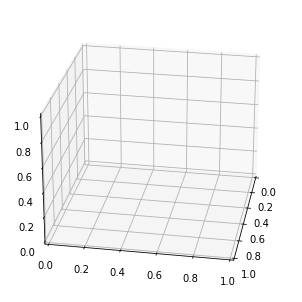

In [146]:
scatter=ax.scatter(particles["position"][:,0], particles["position"][:,1])

def update(frame_number):
   particles["force"]=np.random.uniform(-2,2.,(n,2));
   particles["velocity"] = particles["velocity"] + particles["force"]*dt
   particles["position"] = particles["position"] + particles["velocity"]*dt

   particles["position"] = particles["position"]%L
   scatter.set_offsets(particles["position"])
   return scatter,

anim = FuncAnimation(fig, update, interval=10)
plt.show()

NameError: name 'fvl' is not defined

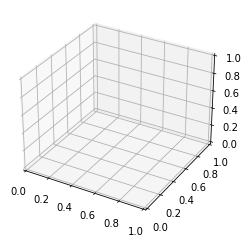

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

def gen(n):
    phi = 0
    while phi < len(five_minute_video):
        yield np.array([z[phi], x[phi], y[phi]])
        phi += 1

def update(num, data, line):
#     print(data[:2, :num])
    line.set_data(data[:2, :num])
    line.set_3d_properties(data[2, :num])
    
N = len(fvl)
data = np.array(list(gen(N))).T
line, = ax.plot(z, x, y)

# Setting the axes properties
ax.set_zlim([0.25, 2.5])
ax.set_xlim([-2.5, -1.0])
ax.set_ylim([-1.0, 3.0])

ax.set_xticklabels(['X'])
ax.set_yticklabels(['Y'])
ax.set_zticklabels(['Z'])

ani = animation.FuncAnimation(fig, update, N, fargs=(data, line), interval=300000/N, blit=False)
FFwriter = animation.FFMpegWriter(fps=60)
ani.save('five_minute_animation_final.mp4')
plt.show()

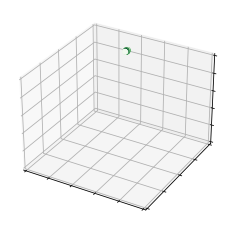

In [229]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax2.plot3D(x, y, z, 'blue')
ax.set_xlim([-6.0, 4.0])
ax.set_ylim([-4.0, 0.0])
ax.set_zlim([-2.0, 3.0])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.scatter3D(z, y, x, c=t, cmap='Greens');

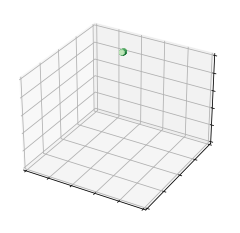

In [214]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax2.plot3D(x, y, z, 'blue')
ax.set_xlim([-6.0, 4.0])
ax.set_ylim([-4.0, 0.0])
ax.set_zlim([-2.0, 3.0])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.scatter3D(z, y, x, c=t, cmap='Greens');

In [ ]:
from numpy.linalg import eigh
cov_matrix = np.cov(copied_latent_vectors, rowvar=False)
egnvalues, egnvectors = eigh(cov_matrix)
total_egnvalues = sum(egnvalues)
var_exp = [(i/total_egnvalues) for i in sorted(egnvalues, reverse=True)]

In [ ]:
var_exp

In [ ]:
!python -m pip install seaborn

In [1]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(latent_vectors)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

NameError: name 'latent_vectors' is not defined

In [ ]:
print(tsne_results.shape)
df = pd.DataFrame(tsne_results, columns = ['Column_A','Column_B','Column_C'])

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = df['Column_A']
y = df['Column_B']
z = df['Column_C']

ax.set_xlabel("Axis1")
ax.set_ylabel("Axis2")
ax.set_zlabel("Axis3")

ax.scatter(x, y, z)

plt.show()

In [ ]:
fig = plt.figure()
ax2 = plt.axes(projection='3d')
# ax2.plot3D(x, y, z, 'blue')
t = [i for i in range(30720)]
ax2.scatter3D(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2], c=t, cmap='Greens');